# Into
This script is to create multiple data splits with multiple levels of difficulty, given a dataset with class and superclass information. 

We assume the datapoints with unknown superclasses have been assigned the value `-1` in the superclass field. 

## Functions
Functions for evenly splitting dataframes based on their labels.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def get_label_split_stats(split, split_labels, ltype):
    all_labels = np.unique(split[ltype])
    other_split_labels = list(set(all_labels) - set(split_labels))
    split1 = split[split[ltype].isin(split_labels)]
    split2 = split[split[ltype].isin(other_split_labels)]
    print(f'Len split1: {len(split1)}')
    print(f'Len split2: {len(split2)}')
    print(f'(len split1) / (len split2): {len(split1) / len(split2)}')
    return split1, split2, [split_labels, other_split_labels]

  
def get_stats(split, title='', p=True):
  labels, labels_count = np.unique(split.hotel_id, return_counts=True)
  super_labels, super_labels_count = np.unique(split.chain, return_counts=True)
  to_ret = ''
  if p:
    print(title)
    print(f'Images: {len(split)}, Labels: {len(labels)}, Super_labels: {len(super_labels)}')
    print(f'Avg img per class: {np.round(labels_count.mean(), 2)}, Min img per class: {labels_count.min()}, max img per class: {labels_count.max()}')
    print(
        f'Avg img per super_class: {np.round(super_labels_count.mean(), 2)}, Min img per super_class: {super_labels_count.min()}, max img per super_class: {super_labels_count.max()}')
  else:
    to_ret = ''
    to_ret += title + "\n"
    to_ret += f'Images: {len(split)}, Labels: {len(labels)}, Super_labels: {len(super_labels)}' + "\n"
    to_ret += f'Avg img per class: {np.round(labels_count.mean(), 2)}, Min img per class: {labels_count.min()}, max img per class: {labels_count.max()}' + "\n"
    to_ret += f'Avg img per super_class: {np.round(super_labels_count.mean(), 2)}, Min img per super_class: {super_labels_count.min()}, max img per super_class: {super_labels_count.max()}' + "\n\n\n"
    
  return to_ret


In [ ]:
def get_final_split(df, thresh, min_val, prob=True):
  lbls, lbls_c = np.unique(df.hotel_id, return_counts=True)
  under_thresh_lbls = lbls[lbls_c < thresh]
  above_thresh_lbls = lbls[lbls_c >= thresh]
  print('Under thresh:')
  under_thresh_df = df[df.hotel_id.isin(under_thresh_lbls)]
  if len(under_thresh_df) == 0:
    print('Nothing under threshold')
  else:
    print('Under threshold stats:')
    get_stats(under_thresh_df)
  print('***')
  print('Above thresh:')
  above_thresh_df = df[df.hotel_id.isin(above_thresh_lbls)]
  get_stats(above_thresh_df)
  mask_on_all_abovethresh = [i for i in range(len(above_thresh_df))]
  above_thresh_df['mask'] = mask_on_all_abovethresh
  final_split_val = np.array([])
  for l in above_thresh_lbls:
    relevant_masks = list(above_thresh_df[above_thresh_df.hotel_id == l]['mask'])
    if prob:
      to_sample = np.random.randint(min_val, max((len(relevant_masks) // 5) + 1, min_val + 1))
    else:
      to_sample = (len(relevant_masks) // min_val)
    final_split_val = np.append(final_split_val, np.random.choice(relevant_masks, to_sample, replace=False))
    
  val_split = above_thresh_df[above_thresh_df['mask'].isin(final_split_val)].drop(columns=['mask'])
  train_split = pd.concat([under_thresh_df, above_thresh_df[~above_thresh_df['mask'].isin(final_split_val)]]).drop(columns=['mask'])
  get_stats(val_split)
  print('*****')
  get_stats(train_split)
  train_labels, train_labels_c = np.unique(train_split.hotel_id, return_counts=True)
  plt.hist(train_labels_c, bins=100)
  plt.show()
  print(train_split.head())
  print(val_split.head())
  return train_split, val_split


In [ ]:
TRAIN_PATH = './train.csv'


all_hotels = pd.read_csv('./train.csv')
all_hotels.shape, all_hotels.drop_duplicates().shape

((97556, 4), (97556, 4))

# Data cleaning

First, we make sure the data is clean. To do so, we initially remove all duplicates and also make sure no classes exist that are assigned to multiple superclass categories.

In [ ]:
all_hotels_ids_chains = all_hotels[['hotel_id', 'chain']].drop_duplicates()

In [ ]:
ids_u, ids_c = np.unique(all_hotels_ids_chains.hotel_id, return_counts=True)
chains_u, chains_c = np.unique(all_hotels_ids_chains.chain, return_counts=True)
print(ids_c)
print(ids_c.min())
duplicate_hotel_ids = ids_u[ids_c > 1]
duplicate_hotel_ids

[1 1 1 ... 1 1 1]
1


array([ 9760, 20229, 28721, 62488])

In [ ]:
all_hotels[all_hotels.hotel_id.isin(duplicate_hotel_ids)]
all_hotel_ids = list(all_hotels.hotel_id.unique())

In [ ]:
id2chain = {i: 0 for i in all_hotel_ids}
for i, row in all_hotels.iterrows():
  if row.chain != 0:
    id2chain[row.hotel_id] = row.chain
  

In [ ]:
chains = []
for lbl in all_hotels.hotel_id:
  chains.append(id2chain[lbl])

all_hotels['new_chain'] = chains
pox = all_hotels[all_hotels.apply(lambda row: row.chain != row.new_chain, axis=1)]


In [ ]:
pox.shape, pox[pox.hotel_id.isin(duplicate_hotel_ids)].shape
new_all_hotels = all_hotels.drop(labels=['chain'], axis=1)
new_all_hotels = all_hotels.drop(labels=['timestamp'], axis=1)
new_all_hotels = new_all_hotels[['image', 'new_chain', 'hotel_id']]
new_all_hotels.columns = ['image', 'chain', 'hotel_id']
new_all_hotels

image  chain  hotel_id
0      8000d59f6a3d765f.jpg     85     24607
1      8000febe81817f7f.jpg      6     25389
2      80053befc2d42fba.jpg      3       672
3      8007fa0a8fe89f9d.jpg      5     63866
4      800a4a6b6f6d2df6.jpg      0     12036
...                     ...    ...       ...
97551  ffff8082ec219892.jpg     83     20544
97552  ffff8200e50cc0f1.jpg     82     51053
97553  ffff84129981a4a4.jpg     83     42842
97554  ffff85015040c2af.jpg     82      6261
97555  ffffc0c05f2820c1.jpg     79     58764

[97556 rows x 3 columns]

After making sure all classes and superclasses are cleaned, we make sure that every image is used only __once__ and assigned to a single class. We also remove classes with size `1`, i.e, classees that only contain one image.

In [ ]:
# print(new_all_hotels.shape, new_all_hotels.drop_duplicates().shape)
# img_u, img_c = np.unique(new_all_hotels.image, return_counts=True)
# duplicate_imgs = img_u[img_c > 1]

# print(new_all_hotels[new_all_hotels.image.isin(duplicate_imgs)])

# new_all_hotels = new_all_hotels.drop_duplicates()


id_u, id_c = np.unique(new_all_hotels.hotel_id, return_counts=True)

size_1_classes = id_u[id_c == 1]

print(size_1_classes)

new_all_hotels_no_ones = new_all_hotels[~new_all_hotels.hotel_id.isin(size_1_classes)]

print('new shape:', new_all_hotels_no_ones.shape)
new_all_hotels_no_ones.to_csv('./drive/MyDrive/ht-image/hotelid-2021-split/all_hotels.csv', header=True, index=False)

[14964]
new shape: (97553, 3)


# Creating Splits

Besides a train split, we aim to create 4 types of evaluation splits according to the train split:
   1. Datpoints with unkonwn superclasses (`D_{??}`)
   2. Datapoints where all classses are included in the train split (`D_{SS}`)
   3. Datapoints from _classes_ not included in the train split (`D_{SU}`)
   4. Datapoints from _superclasses_ not included in the train split (`D_{UU}`)

## Creating `D_{??}`
As such, we first extract datapoints with unkonwn superclasses and assign them all to the `D_{??}` split. 

In [ ]:

all_hotels = pd.read_csv('./drive/MyDrive/ht-image/hotelid-2021-split/all_hotels.csv')

UNKOWN_CHAIN_LABELS = [0]

all_known_chains = all_hotels[~all_hotels.chain.isin(UNKOWN_CHAIN_LABELS)]
all_unknown_chains = all_hotels[all_hotels.chain.isin(UNKOWN_CHAIN_LABELS)]
labels, labels_count = np.unique(all_known_chains.hotel_id, return_counts=True)
super_labels, super_labels_count = np.unique(all_known_chains.chain, return_counts=True)


In [ ]:
all_known_chains.shape, all_unknown_chains.shape, super_labels.shape

((77333, 3), (20220, 3), (87,))

In [ ]:
ids_u, ids_c = np.unique(all_hotels.hotel_id, return_counts=True)
chain_u, chain_c = np.unique(all_hotels.chain, return_counts=True)
ids_c.sort()
print('total:', all_hotels.shape)
print('min:', np.min(ids_c))
print('max:', np.max(ids_c))
print('avg:', np.mean(ids_c))
print('median:', np.median(ids_c))

total: (97553, 3)
min: 2
max: 95
avg: 12.556699703951603
median: 8.0


In [ ]:
chains = all_hotels.chain
np.unique(chains, return_counts=True)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 17, 18,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
        89, 90, 91]),
 array([20220,  1241,  3889,  5430,  4771,  6328,  8157,   861,   926,
         1526,    12,   247,    26,     8,     8,    50,     8,    27,
           28,   186,    66,    40,    62,    31,    44,    22,    88,
          109,    39,    40,    49,   242,   220,    83,    62,   416,
          173,    84,   157,   116,   418,   248,   190,   103,    74,
          112,   605,   331,   553,   568,   221,   257,     8,   221,
           13,   117,   145,   324,  1373,   896,   361,   144,   392,
          359,  1765,   415,   406,   509,   344,  1705,   268,   741,
         1664,   227,  3024,  

In [ ]:
EVAL_ENTERING_THRESHOLD = 8

print(f'# of labels with MORE than {EVAL_ENTERING_THRESHOLD} images:', len(ids_c[ids_c > EVAL_ENTERING_THRESHOLD]))
print(f'# of labels with LESS than {EVAL_ENTERING_THRESHOLD} images:', len(ids_c[ids_c < EVAL_ENTERING_THRESHOLD]))
print(f'# of labels with EXACTLY {EVAL_ENTERING_THRESHOLD} images:', len(ids_c[ids_c == EVAL_ENTERING_THRESHOLD]))
print(f'*' * 20)
print(f'# of images in classes with MORE than {EVAL_ENTERING_THRESHOLD} images:', sum(ids_c[ids_c > EVAL_ENTERING_THRESHOLD]))
print(f'# of images in classes with LESS than {EVAL_ENTERING_THRESHOLD} images:', sum(ids_c[ids_c < EVAL_ENTERING_THRESHOLD]))
print(f'# of images in classes with EXACTLY {EVAL_ENTERING_THRESHOLD} images:', sum(ids_c[ids_c == EVAL_ENTERING_THRESHOLD]))

print('all images:', sum(ids_c))
print('1/7 of all images:', len(ids_c) / 7) # 7 -> 4 train, 1 test1, 1 test2, 1 test3
print('probably train set:', 4 * (len(ids_c) / 7))

print(sorted(ids_c))

# of labels with MORE than 8 images: 2576
# of labels with LESS than 8 images: 1313
# of labels with EXACTLY 8 images: 3880
********************
# of images in classes with MORE than 8 images: 58553
# of images in classes with LESS than 8 images: 7960
# of images in classes with EXACTLY 8 images: 31040
all images: 97553
1/8 of all images: 971.125
probably train set: 3884.5
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
np.unique(ids_c, return_counts=True)

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87,
        92, 95]),
 array([  15,   21,  188,  118,  272,  699, 3880,   41,   84,  146,  635,
          29,   45,  103,  315,   15,   37,   64,  189,   27,   29,   42,
         115,    6,   21,   40,   66,   10,   21,   21,   47,    4,   17,
          18,   35,   11,   11,   19,   29,    3,   10,   10,   10,    4,
           6,    6,   17,    5,    9,    4,   14,    4,    3,    1,    9,
           6,    5,    6,    5,    4,    2,    5,    6,    2,    3,    5,
           4,    4,    4,    7,   12,    8,   13,   10,   16,    5,    5,
           7,    9,    2,    5,    2,    2,    1,    1,    1,    2]))

In [ ]:
thresh = 4
ids_lt8 = ids_u[ids_c < thresh]
ids_gt8 = ids_u[ids_c >= thresh]

chains_for_hotelids_lt8 = all_hotels[all_hotels.hotel_id.isin(ids_lt8)].chain.to_numpy()
chains_for_hotelids_gt8 = all_hotels[all_hotels.hotel_id.isin(ids_gt8)].chain.to_numpy()

chains_for_hotelids_lt8_u, chains_for_hotelids_lt8_c = np.unique(chains_for_hotelids_lt8, return_counts=True)
chains_for_hotelids_gt8_u, chains_for_hotelids_gt8_c = np.unique(chains_for_hotelids_gt8, return_counts=True)

# chain_lt8 = chain_u[chain_c < 8]
# chain_gt8 = chain_u[chain_c >= 8]



In [ ]:
print(len(chains_for_hotelids_lt8_u), len(chains_for_hotelids_gt8_u))
print(sorted(chains_for_hotelids_lt8_c))
print(sorted(chains_for_hotelids_gt8_c))

9 88
[8, 8, 16, 16, 20, 35, 44, 50, 71]
[8, 8, 8, 8, 12, 13, 22, 26, 27, 28, 31, 39, 40, 40, 41, 44, 49, 50, 62, 62, 66, 74, 83, 84, 88, 103, 109, 112, 116, 117, 144, 145, 157, 173, 186, 190, 220, 221, 221, 227, 242, 247, 248, 257, 268, 323, 324, 344, 359, 361, 392, 406, 415, 416, 418, 509, 552, 553, 605, 741, 846, 861, 914, 926, 988, 1126, 1200, 1241, 1373, 1375, 1454, 1526, 1588, 1660, 1664, 1694, 1705, 2441, 2933, 3024, 3302, 3318, 3889, 4755, 5386, 6293, 8149, 20220]


In [ ]:
train_split = all_hotels

In [ ]:
print(all_unknown_chains.shape)
print(all_known_chains.shape)

(20220, 3)
(77333, 3)


In [ ]:
get_stats(all_known_chains)

Images: 46237, Labels: 4406, Super_labels: 75
Avg img per class: 10.49, Min img per class: 2, max img per class: 81
Avg img per super_class: 616.49, Min img per super_class: 6, max img per super_class: 5524


## Creating ‍‍`‍‍D_SS‍` `D_SU` `D_UU`
Do everything automatically

In [ ]:
all_known_chains = pd.read_csv('./drive/MyDrive/ht-image/hotelid-2021-split/trainval_hotels.csv')

Len split1: 72463
Len split2: 4870
(len split1) / (len split2): 14.87946611909651
Len split1: 65330
Len split2: 12003
(len split1) / (len split2): 5.442805965175372
Len split1: 65046
Len split2: 12287
(len split1) / (len split2): 5.29388784894604
Len split1: 67790
Len split2: 9543
(len split1) / (len split2): 7.103636173111181
Len split1: 69703
Len split2: 7630
(len split1) / (len split2): 9.135386631716907
Len split1: 67193
Len split2: 10140
(len split1) / (len split2): 6.626528599605523
Len split1: 63706
Len split2: 13627
(len split1) / (len split2): 4.674983488662215
Len split1: 73183
Len split2: 4150
(len split1) / (len split2): 17.6344578313253
Len split1: 68902
Len split2: 8431
(len split1) / (len split2): 8.172458783062508
Len split1: 72504
Len split2: 4829
(len split1) / (len split2): 15.014288672603023
Len split1: 62334
Len split2: 14999
(len split1) / (len split2): 4.155877058470565
Len split1: 67195
Len split2: 10138
(len split1) / (len split2): 6.628033142631683
Len split1:

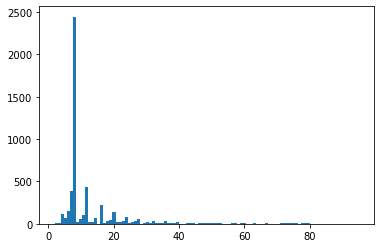

5020
second thresh =  4183
Len split1: 54556
Len split2: 11723
(len split1) / (len split2): 4.653757570587733
len(s1) / len(s2) = 4.653757570587733
Len split1: 55769
Len split2: 10510
(len split1) / (len split2): 5.3062797335870595
len(s1) / len(s2) = 5.3062797335870595
Len split1: 55401
Len split2: 10878
(len split1) / (len split2): 5.092939878654164
len(s1) / len(s2) = 5.092939878654164
Len split1: 55150
Len split2: 11129
(len split1) / (len split2): 4.955521610207565
len(s1) / len(s2) = 4.955521610207565

Images: 55150, Labels: 4183, Super_labels: 75
Avg img per class: 13.18, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.33, Min img per super_class: 8, max img per super_class: 7027
*********

Images: 11129, Labels: 837, Super_labels: 65
Avg img per class: 13.3, Min img per class: 2, max img per class: 95
Avg img per super_class: 171.22, Min img per super_class: 8, max img per super_class: 1150

Images: 55150, Labels: 4183, Super_labels: 75
Avg img per clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8792, Labels: 3549, Super_labels: 74
Avg img per class: 2.48, Min img per class: 2, max img per class: 15
Avg img per super_class: 118.81, Min img per super_class: 2, max img per super_class: 1151
*****

Images: 46358, Labels: 4183, Super_labels: 75
Avg img per class: 11.08, Min img per class: 2, max img per class: 90
Avg img per super_class: 618.11, Min img per super_class: 6, max img per super_class: 5876


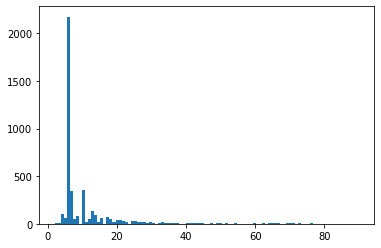

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
7   800e7dd55ffa4056.jpg      2     60181
34  802f7fd0d42f2cca.jpg      6     32426
50  803aff8f12e0519f.jpg     68     63331
67  803f07609d6fd25d.jpg     80     21881
74  803f73804ffe6187.jpg     55      7828
********** TEST 1

Images: 8792, Labels: 3549, Super_labels: 74
Avg img per class: 2.48, Min img per class: 2, max img per class: 15
Avg img per super_class: 118.81, Min img per super_class: 2, max img per super_class: 1151
Len split1: 70436
Len split2: 6897
(len split1) / (len split2): 10.21255618384805
Len split1: 65043
Len split2: 12290
(len split1) / (len split2): 5.292351505288853
Len split1: 61426
Len split2: 15907
(len split1) / (len split2): 3.861570377821085
Len split1: 68790


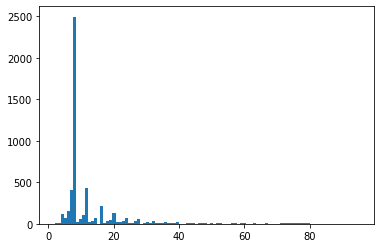

5085
second thresh =  4237
Len split1: 55129
Len split2: 11172
(len split1) / (len split2): 4.9345685642678125
len(s1) / len(s2) = 4.9345685642678125
Len split1: 55289
Len split2: 11012
(len split1) / (len split2): 5.020795495822739
len(s1) / len(s2) = 5.020795495822739

Images: 55289, Labels: 4237, Super_labels: 75
Avg img per class: 13.05, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.19, Min img per super_class: 7, max img per super_class: 5141
*********

Images: 11012, Labels: 848, Super_labels: 62
Avg img per class: 12.99, Min img per class: 2, max img per class: 95
Avg img per super_class: 177.61, Min img per super_class: 7, max img per super_class: 1187

Images: 55289, Labels: 4237, Super_labels: 75
Avg img per class: 13.05, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.19, Min img per super_class: 7, max img per super_class: 5141
********** TEST 2

Images: 11012, Labels: 848, Super_labels: 62
Avg img per class: 12.99, Min im

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8922, Labels: 3576, Super_labels: 73
Avg img per class: 2.49, Min img per class: 2, max img per class: 19
Avg img per super_class: 122.22, Min img per super_class: 2, max img per super_class: 904
*****

Images: 46367, Labels: 4237, Super_labels: 75
Avg img per class: 10.94, Min img per class: 2, max img per class: 79
Avg img per super_class: 618.23, Min img per super_class: 6, max img per super_class: 4237


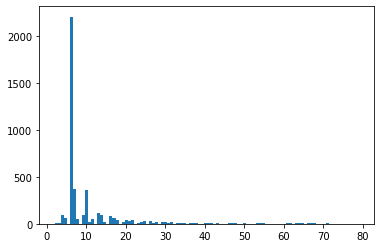

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
5   800a7ffa85c57a3a.jpg      3     25583
11  801aff45ebd0bcd0.jpg     78     26666
21  802a75e51eda5c67.jpg      9      5388
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 8922, Labels: 3576, Super_labels: 73
Avg img per class: 2.49, Min img per class: 2, max img per class: 19
Avg img per super_class: 122.22, Min img per super_class: 2, max img per super_class: 904
Len split1: 62614
Len split2: 14719
(len split1) / (len split2): 4.253957469936816
Len split1: 69819
Len split2: 7514
(len split1) / (len split2): 9.29185520361991
Len split1: 66687
Len split2: 10646
(len split1) / (len split2): 6.264042832988916
Len split1: 72591
Len spli

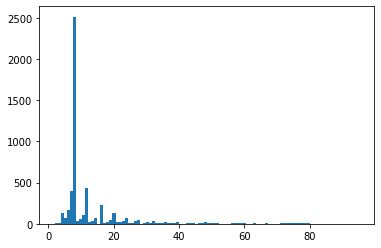

5093
second thresh =  4244
Len split1: 55300
Len split2: 10985
(len split1) / (len split2): 5.034137460172963
len(s1) / len(s2) = 5.034137460172963

Images: 55300, Labels: 4244, Super_labels: 75
Avg img per class: 13.03, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.33, Min img per super_class: 8, max img per super_class: 6754
*********

Images: 10985, Labels: 849, Super_labels: 62
Avg img per class: 12.94, Min img per class: 2, max img per class: 79
Avg img per super_class: 177.18, Min img per super_class: 2, max img per super_class: 1403

Images: 55300, Labels: 4244, Super_labels: 75
Avg img per class: 13.03, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.33, Min img per super_class: 8, max img per super_class: 6754
********** TEST 2

Images: 10985, Labels: 849, Super_labels: 62
Avg img per class: 12.94, Min img per class: 2, max img per class: 79
Avg img per super_class: 177.18, Min img per super_class: 2, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8878, Labels: 3582, Super_labels: 74
Avg img per class: 2.48, Min img per class: 2, max img per class: 17
Avg img per super_class: 119.97, Min img per super_class: 2, max img per super_class: 1115
*****

Images: 46422, Labels: 4244, Super_labels: 75
Avg img per class: 10.94, Min img per class: 2, max img per class: 86
Avg img per super_class: 618.96, Min img per super_class: 6, max img per super_class: 5639


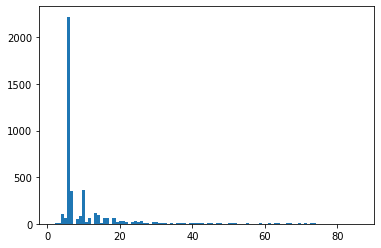

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
2   80053befc2d42fba.jpg      3       672
5   800a7ffa85c57a3a.jpg      3     25583
7   800e7dd55ffa4056.jpg      2     60181
11  801aff45ebd0bcd0.jpg     78     26666
********** TEST 1

Images: 8878, Labels: 3582, Super_labels: 74
Avg img per class: 2.48, Min img per class: 2, max img per class: 17
Avg img per super_class: 119.97, Min img per super_class: 2, max img per super_class: 1115
Len split1: 60816
Len split2: 16517
(len split1) / (len split2): 3.6820245807350003
Len split1: 63014
Len split2: 14319
(len split1) / (len split2): 4.400726307703052
Len split1: 63662
Len split2: 13671
(len split1) / (len split2): 4.656718601419063
Len split1: 6188

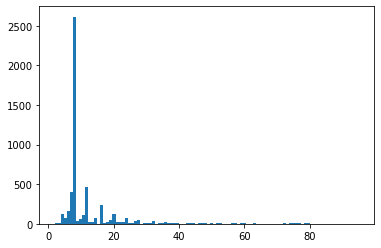

5221
second thresh =  4350
Len split1: 55418
Len split2: 10862
(len split1) / (len split2): 5.102006996869822
len(s1) / len(s2) = 5.102006996869822
Len split1: 55073
Len split2: 11207
(len split1) / (len split2): 4.914160792361916
len(s1) / len(s2) = 4.914160792361916
Len split1: 55319
Len split2: 10961
(len split1) / (len split2): 5.0468935316120795
len(s1) / len(s2) = 5.0468935316120795

Images: 55319, Labels: 4350, Super_labels: 73
Avg img per class: 12.72, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.79, Min img per super_class: 6, max img per super_class: 6980
*********

Images: 10961, Labels: 871, Super_labels: 68
Avg img per class: 12.58, Min img per class: 2, max img per class: 87
Avg img per super_class: 161.19, Min img per super_class: 7, max img per super_class: 1177

Images: 55319, Labels: 4350, Super_labels: 73
Avg img per class: 12.72, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.79, Min img per super_class: 6, max i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8995, Labels: 3689, Super_labels: 71
Avg img per class: 2.44, Min img per class: 2, max img per class: 15
Avg img per super_class: 126.69, Min img per super_class: 2, max img per super_class: 1188
*****

Images: 46324, Labels: 4350, Super_labels: 73
Avg img per class: 10.65, Min img per class: 2, max img per class: 87
Avg img per super_class: 634.58, Min img per super_class: 6, max img per super_class: 5792


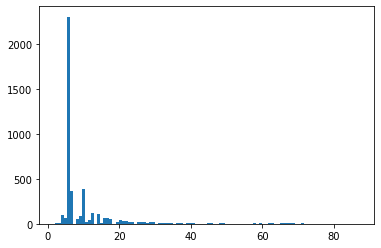

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
11  801aff45ebd0bcd0.jpg     78     26666
13  8020ee1f3f7781da.jpg     52      2498
29  802beb5ad6256d35.jpg      3     26810
40  8035ee81817f7f68.jpg      3     22338
55  803d7a43427ff585.jpg     71     17105
********** TEST 1

Images: 8995, Labels: 3689, Super_labels: 71
Avg img per class: 2.44, Min img per class: 2, max img per class: 15
Avg img per super_class: 126.69, Min img per super_class: 2, max img per super_class: 1188
Len split1: 70334
Len split2: 6999
(len split1) / (len split2): 10.04914987855408
Len split1: 66559
Len split2: 10774
(len split1) / (len split2): 6.177742713940969
Len split1: 61223
Len split2: 16110
(len split1) / (len split2): 3.800310366232154
Len split1: 56871
Len sp

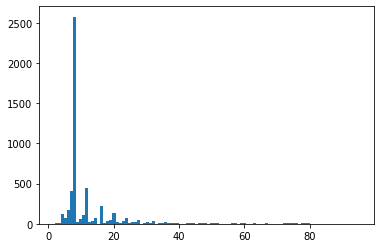

5169
second thresh =  4307
Len split1: 55405
Len split2: 10850
(len split1) / (len split2): 5.106451612903226
len(s1) / len(s2) = 5.106451612903226
Len split1: 54678
Len split2: 11577
(len split1) / (len split2): 4.722985229334024
len(s1) / len(s2) = 4.722985229334024
Len split1: 55513
Len split2: 10742
(len split1) / (len split2): 5.167845838763731
len(s1) / len(s2) = 5.167845838763731
Len split1: 55047
Len split2: 11208
(len split1) / (len split2): 4.911402569593148
len(s1) / len(s2) = 4.911402569593148
Len split1: 55395
Len split2: 10860
(len split1) / (len split2): 5.100828729281768
len(s1) / len(s2) = 5.100828729281768
Len split1: 55736
Len split2: 10519
(len split1) / (len split2): 5.2986025287574865
len(s1) / len(s2) = 5.2986025287574865
Len split1: 55376
Len split2: 10879
(len split1) / (len split2): 5.090173729203052
len(s1) / len(s2) = 5.090173729203052
Len split1: 55271
Len split2: 10984
(len split1) / (len split2): 5.031955571740713
len(s1) / len(s2) = 5.031955571740713

Im

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8981, Labels: 3653, Super_labels: 73
Avg img per class: 2.46, Min img per class: 2, max img per class: 16
Avg img per super_class: 123.03, Min img per super_class: 2, max img per super_class: 1183
*****

Images: 46290, Labels: 4307, Super_labels: 74
Avg img per class: 10.75, Min img per class: 2, max img per class: 92
Avg img per super_class: 625.54, Min img per super_class: 6, max img per super_class: 5835


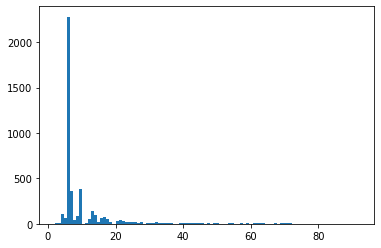

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
9   80196e6999ce63cf.jpg     90     55532
19  802a2be985975e5f.jpg     83     21874
24  802aef94c02bbfd5.jpg      6     62831
********** TEST 1

Images: 8981, Labels: 3653, Super_labels: 73
Avg img per class: 2.46, Min img per class: 2, max img per class: 16
Avg img per super_class: 123.03, Min img per super_class: 2, max img per super_class: 1183
Len split1: 71043
Len split2: 6290
(len split1) / (len split2): 11.294594594594594
Len split1: 58176
Len split2: 19157
(len split1) / (len split2): 3.0368011692853787
Len split1: 74844
Len split2: 2489
(len split1) / (len split2): 30.06990759341101
Len split1: 67285

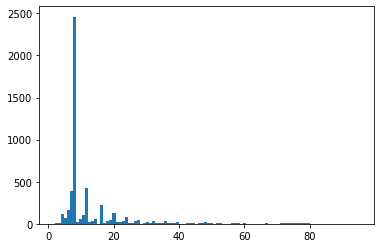

5023
second thresh =  4185
Len split1: 55727
Len split2: 10525
(len split1) / (len split2): 5.294726840855107
len(s1) / len(s2) = 5.294726840855107
Len split1: 55478
Len split2: 10774
(len split1) / (len split2): 5.149248190087247
len(s1) / len(s2) = 5.149248190087247
Len split1: 54961
Len split2: 11291
(len split1) / (len split2): 4.867682224780799
len(s1) / len(s2) = 4.867682224780799
Len split1: 55472
Len split2: 10780
(len split1) / (len split2): 5.14582560296846
len(s1) / len(s2) = 5.14582560296846
Len split1: 55056
Len split2: 11196
(len split1) / (len split2): 4.917470525187567
len(s1) / len(s2) = 4.917470525187567
Len split1: 55250
Len split2: 11002
(len split1) / (len split2): 5.021814215597164
len(s1) / len(s2) = 5.021814215597164

Images: 55250, Labels: 4185, Super_labels: 75
Avg img per class: 13.2, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.67, Min img per super_class: 8, max img per super_class: 6952
*********

Images: 11002, Labels: 838, Sup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8808, Labels: 3539, Super_labels: 75
Avg img per class: 2.49, Min img per class: 2, max img per class: 19
Avg img per super_class: 117.44, Min img per super_class: 2, max img per super_class: 1160
*****

Images: 46442, Labels: 4185, Super_labels: 75
Avg img per class: 11.1, Min img per class: 2, max img per class: 92
Avg img per super_class: 619.23, Min img per super_class: 6, max img per super_class: 5792


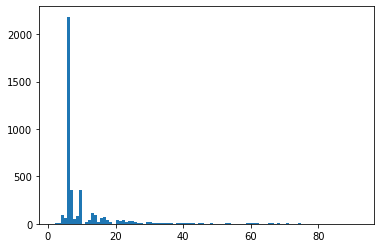

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
9   80196e6999ce63cf.jpg     90     55532
22  802a7af055d739e9.jpg     50     45049
24  802aef94c02bbfd5.jpg      6     62831
26  802b5ed622fd3587.jpg     90     35252
********** TEST 1

Images: 8808, Labels: 3539, Super_labels: 75
Avg img per class: 2.49, Min img per class: 2, max img per class: 19
Avg img per super_class: 117.44, Min img per super_class: 2, max img per super_class: 1160
Len split1: 64332
Len split2: 13001
(len split1) / (len split2): 4.948234751172986
Len split1: 71089
Len split2: 6244
(len split1) / (len split2): 11.385169762972454
Len split1: 63704
Len split2: 13629
(len split1) / (len split2): 4.674150708049013
Len split1: 63819

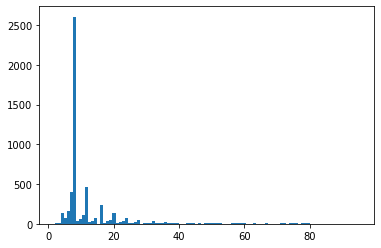

5217
second thresh =  4347
Len split1: 55293
Len split2: 11014
(len split1) / (len split2): 5.0202469584165605
len(s1) / len(s2) = 5.0202469584165605

Images: 55293, Labels: 4347, Super_labels: 73
Avg img per class: 12.72, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.44, Min img per super_class: 8, max img per super_class: 6849
*********

Images: 11014, Labels: 870, Super_labels: 64
Avg img per class: 12.66, Min img per class: 3, max img per class: 95
Avg img per super_class: 172.09, Min img per super_class: 8, max img per super_class: 1308

Images: 55293, Labels: 4347, Super_labels: 73
Avg img per class: 12.72, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.44, Min img per super_class: 8, max img per super_class: 6849
********** TEST 2

Images: 11014, Labels: 870, Super_labels: 64
Avg img per class: 12.66, Min img per class: 3, max img per class: 95
Avg img per super_class: 172.09, Min img per super_class: 8, max img per super_clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8998, Labels: 3686, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 18
Avg img per super_class: 123.26, Min img per super_class: 2, max img per super_class: 1150
*****

Images: 46295, Labels: 4347, Super_labels: 73
Avg img per class: 10.65, Min img per class: 2, max img per class: 84
Avg img per super_class: 634.18, Min img per super_class: 6, max img per super_class: 5699


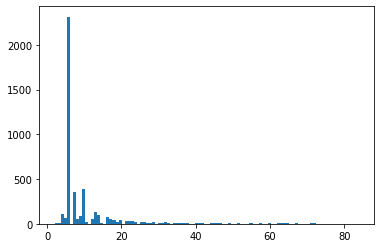

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
22  802a7af055d739e9.jpg     50     45049
27  802b7e9095d5fe2a.jpg      5     21723
35  802f7ff490819fc9.jpg     87      5697
47  8039c6e66bb6e329.jpg      6      9828
54  803c53933678ed97.jpg      8     58850
********** TEST 1

Images: 8998, Labels: 3686, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 18
Avg img per super_class: 123.26, Min img per super_class: 2, max img per super_class: 1150
Len split1: 58116
Len split2: 19217
(len split1) / (len split2): 3.024197325284904
Len split1: 67895
Len split2: 9438
(len split1) / (len split2): 7.193791057427421
Len split1: 69958
Len split2: 7375
(len split1) / (len split2): 9.485830508474576
Len split1: 68133
L

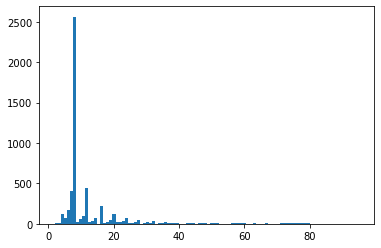

5140
second thresh =  4283
Len split1: 55002
Len split2: 11319
(len split1) / (len split2): 4.8592631857937985
len(s1) / len(s2) = 4.8592631857937985
Len split1: 55244
Len split2: 11077
(len split1) / (len split2): 4.98727092172971
len(s1) / len(s2) = 4.98727092172971

Images: 55244, Labels: 4283, Super_labels: 73
Avg img per class: 12.9, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.77, Min img per super_class: 8, max img per super_class: 6763
*********

Images: 11077, Labels: 857, Super_labels: 64
Avg img per class: 12.93, Min img per class: 2, max img per class: 95
Avg img per super_class: 173.08, Min img per super_class: 3, max img per super_class: 1394

Images: 55244, Labels: 4283, Super_labels: 73
Avg img per class: 12.9, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.77, Min img per super_class: 8, max img per super_class: 6763
********** TEST 2

Images: 11077, Labels: 857, Super_labels: 64
Avg img per class: 12.93, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8935, Labels: 3630, Super_labels: 71
Avg img per class: 2.46, Min img per class: 2, max img per class: 16
Avg img per super_class: 125.85, Min img per super_class: 2, max img per super_class: 1129
*****

Images: 46309, Labels: 4283, Super_labels: 73
Avg img per class: 10.81, Min img per class: 2, max img per class: 82
Avg img per super_class: 634.37, Min img per super_class: 6, max img per super_class: 5634


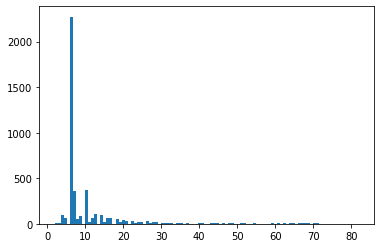

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
21  802a75e51eda5c67.jpg      9      5388
27  802b7e9095d5fe2a.jpg      5     21723
34  802f7fd0d42f2cca.jpg      6     32426
35  802f7ff490819fc9.jpg     87      5697
********** TEST 1

Images: 8935, Labels: 3630, Super_labels: 71
Avg img per class: 2.46, Min img per class: 2, max img per class: 16
Avg img per super_class: 125.85, Min img per super_class: 2, max img per super_class: 1129
Len split1: 59317
Len split2: 18016
(len split1) / (len split2): 3.2924622557726466
Len split1: 71933
Len split2: 5400
(len split1) / (len split2): 13.320925925925925
Len split1: 60437
Len split2: 16896
(len split1) / (len split2): 3.5770004734848486
Len split1: 720

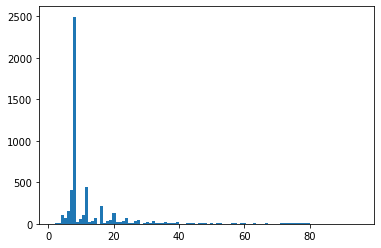

5071
second thresh =  4225
Len split1: 55114
Len split2: 11122
(len split1) / (len split2): 4.955403704369718
len(s1) / len(s2) = 4.955403704369718

Images: 55114, Labels: 4225, Super_labels: 74
Avg img per class: 13.04, Min img per class: 2, max img per class: 95
Avg img per super_class: 744.78, Min img per super_class: 8, max img per super_class: 5201
*********

Images: 11122, Labels: 846, Super_labels: 64
Avg img per class: 13.15, Min img per class: 3, max img per class: 86
Avg img per super_class: 173.78, Min img per super_class: 7, max img per super_class: 1127

Images: 55114, Labels: 4225, Super_labels: 74
Avg img per class: 13.04, Min img per class: 2, max img per class: 95
Avg img per super_class: 744.78, Min img per super_class: 8, max img per super_class: 5201
********** TEST 2

Images: 11122, Labels: 846, Super_labels: 64
Avg img per class: 13.15, Min img per class: 3, max img per class: 86
Avg img per super_class: 173.78, Min img per super_class: 7, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8898, Labels: 3577, Super_labels: 73
Avg img per class: 2.49, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.89, Min img per super_class: 2, max img per super_class: 912
*****

Images: 46216, Labels: 4225, Super_labels: 74
Avg img per class: 10.94, Min img per class: 2, max img per class: 82
Avg img per super_class: 624.54, Min img per super_class: 6, max img per super_class: 4289


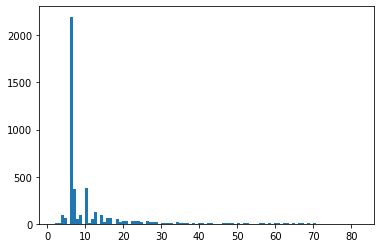

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
5   800a7ffa85c57a3a.jpg      3     25583
12  801f7ce821c7dfd0.jpg     89     27809
49  803abbf5482e3b93.jpg     87      5210
52  803b5ed0d6037b3e.jpg      5     16791
********** TEST 1

Images: 8898, Labels: 3577, Super_labels: 73
Avg img per class: 2.49, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.89, Min img per super_class: 2, max img per super_class: 912
Len split1: 58659
Len split2: 18674
(len split1) / (len split2): 3.14121238085038
Len split1: 73939
Len split2: 3394
(len split1) / (len split2): 21.78520919269299
Len split1: 73547
Len split2: 3786
(len split1) / (len split2): 19.426043317485473
Len split1: 71285
Le

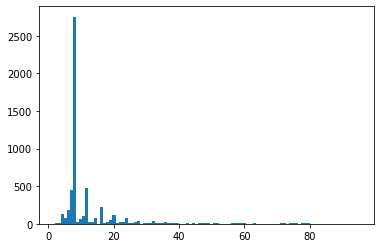

5392
second thresh =  4493
Len split1: 55151
Len split2: 11135
(len split1) / (len split2): 4.952941176470588
len(s1) / len(s2) = 4.952941176470588

Images: 55151, Labels: 4493, Super_labels: 74
Avg img per class: 12.27, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.28, Min img per super_class: 6, max img per super_class: 6998
*********

Images: 11135, Labels: 899, Super_labels: 65
Avg img per class: 12.39, Min img per class: 2, max img per class: 84
Avg img per super_class: 171.31, Min img per super_class: 4, max img per super_class: 1159

Images: 55151, Labels: 4493, Super_labels: 74
Avg img per class: 12.27, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.28, Min img per super_class: 6, max img per super_class: 6998
********** TEST 2

Images: 11135, Labels: 899, Super_labels: 65
Avg img per class: 12.39, Min img per class: 2, max img per class: 84
Avg img per super_class: 171.31, Min img per super_class: 4, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9131, Labels: 3765, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 18
Avg img per super_class: 125.08, Min img per super_class: 2, max img per super_class: 1196
*****

Images: 46020, Labels: 4493, Super_labels: 74
Avg img per class: 10.24, Min img per class: 2, max img per class: 87
Avg img per super_class: 621.89, Min img per super_class: 6, max img per super_class: 5802


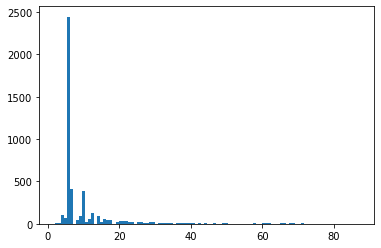

                    image  chain  hotel_id
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
13  8020ee1f3f7781da.jpg     52      2498
27  802b7e9095d5fe2a.jpg      5     21723
28  802bd28ddce08fbd.jpg      6     25918
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 9131, Labels: 3765, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 18
Avg img per super_class: 125.08, Min img per super_class: 2, max img per super_class: 1196
Len split1: 72702
Len split2: 4631
(len split1) / (len split2): 15.698985100410278
Len split1: 69721
Len split2: 7612
(len split1) / (len split2): 9.15935365212822
Len split1: 63899
Len split2: 13434
(len split1) / (len split2): 4.756513324400774
Len split1: 56231
L

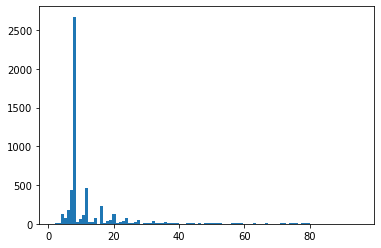

5295
second thresh =  4412
Len split1: 54990
Len split2: 11274
(len split1) / (len split2): 4.877594465141033
len(s1) / len(s2) = 4.877594465141033
Len split1: 54879
Len split2: 11385
(len split1) / (len split2): 4.820289855072463
len(s1) / len(s2) = 4.820289855072463
Len split1: 55621
Len split2: 10643
(len split1) / (len split2): 5.2260640796767825
len(s1) / len(s2) = 5.2260640796767825
Len split1: 55515
Len split2: 10749
(len split1) / (len split2): 5.164666480602847
len(s1) / len(s2) = 5.164666480602847
Len split1: 55021
Len split2: 11243
(len split1) / (len split2): 4.893800587031931
len(s1) / len(s2) = 4.893800587031931
Len split1: 55031
Len split2: 11233
(len split1) / (len split2): 4.899047449479213
len(s1) / len(s2) = 4.899047449479213
Len split1: 55117
Len split2: 11147
(len split1) / (len split2): 4.944559074190365
len(s1) / len(s2) = 4.944559074190365
Len split1: 55669
Len split2: 10595
(len split1) / (len split2): 5.254270882491741
len(s1) / len(s2) = 5.254270882491741
Len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9083, Labels: 3728, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.74, Min img per super_class: 2, max img per super_class: 1182
*****

Images: 46196, Labels: 4412, Super_labels: 75
Avg img per class: 10.47, Min img per class: 2, max img per class: 91
Avg img per super_class: 615.95, Min img per super_class: 6, max img per super_class: 5737


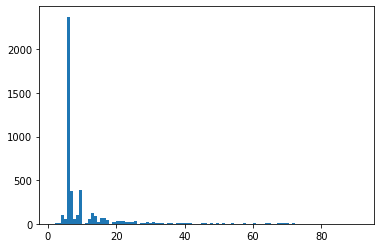

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
12  801f7ce821c7dfd0.jpg     89     27809
21  802a75e51eda5c67.jpg      9      5388
27  802b7e9095d5fe2a.jpg      5     21723
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 9083, Labels: 3728, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.74, Min img per super_class: 2, max img per super_class: 1182
Len split1: 61065
Len split2: 16268
(len split1) / (len split2): 3.7536882222768626
Len split1: 63945
Len split2: 13388
(len split1) / (len split2): 4.776292201971915
Len split1: 59624
Len split2: 17709
(len split1) / (len split2): 3.3668755999774125
Len split1: 684

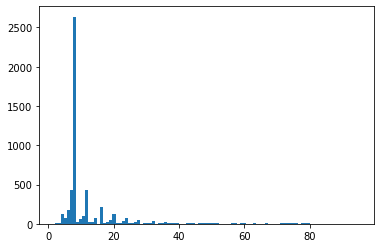

5203
second thresh =  4335
Len split1: 55234
Len split2: 11020
(len split1) / (len split2): 5.012159709618874
len(s1) / len(s2) = 5.012159709618874

Images: 55234, Labels: 4335, Super_labels: 75
Avg img per class: 12.74, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.45, Min img per super_class: 8, max img per super_class: 6619
*********

Images: 11020, Labels: 868, Super_labels: 64
Avg img per class: 12.7, Min img per class: 3, max img per class: 82
Avg img per super_class: 172.19, Min img per super_class: 8, max img per super_class: 1538

Images: 55234, Labels: 4335, Super_labels: 75
Avg img per class: 12.74, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.45, Min img per super_class: 8, max img per super_class: 6619
********** TEST 2

Images: 11020, Labels: 868, Super_labels: 64
Avg img per class: 12.7, Min img per class: 3, max img per class: 82
Avg img per super_class: 172.19, Min img per super_class: 8, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8847, Labels: 3643, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 119.55, Min img per super_class: 2, max img per super_class: 1099
*****

Images: 46387, Labels: 4335, Super_labels: 75
Avg img per class: 10.7, Min img per class: 2, max img per class: 93
Avg img per super_class: 618.49, Min img per super_class: 6, max img per super_class: 5520


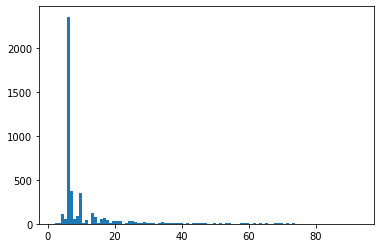

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
9   80196e6999ce63cf.jpg     90     55532
13  8020ee1f3f7781da.jpg     52      2498
21  802a75e51eda5c67.jpg      9      5388
28  802bd28ddce08fbd.jpg      6     25918
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 8847, Labels: 3643, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 119.55, Min img per super_class: 2, max img per super_class: 1099
Len split1: 67968
Len split2: 9365
(len split1) / (len split2): 7.25766150560598
Len split1: 65354
Len split2: 11979
(len split1) / (len split2): 5.455714166457968
Len split1: 72093
Len split2: 5240
(len split1) / (len split2): 13.75820610687023
Len split1: 70300
Le

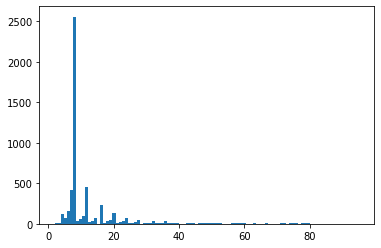

5161
second thresh =  4300
Len split1: 55380
Len split2: 10871
(len split1) / (len split2): 5.094287554042866
len(s1) / len(s2) = 5.094287554042866
Len split1: 55507
Len split2: 10744
(len split1) / (len split2): 5.16632539091586
len(s1) / len(s2) = 5.16632539091586
Len split1: 55449
Len split2: 10802
(len split1) / (len split2): 5.133216071097944
len(s1) / len(s2) = 5.133216071097944
Len split1: 54964
Len split2: 11287
(len split1) / (len split2): 4.8696730752192785
len(s1) / len(s2) = 4.8696730752192785
Len split1: 55382
Len split2: 10869
(len split1) / (len split2): 5.095408961265986
len(s1) / len(s2) = 5.095408961265986
Len split1: 55166
Len split2: 11085
(len split1) / (len split2): 4.976635092467298
len(s1) / len(s2) = 4.976635092467298

Images: 55166, Labels: 4300, Super_labels: 75
Avg img per class: 12.83, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.55, Min img per super_class: 8, max img per super_class: 6844
*********

Images: 11085, Labels: 861, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8918, Labels: 3642, Super_labels: 73
Avg img per class: 2.45, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.16, Min img per super_class: 2, max img per super_class: 1146
*****

Images: 46248, Labels: 4300, Super_labels: 75
Avg img per class: 10.76, Min img per class: 2, max img per class: 80
Avg img per super_class: 616.64, Min img per super_class: 6, max img per super_class: 5698


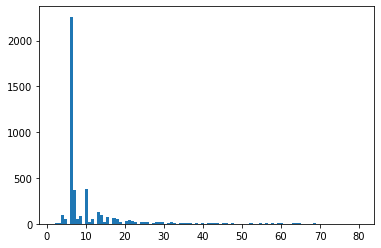

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
26  802b5ed622fd3587.jpg     90     35252
28  802bd28ddce08fbd.jpg      6     25918
39  803570c58f9ba1f7.jpg     87     37779
51  803b5bf6a65459c9.jpg     89      8766
52  803b5ed0d6037b3e.jpg      5     16791
********** TEST 1

Images: 8918, Labels: 3642, Super_labels: 73
Avg img per class: 2.45, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.16, Min img per super_class: 2, max img per super_class: 1146
Len split1: 62904
Len split2: 14429
(len split1) / (len split2): 4.359553676623467
Len split1: 71678
Len split2: 5655
(len split1) / (len split2): 12.675154730327144
Len split1: 67325
Len split2: 10008
(len split1) / (len split2): 6.727118305355716
Len split1: 67965

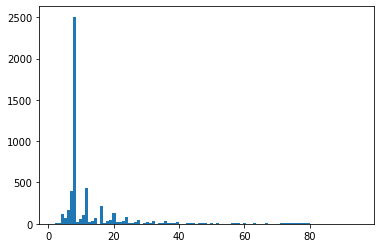

5070
second thresh =  4225
Len split1: 55290
Len split2: 11027
(len split1) / (len split2): 5.014056407000997
len(s1) / len(s2) = 5.014056407000997

Images: 55290, Labels: 4225, Super_labels: 74
Avg img per class: 13.09, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.16, Min img per super_class: 6, max img per super_class: 6792
*********

Images: 11027, Labels: 845, Super_labels: 68
Avg img per class: 13.05, Min img per class: 2, max img per class: 86
Avg img per super_class: 162.16, Min img per super_class: 7, max img per super_class: 1365

Images: 55290, Labels: 4225, Super_labels: 74
Avg img per class: 13.09, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.16, Min img per super_class: 6, max img per super_class: 6792
********** TEST 2

Images: 11027, Labels: 845, Super_labels: 68
Avg img per class: 13.05, Min img per class: 2, max img per class: 86
Avg img per super_class: 162.16, Min img per super_class: 7, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8819, Labels: 3563, Super_labels: 73
Avg img per class: 2.48, Min img per class: 2, max img per class: 18
Avg img per super_class: 120.81, Min img per super_class: 2, max img per super_class: 1133
*****

Images: 46471, Labels: 4225, Super_labels: 74
Avg img per class: 11.0, Min img per class: 2, max img per class: 90
Avg img per super_class: 627.99, Min img per super_class: 6, max img per super_class: 5659


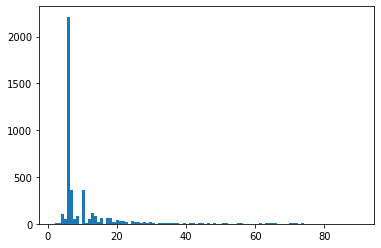

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
11  801aff45ebd0bcd0.jpg     78     26666
19  802a2be985975e5f.jpg     83     21874
29  802beb5ad6256d35.jpg      3     26810
31  802ddd0a3f70a9f5.jpg     87     18450
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 8819, Labels: 3563, Super_labels: 73
Avg img per class: 2.48, Min img per class: 2, max img per class: 18
Avg img per super_class: 120.81, Min img per super_class: 2, max img per super_class: 1133
Len split1: 70526
Len split2: 6807
(len split1) / (len split2): 10.360805053621272
Len split1: 67064
Len split2: 10269
(len split1) / (len split2): 6.530723536858506
Len split1: 63323
Len split2: 14010
(len split1) / (len split2): 4.519842969307637
Len split1: 59811

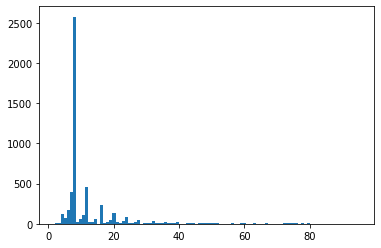

5182
second thresh =  4318
Len split1: 55449
Len split2: 10856
(len split1) / (len split2): 5.107682387619749
len(s1) / len(s2) = 5.107682387619749
Len split1: 55170
Len split2: 11135
(len split1) / (len split2): 4.954647507858105
len(s1) / len(s2) = 4.954647507858105

Images: 55170, Labels: 4318, Super_labels: 75
Avg img per class: 12.78, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.6, Min img per super_class: 8, max img per super_class: 6966
*********

Images: 11135, Labels: 864, Super_labels: 61
Avg img per class: 12.89, Min img per class: 2, max img per class: 92
Avg img per super_class: 182.54, Min img per super_class: 4, max img per super_class: 1191

Images: 55170, Labels: 4318, Super_labels: 75
Avg img per class: 12.78, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.6, Min img per super_class: 8, max img per super_class: 6966
********** TEST 2

Images: 11135, Labels: 864, Super_labels: 61
Avg img per class: 12.89, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8996, Labels: 3648, Super_labels: 74
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.57, Min img per super_class: 2, max img per super_class: 1181
*****

Images: 46174, Labels: 4318, Super_labels: 75
Avg img per class: 10.69, Min img per class: 2, max img per class: 81
Avg img per super_class: 615.65, Min img per super_class: 6, max img per super_class: 5785


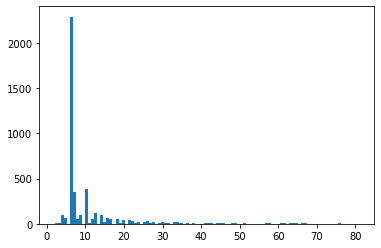

                    image  chain  hotel_id
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
8   8011ffce8971daa3.jpg     87     19657
9   80196e6999ce63cf.jpg     90     55532
12  801f7ce821c7dfd0.jpg     89     27809
20  802a5f42fdf0ab95.jpg     89     43666
49  803abbf5482e3b93.jpg     87      5210
********** TEST 1

Images: 8996, Labels: 3648, Super_labels: 74
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.57, Min img per super_class: 2, max img per super_class: 1181
Len split1: 66111
Len split2: 11222
(len split1) / (len split2): 5.891195865264659
Len split1: 69803
Len split2: 7530
(len split1) / (len split2): 9.269986719787516
Len split1: 60436
Len split2: 16897
(len split1) / (len split2): 3.5767295969698765
Len split1: 66597

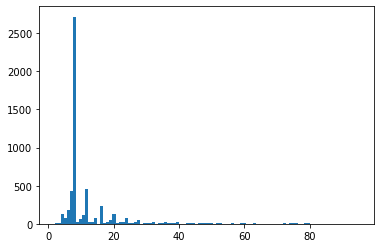

5357
second thresh =  4464
Len split1: 55427
Len split2: 10832
(len split1) / (len split2): 5.116968242245199
len(s1) / len(s2) = 5.116968242245199
Len split1: 54678
Len split2: 11581
(len split1) / (len split2): 4.721353941801226
len(s1) / len(s2) = 4.721353941801226
Len split1: 54989
Len split2: 11270
(len split1) / (len split2): 4.879236912156167
len(s1) / len(s2) = 4.879236912156167
Len split1: 55178
Len split2: 11081
(len split1) / (len split2): 4.979514484252324
len(s1) / len(s2) = 4.979514484252324

Images: 55178, Labels: 4464, Super_labels: 74
Avg img per class: 12.36, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.65, Min img per super_class: 8, max img per super_class: 6865
*********

Images: 11081, Labels: 893, Super_labels: 64
Avg img per class: 12.41, Min img per class: 2, max img per class: 80
Avg img per super_class: 173.14, Min img per super_class: 8, max img per super_class: 1292

Images: 55178, Labels: 4464, Super_labels: 74
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9074, Labels: 3775, Super_labels: 74
Avg img per class: 2.4, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.62, Min img per super_class: 2, max img per super_class: 1178
*****

Images: 46104, Labels: 4464, Super_labels: 74
Avg img per class: 10.33, Min img per class: 2, max img per class: 91
Avg img per super_class: 623.03, Min img per super_class: 6, max img per super_class: 5687


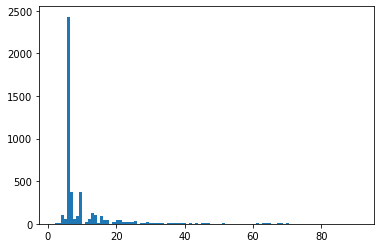

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
5   800a7ffa85c57a3a.jpg      3     25583
12  801f7ce821c7dfd0.jpg     89     27809
17  80296afd55d516ea.jpg      5     44677
27  802b7e9095d5fe2a.jpg      5     21723
********** TEST 1

Images: 9074, Labels: 3775, Super_labels: 74
Avg img per class: 2.4, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.62, Min img per super_class: 2, max img per super_class: 1178
Len split1: 65899
Len split2: 11434
(len split1) / (len split2): 5.763424873185237
Len split1: 57095
Len split2: 20238
(len split1) / (len split2): 2.821177982014033
Len split1: 53142
Len split2: 24191
(len split1) / (len split2): 2.196767392832045
Len split1: 67160


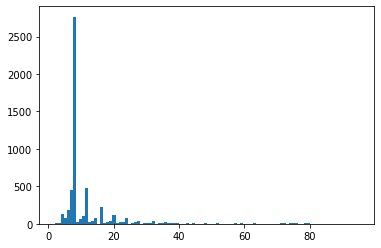

5414
second thresh =  4511
Len split1: 55515
Len split2: 10803
(len split1) / (len split2): 5.138850319355734
len(s1) / len(s2) = 5.138850319355734
Len split1: 55587
Len split2: 10731
(len split1) / (len split2): 5.180039138943249
len(s1) / len(s2) = 5.180039138943249
Len split1: 55154
Len split2: 11164
(len split1) / (len split2): 4.94034396273737
len(s1) / len(s2) = 4.94034396273737
Len split1: 55431
Len split2: 10887
(len split1) / (len split2): 5.091485257646735
len(s1) / len(s2) = 5.091485257646735
Len split1: 55768
Len split2: 10550
(len split1) / (len split2): 5.2860663507109
len(s1) / len(s2) = 5.2860663507109
Len split1: 54149
Len split2: 12169
(len split1) / (len split2): 4.449749363135837
len(s1) / len(s2) = 4.449749363135837
Len split1: 55254
Len split2: 11064
(len split1) / (len split2): 4.9940347071583515
len(s1) / len(s2) = 4.9940347071583515

Images: 55254, Labels: 4511, Super_labels: 73
Avg img per class: 12.25, Min img per class: 2, max img per class: 95
Avg img per s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9054, Labels: 3795, Super_labels: 72
Avg img per class: 2.39, Min img per class: 2, max img per class: 15
Avg img per super_class: 125.75, Min img per super_class: 2, max img per super_class: 1174
*****

Images: 46200, Labels: 4511, Super_labels: 73
Avg img per class: 10.24, Min img per class: 2, max img per class: 91
Avg img per super_class: 632.88, Min img per super_class: 6, max img per super_class: 5883


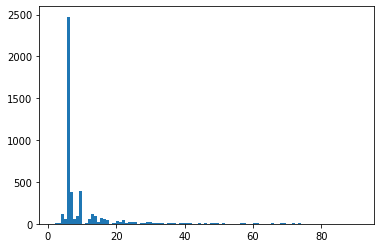

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
31  802ddd0a3f70a9f5.jpg     87     18450
49  803abbf5482e3b93.jpg     87      5210
52  803b5ed0d6037b3e.jpg      5     16791
77  803f78814d9f3a97.jpg     89     23762
92  803fe881d7dea135.jpg     73     14263
********** TEST 1

Images: 9054, Labels: 3795, Super_labels: 72
Avg img per class: 2.39, Min img per class: 2, max img per class: 15
Avg img per super_class: 125.75, Min img per super_class: 2, max img per super_class: 1174
Len split1: 62869
Len split2: 14464
(len split1) / (len split2): 4.346584623893805
Len split1: 64589
Len split2: 12744
(len split1) / (len split2): 5.068188951663528
Len split1: 62941
Len split2: 14392
(len split1) / (len split2): 4.373332406892718
Len split1: 66971

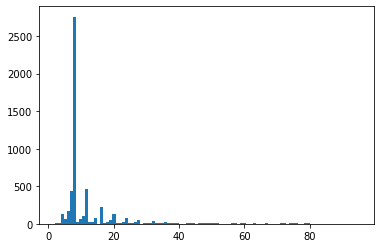

5384
second thresh =  4486
Len split1: 55163
Len split2: 11093
(len split1) / (len split2): 4.972775624267556
len(s1) / len(s2) = 4.972775624267556

Images: 55163, Labels: 4486, Super_labels: 74
Avg img per class: 12.3, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.45, Min img per super_class: 8, max img per super_class: 6847
*********

Images: 11093, Labels: 898, Super_labels: 65
Avg img per class: 12.35, Min img per class: 2, max img per class: 78
Avg img per super_class: 170.66, Min img per super_class: 7, max img per super_class: 1310

Images: 55163, Labels: 4486, Super_labels: 74
Avg img per class: 12.3, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.45, Min img per super_class: 8, max img per super_class: 6847
********** TEST 2

Images: 11093, Labels: 898, Super_labels: 65
Avg img per class: 12.35, Min img per class: 2, max img per class: 78
Avg img per super_class: 170.66, Min img per super_class: 7, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9127, Labels: 3796, Super_labels: 74
Avg img per class: 2.4, Min img per class: 2, max img per class: 16
Avg img per super_class: 123.34, Min img per super_class: 2, max img per super_class: 1164
*****

Images: 46036, Labels: 4486, Super_labels: 74
Avg img per class: 10.26, Min img per class: 2, max img per class: 88
Avg img per super_class: 622.11, Min img per super_class: 6, max img per super_class: 5683


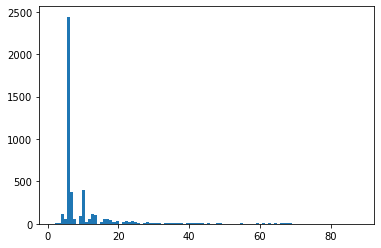

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
23  802aab95d62b7daa.jpg      6     33712
44  803733bb5bc92c17.jpg      8     53692
47  8039c6e66bb6e329.jpg      6      9828
52  803b5ed0d6037b3e.jpg      5     16791
********** TEST 1

Images: 9127, Labels: 3796, Super_labels: 74
Avg img per class: 2.4, Min img per class: 2, max img per class: 16
Avg img per super_class: 123.34, Min img per super_class: 2, max img per super_class: 1164
Len split1: 55715
Len split2: 21618
(len split1) / (len split2): 2.5772504394486075
Len split1: 63856
Len split2: 13477
(len split1) / (len split2): 4.738146471766713
Len split1: 70967
Len split2: 6366
(len split1) / (len split2): 11.147816525290606
Len split1: 64805
Len s

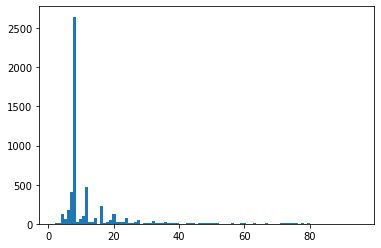

5252
second thresh =  4376
Len split1: 55098
Len split2: 11175
(len split1) / (len split2): 4.930469798657718
len(s1) / len(s2) = 4.930469798657718
Len split1: 55042
Len split2: 11231
(len split1) / (len split2): 4.900899296589796
len(s1) / len(s2) = 4.900899296589796
Len split1: 54909
Len split2: 11364
(len split1) / (len split2): 4.831837381203801
len(s1) / len(s2) = 4.831837381203801
Len split1: 54984
Len split2: 11289
(len split1) / (len split2): 4.870581982460803
len(s1) / len(s2) = 4.870581982460803
Len split1: 55366
Len split2: 10907
(len split1) / (len split2): 5.076189603007243
len(s1) / len(s2) = 5.076189603007243
Len split1: 54792
Len split2: 11481
(len split1) / (len split2): 4.772406584792265
len(s1) / len(s2) = 4.772406584792265
Len split1: 55734
Len split2: 10539
(len split1) / (len split2): 5.2883575291773415
len(s1) / len(s2) = 5.2883575291773415
Len split1: 55422
Len split2: 10851
(len split1) / (len split2): 5.107547691457008
len(s1) / len(s2) = 5.107547691457008
Len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9025, Labels: 3710, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.96, Min img per super_class: 2, max img per super_class: 1128
*****

Images: 46285, Labels: 4376, Super_labels: 75
Avg img per class: 10.58, Min img per class: 2, max img per class: 89
Avg img per super_class: 617.13, Min img per super_class: 6, max img per super_class: 5427


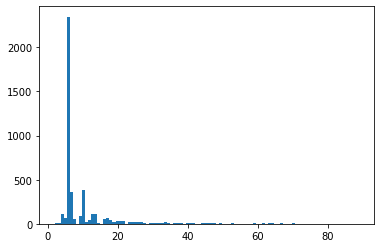

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
11  801aff45ebd0bcd0.jpg     78     26666
27  802b7e9095d5fe2a.jpg      5     21723
40  8035ee81817f7f68.jpg      3     22338
53  803be117a845fe9d.jpg     90     61942
********** TEST 1

Images: 9025, Labels: 3710, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.96, Min img per super_class: 2, max img per super_class: 1128
Len split1: 75269
Len split2: 2064
(len split1) / (len split2): 36.46753875968992
Len split1: 61482
Len split2: 15851
(len split1) / (len split2): 3.878745820452968
Len split1: 61797
Len split2: 15536
(len split1) / (len split2): 3.977664778578785
Len split1: 68315


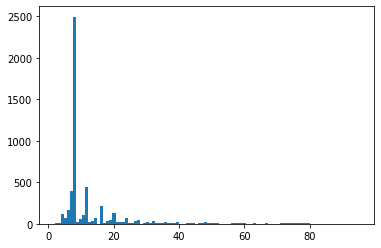

5069
second thresh =  4224
Len split1: 55629
Len split2: 10715
(len split1) / (len split2): 5.191693887074195
len(s1) / len(s2) = 5.191693887074195
Len split1: 55268
Len split2: 11076
(len split1) / (len split2): 4.989888046226074
len(s1) / len(s2) = 4.989888046226074

Images: 55268, Labels: 4224, Super_labels: 73
Avg img per class: 13.08, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.1, Min img per super_class: 6, max img per super_class: 6783
*********

Images: 11076, Labels: 845, Super_labels: 63
Avg img per class: 13.11, Min img per class: 2, max img per class: 92
Avg img per super_class: 175.81, Min img per super_class: 7, max img per super_class: 1374

Images: 55268, Labels: 4224, Super_labels: 73
Avg img per class: 13.08, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.1, Min img per super_class: 6, max img per super_class: 6783
********** TEST 2

Images: 11076, Labels: 845, Super_labels: 63
Avg img per class: 13.11, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8858, Labels: 3557, Super_labels: 72
Avg img per class: 2.49, Min img per class: 2, max img per class: 17
Avg img per super_class: 123.03, Min img per super_class: 2, max img per super_class: 1187
*****

Images: 46410, Labels: 4224, Super_labels: 73
Avg img per class: 10.99, Min img per class: 2, max img per class: 92
Avg img per super_class: 635.75, Min img per super_class: 6, max img per super_class: 5596


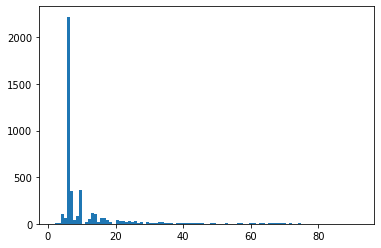

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
224  807f2da4363a8fc5.jpg     44      5002
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
26  802b5ed622fd3587.jpg     90     35252
28  802bd28ddce08fbd.jpg      6     25918
34  802f7fd0d42f2cca.jpg      6     32426
65  803eec8557fb2895.jpg      4     17623
********** TEST 1

Images: 8858, Labels: 3557, Super_labels: 72
Avg img per class: 2.49, Min img per class: 2, max img per class: 17
Avg img per super_class: 123.03, Min img per super_class: 2, max img per super_class: 1187
Len split1: 69435
Len split2: 7898
(len split1) / (len split2): 8.791466193973157
Len split1: 69291
Len split2: 8042
(len split1) / (len split2): 8.616140263616016
Len split1: 69219
Len split2: 8114
(len split1) / (len split2): 8.530810944047326
Len split1: 64346
Le

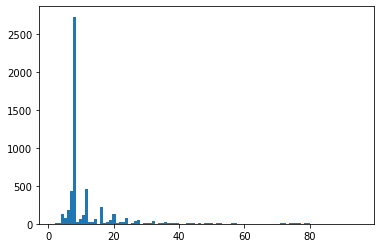

5362
second thresh =  4468
Len split1: 55367
Len split2: 10982
(len split1) / (len split2): 5.041613549444546
len(s1) / len(s2) = 5.041613549444546

Images: 55367, Labels: 4468, Super_labels: 74
Avg img per class: 12.39, Min img per class: 2, max img per class: 95
Avg img per super_class: 748.2, Min img per super_class: 8, max img per super_class: 6596
*********

Images: 10982, Labels: 894, Super_labels: 60
Avg img per class: 12.28, Min img per class: 3, max img per class: 95
Avg img per super_class: 183.03, Min img per super_class: 3, max img per super_class: 1561

Images: 55367, Labels: 4468, Super_labels: 74
Avg img per class: 12.39, Min img per class: 2, max img per class: 95
Avg img per super_class: 748.2, Min img per super_class: 8, max img per super_class: 6596
********** TEST 2

Images: 10982, Labels: 894, Super_labels: 60
Avg img per class: 12.28, Min img per class: 3, max img per class: 95
Avg img per super_class: 183.03, Min img per super_class: 3, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9121, Labels: 3764, Super_labels: 73
Avg img per class: 2.42, Min img per class: 2, max img per class: 19
Avg img per super_class: 124.95, Min img per super_class: 2, max img per super_class: 1120
*****

Images: 46246, Labels: 4468, Super_labels: 74
Avg img per class: 10.35, Min img per class: 2, max img per class: 81
Avg img per super_class: 624.95, Min img per super_class: 6, max img per super_class: 5476


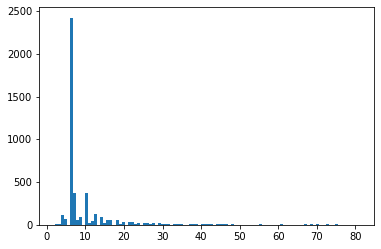

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
2   80053befc2d42fba.jpg      3       672
3   8007fa0a8fe89f9d.jpg      5     63866
12  801f7ce821c7dfd0.jpg     89     27809
17  80296afd55d516ea.jpg      5     44677
********** TEST 1

Images: 9121, Labels: 3764, Super_labels: 73
Avg img per class: 2.42, Min img per class: 2, max img per class: 19
Avg img per super_class: 124.95, Min img per super_class: 2, max img per super_class: 1120
Len split1: 69210
Len split2: 8123
(len split1) / (len split2): 8.520251138741845
Len split1: 63974
Len split2: 13359
(len split1) / (len split2): 4.788831499363725
Len split1: 65128
Len split2: 12205
(len split1) / (len split2): 5.336173699303564
Len split1: 72777


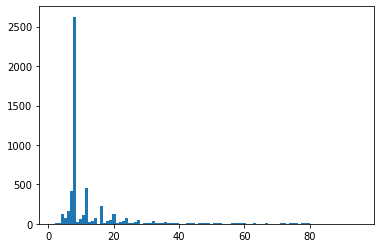

5227
second thresh =  4355
Len split1: 55109
Len split2: 11233
(len split1) / (len split2): 4.90599127570551
len(s1) / len(s2) = 4.90599127570551
Len split1: 55331
Len split2: 11011
(len split1) / (len split2): 5.025065843247662
len(s1) / len(s2) = 5.025065843247662

Images: 55331, Labels: 4355, Super_labels: 74
Avg img per class: 12.71, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.72, Min img per super_class: 8, max img per super_class: 7158
*********

Images: 11011, Labels: 872, Super_labels: 59
Avg img per class: 12.63, Min img per class: 2, max img per class: 95
Avg img per super_class: 186.63, Min img per super_class: 5, max img per super_class: 1184

Images: 55331, Labels: 4355, Super_labels: 74
Avg img per class: 12.71, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.72, Min img per super_class: 8, max img per super_class: 7158
********** TEST 2

Images: 11011, Labels: 872, Super_labels: 59
Avg img per class: 12.63, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9000, Labels: 3693, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 17
Avg img per super_class: 123.29, Min img per super_class: 2, max img per super_class: 1183
*****

Images: 46331, Labels: 4355, Super_labels: 74
Avg img per class: 10.64, Min img per class: 2, max img per class: 86
Avg img per super_class: 626.09, Min img per super_class: 6, max img per super_class: 5975


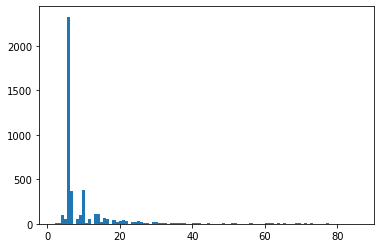

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
9   80196e6999ce63cf.jpg     90     55532
12  801f7ce821c7dfd0.jpg     89     27809
19  802a2be985975e5f.jpg     83     21874
********** TEST 1

Images: 9000, Labels: 3693, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 17
Avg img per super_class: 123.29, Min img per super_class: 2, max img per super_class: 1183
Len split1: 55613
Len split2: 21720
(len split1) / (len split2): 2.560451197053407
Len split1: 67842
Len split2: 9491
(len split1) / (len split2): 7.148034980507849
Len split1: 72041
Len split2: 5292
(len split1) / (len split2): 13.613189720332578
Len split1: 65977


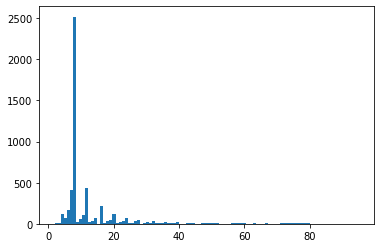

5100
second thresh =  4250
Len split1: 54878
Len split2: 11389
(len split1) / (len split2): 4.818509087716217
len(s1) / len(s2) = 4.818509087716217
Len split1: 54890
Len split2: 11377
(len split1) / (len split2): 4.824646216049925
len(s1) / len(s2) = 4.824646216049925
Len split1: 54914
Len split2: 11353
(len split1) / (len split2): 4.836959393992777
len(s1) / len(s2) = 4.836959393992777
Len split1: 55197
Len split2: 11070
(len split1) / (len split2): 4.986178861788618
len(s1) / len(s2) = 4.986178861788618

Images: 55197, Labels: 4250, Super_labels: 73
Avg img per class: 12.99, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.12, Min img per super_class: 8, max img per super_class: 6815
*********

Images: 11070, Labels: 850, Super_labels: 65
Avg img per class: 13.02, Min img per class: 2, max img per class: 95
Avg img per super_class: 170.31, Min img per super_class: 7, max img per super_class: 1342

Images: 55197, Labels: 4250, Super_labels: 73
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8782, Labels: 3575, Super_labels: 72
Avg img per class: 2.46, Min img per class: 2, max img per class: 18
Avg img per super_class: 121.97, Min img per super_class: 2, max img per super_class: 1131
*****

Images: 46415, Labels: 4250, Super_labels: 73
Avg img per class: 10.92, Min img per class: 2, max img per class: 89
Avg img per super_class: 635.82, Min img per super_class: 6, max img per super_class: 5684


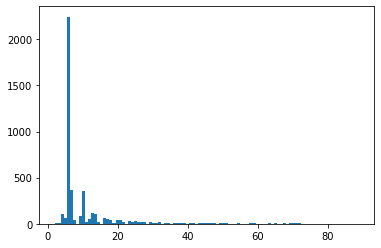

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
1   8000febe81817f7f.jpg      6     25389
29  802beb5ad6256d35.jpg      3     26810
31  802ddd0a3f70a9f5.jpg     87     18450
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 8782, Labels: 3575, Super_labels: 72
Avg img per class: 2.46, Min img per class: 2, max img per class: 18
Avg img per super_class: 121.97, Min img per super_class: 2, max img per super_class: 1131
Len split1: 70451
Len split2: 6882
(len split1) / (len split2): 10.236995059575705
Len split1: 70801
Len split2: 6532
(len split1) / (len split2): 10.839099816289039
Len split1: 68083
Len split2: 9250
(len split1) / (len split2): 7.360324324324324
Len split1: 62349


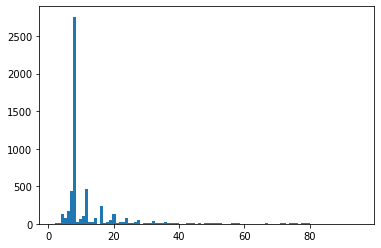

5399
second thresh =  4499
Len split1: 55046
Len split2: 11290
(len split1) / (len split2): 4.875642161204606
len(s1) / len(s2) = 4.875642161204606
Len split1: 54867
Len split2: 11469
(len split1) / (len split2): 4.783939314674339
len(s1) / len(s2) = 4.783939314674339
Len split1: 55517
Len split2: 10819
(len split1) / (len split2): 5.131435437655975
len(s1) / len(s2) = 5.131435437655975
Len split1: 55153
Len split2: 11183
(len split1) / (len split2): 4.931860860234284
len(s1) / len(s2) = 4.931860860234284
Len split1: 55745
Len split2: 10591
(len split1) / (len split2): 5.2634312151827025
len(s1) / len(s2) = 5.2634312151827025
Len split1: 54939
Len split2: 11397
(len split1) / (len split2): 4.820479073440379
len(s1) / len(s2) = 4.820479073440379
Len split1: 55168
Len split2: 11168
(len split1) / (len split2): 4.939828080229226
len(s1) / len(s2) = 4.939828080229226
Len split1: 55410
Len split2: 10926
(len split1) / (len split2): 5.071389346512905
len(s1) / len(s2) = 5.071389346512905
Len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9077, Labels: 3784, Super_labels: 73
Avg img per class: 2.4, Min img per class: 2, max img per class: 18
Avg img per super_class: 124.34, Min img per super_class: 2, max img per super_class: 1106
*****

Images: 46163, Labels: 4499, Super_labels: 74
Avg img per class: 10.26, Min img per class: 2, max img per class: 81
Avg img per super_class: 623.82, Min img per super_class: 6, max img per super_class: 5606


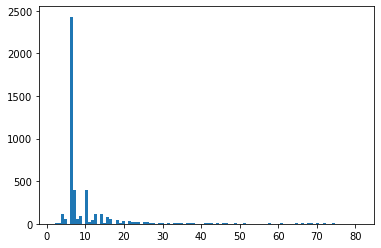

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
9   80196e6999ce63cf.jpg     90     55532
27  802b7e9095d5fe2a.jpg      5     21723
35  802f7ff490819fc9.jpg     87      5697
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 9077, Labels: 3784, Super_labels: 73
Avg img per class: 2.4, Min img per class: 2, max img per class: 18
Avg img per super_class: 124.34, Min img per super_class: 2, max img per super_class: 1106
Len split1: 69258
Len split2: 8075
(len split1) / (len split2): 8.576842105263157
Len split1: 66560
Len split2: 10773
(len split1) / (len split2): 6.178408985426529
Len split1: 64642
Len split2: 12691
(len split1) / (len split2): 5.09353084863289
Len split1: 69234
Len spli

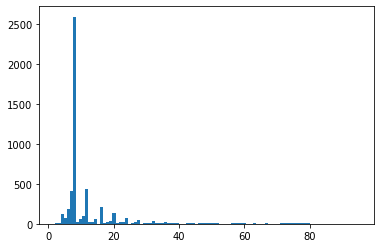

5170
second thresh =  4308
Len split1: 55215
Len split2: 11009
(len split1) / (len split2): 5.0154419111635935
len(s1) / len(s2) = 5.0154419111635935

Images: 55215, Labels: 4308, Super_labels: 74
Avg img per class: 12.82, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.15, Min img per super_class: 8, max img per super_class: 6527
*********

Images: 11009, Labels: 862, Super_labels: 59
Avg img per class: 12.77, Min img per class: 2, max img per class: 95
Avg img per super_class: 186.59, Min img per super_class: 4, max img per super_class: 1630

Images: 55215, Labels: 4308, Super_labels: 74
Avg img per class: 12.82, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.15, Min img per super_class: 8, max img per super_class: 6527
********** TEST 2

Images: 11009, Labels: 862, Super_labels: 59
Avg img per class: 12.77, Min img per class: 2, max img per class: 95
Avg img per super_class: 186.59, Min img per super_class: 4, max img per super_clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8823, Labels: 3620, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 15
Avg img per super_class: 120.86, Min img per super_class: 2, max img per super_class: 1104
*****

Images: 46392, Labels: 4308, Super_labels: 74
Avg img per class: 10.77, Min img per class: 2, max img per class: 85
Avg img per super_class: 626.92, Min img per super_class: 6, max img per super_class: 5423


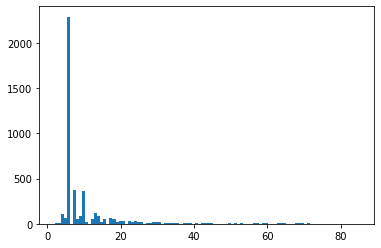

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
23  802aab95d62b7daa.jpg      6     33712
44  803733bb5bc92c17.jpg      8     53692
50  803aff8f12e0519f.jpg     68     63331
59  803e5f0fe8e00f75.jpg     90     20762
********** TEST 1

Images: 8823, Labels: 3620, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 15
Avg img per super_class: 120.86, Min img per super_class: 2, max img per super_class: 1104
Len split1: 69933
Len split2: 7400
(len split1) / (len split2): 9.450405405405405
Len split1: 65360
Len split2: 11973
(len split1) / (len split2): 5.458949302597511
Len split1: 64792
Len split2: 12541
(len split1) / (len split2): 5.166414161550116
Len split1: 68960


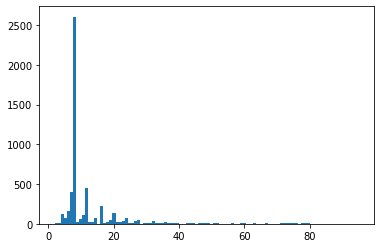

5195
second thresh =  4329
Len split1: 55146
Len split2: 11062
(len split1) / (len split2): 4.985174471162538
len(s1) / len(s2) = 4.985174471162538

Images: 55146, Labels: 4329, Super_labels: 74
Avg img per class: 12.74, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.22, Min img per super_class: 8, max img per super_class: 6655
*********

Images: 11062, Labels: 866, Super_labels: 58
Avg img per class: 12.77, Min img per class: 3, max img per class: 92
Avg img per super_class: 190.72, Min img per super_class: 8, max img per super_class: 1502

Images: 55146, Labels: 4329, Super_labels: 74
Avg img per class: 12.74, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.22, Min img per super_class: 8, max img per super_class: 6655
********** TEST 2

Images: 11062, Labels: 866, Super_labels: 58
Avg img per class: 12.77, Min img per class: 3, max img per class: 92
Avg img per super_class: 190.72, Min img per super_class: 8, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8897, Labels: 3654, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 16
Avg img per super_class: 120.23, Min img per super_class: 2, max img per super_class: 1144
*****

Images: 46249, Labels: 4329, Super_labels: 74
Avg img per class: 10.68, Min img per class: 2, max img per class: 82
Avg img per super_class: 624.99, Min img per super_class: 6, max img per super_class: 5511


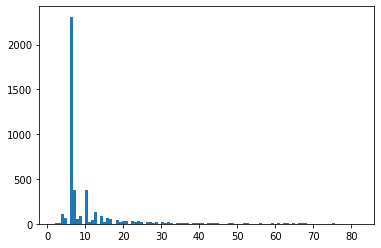

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
20  802a5f42fdf0ab95.jpg     89     43666
26  802b5ed622fd3587.jpg     90     35252
28  802bd28ddce08fbd.jpg      6     25918
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 8897, Labels: 3654, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 16
Avg img per super_class: 120.23, Min img per super_class: 2, max img per super_class: 1144
Len split1: 69945
Len split2: 7388
(len split1) / (len split2): 9.467379534380076
Len split1: 61689
Len split2: 15644
(len split1) / (len split2): 3.943300946049604
Len split1: 67437
Len split2: 9896
(len split1) / (len split2): 6.8145715440582055
Len split1: 70654


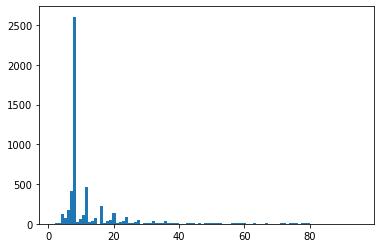

5214
second thresh =  4345
Len split1: 54680
Len split2: 11561
(len split1) / (len split2): 4.729694663091428
len(s1) / len(s2) = 4.729694663091428
Len split1: 54639
Len split2: 11602
(len split1) / (len split2): 4.7094466471298055
len(s1) / len(s2) = 4.7094466471298055
Len split1: 54698
Len split2: 11543
(len split1) / (len split2): 4.73862947240752
len(s1) / len(s2) = 4.73862947240752
Len split1: 55393
Len split2: 10848
(len split1) / (len split2): 5.106286873156342
len(s1) / len(s2) = 5.106286873156342
Len split1: 55119
Len split2: 11122
(len split1) / (len split2): 4.955853263801474
len(s1) / len(s2) = 4.955853263801474

Images: 55119, Labels: 4345, Super_labels: 73
Avg img per class: 12.69, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.05, Min img per super_class: 8, max img per super_class: 6707
*********

Images: 11122, Labels: 869, Super_labels: 62
Avg img per class: 12.8, Min img per class: 2, max img per class: 81
Avg img per super_class: 179.39, Mi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8949, Labels: 3681, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.59, Min img per super_class: 2, max img per super_class: 1143
*****

Images: 46170, Labels: 4345, Super_labels: 73
Avg img per class: 10.63, Min img per class: 2, max img per class: 81
Avg img per super_class: 632.47, Min img per super_class: 6, max img per super_class: 5564


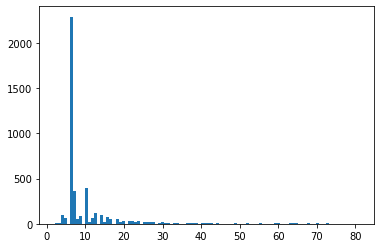

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
11  801aff45ebd0bcd0.jpg     78     26666
22  802a7af055d739e9.jpg     50     45049
50  803aff8f12e0519f.jpg     68     63331
61  803e7b9595fa2a25.jpg      6     15263
********** TEST 1

Images: 8949, Labels: 3681, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.59, Min img per super_class: 2, max img per super_class: 1143
Len split1: 63602
Len split2: 13731
(len split1) / (len split2): 4.632000582623261
Len split1: 67772
Len split2: 9561
(len split1) / (len split2): 7.088379876581947
Len split1: 60514
Len split2: 16819
(len split1) / (len split2): 3.597954694095963
Len split1: 70638
Len sp

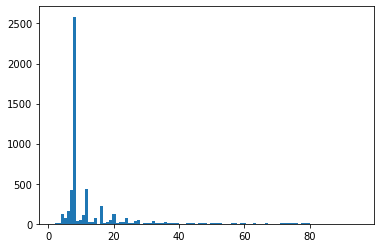

5159
second thresh =  4299
Len split1: 54933
Len split2: 11344
(len split1) / (len split2): 4.8424717912552895
len(s1) / len(s2) = 4.8424717912552895
Len split1: 55464
Len split2: 10813
(len split1) / (len split2): 5.129381300286692
len(s1) / len(s2) = 5.129381300286692
Len split1: 55167
Len split2: 11110
(len split1) / (len split2): 4.965526552655265
len(s1) / len(s2) = 4.965526552655265

Images: 55167, Labels: 4299, Super_labels: 74
Avg img per class: 12.83, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.5, Min img per super_class: 8, max img per super_class: 6789
*********

Images: 11110, Labels: 860, Super_labels: 61
Avg img per class: 12.92, Min img per class: 2, max img per class: 95
Avg img per super_class: 182.13, Min img per super_class: 2, max img per super_class: 1368

Images: 55167, Labels: 4299, Super_labels: 74
Avg img per class: 12.83, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.5, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8965, Labels: 3630, Super_labels: 73
Avg img per class: 2.47, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.81, Min img per super_class: 2, max img per super_class: 1159
*****

Images: 46202, Labels: 4299, Super_labels: 74
Avg img per class: 10.75, Min img per class: 2, max img per class: 86
Avg img per super_class: 624.35, Min img per super_class: 6, max img per super_class: 5630


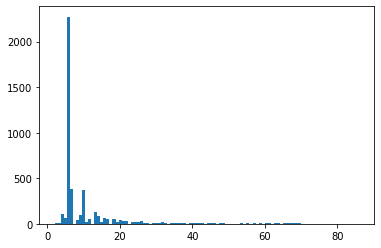

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
7   800e7dd55ffa4056.jpg      2     60181
34  802f7fd0d42f2cca.jpg      6     32426
44  803733bb5bc92c17.jpg      8     53692
61  803e7b9595fa2a25.jpg      6     15263
64  803edda1d29625eb.jpg      4     24695
********** TEST 1

Images: 8965, Labels: 3630, Super_labels: 73
Avg img per class: 2.47, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.81, Min img per super_class: 2, max img per super_class: 1159
Len split1: 60505
Len split2: 16828
(len split1) / (len split2): 3.59549560256715
Len split1: 73324
Len split2: 4009
(len split1) / (len split2): 18.289847842354703
Len split1: 55190
Len split2: 22143
(len split1) / (len split2): 2.4924355326739827
Len split1: 61214

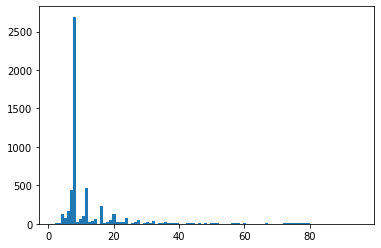

5324
second thresh =  4436
Len split1: 54620
Len split2: 11638
(len split1) / (len split2): 4.693246262244372
len(s1) / len(s2) = 4.693246262244372
Len split1: 54936
Len split2: 11322
(len split1) / (len split2): 4.85214626391097
len(s1) / len(s2) = 4.85214626391097
Len split1: 55458
Len split2: 10800
(len split1) / (len split2): 5.135
len(s1) / len(s2) = 5.135
Len split1: 55506
Len split2: 10752
(len split1) / (len split2): 5.162388392857143
len(s1) / len(s2) = 5.162388392857143
Len split1: 54846
Len split2: 11412
(len split1) / (len split2): 4.805993690851735
len(s1) / len(s2) = 4.805993690851735
Len split1: 55456
Len split2: 10802
(len split1) / (len split2): 5.133864099240881
len(s1) / len(s2) = 5.133864099240881
Len split1: 55321
Len split2: 10937
(len split1) / (len split2): 5.058151229770504
len(s1) / len(s2) = 5.058151229770504
Len split1: 55203
Len split2: 11055
(len split1) / (len split2): 4.99348710990502
len(s1) / len(s2) = 4.99348710990502

Images: 55203, Labels: 4436, Sup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9025, Labels: 3745, Super_labels: 69
Avg img per class: 2.41, Min img per class: 2, max img per class: 16
Avg img per super_class: 130.8, Min img per super_class: 2, max img per super_class: 1185
*****

Images: 46178, Labels: 4436, Super_labels: 71
Avg img per class: 10.41, Min img per class: 2, max img per class: 91
Avg img per super_class: 650.39, Min img per super_class: 6, max img per super_class: 5735


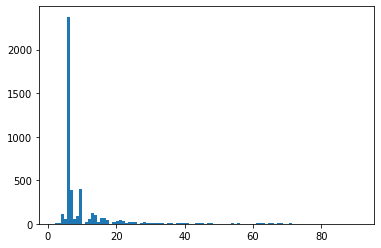

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
7   800e7dd55ffa4056.jpg      2     60181
9   80196e6999ce63cf.jpg     90     55532
12  801f7ce821c7dfd0.jpg     89     27809
17  80296afd55d516ea.jpg      5     44677
30  802beb95d5aac0d7.jpg     78     50595
********** TEST 1

Images: 9025, Labels: 3745, Super_labels: 69
Avg img per class: 2.41, Min img per class: 2, max img per class: 16
Avg img per super_class: 130.8, Min img per super_class: 2, max img per super_class: 1185
Len split1: 68371
Len split2: 8962
(len split1) / (len split2): 7.628989064940861
Len split1: 70595
Len split2: 6738
(len split1) / (len split2): 10.477144553279905
Len split1: 66319
Len split2: 11014
(len split1) / (len split2): 6.021336480842564

Images: 66319, Lab

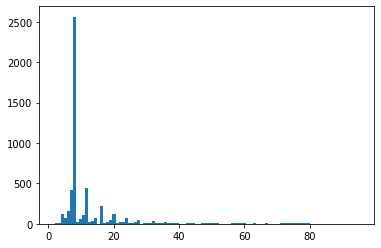

5142
second thresh =  4285
Len split1: 54862
Len split2: 11457
(len split1) / (len split2): 4.788513572488435
len(s1) / len(s2) = 4.788513572488435
Len split1: 55433
Len split2: 10886
(len split1) / (len split2): 5.09213668932574
len(s1) / len(s2) = 5.09213668932574
Len split1: 54835
Len split2: 11484
(len split1) / (len split2): 4.774904214559387
len(s1) / len(s2) = 4.774904214559387
Len split1: 55600
Len split2: 10719
(len split1) / (len split2): 5.187051030879746
len(s1) / len(s2) = 5.187051030879746
Len split1: 54940
Len split2: 11379
(len split1) / (len split2): 4.828192284031989
len(s1) / len(s2) = 4.828192284031989
Len split1: 55546
Len split2: 10773
(len split1) / (len split2): 5.156038243757542
len(s1) / len(s2) = 5.156038243757542
Len split1: 55311
Len split2: 11008
(len split1) / (len split2): 5.024618459302325
len(s1) / len(s2) = 5.024618459302325

Images: 55311, Labels: 4285, Super_labels: 75
Avg img per class: 12.91, Min img per class: 2, max img per class: 95
Avg img per

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8909, Labels: 3618, Super_labels: 74
Avg img per class: 2.46, Min img per class: 2, max img per class: 16
Avg img per super_class: 120.39, Min img per super_class: 2, max img per super_class: 1235
*****

Images: 46402, Labels: 4285, Super_labels: 75
Avg img per class: 10.83, Min img per class: 2, max img per class: 91
Avg img per super_class: 618.69, Min img per super_class: 6, max img per super_class: 5902


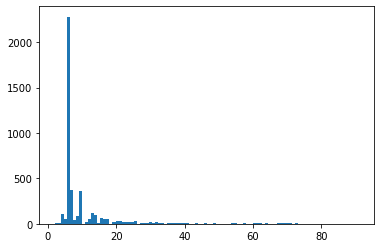

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
34  802f7fd0d42f2cca.jpg      6     32426
40  8035ee81817f7f68.jpg      3     22338
56  803dce35ca659b47.jpg      2     43373
58  803e49f1b398ecd3.jpg      6     37728
68  803f2fb4d2aa3d16.jpg      6     53768
********** TEST 1

Images: 8909, Labels: 3618, Super_labels: 74
Avg img per class: 2.46, Min img per class: 2, max img per class: 16
Avg img per super_class: 120.39, Min img per super_class: 2, max img per super_class: 1235
Len split1: 66384
Len split2: 10949
(len split1) / (len split2): 6.0630194538314
Len split1: 69594
Len split2: 7739
(len split1) / (len split2): 8.992634707326529
Len split1: 61246
Len split2: 16087
(len split1) / (len split2): 3.8071734941256916
Len split1: 64327
L

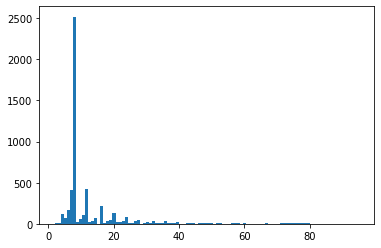

5088
second thresh =  4240
Len split1: 55636
Len split2: 10723
(len split1) / (len split2): 5.188473374988343
len(s1) / len(s2) = 5.188473374988343
Len split1: 55385
Len split2: 10974
(len split1) / (len split2): 5.046929105157646
len(s1) / len(s2) = 5.046929105157646

Images: 55385, Labels: 4240, Super_labels: 73
Avg img per class: 13.06, Min img per class: 2, max img per class: 95
Avg img per super_class: 758.7, Min img per super_class: 7, max img per super_class: 7027
*********

Images: 10974, Labels: 848, Super_labels: 61
Avg img per class: 12.94, Min img per class: 2, max img per class: 83
Avg img per super_class: 179.9, Min img per super_class: 5, max img per super_class: 1130

Images: 55385, Labels: 4240, Super_labels: 73
Avg img per class: 13.06, Min img per class: 2, max img per class: 95
Avg img per super_class: 758.7, Min img per super_class: 7, max img per super_class: 7027
********** TEST 2

Images: 10974, Labels: 848, Super_labels: 61
Avg img per class: 12.94, Min img per

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8980, Labels: 3601, Super_labels: 72
Avg img per class: 2.49, Min img per class: 2, max img per class: 17
Avg img per super_class: 124.72, Min img per super_class: 2, max img per super_class: 1194
*****

Images: 46405, Labels: 4240, Super_labels: 73
Avg img per class: 10.94, Min img per class: 2, max img per class: 86
Avg img per super_class: 635.68, Min img per super_class: 6, max img per super_class: 5833


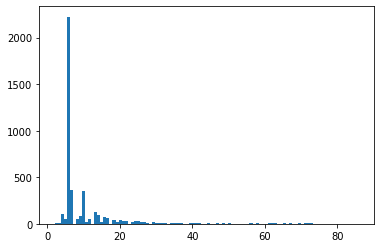

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
44  803733bb5bc92c17.jpg      8     53692
51  803b5bf6a65459c9.jpg     89      8766
55  803d7a43427ff585.jpg     71     17105
58  803e49f1b398ecd3.jpg      6     37728
61  803e7b9595fa2a25.jpg      6     15263
********** TEST 1

Images: 8980, Labels: 3601, Super_labels: 72
Avg img per class: 2.49, Min img per class: 2, max img per class: 17
Avg img per super_class: 124.72, Min img per super_class: 2, max img per super_class: 1194
Len split1: 69803
Len split2: 7530
(len split1) / (len split2): 9.269986719787516
Len split1: 66083
Len split2: 11250
(len split1) / (len split2): 5.874044444444444
Len split1: 65551
Len split2: 11782
(len split1) / (len split2): 5.563656425055169
Len split1: 62633


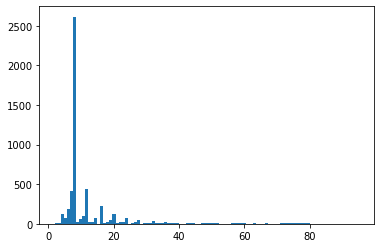

5198
second thresh =  4331
Len split1: 55348
Len split2: 10914
(len split1) / (len split2): 5.071284588601796
len(s1) / len(s2) = 5.071284588601796
Len split1: 55126
Len split2: 11136
(len split1) / (len split2): 4.950251436781609
len(s1) / len(s2) = 4.950251436781609

Images: 55126, Labels: 4331, Super_labels: 74
Avg img per class: 12.73, Min img per class: 2, max img per class: 95
Avg img per super_class: 744.95, Min img per super_class: 8, max img per super_class: 6578
*********

Images: 11136, Labels: 867, Super_labels: 62
Avg img per class: 12.84, Min img per class: 2, max img per class: 87
Avg img per super_class: 179.61, Min img per super_class: 5, max img per super_class: 1579

Images: 55126, Labels: 4331, Super_labels: 74
Avg img per class: 12.73, Min img per class: 2, max img per class: 95
Avg img per super_class: 744.95, Min img per super_class: 8, max img per super_class: 6578
********** TEST 2

Images: 11136, Labels: 867, Super_labels: 62
Avg img per class: 12.84, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9015, Labels: 3656, Super_labels: 72
Avg img per class: 2.47, Min img per class: 2, max img per class: 17
Avg img per super_class: 125.21, Min img per super_class: 2, max img per super_class: 1107
*****

Images: 46111, Labels: 4331, Super_labels: 74
Avg img per class: 10.65, Min img per class: 2, max img per class: 93
Avg img per super_class: 623.12, Min img per super_class: 6, max img per super_class: 5471


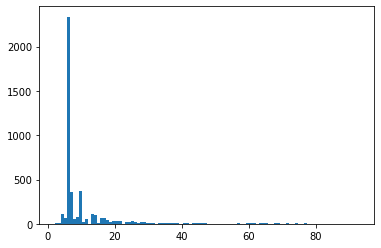

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
7   800e7dd55ffa4056.jpg      2     60181
12  801f7ce821c7dfd0.jpg     89     27809
59  803e5f0fe8e00f75.jpg     90     20762
********** TEST 1

Images: 9015, Labels: 3656, Super_labels: 72
Avg img per class: 2.47, Min img per class: 2, max img per class: 17
Avg img per super_class: 125.21, Min img per super_class: 2, max img per super_class: 1107
Len split1: 63055
Len split2: 14278
(len split1) / (len split2): 4.416234766774058
Len split1: 63194
Len split2: 14139
(len split1) / (len split2): 4.469481575783295
Len split1: 69206
Len split2: 8127
(len split1) / (len split2): 8.515565399286329
Len split1: 66679


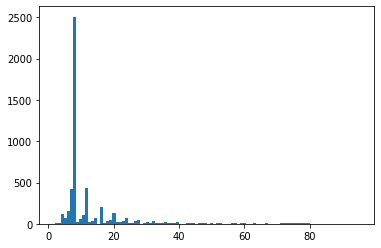

5081
second thresh =  4234
Len split1: 55168
Len split2: 11054
(len split1) / (len split2): 4.990772571015017
len(s1) / len(s2) = 4.990772571015017

Images: 55168, Labels: 4234, Super_labels: 75
Avg img per class: 13.03, Min img per class: 2, max img per class: 87
Avg img per super_class: 735.57, Min img per super_class: 8, max img per super_class: 5347
*********

Images: 11054, Labels: 847, Super_labels: 66
Avg img per class: 13.05, Min img per class: 3, max img per class: 95
Avg img per super_class: 167.48, Min img per super_class: 7, max img per super_class: 1097

Images: 55168, Labels: 4234, Super_labels: 75
Avg img per class: 13.03, Min img per class: 2, max img per class: 87
Avg img per super_class: 735.57, Min img per super_class: 8, max img per super_class: 5347
********** TEST 2

Images: 11054, Labels: 847, Super_labels: 66
Avg img per class: 13.05, Min img per class: 3, max img per class: 95
Avg img per super_class: 167.48, Min img per super_class: 7, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8986, Labels: 3581, Super_labels: 75
Avg img per class: 2.51, Min img per class: 2, max img per class: 15
Avg img per super_class: 119.81, Min img per super_class: 2, max img per super_class: 958
*****

Images: 46182, Labels: 4234, Super_labels: 75
Avg img per class: 10.91, Min img per class: 2, max img per class: 84
Avg img per super_class: 615.76, Min img per super_class: 6, max img per super_class: 4389


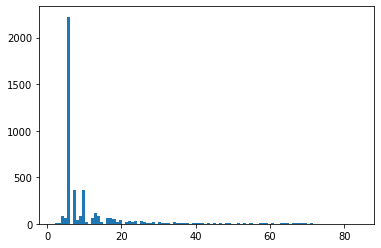

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
31  802ddd0a3f70a9f5.jpg     87     18450
32  802f65855fd85b87.jpg      5     34702
44  803733bb5bc92c17.jpg      8     53692
48  803a7f95384ebc63.jpg     89      1779
55  803d7a43427ff585.jpg     71     17105
********** TEST 1

Images: 8986, Labels: 3581, Super_labels: 75
Avg img per class: 2.51, Min img per class: 2, max img per class: 15
Avg img per super_class: 119.81, Min img per super_class: 2, max img per super_class: 958
Len split1: 67278
Len split2: 10055
(len split1) / (len split2): 6.690999502734957
Len split1: 61024
Len split2: 16309
(len split1) / (len split2): 3.7417376908455453
Len split1: 64044
Len split2: 13289
(len split1) / (len split2): 4.819324253141696
Len split1: 72911

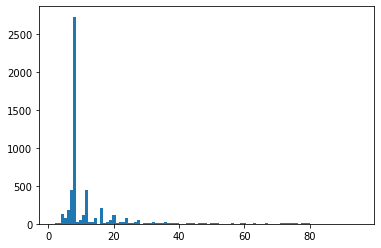

5341
second thresh =  4450
Len split1: 55313
Len split2: 10896
(len split1) / (len split2): 5.076450073421439
len(s1) / len(s2) = 5.076450073421439
Len split1: 54828
Len split2: 11381
(len split1) / (len split2): 4.8175028556365875
len(s1) / len(s2) = 4.8175028556365875
Len split1: 55177
Len split2: 11032
(len split1) / (len split2): 5.0015409717186365
len(s1) / len(s2) = 5.0015409717186365

Images: 55177, Labels: 4450, Super_labels: 74
Avg img per class: 12.4, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.64, Min img per super_class: 7, max img per super_class: 6827
*********

Images: 11032, Labels: 891, Super_labels: 64
Avg img per class: 12.38, Min img per class: 2, max img per class: 87
Avg img per super_class: 172.38, Min img per super_class: 5, max img per super_class: 1330

Images: 55177, Labels: 4450, Super_labels: 74
Avg img per class: 12.4, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.64, Min img per super_class: 7, max i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9101, Labels: 3746, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 124.67, Min img per super_class: 2, max img per super_class: 1149
*****

Images: 46076, Labels: 4450, Super_labels: 74
Avg img per class: 10.35, Min img per class: 2, max img per class: 90
Avg img per super_class: 622.65, Min img per super_class: 6, max img per super_class: 5678


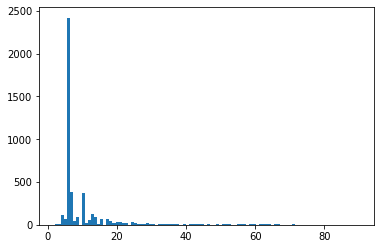

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
21  802a75e51eda5c67.jpg      9      5388
24  802aef94c02bbfd5.jpg      6     62831
26  802b5ed622fd3587.jpg     90     35252
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 9101, Labels: 3746, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 124.67, Min img per super_class: 2, max img per super_class: 1149
Len split1: 65881
Len split2: 11452
(len split1) / (len split2): 5.752794271742927
Len split1: 67856
Len split2: 9477
(len split1) / (len split2): 7.160071752664345
Len split1: 63270
Len split2: 14063
(len split1) / (len split2): 4.49904003413212
Len split1: 71458
L

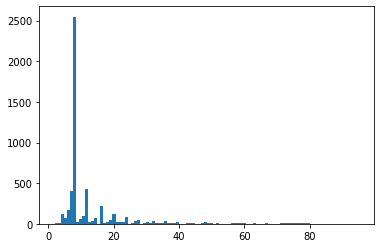

5113
second thresh =  4260
Len split1: 55860
Len split2: 10373
(len split1) / (len split2): 5.3851344837559045
len(s1) / len(s2) = 5.3851344837559045
Len split1: 54626
Len split2: 11607
(len split1) / (len split2): 4.706297923666753
len(s1) / len(s2) = 4.706297923666753
Len split1: 55311
Len split2: 10922
(len split1) / (len split2): 5.0641823841787215
len(s1) / len(s2) = 5.0641823841787215
Len split1: 55654
Len split2: 10579
(len split1) / (len split2): 5.260799697513943
len(s1) / len(s2) = 5.260799697513943
Len split1: 55784
Len split2: 10449
(len split1) / (len split2): 5.338692697865825
len(s1) / len(s2) = 5.338692697865825
Len split1: 55550
Len split2: 10683
(len split1) / (len split2): 5.199850229336329
len(s1) / len(s2) = 5.199850229336329
Len split1: 55380
Len split2: 10853
(len split1) / (len split2): 5.102736570533493
len(s1) / len(s2) = 5.102736570533493
Len split1: 55845
Len split2: 10388
(len split1) / (len split2): 5.375914516750096
len(s1) / len(s2) = 5.375914516750096
L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8896, Labels: 3605, Super_labels: 74
Avg img per class: 2.47, Min img per class: 2, max img per class: 17
Avg img per super_class: 120.22, Min img per super_class: 2, max img per super_class: 1141
*****

Images: 46337, Labels: 4260, Super_labels: 75
Avg img per class: 10.88, Min img per class: 2, max img per class: 90
Avg img per super_class: 617.83, Min img per super_class: 6, max img per super_class: 5509


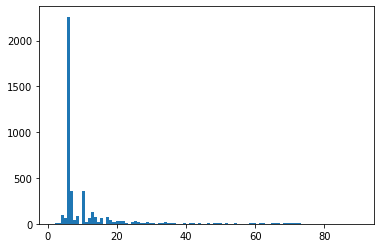

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
12  801f7ce821c7dfd0.jpg     89     27809
34  802f7fd0d42f2cca.jpg      6     32426
48  803a7f95384ebc63.jpg     89      1779
49  803abbf5482e3b93.jpg     87      5210
********** TEST 1

Images: 8896, Labels: 3605, Super_labels: 74
Avg img per class: 2.47, Min img per class: 2, max img per class: 17
Avg img per super_class: 120.22, Min img per super_class: 2, max img per super_class: 1141
Len split1: 63058
Len split2: 14275
(len split1) / (len split2): 4.417373029772329
Len split1: 55597
Len split2: 21736
(len split1) / (len split2): 2.55783032756717
Len split1: 72474
Len split2: 4859
(len split1) / (len split2): 14.91541469438156
Len split1: 68594
L

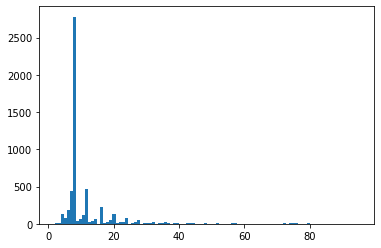

5410
second thresh =  4508
Len split1: 55037
Len split2: 11206
(len split1) / (len split2): 4.911386757094414
len(s1) / len(s2) = 4.911386757094414
Len split1: 55250
Len split2: 10993
(len split1) / (len split2): 5.025925589011189
len(s1) / len(s2) = 5.025925589011189

Images: 55250, Labels: 4508, Super_labels: 75
Avg img per class: 12.26, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.67, Min img per super_class: 6, max img per super_class: 6796
*********

Images: 10993, Labels: 902, Super_labels: 59
Avg img per class: 12.19, Min img per class: 2, max img per class: 86
Avg img per super_class: 186.32, Min img per super_class: 5, max img per super_class: 1361

Images: 55250, Labels: 4508, Super_labels: 75
Avg img per class: 12.26, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.67, Min img per super_class: 6, max img per super_class: 6796
********** TEST 2

Images: 10993, Labels: 902, Super_labels: 59
Avg img per class: 12.19, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9194, Labels: 3825, Super_labels: 73
Avg img per class: 2.4, Min img per class: 2, max img per class: 15
Avg img per super_class: 125.95, Min img per super_class: 2, max img per super_class: 1183
*****

Images: 46056, Labels: 4508, Super_labels: 75
Avg img per class: 10.22, Min img per class: 2, max img per class: 88
Avg img per super_class: 614.08, Min img per super_class: 6, max img per super_class: 5613


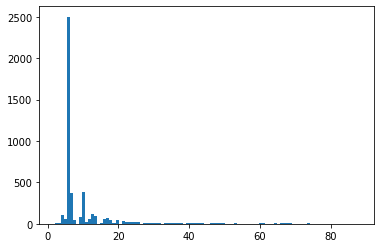

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
19  802a2be985975e5f.jpg     83     21874
20  802a5f42fdf0ab95.jpg     89     43666
27  802b7e9095d5fe2a.jpg      5     21723
********** TEST 1

Images: 9194, Labels: 3825, Super_labels: 73
Avg img per class: 2.4, Min img per class: 2, max img per class: 15
Avg img per super_class: 125.95, Min img per super_class: 2, max img per super_class: 1183
Len split1: 66612
Len split2: 10721
(len split1) / (len split2): 6.213226378136368
Len split1: 71730
Len split2: 5603
(len split1) / (len split2): 12.802070319471712
Len split1: 68246
Len split2: 9087
(len split1) / (len split2): 7.510289424452514
Len split1: 61091
L

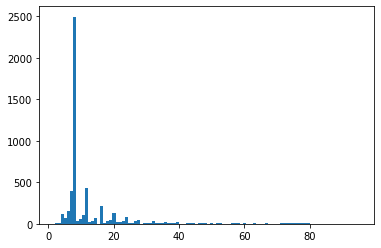

5046
second thresh =  4205
Len split1: 54957
Len split2: 11260
(len split1) / (len split2): 4.880728241563055
len(s1) / len(s2) = 4.880728241563055
Len split1: 54975
Len split2: 11242
(len split1) / (len split2): 4.89014410247287
len(s1) / len(s2) = 4.89014410247287
Len split1: 55135
Len split2: 11082
(len split1) / (len split2): 4.975184984659808
len(s1) / len(s2) = 4.975184984659808

Images: 55135, Labels: 4205, Super_labels: 73
Avg img per class: 13.11, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.27, Min img per super_class: 8, max img per super_class: 6789
*********

Images: 11082, Labels: 841, Super_labels: 61
Avg img per class: 13.18, Min img per class: 2, max img per class: 95
Avg img per super_class: 181.67, Min img per super_class: 7, max img per super_class: 1368

Images: 55135, Labels: 4205, Super_labels: 73
Avg img per class: 13.11, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.27, Min img per super_class: 8, max img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8873, Labels: 3565, Super_labels: 73
Avg img per class: 2.49, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.55, Min img per super_class: 2, max img per super_class: 1137
*****

Images: 46262, Labels: 4205, Super_labels: 73
Avg img per class: 11.0, Min img per class: 2, max img per class: 86
Avg img per super_class: 633.73, Min img per super_class: 6, max img per super_class: 5652


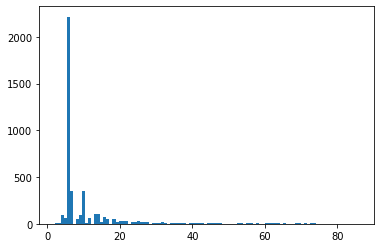

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
6   800bafacb4555b2f.jpg     82      6261
22  802a7af055d739e9.jpg     50     45049
35  802f7ff490819fc9.jpg     87      5697
38  80333fc0783e27f9.jpg     42     24915
39  803570c58f9ba1f7.jpg     87     37779
********** TEST 1

Images: 8873, Labels: 3565, Super_labels: 73
Avg img per class: 2.49, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.55, Min img per super_class: 2, max img per super_class: 1137
Len split1: 73294
Len split2: 4039
(len split1) / (len split2): 18.146570933399357
Len split1: 69094
Len split2: 8239
(len split1) / (len split2): 8.3862119189222
Len split1: 73601
Len split2: 3732
(len split1) / (len split2): 19.721596998928188
Len split1: 65914
Len spli

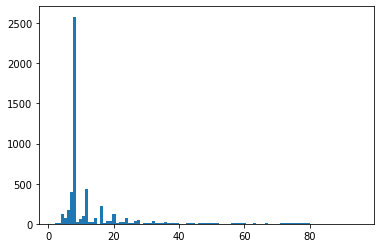

5140
second thresh =  4283
Len split1: 54774
Len split2: 11440
(len split1) / (len split2): 4.787937062937063
len(s1) / len(s2) = 4.787937062937063
Len split1: 55151
Len split2: 11063
(len split1) / (len split2): 4.985175811262768
len(s1) / len(s2) = 4.985175811262768

Images: 55151, Labels: 4283, Super_labels: 75
Avg img per class: 12.88, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.35, Min img per super_class: 8, max img per super_class: 6864
*********

Images: 11063, Labels: 857, Super_labels: 57
Avg img per class: 12.91, Min img per class: 2, max img per class: 95
Avg img per super_class: 194.09, Min img per super_class: 8, max img per super_class: 1293

Images: 55151, Labels: 4283, Super_labels: 75
Avg img per class: 12.88, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.35, Min img per super_class: 8, max img per super_class: 6864
********** TEST 2

Images: 11063, Labels: 857, Super_labels: 57
Avg img per class: 12.91, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9022, Labels: 3638, Super_labels: 74
Avg img per class: 2.48, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.92, Min img per super_class: 2, max img per super_class: 1146
*****

Images: 46129, Labels: 4283, Super_labels: 75
Avg img per class: 10.77, Min img per class: 2, max img per class: 80
Avg img per super_class: 615.05, Min img per super_class: 6, max img per super_class: 5718


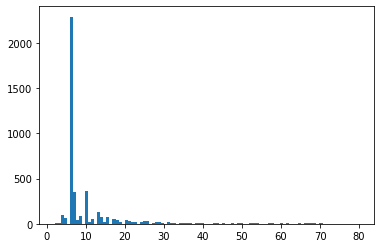

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
17  80296afd55d516ea.jpg      5     44677
32  802f65855fd85b87.jpg      5     34702
40  8035ee81817f7f68.jpg      3     22338
58  803e49f1b398ecd3.jpg      6     37728
********** TEST 1

Images: 9022, Labels: 3638, Super_labels: 74
Avg img per class: 2.48, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.92, Min img per super_class: 2, max img per super_class: 1146
Len split1: 70735
Len split2: 6598
(len split1) / (len split2): 10.72067293119127
Len split1: 62842
Len split2: 14491
(len split1) / (len split2): 4.336622731350493
Len split1: 70420
Len split2: 6913
(len split1) / (len split2): 10.186604947200927
Len split1: 72502


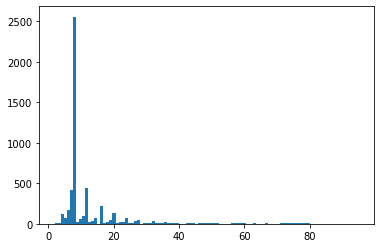

5148
second thresh =  4290
Len split1: 55057
Len split2: 11305
(len split1) / (len split2): 4.870145953118089
len(s1) / len(s2) = 4.870145953118089
Len split1: 55322
Len split2: 11040
(len split1) / (len split2): 5.011050724637681
len(s1) / len(s2) = 5.011050724637681

Images: 55322, Labels: 4290, Super_labels: 75
Avg img per class: 12.9, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.63, Min img per super_class: 8, max img per super_class: 6991
*********

Images: 11040, Labels: 858, Super_labels: 58
Avg img per class: 12.87, Min img per class: 2, max img per class: 82
Avg img per super_class: 190.34, Min img per super_class: 5, max img per super_class: 1166

Images: 55322, Labels: 4290, Super_labels: 75
Avg img per class: 12.9, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.63, Min img per super_class: 8, max img per super_class: 6991
********** TEST 2

Images: 11040, Labels: 858, Super_labels: 58
Avg img per class: 12.87, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9001, Labels: 3620, Super_labels: 74
Avg img per class: 2.49, Min img per class: 2, max img per class: 15
Avg img per super_class: 121.64, Min img per super_class: 2, max img per super_class: 1191
*****

Images: 46321, Labels: 4290, Super_labels: 75
Avg img per class: 10.8, Min img per class: 2, max img per class: 87
Avg img per super_class: 617.61, Min img per super_class: 6, max img per super_class: 5800


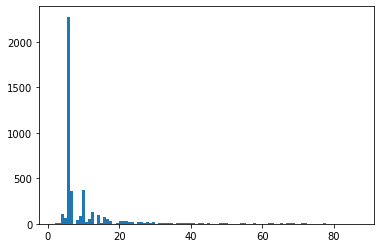

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
5   800a7ffa85c57a3a.jpg      3     25583
31  802ddd0a3f70a9f5.jpg     87     18450
32  802f65855fd85b87.jpg      5     34702
40  8035ee81817f7f68.jpg      3     22338
********** TEST 1

Images: 9001, Labels: 3620, Super_labels: 74
Avg img per class: 2.49, Min img per class: 2, max img per class: 15
Avg img per super_class: 121.64, Min img per super_class: 2, max img per super_class: 1191
Len split1: 69274
Len split2: 8059
(len split1) / (len split2): 8.595855565206602
Len split1: 61440
Len split2: 15893
(len split1) / (len split2): 3.8658528912099666
Len split1: 69799
Len split2: 7534
(len split1) / (len split2): 9.264534112025485
Len split1: 70401


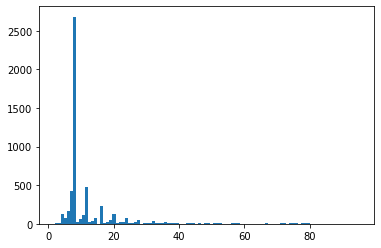

5321
second thresh =  4434
Len split1: 55204
Len split2: 11139
(len split1) / (len split2): 4.955920639195619
len(s1) / len(s2) = 4.955920639195619

Images: 55204, Labels: 4434, Super_labels: 74
Avg img per class: 12.45, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.0, Min img per super_class: 8, max img per super_class: 6949
*********

Images: 11139, Labels: 887, Super_labels: 64
Avg img per class: 12.56, Min img per class: 2, max img per class: 87
Avg img per super_class: 174.05, Min img per super_class: 5, max img per super_class: 1208

Images: 55204, Labels: 4434, Super_labels: 74
Avg img per class: 12.45, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.0, Min img per super_class: 8, max img per super_class: 6949
********** TEST 2

Images: 11139, Labels: 887, Super_labels: 64
Avg img per class: 12.56, Min img per class: 2, max img per class: 87
Avg img per super_class: 174.05, Min img per super_class: 5, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9018, Labels: 3742, Super_labels: 73
Avg img per class: 2.41, Min img per class: 2, max img per class: 15
Avg img per super_class: 123.53, Min img per super_class: 2, max img per super_class: 1153
*****

Images: 46186, Labels: 4434, Super_labels: 74
Avg img per class: 10.42, Min img per class: 2, max img per class: 93
Avg img per super_class: 624.14, Min img per super_class: 6, max img per super_class: 5796


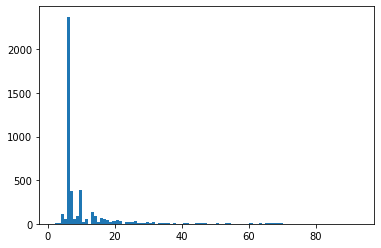

                    image  chain  hotel_id
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
224  807f2da4363a8fc5.jpg     44      5002
                   image  chain  hotel_id
23  802aab95d62b7daa.jpg      6     33712
44  803733bb5bc92c17.jpg      8     53692
48  803a7f95384ebc63.jpg     89      1779
52  803b5ed0d6037b3e.jpg      5     16791
65  803eec8557fb2895.jpg      4     17623
********** TEST 1

Images: 9018, Labels: 3742, Super_labels: 73
Avg img per class: 2.41, Min img per class: 2, max img per class: 15
Avg img per super_class: 123.53, Min img per super_class: 2, max img per super_class: 1153
Len split1: 70083
Len split2: 7250
(len split1) / (len split2): 9.666620689655172
Len split1: 73195
Len split2: 4138
(len split1) / (len split2): 17.688496858385694
Len split1: 72698
Len split2: 4635
(len split1) / (len split2): 15.684573894282632
Len split1: 57497


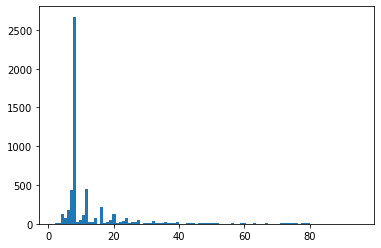

5298
second thresh =  4415
Len split1: 55375
Len split2: 10940
(len split1) / (len split2): 5.061700182815357
len(s1) / len(s2) = 5.061700182815357
Len split1: 54906
Len split2: 11409
(len split1) / (len split2): 4.8125164343939
len(s1) / len(s2) = 4.8125164343939
Len split1: 55721
Len split2: 10594
(len split1) / (len split2): 5.25967528789881
len(s1) / len(s2) = 5.25967528789881
Len split1: 55697
Len split2: 10618
(len split1) / (len split2): 5.245526464494255
len(s1) / len(s2) = 5.245526464494255
Len split1: 55401
Len split2: 10914
(len split1) / (len split2): 5.076140736668499
len(s1) / len(s2) = 5.076140736668499
Len split1: 54994
Len split2: 11321
(len split1) / (len split2): 4.857698083208197
len(s1) / len(s2) = 4.857698083208197
Len split1: 55028
Len split2: 11287
(len split1) / (len split2): 4.875343315318508
len(s1) / len(s2) = 4.875343315318508
Len split1: 55270
Len split2: 11045
(len split1) / (len split2): 5.004074241738343
len(s1) / len(s2) = 5.004074241738343

Images: 55

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9000, Labels: 3704, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.62, Min img per super_class: 2, max img per super_class: 1122
*****

Images: 46270, Labels: 4415, Super_labels: 75
Avg img per class: 10.48, Min img per class: 2, max img per class: 92
Avg img per super_class: 616.93, Min img per super_class: 6, max img per super_class: 5551


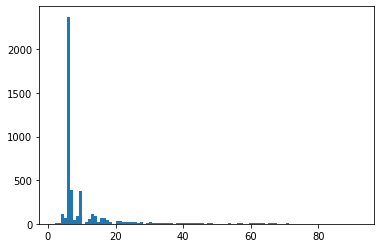

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
8   8011ffce8971daa3.jpg     87     19657
9   80196e6999ce63cf.jpg     90     55532
29  802beb5ad6256d35.jpg      3     26810
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 9000, Labels: 3704, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.62, Min img per super_class: 2, max img per super_class: 1122
Len split1: 73804
Len split2: 3529
(len split1) / (len split2): 20.913573250212526
Len split1: 60796
Len split2: 16537
(len split1) / (len split2): 3.676362097115559
Len split1: 59089
Len split2: 18244
(len split1) / (len split2): 3.2388182416136813
Len split1: 6506

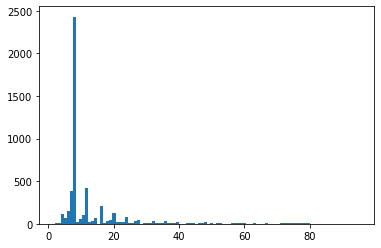

4961
second thresh =  4134
Len split1: 55070
Len split2: 11149
(len split1) / (len split2): 4.9394564534935865
len(s1) / len(s2) = 4.9394564534935865
Len split1: 55241
Len split2: 10978
(len split1) / (len split2): 5.031973036983057
len(s1) / len(s2) = 5.031973036983057

Images: 55241, Labels: 4134, Super_labels: 75
Avg img per class: 13.36, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.55, Min img per super_class: 8, max img per super_class: 6709
*********

Images: 10978, Labels: 827, Super_labels: 59
Avg img per class: 13.27, Min img per class: 2, max img per class: 95
Avg img per super_class: 186.07, Min img per super_class: 8, max img per super_class: 1448

Images: 55241, Labels: 4134, Super_labels: 75
Avg img per class: 13.36, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.55, Min img per super_class: 8, max img per super_class: 6709
********** TEST 2

Images: 10978, Labels: 827, Super_labels: 59
Avg img per class: 13.27, Min im

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8838, Labels: 3514, Super_labels: 74
Avg img per class: 2.52, Min img per class: 2, max img per class: 15
Avg img per super_class: 119.43, Min img per super_class: 2, max img per super_class: 1149
*****

Images: 46403, Labels: 4134, Super_labels: 75
Avg img per class: 11.22, Min img per class: 2, max img per class: 87
Avg img per super_class: 618.71, Min img per super_class: 6, max img per super_class: 5560


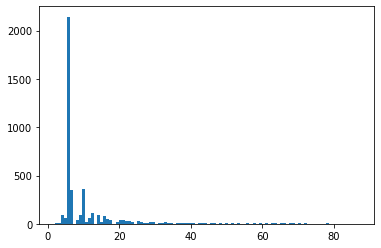

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
21  802a75e51eda5c67.jpg      9      5388
28  802bd28ddce08fbd.jpg      6     25918
47  8039c6e66bb6e329.jpg      6      9828
49  803abbf5482e3b93.jpg     87      5210
55  803d7a43427ff585.jpg     71     17105
********** TEST 1

Images: 8838, Labels: 3514, Super_labels: 74
Avg img per class: 2.52, Min img per class: 2, max img per class: 15
Avg img per super_class: 119.43, Min img per super_class: 2, max img per super_class: 1149
Len split1: 58229
Len split2: 19104
(len split1) / (len split2): 3.048000418760469
Len split1: 68962
Len split2: 8371
(len split1) / (len split2): 8.238203320989129
Len split1: 62862
Len split2: 14471
(len split1) / (len split2): 4.343998341510607
Len split1: 73219


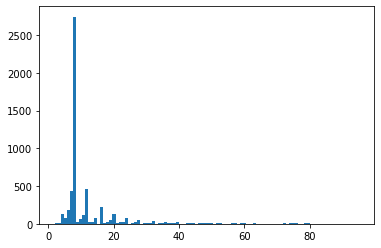

5394
second thresh =  4495
Len split1: 55370
Len split2: 10971
(len split1) / (len split2): 5.046941937836113
len(s1) / len(s2) = 5.046941937836113

Images: 55370, Labels: 4495, Super_labels: 74
Avg img per class: 12.32, Min img per class: 2, max img per class: 95
Avg img per super_class: 748.24, Min img per super_class: 8, max img per super_class: 6583
*********

Images: 10971, Labels: 899, Super_labels: 65
Avg img per class: 12.2, Min img per class: 2, max img per class: 92
Avg img per super_class: 168.78, Min img per super_class: 7, max img per super_class: 1574

Images: 55370, Labels: 4495, Super_labels: 74
Avg img per class: 12.32, Min img per class: 2, max img per class: 95
Avg img per super_class: 748.24, Min img per super_class: 8, max img per super_class: 6583
********** TEST 2

Images: 10971, Labels: 899, Super_labels: 65
Avg img per class: 12.2, Min img per class: 2, max img per class: 92
Avg img per super_class: 168.78, Min img per super_class: 7, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9142, Labels: 3785, Super_labels: 73
Avg img per class: 2.42, Min img per class: 2, max img per class: 16
Avg img per super_class: 125.23, Min img per super_class: 2, max img per super_class: 1151
*****

Images: 46228, Labels: 4495, Super_labels: 74
Avg img per class: 10.28, Min img per class: 2, max img per class: 82
Avg img per super_class: 624.7, Min img per super_class: 6, max img per super_class: 5432


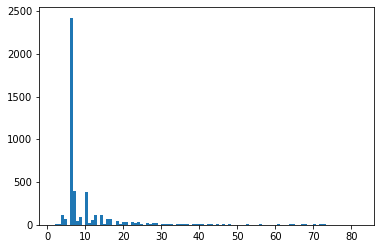

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
7   800e7dd55ffa4056.jpg      2     60181
17  80296afd55d516ea.jpg      5     44677
23  802aab95d62b7daa.jpg      6     33712
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 9142, Labels: 3785, Super_labels: 73
Avg img per class: 2.42, Min img per class: 2, max img per class: 16
Avg img per super_class: 125.23, Min img per super_class: 2, max img per super_class: 1151
Len split1: 66245
Len split2: 11088
(len split1) / (len split2): 5.974476911976912

Images: 66245, Labels: 5235, Super_labels: 75
Avg img per class: 12.65, Min img per class: 2, max img per class: 95
Avg img per super_class: 883.27, Min img per super_class: 8, max img per

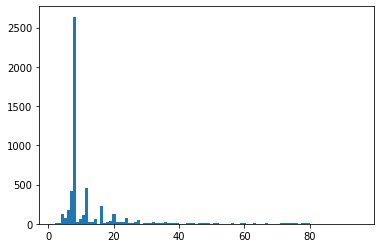

5235
second thresh =  4362
Len split1: 55124
Len split2: 11121
(len split1) / (len split2): 4.9567484938404816
len(s1) / len(s2) = 4.9567484938404816

Images: 55124, Labels: 4362, Super_labels: 73
Avg img per class: 12.64, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.12, Min img per super_class: 8, max img per super_class: 6806
*********

Images: 11121, Labels: 873, Super_labels: 63
Avg img per class: 12.74, Min img per class: 2, max img per class: 82
Avg img per super_class: 176.52, Min img per super_class: 2, max img per super_class: 1351

Images: 55124, Labels: 4362, Super_labels: 73
Avg img per class: 12.64, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.12, Min img per super_class: 8, max img per super_class: 6806
********** TEST 2

Images: 11121, Labels: 873, Super_labels: 63
Avg img per class: 12.74, Min img per class: 2, max img per class: 82
Avg img per super_class: 176.52, Min img per super_class: 2, max img per super_clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9084, Labels: 3684, Super_labels: 72
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 126.17, Min img per super_class: 2, max img per super_class: 1159
*****

Images: 46040, Labels: 4362, Super_labels: 73
Avg img per class: 10.55, Min img per class: 2, max img per class: 89
Avg img per super_class: 630.68, Min img per super_class: 6, max img per super_class: 5647


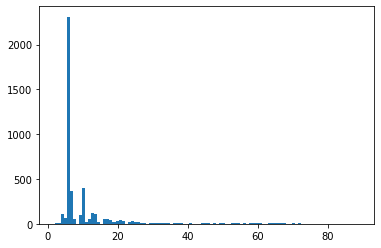

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
19  802a2be985975e5f.jpg     83     21874
28  802bd28ddce08fbd.jpg      6     25918
29  802beb5ad6256d35.jpg      3     26810
39  803570c58f9ba1f7.jpg     87     37779
65  803eec8557fb2895.jpg      4     17623
********** TEST 1

Images: 9084, Labels: 3684, Super_labels: 72
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 126.17, Min img per super_class: 2, max img per super_class: 1159
Len split1: 75580
Len split2: 1753
(len split1) / (len split2): 43.11466058185967
Len split1: 69764
Len split2: 7569
(len split1) / (len split2): 9.217069626106486
Len split1: 67297
Len split2: 10036
(len split1) / (len split2): 6.705559984057393
Len split1: 71279
L

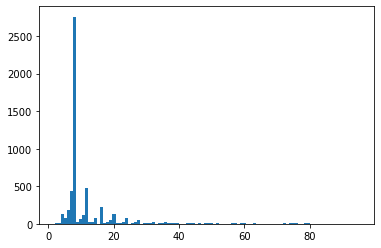

5401
second thresh =  4500
Len split1: 54993
Len split2: 11295
(len split1) / (len split2): 4.868791500664011
len(s1) / len(s2) = 4.868791500664011
Len split1: 55239
Len split2: 11049
(len split1) / (len split2): 4.99945696443117
len(s1) / len(s2) = 4.99945696443117

Images: 55239, Labels: 4500, Super_labels: 72
Avg img per class: 12.28, Min img per class: 2, max img per class: 95
Avg img per super_class: 767.21, Min img per super_class: 8, max img per super_class: 6634
*********

Images: 11049, Labels: 901, Super_labels: 61
Avg img per class: 12.26, Min img per class: 2, max img per class: 92
Avg img per super_class: 181.13, Min img per super_class: 8, max img per super_class: 1523

Images: 55239, Labels: 4500, Super_labels: 72
Avg img per class: 12.28, Min img per class: 2, max img per class: 95
Avg img per super_class: 767.21, Min img per super_class: 8, max img per super_class: 6634
********** TEST 2

Images: 11049, Labels: 901, Super_labels: 61
Avg img per class: 12.26, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9116, Labels: 3785, Super_labels: 71
Avg img per class: 2.41, Min img per class: 2, max img per class: 19
Avg img per super_class: 128.39, Min img per super_class: 2, max img per super_class: 1108
*****

Images: 46123, Labels: 4500, Super_labels: 72
Avg img per class: 10.25, Min img per class: 2, max img per class: 84
Avg img per super_class: 640.6, Min img per super_class: 6, max img per super_class: 5526


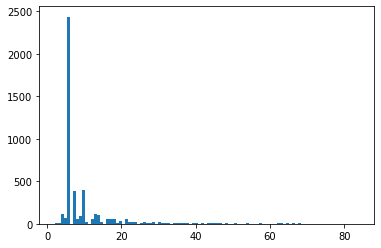

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
9   80196e6999ce63cf.jpg     90     55532
19  802a2be985975e5f.jpg     83     21874
20  802a5f42fdf0ab95.jpg     89     43666
21  802a75e51eda5c67.jpg      9      5388
********** TEST 1

Images: 9116, Labels: 3785, Super_labels: 71
Avg img per class: 2.41, Min img per class: 2, max img per class: 19
Avg img per super_class: 128.39, Min img per super_class: 2, max img per super_class: 1108
Len split1: 61806
Len split2: 15527
(len split1) / (len split2): 3.980550009660591
Len split1: 64581
Len split2: 12752
(len split1) / (len split2): 5.064382057716436
Len split1: 63231
Len split2: 14102
(len split1) / (len split2): 4.48383208055595
Len split1: 64988


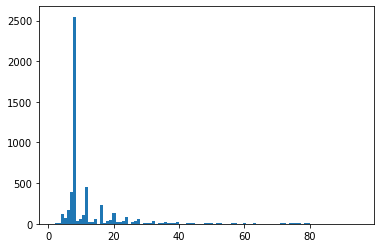

5147
second thresh =  4289
Len split1: 54819
Len split2: 11428
(len split1) / (len split2): 4.796902345117256
len(s1) / len(s2) = 4.796902345117256
Len split1: 54828
Len split2: 11419
(len split1) / (len split2): 4.801471232156931
len(s1) / len(s2) = 4.801471232156931
Len split1: 55654
Len split2: 10593
(len split1) / (len split2): 5.253846880015105
len(s1) / len(s2) = 5.253846880015105
Len split1: 55316
Len split2: 10931
(len split1) / (len split2): 5.0604702223035405
len(s1) / len(s2) = 5.0604702223035405
Len split1: 55628
Len split2: 10619
(len split1) / (len split2): 5.2385347019493365
len(s1) / len(s2) = 5.2385347019493365
Len split1: 54562
Len split2: 11685
(len split1) / (len split2): 4.669405220367993
len(s1) / len(s2) = 4.669405220367993
Len split1: 55157
Len split2: 11090
(len split1) / (len split2): 4.973579801623083
len(s1) / len(s2) = 4.973579801623083

Images: 55157, Labels: 4289, Super_labels: 73
Avg img per class: 12.86, Min img per class: 2, max img per class: 95
Avg i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8978, Labels: 3635, Super_labels: 72
Avg img per class: 2.47, Min img per class: 2, max img per class: 15
Avg img per super_class: 124.69, Min img per super_class: 2, max img per super_class: 1146
*****

Images: 46179, Labels: 4289, Super_labels: 73
Avg img per class: 10.77, Min img per class: 2, max img per class: 88
Avg img per super_class: 632.59, Min img per super_class: 6, max img per super_class: 5633


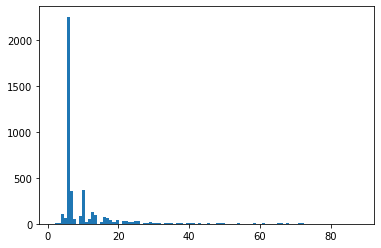

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                  image  chain  hotel_id
2  80053befc2d42fba.jpg      3       672
3  8007fa0a8fe89f9d.jpg      5     63866
5  800a7ffa85c57a3a.jpg      3     25583
6  800bafacb4555b2f.jpg     82      6261
9  80196e6999ce63cf.jpg     90     55532
********** TEST 1

Images: 8978, Labels: 3635, Super_labels: 72
Avg img per class: 2.47, Min img per class: 2, max img per class: 15
Avg img per super_class: 124.69, Min img per super_class: 2, max img per super_class: 1146
Len split1: 66996
Len split2: 10337
(len split1) / (len split2): 6.481184095965948
Len split1: 67712
Len split2: 9621
(len split1) / (len split2): 7.03793784429893
Len split1: 65993
Len split2: 11340
(len split1) / (len split2): 5.819488536155203
Len split1: 71745
Len spl

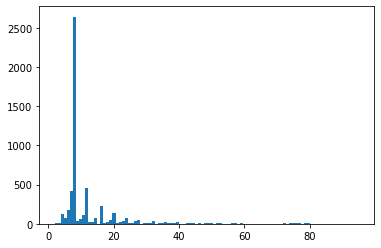

5261
second thresh =  4384
Len split1: 55317
Len split2: 10978
(len split1) / (len split2): 5.0388959737657135
len(s1) / len(s2) = 5.0388959737657135

Images: 55317, Labels: 4384, Super_labels: 75
Avg img per class: 12.62, Min img per class: 2, max img per class: 87
Avg img per super_class: 737.56, Min img per super_class: 8, max img per super_class: 7017
*********

Images: 10978, Labels: 877, Super_labels: 57
Avg img per class: 12.52, Min img per class: 4, max img per class: 95
Avg img per super_class: 192.6, Min img per super_class: 4, max img per super_class: 1140

Images: 55317, Labels: 4384, Super_labels: 75
Avg img per class: 12.62, Min img per class: 2, max img per class: 87
Avg img per super_class: 737.56, Min img per super_class: 8, max img per super_class: 7017
********** TEST 2

Images: 10978, Labels: 877, Super_labels: 57
Avg img per class: 12.52, Min img per class: 4, max img per class: 95
Avg img per super_class: 192.6, Min img per super_class: 4, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9042, Labels: 3712, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.19, Min img per super_class: 2, max img per super_class: 1191
*****

Images: 46275, Labels: 4384, Super_labels: 75
Avg img per class: 10.56, Min img per class: 2, max img per class: 82
Avg img per super_class: 617.0, Min img per super_class: 6, max img per super_class: 5826


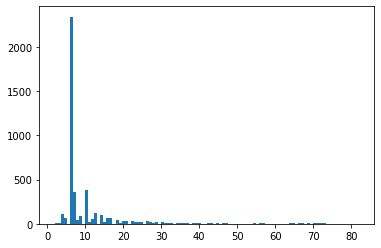

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
11  801aff45ebd0bcd0.jpg     78     26666
17  80296afd55d516ea.jpg      5     44677
52  803b5ed0d6037b3e.jpg      5     16791
55  803d7a43427ff585.jpg     71     17105
82  803f846cdba15cbb.jpg     66     20024
********** TEST 1

Images: 9042, Labels: 3712, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.19, Min img per super_class: 2, max img per super_class: 1191
Len split1: 57416
Len split2: 19917
(len split1) / (len split2): 2.8827634683938346
Len split1: 69296
Len split2: 8037
(len split1) / (len split2): 8.622122682593007
Len split1: 67300
Len split2: 10033
(len split1) / (len split2): 6.70786404863949
Len split1: 61345


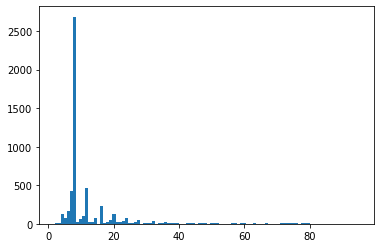

5292
second thresh =  4410
Len split1: 55450
Len split2: 10881
(len split1) / (len split2): 5.0960389670067086
len(s1) / len(s2) = 5.0960389670067086
Len split1: 55342
Len split2: 10989
(len split1) / (len split2): 5.036127036127036
len(s1) / len(s2) = 5.036127036127036

Images: 55342, Labels: 4410, Super_labels: 71
Avg img per class: 12.55, Min img per class: 2, max img per class: 95
Avg img per super_class: 779.46, Min img per super_class: 7, max img per super_class: 6847
*********

Images: 10989, Labels: 882, Super_labels: 68
Avg img per class: 12.46, Min img per class: 2, max img per class: 95
Avg img per super_class: 161.6, Min img per super_class: 3, max img per super_class: 1310

Images: 55342, Labels: 4410, Super_labels: 71
Avg img per class: 12.55, Min img per class: 2, max img per class: 95
Avg img per super_class: 779.46, Min img per super_class: 7, max img per super_class: 6847
********** TEST 2

Images: 10989, Labels: 882, Super_labels: 68
Avg img per class: 12.46, Min img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9006, Labels: 3743, Super_labels: 69
Avg img per class: 2.41, Min img per class: 2, max img per class: 15
Avg img per super_class: 130.52, Min img per super_class: 2, max img per super_class: 1153
*****

Images: 46336, Labels: 4410, Super_labels: 71
Avg img per class: 10.51, Min img per class: 2, max img per class: 88
Avg img per super_class: 652.62, Min img per super_class: 6, max img per super_class: 5694


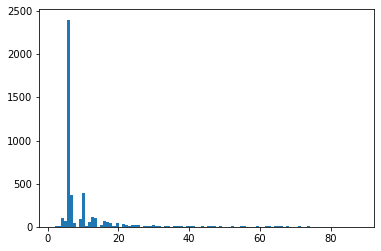

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
3   8007fa0a8fe89f9d.jpg      5     63866
12  801f7ce821c7dfd0.jpg     89     27809
40  8035ee81817f7f68.jpg      3     22338
49  803abbf5482e3b93.jpg     87      5210
********** TEST 1

Images: 9006, Labels: 3743, Super_labels: 69
Avg img per class: 2.41, Min img per class: 2, max img per class: 15
Avg img per super_class: 130.52, Min img per super_class: 2, max img per super_class: 1153
Len split1: 66357
Len split2: 10976
(len split1) / (len split2): 6.045645043731779

Images: 66357, Labels: 5283, Super_labels: 75
Avg img per class: 12.56, Min img per class: 2, max img per class: 95
Avg img per super_class: 884.76, Min img per super_class: 8, max i

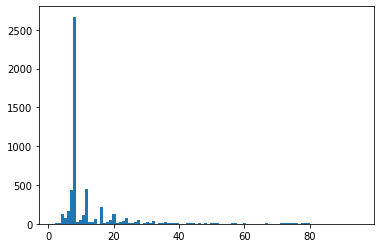

5283
second thresh =  4402
Len split1: 55571
Len split2: 10786
(len split1) / (len split2): 5.152141665121453
len(s1) / len(s2) = 5.152141665121453
Len split1: 54971
Len split2: 11386
(len split1) / (len split2): 4.827946601089057
len(s1) / len(s2) = 4.827946601089057
Len split1: 55128
Len split2: 11229
(len split1) / (len split2): 4.909430937750468
len(s1) / len(s2) = 4.909430937750468
Len split1: 55426
Len split2: 10931
(len split1) / (len split2): 5.070533345531058
len(s1) / len(s2) = 5.070533345531058
Len split1: 55193
Len split2: 11164
(len split1) / (len split2): 4.943837334288785
len(s1) / len(s2) = 4.943837334288785
Len split1: 55406
Len split2: 10951
(len split1) / (len split2): 5.059446625878915
len(s1) / len(s2) = 5.059446625878915
Len split1: 55590
Len split2: 10767
(len split1) / (len split2): 5.162998049595988
len(s1) / len(s2) = 5.162998049595988
Len split1: 55319
Len split2: 11038
(len split1) / (len split2): 5.011686899800688
len(s1) / len(s2) = 5.011686899800688

Imag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9048, Labels: 3707, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 15
Avg img per super_class: 123.95, Min img per super_class: 2, max img per super_class: 1193
*****

Images: 46271, Labels: 4402, Super_labels: 73
Avg img per class: 10.51, Min img per class: 2, max img per class: 89
Avg img per super_class: 633.85, Min img per super_class: 6, max img per super_class: 5803


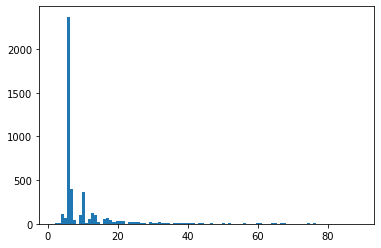

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
21  802a75e51eda5c67.jpg      9      5388
29  802beb5ad6256d35.jpg      3     26810
31  802ddd0a3f70a9f5.jpg     87     18450
34  802f7fd0d42f2cca.jpg      6     32426
53  803be117a845fe9d.jpg     90     61942
********** TEST 1

Images: 9048, Labels: 3707, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 15
Avg img per super_class: 123.95, Min img per super_class: 2, max img per super_class: 1193
Len split1: 63484
Len split2: 13849
(len split1) / (len split2): 4.5840132861578455
Len split1: 70760
Len split2: 6573
(len split1) / (len split2): 10.765251787616005
Len split1: 72987
Len split2: 4346
(len split1) / (len split2): 16.794063506672803
Len split1: 7116

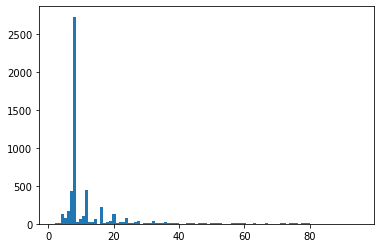

5311
second thresh =  4425
Len split1: 55398
Len split2: 10890
(len split1) / (len split2): 5.087052341597796
len(s1) / len(s2) = 5.087052341597796
Len split1: 55458
Len split2: 10830
(len split1) / (len split2): 5.120775623268698
len(s1) / len(s2) = 5.120775623268698
Len split1: 55763
Len split2: 10525
(len split1) / (len split2): 5.298147268408551
len(s1) / len(s2) = 5.298147268408551
Len split1: 55619
Len split2: 10669
(len split1) / (len split2): 5.213140875433499
len(s1) / len(s2) = 5.213140875433499
Len split1: 55680
Len split2: 10608
(len split1) / (len split2): 5.248868778280543
len(s1) / len(s2) = 5.248868778280543
Len split1: 55179
Len split2: 11109
(len split1) / (len split2): 4.96705374021064
len(s1) / len(s2) = 4.96705374021064

Images: 55179, Labels: 4425, Super_labels: 74
Avg img per class: 12.47, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.66, Min img per super_class: 8, max img per super_class: 6838
*********

Images: 11109, Labels: 886, Su

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9080, Labels: 3730, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 17
Avg img per super_class: 124.38, Min img per super_class: 2, max img per super_class: 1156
*****

Images: 46099, Labels: 4425, Super_labels: 74
Avg img per class: 10.42, Min img per class: 2, max img per class: 82
Avg img per super_class: 622.96, Min img per super_class: 6, max img per super_class: 5682


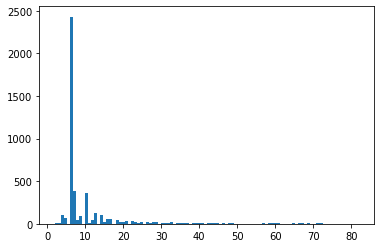

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
24  802aef94c02bbfd5.jpg      6     62831
38  80333fc0783e27f9.jpg     42     24915
53  803be117a845fe9d.jpg     90     61942
56  803dce35ca659b47.jpg      2     43373
77  803f78814d9f3a97.jpg     89     23762
********** TEST 1

Images: 9080, Labels: 3730, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 17
Avg img per super_class: 124.38, Min img per super_class: 2, max img per super_class: 1156
Len split1: 62328
Len split2: 15005
(len split1) / (len split2): 4.153815394868377
Len split1: 67313
Len split2: 10020
(len split1) / (len split2): 6.717864271457086
Len split1: 69732
Len split2: 7601
(len split1) / (len split2): 9.174056045257203
Len split1: 68282


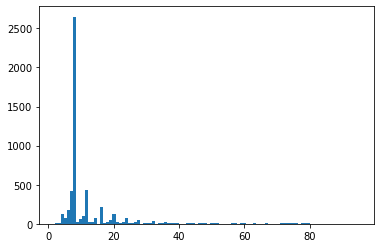

5224
second thresh =  4353
Len split1: 55073
Len split2: 11151
(len split1) / (len split2): 4.93883956595821
len(s1) / len(s2) = 4.93883956595821
Len split1: 55867
Len split2: 10357
(len split1) / (len split2): 5.394129574201023
len(s1) / len(s2) = 5.394129574201023
Len split1: 54909
Len split2: 11315
(len split1) / (len split2): 4.852761820592134
len(s1) / len(s2) = 4.852761820592134
Len split1: 55419
Len split2: 10805
(len split1) / (len split2): 5.1290143452105506
len(s1) / len(s2) = 5.1290143452105506
Len split1: 55323
Len split2: 10901
(len split1) / (len split2): 5.075038987248877
len(s1) / len(s2) = 5.075038987248877
Len split1: 54993
Len split2: 11231
(len split1) / (len split2): 4.89653637254029
len(s1) / len(s2) = 4.89653637254029
Len split1: 55035
Len split2: 11189
(len split1) / (len split2): 4.918670122441684
len(s1) / len(s2) = 4.918670122441684
Len split1: 55289
Len split2: 10935
(len split1) / (len split2): 5.056149977137632
len(s1) / len(s2) = 5.056149977137632
Len spl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8929, Labels: 3672, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 19
Avg img per super_class: 122.32, Min img per super_class: 2, max img per super_class: 1157
*****

Images: 46259, Labels: 4353, Super_labels: 74
Avg img per class: 10.63, Min img per class: 2, max img per class: 84
Avg img per super_class: 625.12, Min img per super_class: 6, max img per super_class: 5758


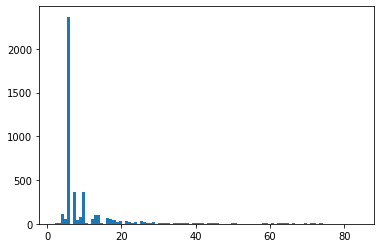

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
206  807e68855eeaa1d7.jpg      5     52125
224  807f2da4363a8fc5.jpg     44      5002
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
13  8020ee1f3f7781da.jpg     52      2498
34  802f7fd0d42f2cca.jpg      6     32426
53  803be117a845fe9d.jpg     90     61942
********** TEST 1

Images: 8929, Labels: 3672, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 19
Avg img per super_class: 122.32, Min img per super_class: 2, max img per super_class: 1157
Len split1: 71712
Len split2: 5621
(len split1) / (len split2): 12.75787226472158
Len split1: 73273
Len split2: 4060
(len split1) / (len split2): 18.04753694581281
Len split1: 62622
Len split2: 14711
(len split1) / (len split2): 4.256814628509279
Len split1: 64448
L

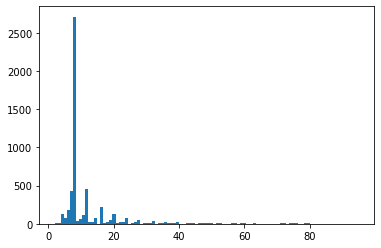

5352
second thresh =  4460
Len split1: 54931
Len split2: 11308
(len split1) / (len split2): 4.857711354793067
len(s1) / len(s2) = 4.857711354793067
Len split1: 55338
Len split2: 10901
(len split1) / (len split2): 5.07641500779745
len(s1) / len(s2) = 5.07641500779745
Len split1: 55180
Len split2: 11059
(len split1) / (len split2): 4.98960122976761
len(s1) / len(s2) = 4.98960122976761

Images: 55180, Labels: 4460, Super_labels: 74
Avg img per class: 12.37, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.68, Min img per super_class: 8, max img per super_class: 6739
*********

Images: 11059, Labels: 892, Super_labels: 64
Avg img per class: 12.4, Min img per class: 3, max img per class: 86
Avg img per super_class: 172.8, Min img per super_class: 3, max img per super_class: 1418

Images: 55180, Labels: 4460, Super_labels: 74
Avg img per class: 12.37, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.68, Min img per super_class: 8, max img per s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9071, Labels: 3745, Super_labels: 74
Avg img per class: 2.42, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.58, Min img per super_class: 2, max img per super_class: 1136
*****

Images: 46109, Labels: 4460, Super_labels: 74
Avg img per class: 10.34, Min img per class: 2, max img per class: 88
Avg img per super_class: 623.09, Min img per super_class: 6, max img per super_class: 5603


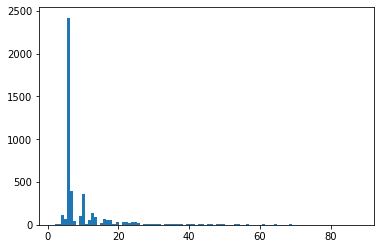

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
21  802a75e51eda5c67.jpg      9      5388
22  802a7af055d739e9.jpg     50     45049
********** TEST 1

Images: 9071, Labels: 3745, Super_labels: 74
Avg img per class: 2.42, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.58, Min img per super_class: 2, max img per super_class: 1136
Len split1: 69819
Len split2: 7514
(len split1) / (len split2): 9.29185520361991
Len split1: 74327
Len split2: 3006
(len split1) / (len split2): 24.726214238190288
Len split1: 65149
Len split2: 12184
(len split1) / (len split2): 5.3470945502298095
Len split1: 66151


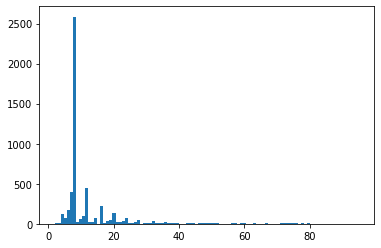

5162
second thresh =  4301
Len split1: 55261
Len split2: 11054
(len split1) / (len split2): 4.99918581508956
len(s1) / len(s2) = 4.99918581508956

Images: 55261, Labels: 4301, Super_labels: 73
Avg img per class: 12.85, Min img per class: 2, max img per class: 92
Avg img per super_class: 757.0, Min img per super_class: 6, max img per super_class: 6848
*********

Images: 11054, Labels: 861, Super_labels: 64
Avg img per class: 12.84, Min img per class: 2, max img per class: 95
Avg img per super_class: 172.72, Min img per super_class: 7, max img per super_class: 1309

Images: 55261, Labels: 4301, Super_labels: 73
Avg img per class: 12.85, Min img per class: 2, max img per class: 92
Avg img per super_class: 757.0, Min img per super_class: 6, max img per super_class: 6848
********** TEST 2

Images: 11054, Labels: 861, Super_labels: 64
Avg img per class: 12.84, Min img per class: 2, max img per class: 95
Avg img per super_class: 172.72, Min img per super_class: 7, max img per super_class: 130

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8945, Labels: 3636, Super_labels: 72
Avg img per class: 2.46, Min img per class: 2, max img per class: 17
Avg img per super_class: 124.24, Min img per super_class: 2, max img per super_class: 1157
*****

Images: 46316, Labels: 4301, Super_labels: 73
Avg img per class: 10.77, Min img per class: 2, max img per class: 90
Avg img per super_class: 634.47, Min img per super_class: 6, max img per super_class: 5691


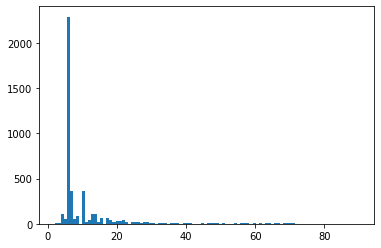

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
12  801f7ce821c7dfd0.jpg     89     27809
17  80296afd55d516ea.jpg      5     44677
27  802b7e9095d5fe2a.jpg      5     21723
30  802beb95d5aac0d7.jpg     78     50595
********** TEST 1

Images: 8945, Labels: 3636, Super_labels: 72
Avg img per class: 2.46, Min img per class: 2, max img per class: 17
Avg img per super_class: 124.24, Min img per super_class: 2, max img per super_class: 1157
Len split1: 60854
Len split2: 16479
(len split1) / (len split2): 3.6928211663329087
Len split1: 70746
Len split2: 6587
(len split1) / (len split2): 10.7402459389707
Len split1: 59732
Len split2: 17601
(len split1) / (len split2): 3.3936708141582863
Len split1: 69106
Len s

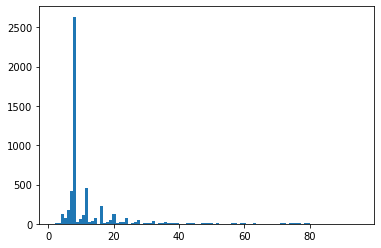

5251
second thresh =  4375
Len split1: 55015
Len split2: 11316
(len split1) / (len split2): 4.861700247437257
len(s1) / len(s2) = 4.861700247437257
Len split1: 55294
Len split2: 11037
(len split1) / (len split2): 5.009875872066685
len(s1) / len(s2) = 5.009875872066685

Images: 55294, Labels: 4375, Super_labels: 73
Avg img per class: 12.64, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.45, Min img per super_class: 8, max img per super_class: 6554
*********

Images: 11037, Labels: 876, Super_labels: 65
Avg img per class: 12.6, Min img per class: 2, max img per class: 83
Avg img per super_class: 169.8, Min img per super_class: 5, max img per super_class: 1603

Images: 55294, Labels: 4375, Super_labels: 73
Avg img per class: 12.64, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.45, Min img per super_class: 8, max img per super_class: 6554
********** TEST 2

Images: 11037, Labels: 876, Super_labels: 65
Avg img per class: 12.6, Min img per

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9047, Labels: 3707, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 18
Avg img per super_class: 123.93, Min img per super_class: 2, max img per super_class: 1121
*****

Images: 46247, Labels: 4375, Super_labels: 73
Avg img per class: 10.57, Min img per class: 2, max img per class: 91
Avg img per super_class: 633.52, Min img per super_class: 6, max img per super_class: 5433


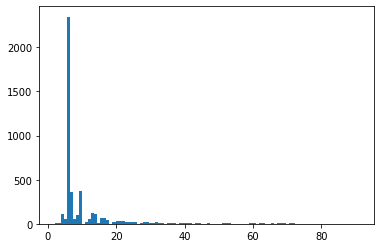

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
2   80053befc2d42fba.jpg      3       672
13  8020ee1f3f7781da.jpg     52      2498
31  802ddd0a3f70a9f5.jpg     87     18450
44  803733bb5bc92c17.jpg      8     53692
********** TEST 1

Images: 9047, Labels: 3707, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 18
Avg img per super_class: 123.93, Min img per super_class: 2, max img per super_class: 1121
Len split1: 70874
Len split2: 6459
(len split1) / (len split2): 10.972906022604118
Len split1: 73158
Len split2: 4175
(len split1) / (len split2): 17.522874251497004
Len split1: 70731
Len split2: 6602
(len split1) / (len split2): 10.713571644956074
Len split1: 71992
Len s

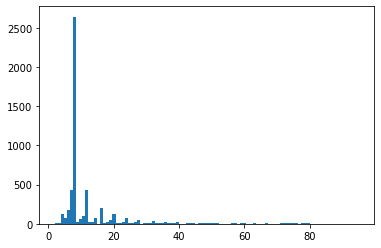

5215
second thresh =  4345
Len split1: 55325
Len split2: 10975
(len split1) / (len split2): 5.041002277904328
len(s1) / len(s2) = 5.041002277904328

Images: 55325, Labels: 4345, Super_labels: 75
Avg img per class: 12.73, Min img per class: 2, max img per class: 92
Avg img per super_class: 737.67, Min img per super_class: 8, max img per super_class: 6770
*********

Images: 10975, Labels: 870, Super_labels: 62
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 177.02, Min img per super_class: 2, max img per super_class: 1387

Images: 55325, Labels: 4345, Super_labels: 75
Avg img per class: 12.73, Min img per class: 2, max img per class: 92
Avg img per super_class: 737.67, Min img per super_class: 8, max img per super_class: 6770
********** TEST 2

Images: 10975, Labels: 870, Super_labels: 62
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 177.02, Min img per super_class: 2, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8995, Labels: 3638, Super_labels: 75
Avg img per class: 2.47, Min img per class: 2, max img per class: 17
Avg img per super_class: 119.93, Min img per super_class: 2, max img per super_class: 1155
*****

Images: 46330, Labels: 4345, Super_labels: 75
Avg img per class: 10.66, Min img per class: 2, max img per class: 79
Avg img per super_class: 617.73, Min img per super_class: 6, max img per super_class: 5615


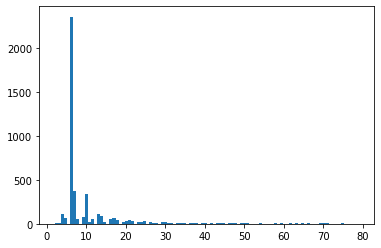

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
24  802aef94c02bbfd5.jpg      6     62831
32  802f65855fd85b87.jpg      5     34702
34  802f7fd0d42f2cca.jpg      6     32426
40  8035ee81817f7f68.jpg      3     22338
********** TEST 1

Images: 8995, Labels: 3638, Super_labels: 75
Avg img per class: 2.47, Min img per class: 2, max img per class: 17
Avg img per super_class: 119.93, Min img per super_class: 2, max img per super_class: 1155
Len split1: 69372
Len split2: 7961
(len split1) / (len split2): 8.71398065569652
Len split1: 63496
Len split2: 13837
(len split1) / (len split2): 4.58885596588856
Len split1: 68358
Len split2: 8975
(len split1) / (len split2): 7.616490250696379
Len split1: 67812
Len split

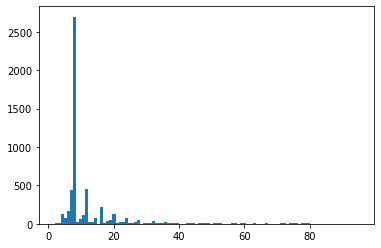

5321
second thresh =  4434
Len split1: 55182
Len split2: 11045
(len split1) / (len split2): 4.99610683567225
len(s1) / len(s2) = 4.99610683567225

Images: 55182, Labels: 4434, Super_labels: 73
Avg img per class: 12.45, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.92, Min img per super_class: 8, max img per super_class: 6693
*********

Images: 11045, Labels: 887, Super_labels: 65
Avg img per class: 12.45, Min img per class: 2, max img per class: 87
Avg img per super_class: 169.92, Min img per super_class: 5, max img per super_class: 1464

Images: 55182, Labels: 4434, Super_labels: 73
Avg img per class: 12.45, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.92, Min img per super_class: 8, max img per super_class: 6693
********** TEST 2

Images: 11045, Labels: 887, Super_labels: 65
Avg img per class: 12.45, Min img per class: 2, max img per class: 87
Avg img per super_class: 169.92, Min img per super_class: 5, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9036, Labels: 3754, Super_labels: 72
Avg img per class: 2.41, Min img per class: 2, max img per class: 15
Avg img per super_class: 125.5, Min img per super_class: 2, max img per super_class: 1148
*****

Images: 46146, Labels: 4434, Super_labels: 73
Avg img per class: 10.41, Min img per class: 2, max img per class: 85
Avg img per super_class: 632.14, Min img per super_class: 6, max img per super_class: 5545


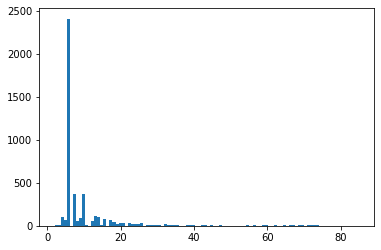

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
26  802b5ed622fd3587.jpg     90     35252
28  802bd28ddce08fbd.jpg      6     25918
32  802f65855fd85b87.jpg      5     34702
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 9036, Labels: 3754, Super_labels: 72
Avg img per class: 2.41, Min img per class: 2, max img per class: 15
Avg img per super_class: 125.5, Min img per super_class: 2, max img per super_class: 1148
Len split1: 70173
Len split2: 7160
(len split1) / (len split2): 9.800698324022346
Len split1: 69359
Len split2: 7974
(len split1) / (len split2): 8.69814396789566
Len split1: 67594
Len split2: 9739
(len split1) / (len split2): 6.9405483109148784
Len split1: 70090
Len

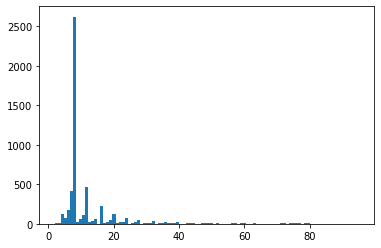

5230
second thresh =  4358
Len split1: 55317
Len split2: 10925
(len split1) / (len split2): 5.063340961098398
len(s1) / len(s2) = 5.063340961098398
Len split1: 55511
Len split2: 10731
(len split1) / (len split2): 5.172956853974466
len(s1) / len(s2) = 5.172956853974466
Len split1: 55562
Len split2: 10680
(len split1) / (len split2): 5.202434456928839
len(s1) / len(s2) = 5.202434456928839
Len split1: 55081
Len split2: 11161
(len split1) / (len split2): 4.935131260639728
len(s1) / len(s2) = 4.935131260639728
Len split1: 55124
Len split2: 11118
(len split1) / (len split2): 4.958085986688253
len(s1) / len(s2) = 4.958085986688253

Images: 55124, Labels: 4358, Super_labels: 75
Avg img per class: 12.65, Min img per class: 2, max img per class: 95
Avg img per super_class: 734.99, Min img per super_class: 8, max img per super_class: 6545
*********

Images: 11118, Labels: 872, Super_labels: 55
Avg img per class: 12.75, Min img per class: 2, max img per class: 95
Avg img per super_class: 202.15, M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8983, Labels: 3686, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.39, Min img per super_class: 2, max img per super_class: 1059
*****

Images: 46141, Labels: 4358, Super_labels: 75
Avg img per class: 10.59, Min img per class: 2, max img per class: 89
Avg img per super_class: 615.21, Min img per super_class: 6, max img per super_class: 5486


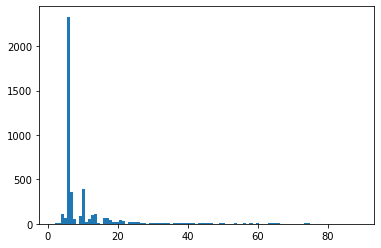

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
13  8020ee1f3f7781da.jpg     52      2498
28  802bd28ddce08fbd.jpg      6     25918
55  803d7a43427ff585.jpg     71     17105
66  803ef0e73f60078f.jpg      2     63210
********** TEST 1

Images: 8983, Labels: 3686, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.39, Min img per super_class: 2, max img per super_class: 1059
Len split1: 61431
Len split2: 15902
(len split1) / (len split2): 3.863098981260219
Len split1: 66316
Len split2: 11017
(len split1) / (len split2): 6.019424525732958

Images: 66316, Labels: 5017, Super_labels: 75
Avg img per class: 13.22, Min img per class: 2, max i

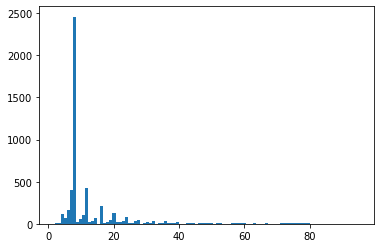

5017
second thresh =  4180
Len split1: 55105
Len split2: 11211
(len split1) / (len split2): 4.915261796449915
len(s1) / len(s2) = 4.915261796449915
Len split1: 55454
Len split2: 10862
(len split1) / (len split2): 5.105321303627325
len(s1) / len(s2) = 5.105321303627325
Len split1: 55498
Len split2: 10818
(len split1) / (len split2): 5.130153447957109
len(s1) / len(s2) = 5.130153447957109
Len split1: 55527
Len split2: 10789
(len split1) / (len split2): 5.1466308276948745
len(s1) / len(s2) = 5.1466308276948745
Len split1: 54978
Len split2: 11338
(len split1) / (len split2): 4.849003351561122
len(s1) / len(s2) = 4.849003351561122
Len split1: 55661
Len split2: 10655
(len split1) / (len split2): 5.223932426091037
len(s1) / len(s2) = 5.223932426091037
Len split1: 55128
Len split2: 11188
(len split1) / (len split2): 4.927422238112263
len(s1) / len(s2) = 4.927422238112263
Len split1: 54938
Len split2: 11378
(len split1) / (len split2): 4.8284408507646335
len(s1) / len(s2) = 4.8284408507646335
L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8941, Labels: 3541, Super_labels: 73
Avg img per class: 2.52, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.48, Min img per super_class: 2, max img per super_class: 1168
*****

Images: 46258, Labels: 4180, Super_labels: 73
Avg img per class: 11.07, Min img per class: 2, max img per class: 88
Avg img per super_class: 633.67, Min img per super_class: 6, max img per super_class: 5738


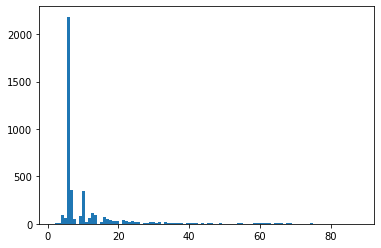

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
13  8020ee1f3f7781da.jpg     52      2498
20  802a5f42fdf0ab95.jpg     89     43666
54  803c53933678ed97.jpg      8     58850
64  803edda1d29625eb.jpg      4     24695
********** TEST 1

Images: 8941, Labels: 3541, Super_labels: 73
Avg img per class: 2.52, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.48, Min img per super_class: 2, max img per super_class: 1168
Len split1: 69053
Len split2: 8280
(len split1) / (len split2): 8.339734299516909
Len split1: 67260
Len split2: 10073
(len split1) / (len split2): 6.677256030973891
Len split1: 65012
Len split2: 12321
(len split1) / (len split2): 5.27651976300625
Len split1: 61680
L

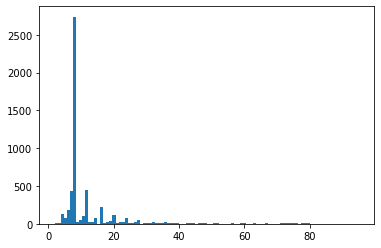

5339
second thresh =  4449
Len split1: 55348
Len split2: 10941
(len split1) / (len split2): 5.058769765103738
len(s1) / len(s2) = 5.058769765103738
Len split1: 54874
Len split2: 11415
(len split1) / (len split2): 4.8071835304424
len(s1) / len(s2) = 4.8071835304424
Len split1: 55312
Len split2: 10977
(len split1) / (len split2): 5.038899517172269
len(s1) / len(s2) = 5.038899517172269

Images: 55312, Labels: 4449, Super_labels: 74
Avg img per class: 12.43, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.46, Min img per super_class: 8, max img per super_class: 7134
*********

Images: 10977, Labels: 890, Super_labels: 65
Avg img per class: 12.33, Min img per class: 2, max img per class: 80
Avg img per super_class: 168.88, Min img per super_class: 7, max img per super_class: 1100

Images: 55312, Labels: 4449, Super_labels: 74
Avg img per class: 12.43, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.46, Min img per super_class: 8, max img per

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9066, Labels: 3749, Super_labels: 74
Avg img per class: 2.42, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.51, Min img per super_class: 2, max img per super_class: 1194
*****

Images: 46246, Labels: 4449, Super_labels: 74
Avg img per class: 10.39, Min img per class: 2, max img per class: 91
Avg img per super_class: 624.95, Min img per super_class: 6, max img per super_class: 5940


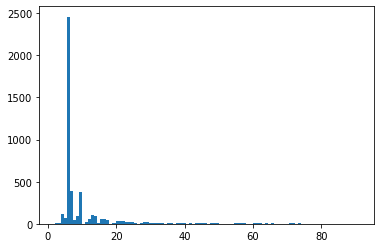

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
19  802a2be985975e5f.jpg     83     21874
49  803abbf5482e3b93.jpg     87      5210
61  803e7b9595fa2a25.jpg      6     15263
********** TEST 1

Images: 9066, Labels: 3749, Super_labels: 74
Avg img per class: 2.42, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.51, Min img per super_class: 2, max img per super_class: 1194
Len split1: 56607
Len split2: 20726
(len split1) / (len split2): 2.7312071793882082
Len split1: 71194
Len split2: 6139
(len split1) / (len split2): 11.597002769180648
Len split1: 61229
Len split2: 16104
(len split1) / (len split2): 3.8020988574267265
Len split1: 678

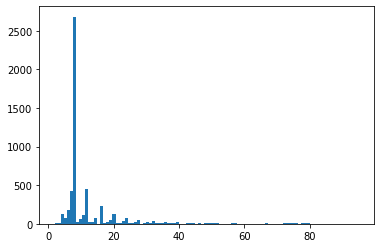

5293
second thresh =  4410
Len split1: 54460
Len split2: 11827
(len split1) / (len split2): 4.604718018094191
len(s1) / len(s2) = 4.604718018094191
Len split1: 55473
Len split2: 10814
(len split1) / (len split2): 5.129739226928057
len(s1) / len(s2) = 5.129739226928057
Len split1: 55438
Len split2: 10849
(len split1) / (len split2): 5.109964051986358
len(s1) / len(s2) = 5.109964051986358
Len split1: 54597
Len split2: 11690
(len split1) / (len split2): 4.670402053036784
len(s1) / len(s2) = 4.670402053036784
Len split1: 55180
Len split2: 11107
(len split1) / (len split2): 4.968038174124426
len(s1) / len(s2) = 4.968038174124426

Images: 55180, Labels: 4410, Super_labels: 75
Avg img per class: 12.51, Min img per class: 2, max img per class: 92
Avg img per super_class: 735.73, Min img per super_class: 8, max img per super_class: 6777
*********

Images: 11107, Labels: 883, Super_labels: 63
Avg img per class: 12.58, Min img per class: 2, max img per class: 95
Avg img per super_class: 176.3, Mi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9107, Labels: 3716, Super_labels: 74
Avg img per class: 2.45, Min img per class: 2, max img per class: 18
Avg img per super_class: 123.07, Min img per super_class: 2, max img per super_class: 1125
*****

Images: 46073, Labels: 4410, Super_labels: 75
Avg img per class: 10.45, Min img per class: 2, max img per class: 82
Avg img per super_class: 614.31, Min img per super_class: 6, max img per super_class: 5652


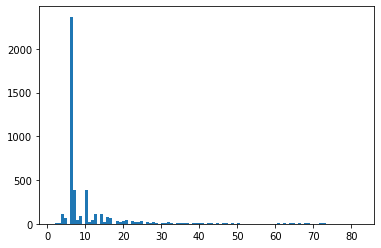

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
12  801f7ce821c7dfd0.jpg     89     27809
24  802aef94c02bbfd5.jpg      6     62831
29  802beb5ad6256d35.jpg      3     26810
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 9107, Labels: 3716, Super_labels: 74
Avg img per class: 2.45, Min img per class: 2, max img per class: 18
Avg img per super_class: 123.07, Min img per super_class: 2, max img per super_class: 1125
Len split1: 61577
Len split2: 15756
(len split1) / (len split2): 3.908161970043158
Len split1: 66026
Len split2: 11307
(len split1) / (len split2): 5.839391527372424
Len split1: 66009
Len split2: 11324
(len split1) / (len split2): 5.829123984457789
Len split1: 65923

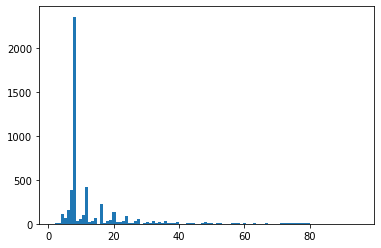

4903
second thresh =  4085
Len split1: 54877
Len split2: 11339
(len split1) / (len split2): 4.83966840109357
len(s1) / len(s2) = 4.83966840109357
Len split1: 55202
Len split2: 11014
(len split1) / (len split2): 5.011984746686036
len(s1) / len(s2) = 5.011984746686036

Images: 55202, Labels: 4085, Super_labels: 75
Avg img per class: 13.51, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.03, Min img per super_class: 8, max img per super_class: 6813
*********

Images: 11014, Labels: 818, Super_labels: 62
Avg img per class: 13.46, Min img per class: 2, max img per class: 86
Avg img per super_class: 177.65, Min img per super_class: 5, max img per super_class: 1344

Images: 55202, Labels: 4085, Super_labels: 75
Avg img per class: 13.51, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.03, Min img per super_class: 8, max img per super_class: 6813
********** TEST 2

Images: 11014, Labels: 818, Super_labels: 62
Avg img per class: 13.46, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8746, Labels: 3466, Super_labels: 74
Avg img per class: 2.52, Min img per class: 2, max img per class: 16
Avg img per super_class: 118.19, Min img per super_class: 2, max img per super_class: 1135
*****

Images: 46456, Labels: 4085, Super_labels: 75
Avg img per class: 11.37, Min img per class: 2, max img per class: 90
Avg img per super_class: 619.41, Min img per super_class: 6, max img per super_class: 5678


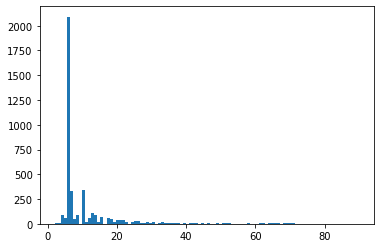

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
26  802b5ed622fd3587.jpg     90     35252
29  802beb5ad6256d35.jpg      3     26810
38  80333fc0783e27f9.jpg     42     24915
47  8039c6e66bb6e329.jpg      6      9828
********** TEST 1

Images: 8746, Labels: 3466, Super_labels: 74
Avg img per class: 2.52, Min img per class: 2, max img per class: 16
Avg img per super_class: 118.19, Min img per super_class: 2, max img per super_class: 1135
Len split1: 64718
Len split2: 12615
(len split1) / (len split2): 5.130241775663892
Len split1: 74765
Len split2: 2568
(len split1) / (len split2): 29.114096573208723
Len split1: 71165
Len split2: 6168
(len split1) / (len split2): 11.537775616083009
Len split1: 63908
Len s

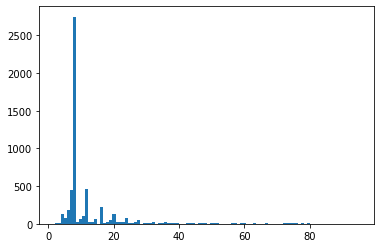

5381
second thresh =  4484
Len split1: 56016
Len split2: 10309
(len split1) / (len split2): 5.433698709865166
len(s1) / len(s2) = 5.433698709865166
Len split1: 55191
Len split2: 11134
(len split1) / (len split2): 4.956978624034489
len(s1) / len(s2) = 4.956978624034489

Images: 55191, Labels: 4484, Super_labels: 74
Avg img per class: 12.31, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.82, Min img per super_class: 6, max img per super_class: 6371
*********

Images: 11134, Labels: 897, Super_labels: 61
Avg img per class: 12.41, Min img per class: 2, max img per class: 81
Avg img per super_class: 182.52, Min img per super_class: 2, max img per super_class: 1786

Images: 55191, Labels: 4484, Super_labels: 74
Avg img per class: 12.31, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.82, Min img per super_class: 6, max img per super_class: 6371
********** TEST 2

Images: 11134, Labels: 897, Super_labels: 61
Avg img per class: 12.41, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9096, Labels: 3771, Super_labels: 73
Avg img per class: 2.41, Min img per class: 2, max img per class: 16
Avg img per super_class: 124.6, Min img per super_class: 2, max img per super_class: 1116
*****

Images: 46095, Labels: 4484, Super_labels: 74
Avg img per class: 10.28, Min img per class: 2, max img per class: 89
Avg img per super_class: 622.91, Min img per super_class: 6, max img per super_class: 5255


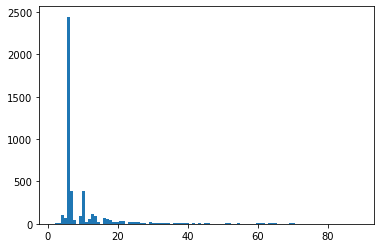

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
47  8039c6e66bb6e329.jpg      6      9828
51  803b5bf6a65459c9.jpg     89      8766
54  803c53933678ed97.jpg      8     58850
62  803e97593d9ec1e1.jpg      3     28721
********** TEST 1

Images: 9096, Labels: 3771, Super_labels: 73
Avg img per class: 2.41, Min img per class: 2, max img per class: 16
Avg img per super_class: 124.6, Min img per super_class: 2, max img per super_class: 1116
Len split1: 50146
Len split2: 27187
(len split1) / (len split2): 1.844484496266598
Len split1: 69361
Len split2: 7972
(len split1) / (len split2): 8.70057701956849
Len split1: 67282
Len split2: 10051
(len split1) / (len split2): 6.694060292508208
Len split1: 64940
Le

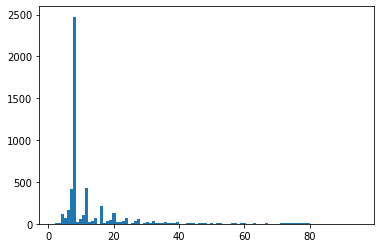

5059
second thresh =  4215
Len split1: 54723
Len split2: 11570
(len split1) / (len split2): 4.729732065687122
len(s1) / len(s2) = 4.729732065687122
Len split1: 54737
Len split2: 11556
(len split1) / (len split2): 4.736673589477328
len(s1) / len(s2) = 4.736673589477328
Len split1: 54584
Len split2: 11709
(len split1) / (len split2): 4.6617132120591
len(s1) / len(s2) = 4.6617132120591
Len split1: 54834
Len split2: 11459
(len split1) / (len split2): 4.785234313639934
len(s1) / len(s2) = 4.785234313639934
Len split1: 55489
Len split2: 10804
(len split1) / (len split2): 5.135968159940763
len(s1) / len(s2) = 5.135968159940763
Len split1: 55121
Len split2: 11172
(len split1) / (len split2): 4.933852488363766
len(s1) / len(s2) = 4.933852488363766
Len split1: 54767
Len split2: 11526
(len split1) / (len split2): 4.7516050668054834
len(s1) / len(s2) = 4.7516050668054834
Len split1: 55451
Len split2: 10842
(len split1) / (len split2): 5.11446227633278
len(s1) / len(s2) = 5.11446227633278
Len split

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8914, Labels: 3561, Super_labels: 72
Avg img per class: 2.5, Min img per class: 2, max img per class: 19
Avg img per super_class: 123.81, Min img per super_class: 2, max img per super_class: 971
*****

Images: 46349, Labels: 4215, Super_labels: 73
Avg img per class: 11.0, Min img per class: 2, max img per class: 84
Avg img per super_class: 634.92, Min img per super_class: 6, max img per super_class: 4462


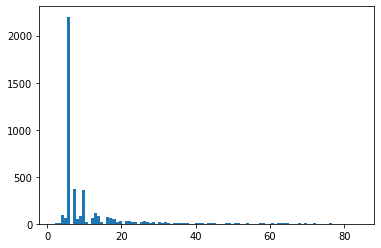

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
5   800a7ffa85c57a3a.jpg      3     25583
6   800bafacb4555b2f.jpg     82      6261
9   80196e6999ce63cf.jpg     90     55532
21  802a75e51eda5c67.jpg      9      5388
********** TEST 1

Images: 8914, Labels: 3561, Super_labels: 72
Avg img per class: 2.5, Min img per class: 2, max img per class: 19
Avg img per super_class: 123.81, Min img per super_class: 2, max img per super_class: 971
Len split1: 64439
Len split2: 12894
(len split1) / (len split2): 4.997595780983403
Len split1: 53550
Len split2: 23783
(len split1) / (len split2): 2.2516082916368836
Len split1: 68937
Len split2: 8396
(len split1) / (len split2): 8.210695569318723
Len split1: 71713
L

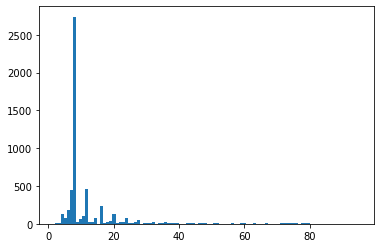

5362
second thresh =  4468
Len split1: 55304
Len split2: 10924
(len split1) / (len split2): 5.062614426949835
len(s1) / len(s2) = 5.062614426949835
Len split1: 55025
Len split2: 11203
(len split1) / (len split2): 4.911630813175043
len(s1) / len(s2) = 4.911630813175043
Len split1: 55109
Len split2: 11119
(len split1) / (len split2): 4.95629103336631
len(s1) / len(s2) = 4.95629103336631

Images: 55109, Labels: 4468, Super_labels: 74
Avg img per class: 12.33, Min img per class: 2, max img per class: 95
Avg img per super_class: 744.72, Min img per super_class: 7, max img per super_class: 7048
*********

Images: 11119, Labels: 894, Super_labels: 67
Avg img per class: 12.44, Min img per class: 2, max img per class: 84
Avg img per super_class: 165.96, Min img per super_class: 4, max img per super_class: 1109

Images: 55109, Labels: 4468, Super_labels: 74
Avg img per class: 12.33, Min img per class: 2, max img per class: 95
Avg img per super_class: 744.72, Min img per super_class: 7, max img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9098, Labels: 3766, Super_labels: 73
Avg img per class: 2.42, Min img per class: 2, max img per class: 16
Avg img per super_class: 124.63, Min img per super_class: 2, max img per super_class: 1190
*****

Images: 46011, Labels: 4468, Super_labels: 74
Avg img per class: 10.3, Min img per class: 2, max img per class: 89
Avg img per super_class: 621.77, Min img per super_class: 6, max img per super_class: 5858


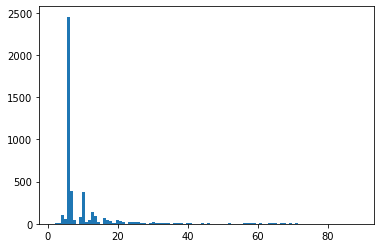

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
62  803e97593d9ec1e1.jpg      3     28721
67  803f07609d6fd25d.jpg     80     21881
72  803f56836ee50d5e.jpg     68     56874
********** TEST 1

Images: 9098, Labels: 3766, Super_labels: 73
Avg img per class: 2.42, Min img per class: 2, max img per class: 16
Avg img per super_class: 124.63, Min img per super_class: 2, max img per super_class: 1190
Len split1: 59298
Len split2: 18035
(len split1) / (len split2): 3.287940116440255
Len split1: 67872
Len split2: 9461
(len split1) / (len split2): 7.17387168375436
Len split1: 72744
Len split2: 4589
(len split1) / (len split2): 15.85181956853345
Len split1: 75544
Le

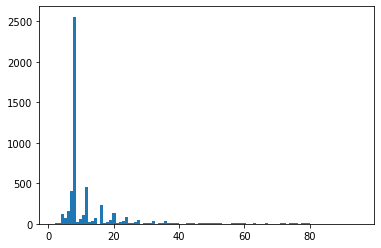

5161
second thresh =  4300
Len split1: 54973
Len split2: 11296
(len split1) / (len split2): 4.866589943342777
len(s1) / len(s2) = 4.866589943342777
Len split1: 55758
Len split2: 10511
(len split1) / (len split2): 5.304728379792598
len(s1) / len(s2) = 5.304728379792598
Len split1: 55055
Len split2: 11214
(len split1) / (len split2): 4.909488139825219
len(s1) / len(s2) = 4.909488139825219
Len split1: 55292
Len split2: 10977
(len split1) / (len split2): 5.037077525735629
len(s1) / len(s2) = 5.037077525735629

Images: 55292, Labels: 4300, Super_labels: 75
Avg img per class: 12.86, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.23, Min img per super_class: 8, max img per super_class: 6565
*********

Images: 10977, Labels: 861, Super_labels: 63
Avg img per class: 12.75, Min img per class: 2, max img per class: 78
Avg img per super_class: 174.24, Min img per super_class: 8, max img per super_class: 1592

Images: 55292, Labels: 4300, Super_labels: 75
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9033, Labels: 3648, Super_labels: 73
Avg img per class: 2.48, Min img per class: 2, max img per class: 15
Avg img per super_class: 123.74, Min img per super_class: 2, max img per super_class: 1110
*****

Images: 46259, Labels: 4300, Super_labels: 75
Avg img per class: 10.76, Min img per class: 2, max img per class: 86
Avg img per super_class: 616.79, Min img per super_class: 6, max img per super_class: 5455


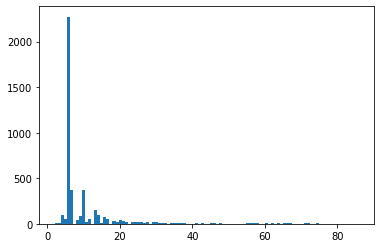

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
9   80196e6999ce63cf.jpg     90     55532
20  802a5f42fdf0ab95.jpg     89     43666
28  802bd28ddce08fbd.jpg      6     25918
30  802beb95d5aac0d7.jpg     78     50595
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 9033, Labels: 3648, Super_labels: 73
Avg img per class: 2.48, Min img per class: 2, max img per class: 15
Avg img per super_class: 123.74, Min img per super_class: 2, max img per super_class: 1110
Len split1: 70085
Len split2: 7248
(len split1) / (len split2): 9.669564017660043
Len split1: 59697
Len split2: 17636
(len split1) / (len split2): 3.384951236107961
Len split1: 68119
Len split2: 9214
(len split1) / (len split2): 7.392988929889299
Len split1: 65807
L

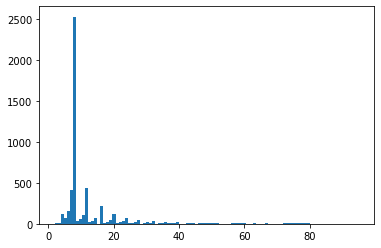

5099
second thresh =  4249
Len split1: 55070
Len split2: 11242
(len split1) / (len split2): 4.898594556128803
len(s1) / len(s2) = 4.898594556128803
Len split1: 55277
Len split2: 11035
(len split1) / (len split2): 5.0092433167195285
len(s1) / len(s2) = 5.0092433167195285

Images: 55277, Labels: 4249, Super_labels: 74
Avg img per class: 13.01, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.99, Min img per super_class: 8, max img per super_class: 6770
*********

Images: 11035, Labels: 850, Super_labels: 57
Avg img per class: 12.98, Min img per class: 2, max img per class: 84
Avg img per super_class: 193.6, Min img per super_class: 7, max img per super_class: 1387

Images: 55277, Labels: 4249, Super_labels: 74
Avg img per class: 13.01, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.99, Min img per super_class: 8, max img per super_class: 6770
********** TEST 2

Images: 11035, Labels: 850, Super_labels: 57
Avg img per class: 12.98, Min img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8947, Labels: 3596, Super_labels: 73
Avg img per class: 2.49, Min img per class: 2, max img per class: 19
Avg img per super_class: 122.56, Min img per super_class: 2, max img per super_class: 1131
*****

Images: 46330, Labels: 4249, Super_labels: 74
Avg img per class: 10.9, Min img per class: 2, max img per class: 83
Avg img per super_class: 626.08, Min img per super_class: 6, max img per super_class: 5639


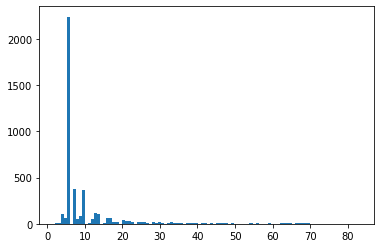

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
17  80296afd55d516ea.jpg      5     44677
21  802a75e51eda5c67.jpg      9      5388
27  802b7e9095d5fe2a.jpg      5     21723
28  802bd28ddce08fbd.jpg      6     25918
********** TEST 1

Images: 8947, Labels: 3596, Super_labels: 73
Avg img per class: 2.49, Min img per class: 2, max img per class: 19
Avg img per super_class: 122.56, Min img per super_class: 2, max img per super_class: 1131
Len split1: 72894
Len split2: 4439
(len split1) / (len split2): 16.42126605091237
Len split1: 71736
Len split2: 5597
(len split1) / (len split2): 12.816866178309809
Len split1: 70389
Len split2: 6944
(len split1) / (len split2): 10.13666474654378
Len split1: 63714
L

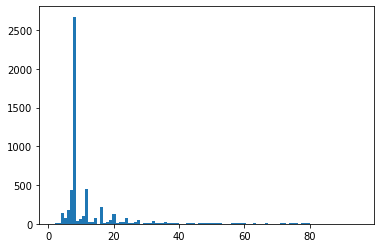

5277
second thresh =  4397
Len split1: 54801
Len split2: 11495
(len split1) / (len split2): 4.767377120487168
len(s1) / len(s2) = 4.767377120487168
Len split1: 55067
Len split2: 11229
(len split1) / (len split2): 4.903998575117998
len(s1) / len(s2) = 4.903998575117998
Len split1: 55378
Len split2: 10918
(len split1) / (len split2): 5.072174390914086
len(s1) / len(s2) = 5.072174390914086
Len split1: 54784
Len split2: 11512
(len split1) / (len split2): 4.758860319666435
len(s1) / len(s2) = 4.758860319666435
Len split1: 55597
Len split2: 10699
(len split1) / (len split2): 5.196466959528928
len(s1) / len(s2) = 5.196466959528928
Len split1: 55211
Len split2: 11085
(len split1) / (len split2): 4.980694632386108
len(s1) / len(s2) = 4.980694632386108

Images: 55211, Labels: 4397, Super_labels: 75
Avg img per class: 12.56, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.15, Min img per super_class: 8, max img per super_class: 6863
*********

Images: 11085, Labels: 880, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8899, Labels: 3695, Super_labels: 74
Avg img per class: 2.41, Min img per class: 2, max img per class: 15
Avg img per super_class: 120.26, Min img per super_class: 2, max img per super_class: 1132
*****

Images: 46312, Labels: 4397, Super_labels: 75
Avg img per class: 10.53, Min img per class: 2, max img per class: 84
Avg img per super_class: 617.49, Min img per super_class: 6, max img per super_class: 5731


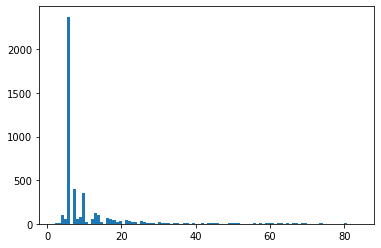

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
21  802a75e51eda5c67.jpg      9      5388
26  802b5ed622fd3587.jpg     90     35252
47  8039c6e66bb6e329.jpg      6      9828
48  803a7f95384ebc63.jpg     89      1779
********** TEST 1

Images: 8899, Labels: 3695, Super_labels: 74
Avg img per class: 2.41, Min img per class: 2, max img per class: 15
Avg img per super_class: 120.26, Min img per super_class: 2, max img per super_class: 1132
Len split1: 65855
Len split2: 11478
(len split1) / (len split2): 5.737497821920195
Len split1: 54415
Len split2: 22918
(len split1) / (len split2): 2.3743345841696484
Len split1: 69366
Len split2: 7967
(len split1) / (len split2): 8.706664993096522
Len split1: 68088
Len s

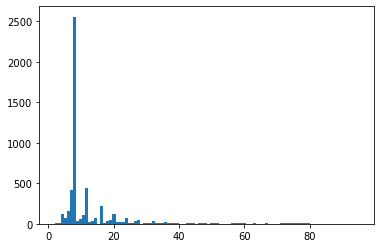

5134
second thresh =  4278
Len split1: 54978
Len split2: 11249
(len split1) / (len split2): 4.8873677660236465
len(s1) / len(s2) = 4.8873677660236465
Len split1: 55847
Len split2: 10380
(len split1) / (len split2): 5.380250481695568
len(s1) / len(s2) = 5.380250481695568
Len split1: 55170
Len split2: 11057
(len split1) / (len split2): 4.989599348828796
len(s1) / len(s2) = 4.989599348828796

Images: 55170, Labels: 4278, Super_labels: 74
Avg img per class: 12.9, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.54, Min img per super_class: 8, max img per super_class: 6630
*********

Images: 11057, Labels: 856, Super_labels: 62
Avg img per class: 12.92, Min img per class: 2, max img per class: 95
Avg img per super_class: 178.34, Min img per super_class: 5, max img per super_class: 1527

Images: 55170, Labels: 4278, Super_labels: 74
Avg img per class: 12.9, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.54, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8966, Labels: 3612, Super_labels: 73
Avg img per class: 2.48, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.82, Min img per super_class: 2, max img per super_class: 1125
*****

Images: 46204, Labels: 4278, Super_labels: 74
Avg img per class: 10.8, Min img per class: 2, max img per class: 84
Avg img per super_class: 624.38, Min img per super_class: 6, max img per super_class: 5505


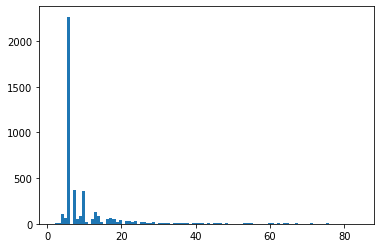

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
17  80296afd55d516ea.jpg      5     44677
31  802ddd0a3f70a9f5.jpg     87     18450
32  802f65855fd85b87.jpg      5     34702
52  803b5ed0d6037b3e.jpg      5     16791
59  803e5f0fe8e00f75.jpg     90     20762
********** TEST 1

Images: 8966, Labels: 3612, Super_labels: 73
Avg img per class: 2.48, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.82, Min img per super_class: 2, max img per super_class: 1125
Len split1: 70272
Len split2: 7061
(len split1) / (len split2): 9.952131426143605
Len split1: 65979
Len split2: 11354
(len split1) / (len split2): 5.811079795666726
Len split1: 59914
Len split2: 17419
(len split1) / (len split2): 3.4395774728744475
Len split1: 62828

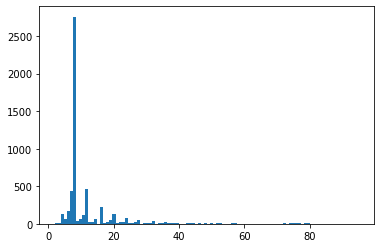

5380
second thresh =  4483
Len split1: 54962
Len split2: 11248
(len split1) / (len split2): 4.886379800853485
len(s1) / len(s2) = 4.886379800853485
Len split1: 54917
Len split2: 11293
(len split1) / (len split2): 4.862923935181086
len(s1) / len(s2) = 4.862923935181086
Len split1: 55617
Len split2: 10593
(len split1) / (len split2): 5.250354007363353
len(s1) / len(s2) = 5.250354007363353
Len split1: 55307
Len split2: 10903
(len split1) / (len split2): 5.072640557644685
len(s1) / len(s2) = 5.072640557644685
Len split1: 55070
Len split2: 11140
(len split1) / (len split2): 4.943447037701975
len(s1) / len(s2) = 4.943447037701975
Len split1: 55016
Len split2: 11194
(len split1) / (len split2): 4.914775772735394
len(s1) / len(s2) = 4.914775772735394
Len split1: 55025
Len split2: 11185
(len split1) / (len split2): 4.91953509164059
len(s1) / len(s2) = 4.91953509164059
Len split1: 55063
Len split2: 11147
(len split1) / (len split2): 4.939714721449717
len(s1) / len(s2) = 4.939714721449717
Len spl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9108, Labels: 3794, Super_labels: 74
Avg img per class: 2.4, Min img per class: 2, max img per class: 16
Avg img per super_class: 123.08, Min img per super_class: 2, max img per super_class: 1188
*****

Images: 46118, Labels: 4483, Super_labels: 75
Avg img per class: 10.29, Min img per class: 2, max img per class: 83
Avg img per super_class: 614.91, Min img per super_class: 6, max img per super_class: 5665


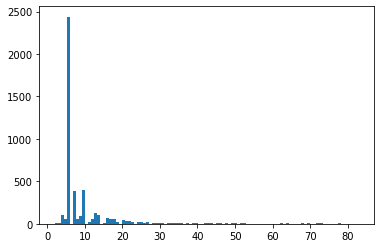

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
17  80296afd55d516ea.jpg      5     44677
32  802f65855fd85b87.jpg      5     34702
38  80333fc0783e27f9.jpg     42     24915
54  803c53933678ed97.jpg      8     58850
55  803d7a43427ff585.jpg     71     17105
********** TEST 1

Images: 9108, Labels: 3794, Super_labels: 74
Avg img per class: 2.4, Min img per class: 2, max img per class: 16
Avg img per super_class: 123.08, Min img per super_class: 2, max img per super_class: 1188
Len split1: 69936
Len split2: 7397
(len split1) / (len split2): 9.454643774503177
Len split1: 63461
Len split2: 13872
(len split1) / (len split2): 4.574754901960785
Len split1: 68131
Len split2: 9202
(len split1) / (len split2): 7.403933927407086
Len split1: 59395
Le

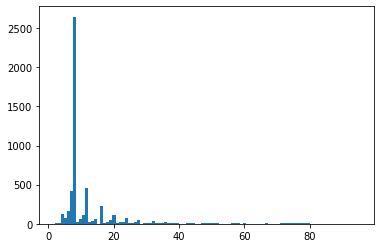

5237
second thresh =  4364
Len split1: 55660
Len split2: 10687
(len split1) / (len split2): 5.208196874707589
len(s1) / len(s2) = 5.208196874707589
Len split1: 55058
Len split2: 11289
(len split1) / (len split2): 4.877137036052795
len(s1) / len(s2) = 4.877137036052795
Len split1: 55528
Len split2: 10819
(len split1) / (len split2): 5.132452167483131
len(s1) / len(s2) = 5.132452167483131
Len split1: 55349
Len split2: 10998
(len split1) / (len split2): 5.032642298599745
len(s1) / len(s2) = 5.032642298599745

Images: 55349, Labels: 4364, Super_labels: 75
Avg img per class: 12.68, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.99, Min img per super_class: 6, max img per super_class: 6883
*********

Images: 10998, Labels: 873, Super_labels: 63
Avg img per class: 12.6, Min img per class: 2, max img per class: 82
Avg img per super_class: 174.57, Min img per super_class: 5, max img per super_class: 1274

Images: 55349, Labels: 4364, Super_labels: 75
Avg img per class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9049, Labels: 3694, Super_labels: 74
Avg img per class: 2.45, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.28, Min img per super_class: 2, max img per super_class: 1191
*****

Images: 46300, Labels: 4364, Super_labels: 75
Avg img per class: 10.61, Min img per class: 2, max img per class: 87
Avg img per super_class: 617.33, Min img per super_class: 6, max img per super_class: 5692


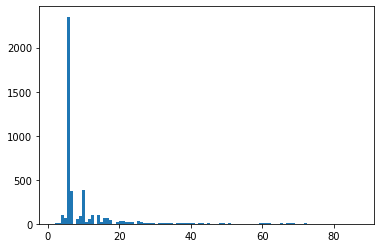

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
32  802f65855fd85b87.jpg      5     34702
48  803a7f95384ebc63.jpg     89      1779
64  803edda1d29625eb.jpg      4     24695
69  803f408bbeb26eb5.jpg      6     11256
********** TEST 1

Images: 9049, Labels: 3694, Super_labels: 74
Avg img per class: 2.45, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.28, Min img per super_class: 2, max img per super_class: 1191
Len split1: 70061
Len split2: 7272
(len split1) / (len split2): 9.63435093509351
Len split1: 71038
Len split2: 6295
(len split1) / (len split2): 11.28482922954726
Len split1: 66697
Len split2: 10636
(len split1) / (len split2): 6.270872508461828
Len split1: 72385
Le

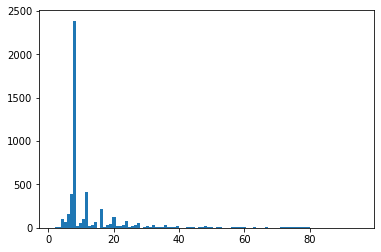

4930
second thresh =  4108
Len split1: 55343
Len split2: 10900
(len split1) / (len split2): 5.0773394495412845
len(s1) / len(s2) = 5.0773394495412845
Len split1: 55179
Len split2: 11064
(len split1) / (len split2): 4.987255965292841
len(s1) / len(s2) = 4.987255965292841

Images: 55179, Labels: 4108, Super_labels: 75
Avg img per class: 13.43, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.72, Min img per super_class: 8, max img per super_class: 7014
*********

Images: 11064, Labels: 822, Super_labels: 62
Avg img per class: 13.46, Min img per class: 2, max img per class: 84
Avg img per super_class: 178.45, Min img per super_class: 8, max img per super_class: 1143

Images: 55179, Labels: 4108, Super_labels: 75
Avg img per class: 13.43, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.72, Min img per super_class: 8, max img per super_class: 7014
********** TEST 2

Images: 11064, Labels: 822, Super_labels: 62
Avg img per class: 13.46, Min im

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8710, Labels: 3487, Super_labels: 75
Avg img per class: 2.5, Min img per class: 2, max img per class: 16
Avg img per super_class: 116.13, Min img per super_class: 2, max img per super_class: 1158
*****

Images: 46469, Labels: 4108, Super_labels: 75
Avg img per class: 11.31, Min img per class: 2, max img per class: 90
Avg img per super_class: 619.59, Min img per super_class: 6, max img per super_class: 5856


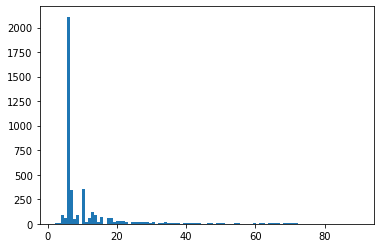

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
31  802ddd0a3f70a9f5.jpg     87     18450
39  803570c58f9ba1f7.jpg     87     37779
49  803abbf5482e3b93.jpg     87      5210
55  803d7a43427ff585.jpg     71     17105
********** TEST 1

Images: 8710, Labels: 3487, Super_labels: 75
Avg img per class: 2.5, Min img per class: 2, max img per class: 16
Avg img per super_class: 116.13, Min img per super_class: 2, max img per super_class: 1158
Len split1: 69414
Len split2: 7919
(len split1) / (len split2): 8.765500694532138
Len split1: 66683
Len split2: 10650
(len split1) / (len split2): 6.26131455399061
Len split1: 68893
Len split2: 8440
(len split1) / (len split2): 8.162677725118483
Len split1: 72377
Len

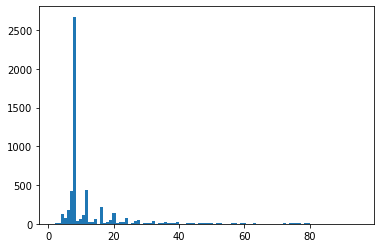

5276
second thresh =  4396
Len split1: 54580
Len split2: 11672
(len split1) / (len split2): 4.676148046607265
len(s1) / len(s2) = 4.676148046607265
Len split1: 55344
Len split2: 10908
(len split1) / (len split2): 5.073707370737074
len(s1) / len(s2) = 5.073707370737074
Len split1: 55345
Len split2: 10907
(len split1) / (len split2): 5.074264233978179
len(s1) / len(s2) = 5.074264233978179
Len split1: 54898
Len split2: 11354
(len split1) / (len split2): 4.835124185309142
len(s1) / len(s2) = 4.835124185309142
Len split1: 55200
Len split2: 11052
(len split1) / (len split2): 4.99457111834962
len(s1) / len(s2) = 4.99457111834962

Images: 55200, Labels: 4396, Super_labels: 74
Avg img per class: 12.56, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.95, Min img per super_class: 7, max img per super_class: 6749
*********

Images: 11052, Labels: 880, Super_labels: 63
Avg img per class: 12.56, Min img per class: 2, max img per class: 92
Avg img per super_class: 175.43, Min

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9089, Labels: 3717, Super_labels: 73
Avg img per class: 2.45, Min img per class: 2, max img per class: 15
Avg img per super_class: 124.51, Min img per super_class: 2, max img per super_class: 1150
*****

Images: 46111, Labels: 4396, Super_labels: 74
Avg img per class: 10.49, Min img per class: 2, max img per class: 87
Avg img per super_class: 623.12, Min img per super_class: 6, max img per super_class: 5599


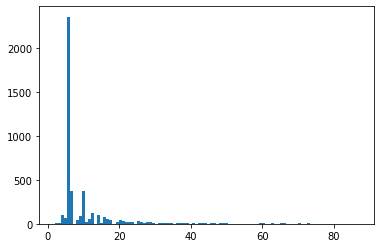

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
11  801aff45ebd0bcd0.jpg     78     26666
28  802bd28ddce08fbd.jpg      6     25918
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 9089, Labels: 3717, Super_labels: 73
Avg img per class: 2.45, Min img per class: 2, max img per class: 15
Avg img per super_class: 124.51, Min img per super_class: 2, max img per super_class: 1150
Len split1: 62442
Len split2: 14891
(len split1) / (len split2): 4.193271103351018
Len split1: 67646
Len split2: 9687
(len split1) / (len split2): 6.9831733250748425
Len split1: 54601
Len split2: 22732
(len split1) / (len split2): 2.4019443955657223
Len split1: 6417

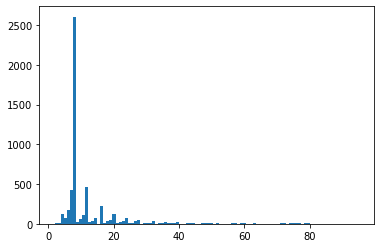

5232
second thresh =  4360
Len split1: 55016
Len split2: 11202
(len split1) / (len split2): 4.911265845384753
len(s1) / len(s2) = 4.911265845384753
Len split1: 54883
Len split2: 11335
(len split1) / (len split2): 4.841905602117336
len(s1) / len(s2) = 4.841905602117336
Len split1: 55195
Len split2: 11023
(len split1) / (len split2): 5.007257552390456
len(s1) / len(s2) = 5.007257552390456

Images: 55195, Labels: 4360, Super_labels: 75
Avg img per class: 12.66, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.93, Min img per super_class: 8, max img per super_class: 6809
*********

Images: 11023, Labels: 872, Super_labels: 62
Avg img per class: 12.64, Min img per class: 2, max img per class: 83
Avg img per super_class: 177.79, Min img per super_class: 8, max img per super_class: 1348

Images: 55195, Labels: 4360, Super_labels: 75
Avg img per class: 12.66, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.93, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8960, Labels: 3672, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 18
Avg img per super_class: 121.08, Min img per super_class: 2, max img per super_class: 1117
*****

Images: 46235, Labels: 4360, Super_labels: 75
Avg img per class: 10.6, Min img per class: 2, max img per class: 90
Avg img per super_class: 616.47, Min img per super_class: 6, max img per super_class: 5692


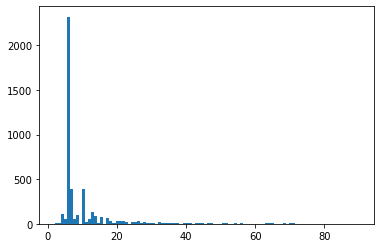

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
7   800e7dd55ffa4056.jpg      2     60181
27  802b7e9095d5fe2a.jpg      5     21723
31  802ddd0a3f70a9f5.jpg     87     18450
51  803b5bf6a65459c9.jpg     89      8766
61  803e7b9595fa2a25.jpg      6     15263
********** TEST 1

Images: 8960, Labels: 3672, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 18
Avg img per super_class: 121.08, Min img per super_class: 2, max img per super_class: 1117
Len split1: 67560
Len split2: 9773
(len split1) / (len split2): 6.9129233602783176
Len split1: 71357
Len split2: 5976
(len split1) / (len split2): 11.940595716198127
Len split1: 67947
Len split2: 9386
(len split1) / (len split2): 7.239186021734498
Len split1: 59702


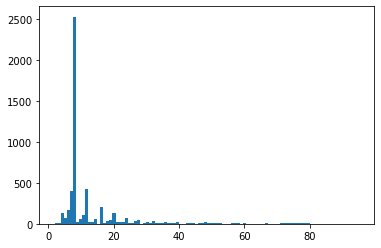

5098
second thresh =  4248
Len split1: 55152
Len split2: 11181
(len split1) / (len split2): 4.932653608800644
len(s1) / len(s2) = 4.932653608800644
Len split1: 54786
Len split2: 11547
(len split1) / (len split2): 4.744608989347882
len(s1) / len(s2) = 4.744608989347882
Len split1: 55605
Len split2: 10728
(len split1) / (len split2): 5.183165548098434
len(s1) / len(s2) = 5.183165548098434
Len split1: 55137
Len split2: 11196
(len split1) / (len split2): 4.92470525187567
len(s1) / len(s2) = 4.92470525187567
Len split1: 55545
Len split2: 10788
(len split1) / (len split2): 5.148776418242492
len(s1) / len(s2) = 5.148776418242492
Len split1: 55648
Len split2: 10685
(len split1) / (len split2): 5.208048666354703
len(s1) / len(s2) = 5.208048666354703
Len split1: 54556
Len split2: 11777
(len split1) / (len split2): 4.632419122017492
len(s1) / len(s2) = 4.632419122017492
Len split1: 55029
Len split2: 11304
(len split1) / (len split2): 4.868099787685775
len(s1) / len(s2) = 4.868099787685775
Len spl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8941, Labels: 3590, Super_labels: 74
Avg img per class: 2.49, Min img per class: 2, max img per class: 16
Avg img per super_class: 120.82, Min img per super_class: 2, max img per super_class: 1149
*****

Images: 46415, Labels: 4248, Super_labels: 75
Avg img per class: 10.93, Min img per class: 2, max img per class: 93
Avg img per super_class: 618.87, Min img per super_class: 6, max img per super_class: 5813


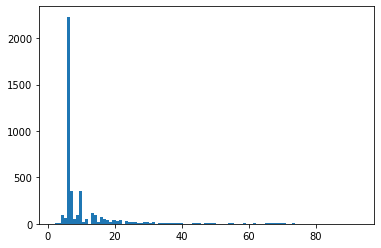

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
206  807e68855eeaa1d7.jpg      5     52125
                  image  chain  hotel_id
0  8000d59f6a3d765f.jpg     85     24607
1  8000febe81817f7f.jpg      6     25389
3  8007fa0a8fe89f9d.jpg      5     63866
5  800a7ffa85c57a3a.jpg      3     25583
9  80196e6999ce63cf.jpg     90     55532
********** TEST 1

Images: 8941, Labels: 3590, Super_labels: 74
Avg img per class: 2.49, Min img per class: 2, max img per class: 16
Avg img per super_class: 120.82, Min img per super_class: 2, max img per super_class: 1149
Len split1: 65400
Len split2: 11933
(len split1) / (len split2): 5.480600016760245
Len split1: 70799
Len split2: 6534
(len split1) / (len split2): 10.835475971839609
Len split1: 65245
Len split2: 12088
(len split1) / (len split2): 5.397501654533421
Len split1: 65610
Len s

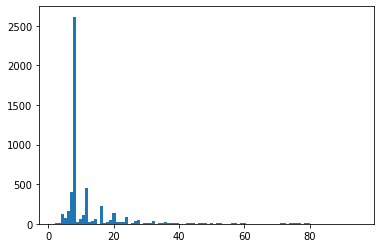

5206
second thresh =  4338
Len split1: 54910
Len split2: 11346
(len split1) / (len split2): 4.839591045302309
len(s1) / len(s2) = 4.839591045302309
Len split1: 54585
Len split2: 11671
(len split1) / (len split2): 4.676977122782966
len(s1) / len(s2) = 4.676977122782966
Len split1: 55482
Len split2: 10774
(len split1) / (len split2): 5.149619454241693
len(s1) / len(s2) = 5.149619454241693
Len split1: 55066
Len split2: 11190
(len split1) / (len split2): 4.921000893655049
len(s1) / len(s2) = 4.921000893655049
Len split1: 55311
Len split2: 10945
(len split1) / (len split2): 5.053540429419827
len(s1) / len(s2) = 5.053540429419827
Len split1: 55149
Len split2: 11107
(len split1) / (len split2): 4.965247141442334
len(s1) / len(s2) = 4.965247141442334

Images: 55149, Labels: 4338, Super_labels: 74
Avg img per class: 12.71, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.26, Min img per super_class: 8, max img per super_class: 6862
*********

Images: 11107, Labels: 868, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9097, Labels: 3667, Super_labels: 74
Avg img per class: 2.48, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.93, Min img per super_class: 2, max img per super_class: 1179
*****

Images: 46052, Labels: 4338, Super_labels: 74
Avg img per class: 10.62, Min img per class: 2, max img per class: 90
Avg img per super_class: 622.32, Min img per super_class: 6, max img per super_class: 5683


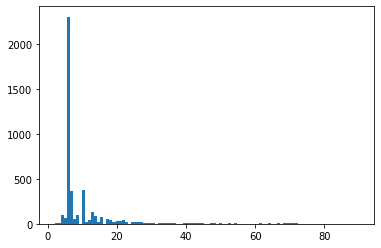

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
1   8000febe81817f7f.jpg      6     25389
24  802aef94c02bbfd5.jpg      6     62831
30  802beb95d5aac0d7.jpg     78     50595
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 9097, Labels: 3667, Super_labels: 74
Avg img per class: 2.48, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.93, Min img per super_class: 2, max img per super_class: 1179
Len split1: 62928
Len split2: 14405
(len split1) / (len split2): 4.368483165567511
Len split1: 64856
Len split2: 12477
(len split1) / (len split2): 5.198044401699127
Len split1: 61944
Len split2: 15389
(len split1) / (len split2): 4.025212814347911
Len split1: 63425

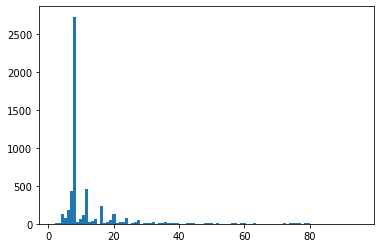

5386
second thresh =  4488
Len split1: 55115
Len split2: 11164
(len split1) / (len split2): 4.936850591185955
len(s1) / len(s2) = 4.936850591185955
Len split1: 55154
Len split2: 11125
(len split1) / (len split2): 4.957662921348315
len(s1) / len(s2) = 4.957662921348315

Images: 55154, Labels: 4488, Super_labels: 75
Avg img per class: 12.29, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.39, Min img per super_class: 8, max img per super_class: 6640
*********

Images: 11125, Labels: 898, Super_labels: 61
Avg img per class: 12.39, Min img per class: 2, max img per class: 95
Avg img per super_class: 182.38, Min img per super_class: 2, max img per super_class: 1517

Images: 55154, Labels: 4488, Super_labels: 75
Avg img per class: 12.29, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.39, Min img per super_class: 8, max img per super_class: 6640
********** TEST 2

Images: 11125, Labels: 898, Super_labels: 61
Avg img per class: 12.39, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9170, Labels: 3783, Super_labels: 74
Avg img per class: 2.42, Min img per class: 2, max img per class: 15
Avg img per super_class: 123.92, Min img per super_class: 2, max img per super_class: 1141
*****

Images: 45984, Labels: 4488, Super_labels: 75
Avg img per class: 10.25, Min img per class: 2, max img per class: 81
Avg img per super_class: 613.12, Min img per super_class: 6, max img per super_class: 5499


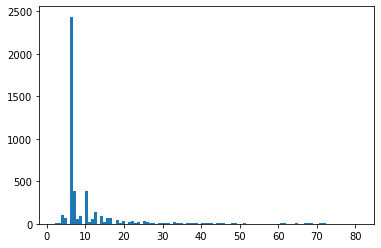

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
30  802beb95d5aac0d7.jpg     78     50595
48  803a7f95384ebc63.jpg     89      1779
49  803abbf5482e3b93.jpg     87      5210
83  803fa0bfc1472e3d.jpg     85     20004
********** TEST 1

Images: 9170, Labels: 3783, Super_labels: 74
Avg img per class: 2.42, Min img per class: 2, max img per class: 15
Avg img per super_class: 123.92, Min img per super_class: 2, max img per super_class: 1141
Len split1: 58413
Len split2: 18920
(len split1) / (len split2): 3.087367864693446
Len split1: 74074
Len split2: 3259
(len split1) / (len split2): 22.729057993249462
Len split1: 67680
Len split2: 9653
(len split1) / (len split2): 7.01129182637522
Len split1: 59346
L

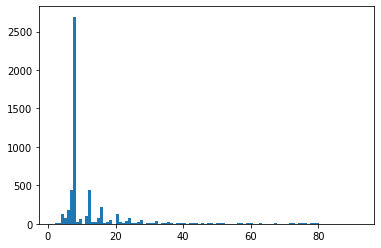

5295
second thresh =  4412
Len split1: 55019
Len split2: 11250
(len split1) / (len split2): 4.890577777777778
len(s1) / len(s2) = 4.890577777777778
Len split1: 55478
Len split2: 10791
(len split1) / (len split2): 5.14113613196182
len(s1) / len(s2) = 5.14113613196182
Len split1: 54591
Len split2: 11678
(len split1) / (len split2): 4.6746874464805614
len(s1) / len(s2) = 4.6746874464805614
Len split1: 54595
Len split2: 11674
(len split1) / (len split2): 4.67663183142025
len(s1) / len(s2) = 4.67663183142025
Len split1: 55326
Len split2: 10943
(len split1) / (len split2): 5.055834780224801
len(s1) / len(s2) = 5.055834780224801
Len split1: 55456
Len split2: 10813
(len split1) / (len split2): 5.128641450106353
len(s1) / len(s2) = 5.128641450106353
Len split1: 55239
Len split2: 11030
(len split1) / (len split2): 5.00806890299184
len(s1) / len(s2) = 5.00806890299184

Images: 55239, Labels: 4412, Super_labels: 75
Avg img per class: 12.52, Min img per class: 2, max img per class: 92
Avg img per s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9032, Labels: 3721, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.05, Min img per super_class: 2, max img per super_class: 1139
*****

Images: 46207, Labels: 4412, Super_labels: 75
Avg img per class: 10.47, Min img per class: 2, max img per class: 88
Avg img per super_class: 616.09, Min img per super_class: 6, max img per super_class: 5710


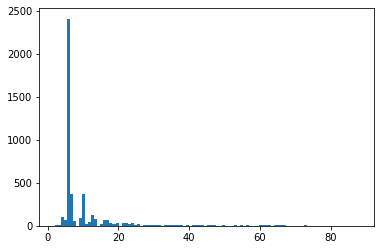

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
11  801aff45ebd0bcd0.jpg     78     26666
29  802beb5ad6256d35.jpg      3     26810
50  803aff8f12e0519f.jpg     68     63331
51  803b5bf6a65459c9.jpg     89      8766
62  803e97593d9ec1e1.jpg      3     28721
********** TEST 1

Images: 9032, Labels: 3721, Super_labels: 74
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.05, Min img per super_class: 2, max img per super_class: 1139
Len split1: 62964
Len split2: 14369
(len split1) / (len split2): 4.381933328693716
Len split1: 70800
Len split2: 6533
(len split1) / (len split2): 10.83728761671514
Len split1: 66593
Len split2: 10740
(len split1) / (len split2): 6.200465549348231
Len split1: 70143


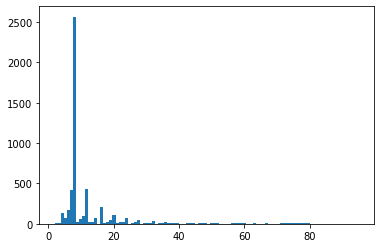

5122
second thresh =  4268
Len split1: 54608
Len split2: 11656
(len split1) / (len split2): 4.68496911461908
len(s1) / len(s2) = 4.68496911461908
Len split1: 54689
Len split2: 11575
(len split1) / (len split2): 4.7247516198704105
len(s1) / len(s2) = 4.7247516198704105
Len split1: 54627
Len split2: 11637
(len split1) / (len split2): 4.694251095643207
len(s1) / len(s2) = 4.694251095643207
Len split1: 55291
Len split2: 10973
(len split1) / (len split2): 5.038822564476442
len(s1) / len(s2) = 5.038822564476442

Images: 55291, Labels: 4268, Super_labels: 73
Avg img per class: 12.95, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.41, Min img per super_class: 8, max img per super_class: 6989
*********

Images: 10973, Labels: 854, Super_labels: 63
Avg img per class: 12.85, Min img per class: 2, max img per class: 82
Avg img per super_class: 174.17, Min img per super_class: 5, max img per super_class: 1168

Images: 55291, Labels: 4268, Super_labels: 73
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8824, Labels: 3579, Super_labels: 72
Avg img per class: 2.47, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.56, Min img per super_class: 2, max img per super_class: 1158
*****

Images: 46467, Labels: 4268, Super_labels: 73
Avg img per class: 10.89, Min img per class: 2, max img per class: 82
Avg img per super_class: 636.53, Min img per super_class: 6, max img per super_class: 5831


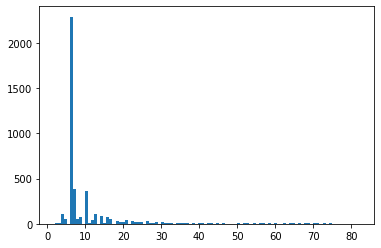

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
52  803b5ed0d6037b3e.jpg      5     16791
63  803ed522df8c40ff.jpg     78     62362
77  803f78814d9f3a97.jpg     89     23762
84  803fa821d69a7b75.jpg     82      4868
********** TEST 1

Images: 8824, Labels: 3579, Super_labels: 72
Avg img per class: 2.47, Min img per class: 2, max img per class: 17
Avg img per super_class: 122.56, Min img per super_class: 2, max img per super_class: 1158
Len split1: 65887
Len split2: 11446
(len split1) / (len split2): 5.756334090511969
Len split1: 72548
Len split2: 4785
(len split1) / (len split2): 15.161546499477534
Len split1: 67739
Len split2: 9594
(len split1) / (len split2): 7.060558682509902
Len split1: 74447
Len sp

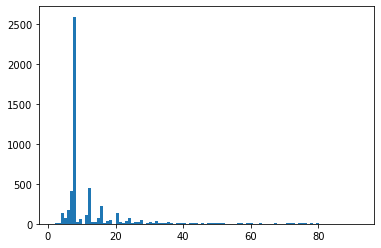

5203
second thresh =  4335
Len split1: 54983
Len split2: 11341
(len split1) / (len split2): 4.848161537783264
len(s1) / len(s2) = 4.848161537783264
Len split1: 55225
Len split2: 11099
(len split1) / (len split2): 4.975673484097666
len(s1) / len(s2) = 4.975673484097666

Images: 55225, Labels: 4335, Super_labels: 71
Avg img per class: 12.74, Min img per class: 2, max img per class: 87
Avg img per super_class: 777.82, Min img per super_class: 8, max img per super_class: 6991
*********

Images: 11099, Labels: 868, Super_labels: 65
Avg img per class: 12.79, Min img per class: 2, max img per class: 92
Avg img per super_class: 170.75, Min img per super_class: 4, max img per super_class: 1166

Images: 55225, Labels: 4335, Super_labels: 71
Avg img per class: 12.74, Min img per class: 2, max img per class: 87
Avg img per super_class: 777.82, Min img per super_class: 8, max img per super_class: 6991
********** TEST 2

Images: 11099, Labels: 868, Super_labels: 65
Avg img per class: 12.79, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9018, Labels: 3658, Super_labels: 70
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 128.83, Min img per super_class: 2, max img per super_class: 1175
*****

Images: 46207, Labels: 4335, Super_labels: 71
Avg img per class: 10.66, Min img per class: 2, max img per class: 82
Avg img per super_class: 650.8, Min img per super_class: 6, max img per super_class: 5816


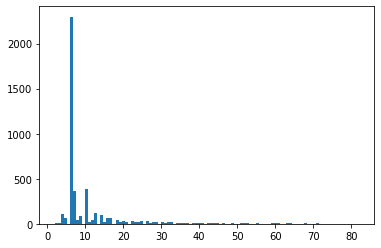

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
49  803abbf5482e3b93.jpg     87      5210
65  803eec8557fb2895.jpg      4     17623
72  803f56836ee50d5e.jpg     68     56874
92  803fe881d7dea135.jpg     73     14263
98  803ffd80caca3d35.jpg     83     36388
********** TEST 1

Images: 9018, Labels: 3658, Super_labels: 70
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 128.83, Min img per super_class: 2, max img per super_class: 1175
Len split1: 71459
Len split2: 5874
(len split1) / (len split2): 12.165304732720463
Len split1: 67230
Len split2: 10103
(len split1) / (len split2): 6.654459071562902
Len split1: 66994
Len split2: 10339
(len split1) / (len split2): 6.479736918464068
Len split1: 67893

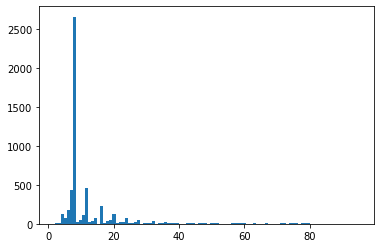

5285
second thresh =  4404
Len split1: 54987
Len split2: 11359
(len split1) / (len split2): 4.8408310590721015
len(s1) / len(s2) = 4.8408310590721015
Len split1: 55514
Len split2: 10832
(len split1) / (len split2): 5.125
len(s1) / len(s2) = 5.125
Len split1: 55361
Len split2: 10985
(len split1) / (len split2): 5.039690487027765
len(s1) / len(s2) = 5.039690487027765

Images: 55361, Labels: 4404, Super_labels: 74
Avg img per class: 12.57, Min img per class: 2, max img per class: 95
Avg img per super_class: 748.12, Min img per super_class: 6, max img per super_class: 6999
*********

Images: 10985, Labels: 881, Super_labels: 64
Avg img per class: 12.47, Min img per class: 2, max img per class: 81
Avg img per super_class: 171.64, Min img per super_class: 7, max img per super_class: 1158

Images: 55361, Labels: 4404, Super_labels: 74
Avg img per class: 12.57, Min img per class: 2, max img per class: 95
Avg img per super_class: 748.12, Min img per super_class: 6, max img per super_class: 6999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9066, Labels: 3714, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 16
Avg img per super_class: 124.19, Min img per super_class: 2, max img per super_class: 1179
*****

Images: 46295, Labels: 4404, Super_labels: 74
Avg img per class: 10.51, Min img per class: 2, max img per class: 92
Avg img per super_class: 625.61, Min img per super_class: 6, max img per super_class: 5820


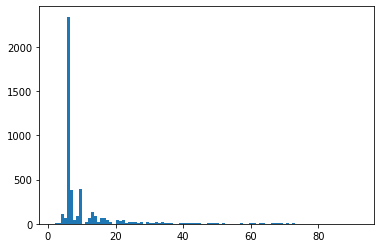

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
12  801f7ce821c7dfd0.jpg     89     27809
22  802a7af055d739e9.jpg     50     45049
27  802b7e9095d5fe2a.jpg      5     21723
********** TEST 1

Images: 9066, Labels: 3714, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 16
Avg img per super_class: 124.19, Min img per super_class: 2, max img per super_class: 1179
Len split1: 66981
Len split2: 10352
(len split1) / (len split2): 6.470343894899536
Len split1: 68051
Len split2: 9282
(len split1) / (len split2): 7.331501831501831
Len split1: 69365
Len split2: 7968
(len split1) / (len split2): 8.705446787148594
Len split1: 63603
Len spl

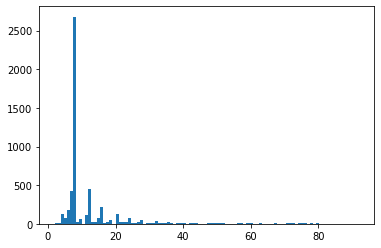

5297
second thresh =  4414
Len split1: 55898
Len split2: 10457
(len split1) / (len split2): 5.345510184565363
len(s1) / len(s2) = 5.345510184565363
Len split1: 55572
Len split2: 10783
(len split1) / (len split2): 5.1536678104423626
len(s1) / len(s2) = 5.1536678104423626
Len split1: 55649
Len split2: 10706
(len split1) / (len split2): 5.1979263964132265
len(s1) / len(s2) = 5.1979263964132265
Len split1: 55254
Len split2: 11101
(len split1) / (len split2): 4.977389424376183
len(s1) / len(s2) = 4.977389424376183

Images: 55254, Labels: 4414, Super_labels: 75
Avg img per class: 12.52, Min img per class: 2, max img per class: 92
Avg img per super_class: 736.72, Min img per super_class: 8, max img per super_class: 6740
*********

Images: 11101, Labels: 883, Super_labels: 64
Avg img per class: 12.57, Min img per class: 2, max img per class: 84
Avg img per super_class: 173.45, Min img per super_class: 7, max img per super_class: 1417

Images: 55254, Labels: 4414, Super_labels: 75
Avg img per c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9033, Labels: 3737, Super_labels: 75
Avg img per class: 2.42, Min img per class: 2, max img per class: 15
Avg img per super_class: 120.44, Min img per super_class: 2, max img per super_class: 1126
*****

Images: 46221, Labels: 4414, Super_labels: 75
Avg img per class: 10.47, Min img per class: 2, max img per class: 86
Avg img per super_class: 616.28, Min img per super_class: 6, max img per super_class: 5614


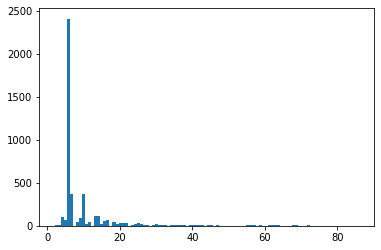

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
286  8084fead05cb5d7a.jpg      6     43451
332  80957feb10563b69.jpg     90     38194
                   image  chain  hotel_id
35  802f7ff490819fc9.jpg     87      5697
44  803733bb5bc92c17.jpg      8     53692
62  803e97593d9ec1e1.jpg      3     28721
67  803f07609d6fd25d.jpg     80     21881
70  803f50c5cc953b7b.jpg     73     46780
********** TEST 1

Images: 9033, Labels: 3737, Super_labels: 75
Avg img per class: 2.42, Min img per class: 2, max img per class: 15
Avg img per super_class: 120.44, Min img per super_class: 2, max img per super_class: 1126
Len split1: 69088
Len split2: 8245
(len split1) / (len split2): 8.37938144329897
Len split1: 59942
Len split2: 17391
(len split1) / (len split2): 3.4467253176930597
Len split1: 64997
Len split2: 12336
(len split1) / (len split2): 5.268887808041504
Len split1: 72123


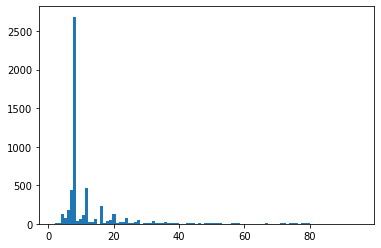

5309
second thresh =  4424
Len split1: 55661
Len split2: 10564
(len split1) / (len split2): 5.268932222642938
len(s1) / len(s2) = 5.268932222642938
Len split1: 55504
Len split2: 10721
(len split1) / (len split2): 5.1771289991605265
len(s1) / len(s2) = 5.1771289991605265
Len split1: 55069
Len split2: 11156
(len split1) / (len split2): 4.936267479383291
len(s1) / len(s2) = 4.936267479383291
Len split1: 55296
Len split2: 10929
(len split1) / (len split2): 5.05956629151798
len(s1) / len(s2) = 5.05956629151798
Len split1: 55193
Len split2: 11032
(len split1) / (len split2): 5.002991298042059
len(s1) / len(s2) = 5.002991298042059

Images: 55193, Labels: 4424, Super_labels: 74
Avg img per class: 12.48, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.85, Min img per super_class: 8, max img per super_class: 6631
*********

Images: 11032, Labels: 885, Super_labels: 60
Avg img per class: 12.47, Min img per class: 2, max img per class: 95
Avg img per super_class: 183.87, M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9031, Labels: 3721, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 17
Avg img per super_class: 123.71, Min img per super_class: 2, max img per super_class: 1120
*****

Images: 46162, Labels: 4424, Super_labels: 74
Avg img per class: 10.43, Min img per class: 2, max img per class: 81
Avg img per super_class: 623.81, Min img per super_class: 6, max img per super_class: 5511


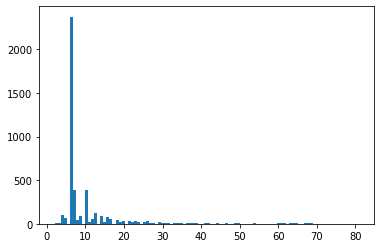

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
13  8020ee1f3f7781da.jpg     52      2498
30  802beb95d5aac0d7.jpg     78     50595
32  802f65855fd85b87.jpg      5     34702
39  803570c58f9ba1f7.jpg     87     37779
44  803733bb5bc92c17.jpg      8     53692
********** TEST 1

Images: 9031, Labels: 3721, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 17
Avg img per super_class: 123.71, Min img per super_class: 2, max img per super_class: 1120
Len split1: 59504
Len split2: 17829
(len split1) / (len split2): 3.337483874586348
Len split1: 65463
Len split2: 11870
(len split1) / (len split2): 5.514995787700085
Len split1: 55331
Len split2: 22002
(len split1) / (len split2): 2.514816834833197
Len split1: 66178
Len s

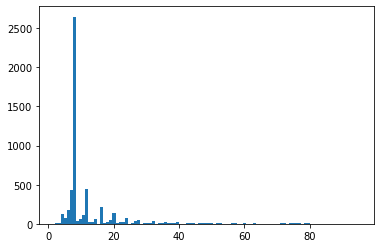

5264
second thresh =  4386
Len split1: 55597
Len split2: 10683
(len split1) / (len split2): 5.204249742581672
len(s1) / len(s2) = 5.204249742581672
Len split1: 55439
Len split2: 10841
(len split1) / (len split2): 5.113827137717923
len(s1) / len(s2) = 5.113827137717923
Len split1: 54950
Len split2: 11330
(len split1) / (len split2): 4.849955869373345
len(s1) / len(s2) = 4.849955869373345
Len split1: 54881
Len split2: 11399
(len split1) / (len split2): 4.814545135538205
len(s1) / len(s2) = 4.814545135538205
Len split1: 55031
Len split2: 11249
(len split1) / (len split2): 4.892079295937417
len(s1) / len(s2) = 4.892079295937417
Len split1: 55795
Len split2: 10485
(len split1) / (len split2): 5.32141154029566
len(s1) / len(s2) = 5.32141154029566
Len split1: 55083
Len split2: 11197
(len split1) / (len split2): 4.919442707868179
len(s1) / len(s2) = 4.919442707868179
Len split1: 55500
Len split2: 10780
(len split1) / (len split2): 5.148423005565863
len(s1) / len(s2) = 5.148423005565863
Len spl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9062, Labels: 3695, Super_labels: 74
Avg img per class: 2.45, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.46, Min img per super_class: 2, max img per super_class: 1177
*****

Images: 46211, Labels: 4386, Super_labels: 75
Avg img per class: 10.54, Min img per class: 2, max img per class: 89
Avg img per super_class: 616.15, Min img per super_class: 6, max img per super_class: 5795


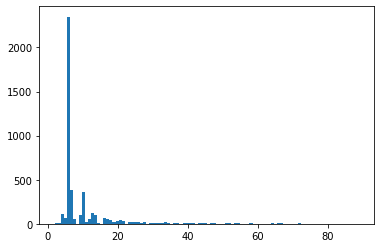

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
9   80196e6999ce63cf.jpg     90     55532
20  802a5f42fdf0ab95.jpg     89     43666
29  802beb5ad6256d35.jpg      3     26810
44  803733bb5bc92c17.jpg      8     53692
********** TEST 1

Images: 9062, Labels: 3695, Super_labels: 74
Avg img per class: 2.45, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.46, Min img per super_class: 2, max img per super_class: 1177
Len split1: 73800
Len split2: 3533
(len split1) / (len split2): 20.88876309085763
Len split1: 71463
Len split2: 5870
(len split1) / (len split2): 12.17427597955707
Len split1: 65770
Len split2: 11563
(len split1) / (len split2): 5.687970249935138
Len split1: 62383
L

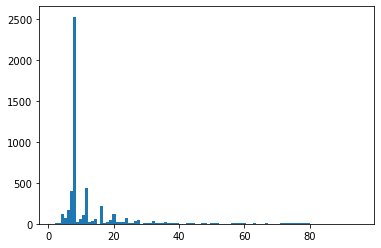

5104
second thresh =  4253
Len split1: 54749
Len split2: 11481
(len split1) / (len split2): 4.768661266440206
len(s1) / len(s2) = 4.768661266440206
Len split1: 55510
Len split2: 10720
(len split1) / (len split2): 5.178171641791045
len(s1) / len(s2) = 5.178171641791045
Len split1: 55577
Len split2: 10653
(len split1) / (len split2): 5.217028067211114
len(s1) / len(s2) = 5.217028067211114
Len split1: 55589
Len split2: 10641
(len split1) / (len split2): 5.224039094070106
len(s1) / len(s2) = 5.224039094070106
Len split1: 55286
Len split2: 10944
(len split1) / (len split2): 5.05171783625731
len(s1) / len(s2) = 5.05171783625731
Len split1: 55351
Len split2: 10879
(len split1) / (len split2): 5.087875723871679
len(s1) / len(s2) = 5.087875723871679
Len split1: 55256
Len split2: 10974
(len split1) / (len split2): 5.0351740477492255
len(s1) / len(s2) = 5.0351740477492255

Images: 55256, Labels: 4253, Super_labels: 74
Avg img per class: 12.99, Min img per class: 2, max img per class: 95
Avg img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8909, Labels: 3608, Super_labels: 73
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.04, Min img per super_class: 2, max img per super_class: 1131
*****

Images: 46347, Labels: 4253, Super_labels: 74
Avg img per class: 10.9, Min img per class: 2, max img per class: 91
Avg img per super_class: 626.31, Min img per super_class: 6, max img per super_class: 5511


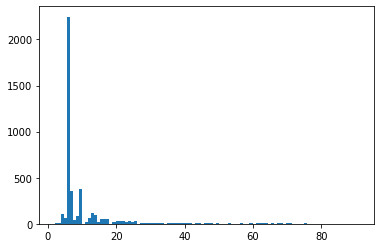

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
24  802aef94c02bbfd5.jpg      6     62831
34  802f7fd0d42f2cca.jpg      6     32426
44  803733bb5bc92c17.jpg      8     53692
47  8039c6e66bb6e329.jpg      6      9828
********** TEST 1

Images: 8909, Labels: 3608, Super_labels: 73
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.04, Min img per super_class: 2, max img per super_class: 1131
Len split1: 67302
Len split2: 10031
(len split1) / (len split2): 6.7094008573422395
Len split1: 66899
Len split2: 10434
(len split1) / (len split2): 6.411635039294614
Len split1: 67713
Len split2: 9620
(len split1) / (len split2): 7.0387733887733885
Len split1: 5927

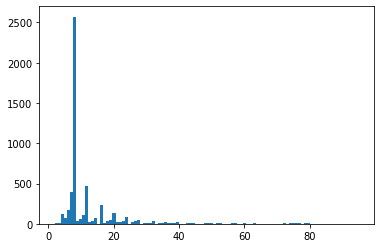

5190
second thresh =  4325
Len split1: 55194
Len split2: 11014
(len split1) / (len split2): 5.011258398402034
len(s1) / len(s2) = 5.011258398402034

Images: 55194, Labels: 4325, Super_labels: 72
Avg img per class: 12.76, Min img per class: 2, max img per class: 95
Avg img per super_class: 766.58, Min img per super_class: 8, max img per super_class: 6472
*********

Images: 11014, Labels: 865, Super_labels: 64
Avg img per class: 12.73, Min img per class: 2, max img per class: 84
Avg img per super_class: 172.09, Min img per super_class: 8, max img per super_class: 1685

Images: 55194, Labels: 4325, Super_labels: 72
Avg img per class: 12.76, Min img per class: 2, max img per class: 95
Avg img per super_class: 766.58, Min img per super_class: 8, max img per super_class: 6472
********** TEST 2

Images: 11014, Labels: 865, Super_labels: 64
Avg img per class: 12.73, Min img per class: 2, max img per class: 84
Avg img per super_class: 172.09, Min img per super_class: 8, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9010, Labels: 3677, Super_labels: 71
Avg img per class: 2.45, Min img per class: 2, max img per class: 19
Avg img per super_class: 126.9, Min img per super_class: 2, max img per super_class: 1079
*****

Images: 46184, Labels: 4325, Super_labels: 72
Avg img per class: 10.68, Min img per class: 2, max img per class: 85
Avg img per super_class: 641.44, Min img per super_class: 6, max img per super_class: 5393


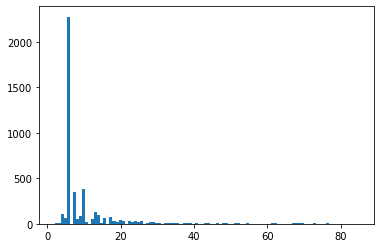

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
9   80196e6999ce63cf.jpg     90     55532
26  802b5ed622fd3587.jpg     90     35252
28  802bd28ddce08fbd.jpg      6     25918
49  803abbf5482e3b93.jpg     87      5210
52  803b5ed0d6037b3e.jpg      5     16791
********** TEST 1

Images: 9010, Labels: 3677, Super_labels: 71
Avg img per class: 2.45, Min img per class: 2, max img per class: 19
Avg img per super_class: 126.9, Min img per super_class: 2, max img per super_class: 1079
Len split1: 54475
Len split2: 22858
(len split1) / (len split2): 2.3831918803044885
Len split1: 65358
Len split2: 11975
(len split1) / (len split2): 5.457870563674321
Len split1: 67712
Len split2: 9621
(len split1) / (len split2): 7.03793784429893
Len split1: 71644
L

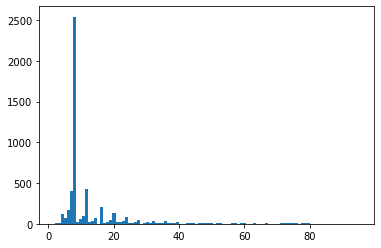

5103
second thresh =  4252
Len split1: 55127
Len split2: 11183
(len split1) / (len split2): 4.929535902709469
len(s1) / len(s2) = 4.929535902709469
Len split1: 54623
Len split2: 11687
(len split1) / (len split2): 4.673825618208266
len(s1) / len(s2) = 4.673825618208266
Len split1: 54922
Len split2: 11388
(len split1) / (len split2): 4.822795925535652
len(s1) / len(s2) = 4.822795925535652
Len split1: 55422
Len split2: 10888
(len split1) / (len split2): 5.090191036002939
len(s1) / len(s2) = 5.090191036002939
Len split1: 54910
Len split2: 11400
(len split1) / (len split2): 4.816666666666666
len(s1) / len(s2) = 4.816666666666666
Len split1: 54872
Len split2: 11438
(len split1) / (len split2): 4.79734219269103
len(s1) / len(s2) = 4.79734219269103
Len split1: 55924
Len split2: 10386
(len split1) / (len split2): 5.384556133256306
len(s1) / len(s2) = 5.384556133256306
Len split1: 55769
Len split2: 10541
(len split1) / (len split2): 5.290674509059862
len(s1) / len(s2) = 5.290674509059862
Len spl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8925, Labels: 3607, Super_labels: 73
Avg img per class: 2.47, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.26, Min img per super_class: 2, max img per super_class: 1202
*****

Images: 46352, Labels: 4252, Super_labels: 75
Avg img per class: 10.9, Min img per class: 2, max img per class: 90
Avg img per super_class: 618.03, Min img per super_class: 6, max img per super_class: 5695


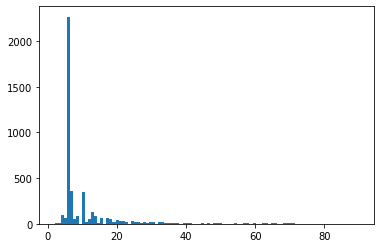

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
22  802a7af055d739e9.jpg     50     45049
34  802f7fd0d42f2cca.jpg      6     32426
39  803570c58f9ba1f7.jpg     87     37779
51  803b5bf6a65459c9.jpg     89      8766
********** TEST 1

Images: 8925, Labels: 3607, Super_labels: 73
Avg img per class: 2.47, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.26, Min img per super_class: 2, max img per super_class: 1202
Len split1: 65442
Len split2: 11891
(len split1) / (len split2): 5.503490034479858
Len split1: 66290
Len split2: 11043
(len split1) / (len split2): 6.002897763288962

Images: 66290, Labels: 5256, Super_labels: 75
Avg img per class: 12.61, Min img per class: 2, max i

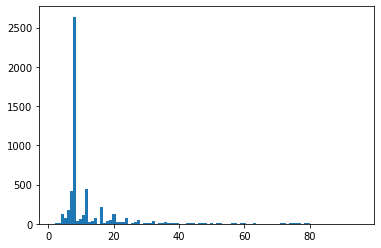

5256
second thresh =  4380
Len split1: 54670
Len split2: 11620
(len split1) / (len split2): 4.704819277108434
len(s1) / len(s2) = 4.704819277108434
Len split1: 55222
Len split2: 11068
(len split1) / (len split2): 4.98933863389953
len(s1) / len(s2) = 4.98933863389953

Images: 55222, Labels: 4380, Super_labels: 75
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.29, Min img per super_class: 7, max img per super_class: 6876
*********

Images: 11068, Labels: 876, Super_labels: 64
Avg img per class: 12.63, Min img per class: 3, max img per class: 84
Avg img per super_class: 172.94, Min img per super_class: 5, max img per super_class: 1281

Images: 55222, Labels: 4380, Super_labels: 75
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.29, Min img per super_class: 7, max img per super_class: 6876
********** TEST 2

Images: 11068, Labels: 876, Super_labels: 64
Avg img per class: 12.63, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8962, Labels: 3692, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.77, Min img per super_class: 2, max img per super_class: 1165
*****

Images: 46260, Labels: 4380, Super_labels: 75
Avg img per class: 10.56, Min img per class: 2, max img per class: 86
Avg img per super_class: 616.8, Min img per super_class: 6, max img per super_class: 5711


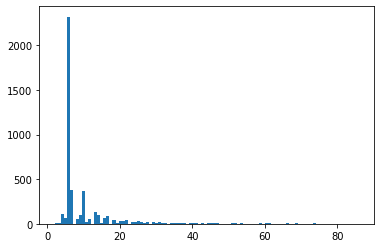

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
8   8011ffce8971daa3.jpg     87     19657
24  802aef94c02bbfd5.jpg      6     62831
38  80333fc0783e27f9.jpg     42     24915
39  803570c58f9ba1f7.jpg     87     37779
********** TEST 1

Images: 8962, Labels: 3692, Super_labels: 73
Avg img per class: 2.43, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.77, Min img per super_class: 2, max img per super_class: 1165
Len split1: 71432
Len split2: 5901
(len split1) / (len split2): 12.105066937807152
Len split1: 63648
Len split2: 13685
(len split1) / (len split2): 4.650931677018634
Len split1: 63083
Len split2: 14250
(len split1) / (len split2): 4.426877192982456
Len split1: 59856
Len s

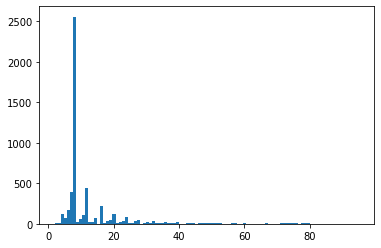

5144
second thresh =  4286
Len split1: 55166
Len split2: 11160
(len split1) / (len split2): 4.943189964157706
len(s1) / len(s2) = 4.943189964157706
Len split1: 55494
Len split2: 10832
(len split1) / (len split2): 5.123153618906942
len(s1) / len(s2) = 5.123153618906942
Len split1: 55392
Len split2: 10934
(len split1) / (len split2): 5.0660325589903055
len(s1) / len(s2) = 5.0660325589903055
Len split1: 55654
Len split2: 10672
(len split1) / (len split2): 5.2149550224887555
len(s1) / len(s2) = 5.2149550224887555
Len split1: 54307
Len split2: 12019
(len split1) / (len split2): 4.518429153839754
len(s1) / len(s2) = 4.518429153839754
Len split1: 55104
Len split2: 11222
(len split1) / (len split2): 4.910354660488326
len(s1) / len(s2) = 4.910354660488326
Len split1: 54825
Len split2: 11501
(len split1) / (len split2): 4.766976784627424
len(s1) / len(s2) = 4.766976784627424
Len split1: 55499
Len split2: 10827
(len split1) / (len split2): 5.125981342938949
len(s1) / len(s2) = 5.125981342938949
L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9051, Labels: 3658, Super_labels: 74
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.31, Min img per super_class: 2, max img per super_class: 1182
*****

Images: 46261, Labels: 4286, Super_labels: 74
Avg img per class: 10.79, Min img per class: 2, max img per class: 92
Avg img per super_class: 625.15, Min img per super_class: 6, max img per super_class: 5733


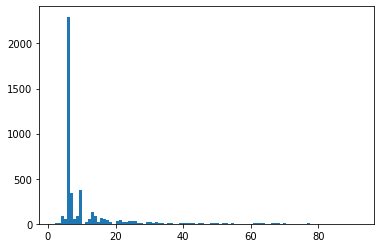

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
21  802a75e51eda5c67.jpg      9      5388
26  802b5ed622fd3587.jpg     90     35252
31  802ddd0a3f70a9f5.jpg     87     18450
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 9051, Labels: 3658, Super_labels: 74
Avg img per class: 2.47, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.31, Min img per super_class: 2, max img per super_class: 1182
Len split1: 61671
Len split2: 15662
(len split1) / (len split2): 3.937619716511301
Len split1: 70632
Len split2: 6701
(len split1) / (len split2): 10.54051634084465
Len split1: 68567
Len split2: 8766
(len split1) / (len split2): 7.821925621720283
Len split1: 66396
L

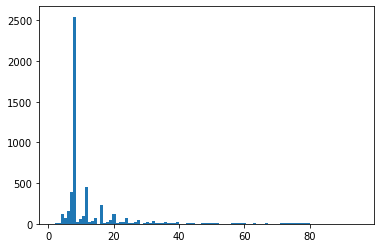

5099
second thresh =  4249
Len split1: 55471
Len split2: 10804
(len split1) / (len split2): 5.134302110329507
len(s1) / len(s2) = 5.134302110329507
Len split1: 55429
Len split2: 10846
(len split1) / (len split2): 5.110547667342799
len(s1) / len(s2) = 5.110547667342799
Len split1: 55206
Len split2: 11069
(len split1) / (len split2): 4.987442406721474
len(s1) / len(s2) = 4.987442406721474

Images: 55206, Labels: 4249, Super_labels: 74
Avg img per class: 12.99, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.03, Min img per super_class: 8, max img per super_class: 6986
*********

Images: 11069, Labels: 850, Super_labels: 64
Avg img per class: 13.02, Min img per class: 3, max img per class: 86
Avg img per super_class: 172.95, Min img per super_class: 5, max img per super_class: 1198

Images: 55206, Labels: 4249, Super_labels: 74
Avg img per class: 12.99, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.03, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8951, Labels: 3603, Super_labels: 73
Avg img per class: 2.48, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.62, Min img per super_class: 2, max img per super_class: 1187
*****

Images: 46255, Labels: 4249, Super_labels: 74
Avg img per class: 10.89, Min img per class: 2, max img per class: 86
Avg img per super_class: 625.07, Min img per super_class: 6, max img per super_class: 5799


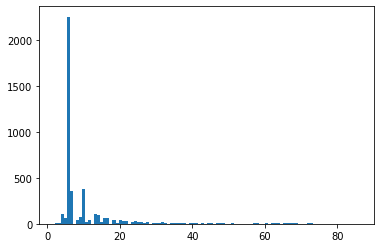

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
12  801f7ce821c7dfd0.jpg     89     27809
20  802a5f42fdf0ab95.jpg     89     43666
21  802a75e51eda5c67.jpg      9      5388
44  803733bb5bc92c17.jpg      8     53692
********** TEST 1

Images: 8951, Labels: 3603, Super_labels: 73
Avg img per class: 2.48, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.62, Min img per super_class: 2, max img per super_class: 1187
Len split1: 62191
Len split2: 15142
(len split1) / (len split2): 4.107185312376172
Len split1: 65677
Len split2: 11656
(len split1) / (len split2): 5.6346087851750175
Len split1: 72640
Len split2: 4693
(len split1) / (len split2): 15.478372043468996
Len split1: 7110

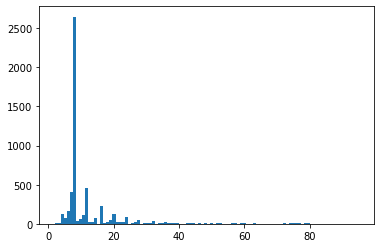

5245
second thresh =  4370
Len split1: 55696
Len split2: 10585
(len split1) / (len split2): 5.261785545583373
len(s1) / len(s2) = 5.261785545583373
Len split1: 55095
Len split2: 11186
(len split1) / (len split2): 4.925353119971393
len(s1) / len(s2) = 4.925353119971393
Len split1: 54524
Len split2: 11757
(len split1) / (len split2): 4.6375776133367355
len(s1) / len(s2) = 4.6375776133367355
Len split1: 55887
Len split2: 10394
(len split1) / (len split2): 5.376852030017318
len(s1) / len(s2) = 5.376852030017318
Len split1: 55023
Len split2: 11258
(len split1) / (len split2): 4.887457807781133
len(s1) / len(s2) = 4.887457807781133
Len split1: 54899
Len split2: 11382
(len split1) / (len split2): 4.823317518889475
len(s1) / len(s2) = 4.823317518889475
Len split1: 54906
Len split2: 11375
(len split1) / (len split2): 4.826901098901099
len(s1) / len(s2) = 4.826901098901099
Len split1: 54973
Len split2: 11308
(len split1) / (len split2): 4.861425539441104
len(s1) / len(s2) = 4.861425539441104
Len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9102, Labels: 3735, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 15
Avg img per super_class: 124.68, Min img per super_class: 2, max img per super_class: 1175
*****

Images: 46141, Labels: 4370, Super_labels: 74
Avg img per class: 10.56, Min img per class: 2, max img per class: 84
Avg img per super_class: 623.53, Min img per super_class: 6, max img per super_class: 5717


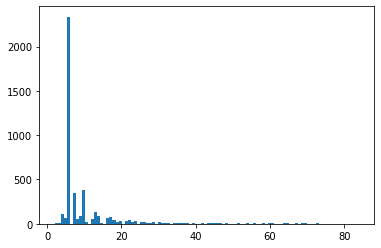

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
13  8020ee1f3f7781da.jpg     52      2498
19  802a2be985975e5f.jpg     83     21874
22  802a7af055d739e9.jpg     50     45049
28  802bd28ddce08fbd.jpg      6     25918
53  803be117a845fe9d.jpg     90     61942
********** TEST 1

Images: 9102, Labels: 3735, Super_labels: 73
Avg img per class: 2.44, Min img per class: 2, max img per class: 15
Avg img per super_class: 124.68, Min img per super_class: 2, max img per super_class: 1175
Len split1: 66156
Len split2: 11177
(len split1) / (len split2): 5.91894068175718
Len split1: 66860
Len split2: 10473
(len split1) / (len split2): 6.384035137973838
Len split1: 60609
Len split2: 16724
(len split1) / (len split2): 3.6240731882324804
Len split1: 66697

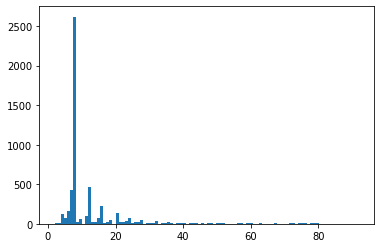

5233
second thresh =  4360
Len split1: 55223
Len split2: 11063
(len split1) / (len split2): 4.991683991683992
len(s1) / len(s2) = 4.991683991683992

Images: 55223, Labels: 4360, Super_labels: 73
Avg img per class: 12.67, Min img per class: 2, max img per class: 92
Avg img per super_class: 756.48, Min img per super_class: 6, max img per super_class: 6930
*********

Images: 11063, Labels: 873, Super_labels: 65
Avg img per class: 12.67, Min img per class: 2, max img per class: 84
Avg img per super_class: 170.2, Min img per super_class: 4, max img per super_class: 1227

Images: 55223, Labels: 4360, Super_labels: 73
Avg img per class: 12.67, Min img per class: 2, max img per class: 92
Avg img per super_class: 756.48, Min img per super_class: 6, max img per super_class: 6930
********** TEST 2

Images: 11063, Labels: 873, Super_labels: 65
Avg img per class: 12.67, Min img per class: 2, max img per class: 84
Avg img per super_class: 170.2, Min img per super_class: 4, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9020, Labels: 3677, Super_labels: 72
Avg img per class: 2.45, Min img per class: 2, max img per class: 16
Avg img per super_class: 125.28, Min img per super_class: 2, max img per super_class: 1188
*****

Images: 46203, Labels: 4360, Super_labels: 73
Avg img per class: 10.6, Min img per class: 2, max img per class: 88
Avg img per super_class: 632.92, Min img per super_class: 6, max img per super_class: 5742


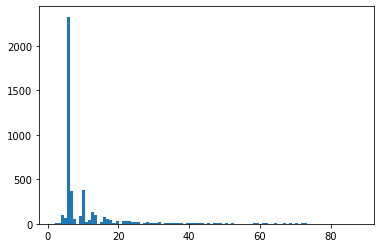

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
21  802a75e51eda5c67.jpg      9      5388
35  802f7ff490819fc9.jpg     87      5697
47  8039c6e66bb6e329.jpg      6      9828
********** TEST 1

Images: 9020, Labels: 3677, Super_labels: 72
Avg img per class: 2.45, Min img per class: 2, max img per class: 16
Avg img per super_class: 125.28, Min img per super_class: 2, max img per super_class: 1188
Len split1: 65343
Len split2: 11990
(len split1) / (len split2): 5.449791492910759
Len split1: 71904
Len split2: 5429
(len split1) / (len split2): 13.244428071468041
Len split1: 65444
Len split2: 11889
(len split1) / (len split2): 5.5045840693077634
Len split1: 6223

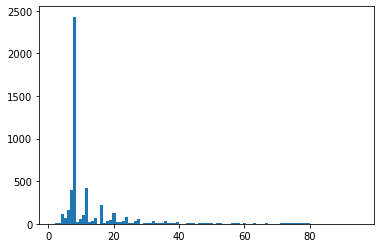

4991
second thresh =  4159
Len split1: 55373
Len split2: 10872
(len split1) / (len split2): 5.093175128771155
len(s1) / len(s2) = 5.093175128771155
Len split1: 54930
Len split2: 11315
(len split1) / (len split2): 4.854617764030048
len(s1) / len(s2) = 4.854617764030048
Len split1: 55390
Len split2: 10855
(len split1) / (len split2): 5.1027176416397975
len(s1) / len(s2) = 5.1027176416397975
Len split1: 55765
Len split2: 10480
(len split1) / (len split2): 5.321087786259542
len(s1) / len(s2) = 5.321087786259542
Len split1: 54882
Len split2: 11363
(len split1) / (len split2): 4.8298864736425235
len(s1) / len(s2) = 4.8298864736425235
Len split1: 55017
Len split2: 11228
(len split1) / (len split2): 4.899982187388671
len(s1) / len(s2) = 4.899982187388671
Len split1: 55777
Len split2: 10468
(len split1) / (len split2): 5.32833397019488
len(s1) / len(s2) = 5.32833397019488
Len split1: 55159
Len split2: 11086
(len split1) / (len split2): 4.97555475374346
len(s1) / len(s2) = 4.97555475374346

Imag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8856, Labels: 3526, Super_labels: 73
Avg img per class: 2.51, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.32, Min img per super_class: 2, max img per super_class: 1138
*****

Images: 46303, Labels: 4159, Super_labels: 74
Avg img per class: 11.13, Min img per class: 2, max img per class: 91
Avg img per super_class: 625.72, Min img per super_class: 6, max img per super_class: 5638


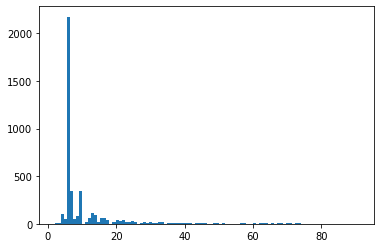

                    image  chain  hotel_id
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
224  807f2da4363a8fc5.jpg     44      5002
286  8084fead05cb5d7a.jpg      6     43451
                   image  chain  hotel_id
13  8020ee1f3f7781da.jpg     52      2498
34  802f7fd0d42f2cca.jpg      6     32426
39  803570c58f9ba1f7.jpg     87     37779
49  803abbf5482e3b93.jpg     87      5210
54  803c53933678ed97.jpg      8     58850
********** TEST 1

Images: 8856, Labels: 3526, Super_labels: 73
Avg img per class: 2.51, Min img per class: 2, max img per class: 16
Avg img per super_class: 121.32, Min img per super_class: 2, max img per super_class: 1138
Len split1: 68916
Len split2: 8417
(len split1) / (len split2): 8.187715338006415
Len split1: 69366
Len split2: 7967
(len split1) / (len split2): 8.706664993096522
Len split1: 60025
Len split2: 17308
(len split1) / (len split2): 3.468049456898544
Len split1: 70306
L

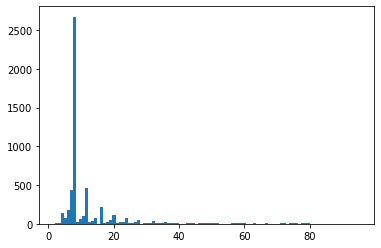

5282
second thresh =  4401
Len split1: 54984
Len split2: 11243
(len split1) / (len split2): 4.890509650449168
len(s1) / len(s2) = 4.890509650449168
Len split1: 55177
Len split2: 11050
(len split1) / (len split2): 4.993393665158371
len(s1) / len(s2) = 4.993393665158371

Images: 55177, Labels: 4401, Super_labels: 75
Avg img per class: 12.54, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.69, Min img per super_class: 6, max img per super_class: 6483
*********

Images: 11050, Labels: 881, Super_labels: 66
Avg img per class: 12.54, Min img per class: 2, max img per class: 87
Avg img per super_class: 167.42, Min img per super_class: 6, max img per super_class: 1674

Images: 55177, Labels: 4401, Super_labels: 75
Avg img per class: 12.54, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.69, Min img per super_class: 6, max img per super_class: 6483
********** TEST 2

Images: 11050, Labels: 881, Super_labels: 66
Avg img per class: 12.54, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8991, Labels: 3691, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.5, Min img per super_class: 2, max img per super_class: 1105
*****

Images: 46186, Labels: 4401, Super_labels: 75
Avg img per class: 10.49, Min img per class: 2, max img per class: 79
Avg img per super_class: 615.81, Min img per super_class: 6, max img per super_class: 5378


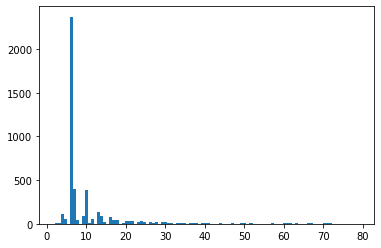

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
11  801aff45ebd0bcd0.jpg     78     26666
28  802bd28ddce08fbd.jpg      6     25918
31  802ddd0a3f70a9f5.jpg     87     18450
39  803570c58f9ba1f7.jpg     87     37779
48  803a7f95384ebc63.jpg     89      1779
********** TEST 1

Images: 8991, Labels: 3691, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.5, Min img per super_class: 2, max img per super_class: 1105
Len split1: 74235
Len split2: 3098
(len split1) / (len split2): 23.96223369916075
Len split1: 65351
Len split2: 11982
(len split1) / (len split2): 5.454097813386746
Len split1: 60022
Len split2: 17311
(len split1) / (len split2): 3.4672751429726762
Len split1: 58318


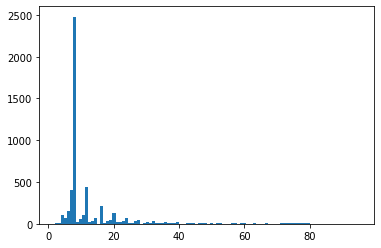

5050
second thresh =  4208
Len split1: 55091
Len split2: 11139
(len split1) / (len split2): 4.94577610198402
len(s1) / len(s2) = 4.94577610198402
Len split1: 55333
Len split2: 10897
(len split1) / (len split2): 5.0778195833715705
len(s1) / len(s2) = 5.0778195833715705
Len split1: 55027
Len split2: 11203
(len split1) / (len split2): 4.91180933678479
len(s1) / len(s2) = 4.91180933678479
Len split1: 55229
Len split2: 11001
(len split1) / (len split2): 5.020361785292246
len(s1) / len(s2) = 5.020361785292246

Images: 55229, Labels: 4208, Super_labels: 74
Avg img per class: 13.12, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.34, Min img per super_class: 8, max img per super_class: 5013
*********

Images: 11001, Labels: 842, Super_labels: 64
Avg img per class: 13.07, Min img per class: 3, max img per class: 82
Avg img per super_class: 171.89, Min img per super_class: 4, max img per super_class: 1315

Images: 55229, Labels: 4208, Super_labels: 74
Avg img per class: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8915, Labels: 3561, Super_labels: 72
Avg img per class: 2.5, Min img per class: 2, max img per class: 18
Avg img per super_class: 123.82, Min img per super_class: 2, max img per super_class: 915
*****

Images: 46314, Labels: 4208, Super_labels: 74
Avg img per class: 11.01, Min img per class: 2, max img per class: 85
Avg img per super_class: 625.86, Min img per super_class: 6, max img per super_class: 4098


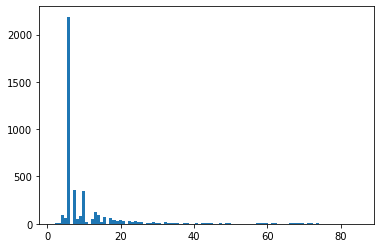

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
9   80196e6999ce63cf.jpg     90     55532
27  802b7e9095d5fe2a.jpg      5     21723
31  802ddd0a3f70a9f5.jpg     87     18450
53  803be117a845fe9d.jpg     90     61942
74  803f73804ffe6187.jpg     55      7828
********** TEST 1

Images: 8915, Labels: 3561, Super_labels: 72
Avg img per class: 2.5, Min img per class: 2, max img per class: 18
Avg img per super_class: 123.82, Min img per super_class: 2, max img per super_class: 915
Len split1: 71816
Len split2: 5517
(len split1) / (len split2): 13.017219503353271
Len split1: 66543
Len split2: 10790
(len split1) / (len split2): 6.167099165894347
Len split1: 65792
Len split2: 11541
(len split1) / (len split2): 5.700719175114808
Len split1: 66117
L

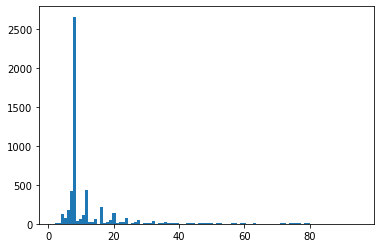

5256
second thresh =  4380
Len split1: 55457
Len split2: 10768
(len split1) / (len split2): 5.150167161961367
len(s1) / len(s2) = 5.150167161961367
Len split1: 55936
Len split2: 10289
(len split1) / (len split2): 5.436485567110506
len(s1) / len(s2) = 5.436485567110506
Len split1: 55399
Len split2: 10826
(len split1) / (len split2): 5.117217808978386
len(s1) / len(s2) = 5.117217808978386
Len split1: 55331
Len split2: 10894
(len split1) / (len split2): 5.079034330824307
len(s1) / len(s2) = 5.079034330824307
Len split1: 55616
Len split2: 10609
(len split1) / (len split2): 5.242341408238288
len(s1) / len(s2) = 5.242341408238288
Len split1: 54698
Len split2: 11527
(len split1) / (len split2): 4.745206905526156
len(s1) / len(s2) = 4.745206905526156
Len split1: 55107
Len split2: 11118
(len split1) / (len split2): 4.956556934700486
len(s1) / len(s2) = 4.956556934700486

Images: 55107, Labels: 4380, Super_labels: 74
Avg img per class: 12.58, Min img per class: 2, max img per class: 95
Avg img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8986, Labels: 3687, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.43, Min img per super_class: 2, max img per super_class: 1148
*****

Images: 46121, Labels: 4380, Super_labels: 74
Avg img per class: 10.53, Min img per class: 2, max img per class: 83
Avg img per super_class: 623.26, Min img per super_class: 6, max img per super_class: 5462


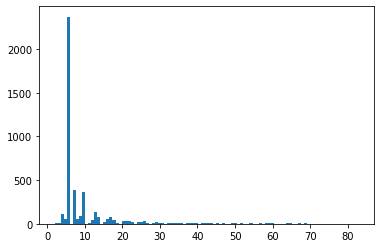

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
6   800bafacb4555b2f.jpg     82      6261
7   800e7dd55ffa4056.jpg      2     60181
22  802a7af055d739e9.jpg     50     45049
27  802b7e9095d5fe2a.jpg      5     21723
********** TEST 1

Images: 8986, Labels: 3687, Super_labels: 74
Avg img per class: 2.44, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.43, Min img per super_class: 2, max img per super_class: 1148
Len split1: 70127
Len split2: 7206
(len split1) / (len split2): 9.731751318345824
Len split1: 69230
Len split2: 8103
(len split1) / (len split2): 8.543749228680735
Len split1: 73963
Len split2: 3370
(len split1) / (len split2): 21.94747774480712
Len split1: 74212
Le

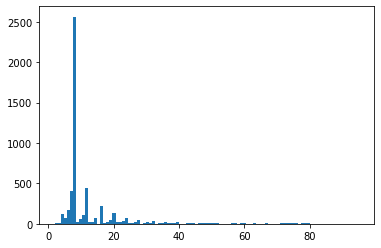

5161
second thresh =  4300
Len split1: 54862
Len split2: 11454
(len split1) / (len split2): 4.78976776671905
len(s1) / len(s2) = 4.78976776671905
Len split1: 55288
Len split2: 11028
(len split1) / (len split2): 5.01342038447588
len(s1) / len(s2) = 5.01342038447588

Images: 55288, Labels: 4300, Super_labels: 74
Avg img per class: 12.86, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.14, Min img per super_class: 6, max img per super_class: 6701
*********

Images: 11028, Labels: 861, Super_labels: 63
Avg img per class: 12.81, Min img per class: 2, max img per class: 84
Avg img per super_class: 175.05, Min img per super_class: 4, max img per super_class: 1456

Images: 55288, Labels: 4300, Super_labels: 74
Avg img per class: 12.86, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.14, Min img per super_class: 6, max img per super_class: 6701
********** TEST 2

Images: 11028, Labels: 861, Super_labels: 63
Avg img per class: 12.81, Min img per 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8941, Labels: 3631, Super_labels: 73
Avg img per class: 2.46, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.48, Min img per super_class: 2, max img per super_class: 1134
*****

Images: 46347, Labels: 4300, Super_labels: 74
Avg img per class: 10.78, Min img per class: 2, max img per class: 90
Avg img per super_class: 626.31, Min img per super_class: 6, max img per super_class: 5567


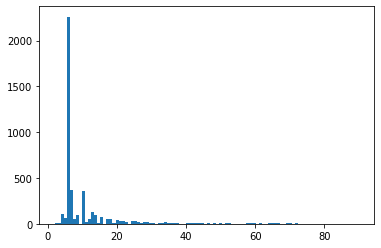

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
12  801f7ce821c7dfd0.jpg     89     27809
17  80296afd55d516ea.jpg      5     44677
21  802a75e51eda5c67.jpg      9      5388
22  802a7af055d739e9.jpg     50     45049
********** TEST 1

Images: 8941, Labels: 3631, Super_labels: 73
Avg img per class: 2.46, Min img per class: 2, max img per class: 16
Avg img per super_class: 122.48, Min img per super_class: 2, max img per super_class: 1134
Len split1: 72690
Len split2: 4643
(len split1) / (len split2): 15.655825974585397
Len split1: 71375
Len split2: 5958
(len split1) / (len split2): 11.979691171534071
Len split1: 67936
Len split2: 9397
(len split1) / (len split2): 7.229541342981802
Len split1: 73493


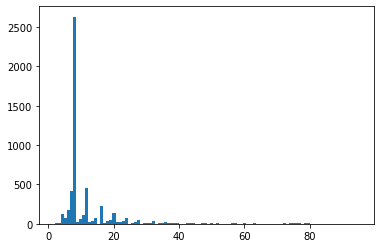

5258
second thresh =  4381
Len split1: 55225
Len split2: 10992
(len split1) / (len split2): 5.024108442503639
len(s1) / len(s2) = 5.024108442503639

Images: 55225, Labels: 4381, Super_labels: 75
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.33, Min img per super_class: 8, max img per super_class: 6569
*********

Images: 10992, Labels: 877, Super_labels: 64
Avg img per class: 12.53, Min img per class: 2, max img per class: 86
Avg img per super_class: 171.75, Min img per super_class: 4, max img per super_class: 1588

Images: 55225, Labels: 4381, Super_labels: 75
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.33, Min img per super_class: 8, max img per super_class: 6569
********** TEST 2

Images: 10992, Labels: 877, Super_labels: 64
Avg img per class: 12.53, Min img per class: 2, max img per class: 86
Avg img per super_class: 171.75, Min img per super_class: 4, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9031, Labels: 3709, Super_labels: 75
Avg img per class: 2.43, Min img per class: 2, max img per class: 18
Avg img per super_class: 120.41, Min img per super_class: 2, max img per super_class: 1142
*****

Images: 46194, Labels: 4381, Super_labels: 75
Avg img per class: 10.54, Min img per class: 2, max img per class: 90
Avg img per super_class: 615.92, Min img per super_class: 6, max img per super_class: 5427


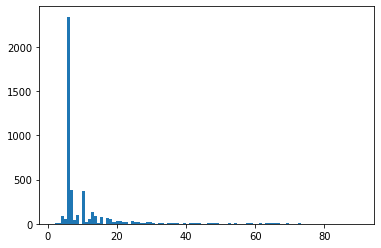

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
5   800a7ffa85c57a3a.jpg      3     25583
6   800bafacb4555b2f.jpg     82      6261
17  80296afd55d516ea.jpg      5     44677
19  802a2be985975e5f.jpg     83     21874
********** TEST 1

Images: 9031, Labels: 3709, Super_labels: 75
Avg img per class: 2.43, Min img per class: 2, max img per class: 18
Avg img per super_class: 120.41, Min img per super_class: 2, max img per super_class: 1142
Len split1: 72679
Len split2: 4654
(len split1) / (len split2): 15.616458960034379
Len split1: 50118
Len split2: 27215
(len split1) / (len split2): 1.8415579643578908
Len split1: 72217
Len split2: 5116
(len split1) / (len split2): 14.11591086786552
Len split1: 67594
Len s

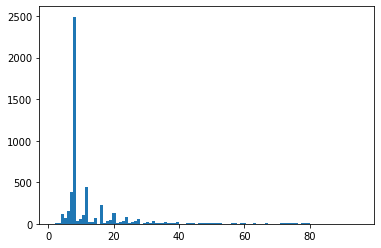

5054
second thresh =  4211
Len split1: 55674
Len split2: 10662
(len split1) / (len split2): 5.2217220033764775
len(s1) / len(s2) = 5.2217220033764775
Len split1: 55787
Len split2: 10549
(len split1) / (len split2): 5.288368565740829
len(s1) / len(s2) = 5.288368565740829
Len split1: 55163
Len split2: 11173
(len split1) / (len split2): 4.937169963304394
len(s1) / len(s2) = 4.937169963304394
Len split1: 55669
Len split2: 10667
(len split1) / (len split2): 5.218805662323052
len(s1) / len(s2) = 5.218805662323052
Len split1: 54632
Len split2: 11704
(len split1) / (len split2): 4.667805878332194
len(s1) / len(s2) = 4.667805878332194
Len split1: 55482
Len split2: 10854
(len split1) / (len split2): 5.1116639027086785
len(s1) / len(s2) = 5.1116639027086785
Len split1: 55517
Len split2: 10819
(len split1) / (len split2): 5.131435437655975
len(s1) / len(s2) = 5.131435437655975
Len split1: 54514
Len split2: 11822
(len split1) / (len split2): 4.611233293858907
len(s1) / len(s2) = 4.611233293858907
L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9020, Labels: 3591, Super_labels: 74
Avg img per class: 2.51, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.89, Min img per super_class: 2, max img per super_class: 1164
*****

Images: 46293, Labels: 4211, Super_labels: 75
Avg img per class: 10.99, Min img per class: 2, max img per class: 84
Avg img per super_class: 617.24, Min img per super_class: 6, max img per super_class: 5616


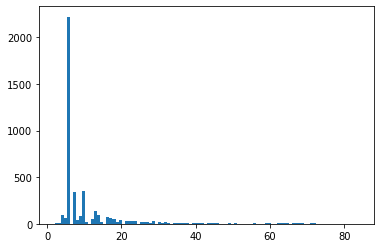

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
7   800e7dd55ffa4056.jpg      2     60181
9   80196e6999ce63cf.jpg     90     55532
22  802a7af055d739e9.jpg     50     45049
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 9020, Labels: 3591, Super_labels: 74
Avg img per class: 2.51, Min img per class: 2, max img per class: 17
Avg img per super_class: 121.89, Min img per super_class: 2, max img per super_class: 1164
Len split1: 72711
Len split2: 4622
(len split1) / (len split2): 15.73150151449589
Len split1: 72184
Len split2: 5149
(len split1) / (len split2): 14.019032821907166
Len split1: 62943
Len split2: 14390
(len split1) / (len split2): 4.374079221681724
Len split1: 74060


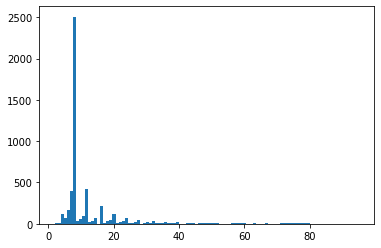

5055
second thresh =  4212
Len split1: 55219
Len split2: 11053
(len split1) / (len split2): 4.99583823396363
len(s1) / len(s2) = 4.99583823396363

Images: 55219, Labels: 4212, Super_labels: 73
Avg img per class: 13.11, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.42, Min img per super_class: 7, max img per super_class: 6635
*********

Images: 11053, Labels: 843, Super_labels: 67
Avg img per class: 13.11, Min img per class: 2, max img per class: 84
Avg img per super_class: 164.97, Min img per super_class: 6, max img per super_class: 1522

Images: 55219, Labels: 4212, Super_labels: 73
Avg img per class: 13.11, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.42, Min img per super_class: 7, max img per super_class: 6635
********** TEST 2

Images: 11053, Labels: 843, Super_labels: 67
Avg img per class: 13.11, Min img per class: 2, max img per class: 84
Avg img per super_class: 164.97, Min img per super_class: 6, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 8849, Labels: 3553, Super_labels: 72
Avg img per class: 2.49, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.9, Min img per super_class: 2, max img per super_class: 1118
*****

Images: 46370, Labels: 4212, Super_labels: 73
Avg img per class: 11.01, Min img per class: 2, max img per class: 92
Avg img per super_class: 635.21, Min img per super_class: 6, max img per super_class: 5517


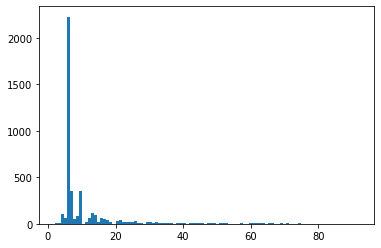

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
22  802a7af055d739e9.jpg     50     45049
32  802f65855fd85b87.jpg      5     34702
34  802f7fd0d42f2cca.jpg      6     32426
39  803570c58f9ba1f7.jpg     87     37779
54  803c53933678ed97.jpg      8     58850
********** TEST 1

Images: 8849, Labels: 3553, Super_labels: 72
Avg img per class: 2.49, Min img per class: 2, max img per class: 15
Avg img per super_class: 122.9, Min img per super_class: 2, max img per super_class: 1118
Len split1: 57447
Len split2: 19886
(len split1) / (len split2): 2.8888162526400483
Len split1: 73115
Len split2: 4218
(len split1) / (len split2): 17.334044570886675
Len split1: 64933
Len split2: 12400
(len split1) / (len split2): 5.236532258064516
Len split1: 63922

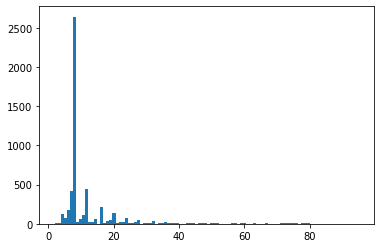

5222
second thresh =  4351
Len split1: 54878
Len split2: 11453
(len split1) / (len split2): 4.791582991355977
len(s1) / len(s2) = 4.791582991355977
Len split1: 55327
Len split2: 11004
(len split1) / (len split2): 5.027898945837877
len(s1) / len(s2) = 5.027898945837877

Images: 55327, Labels: 4351, Super_labels: 74
Avg img per class: 12.72, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.66, Min img per super_class: 8, max img per super_class: 6734
*********

Images: 11004, Labels: 871, Super_labels: 61
Avg img per class: 12.63, Min img per class: 2, max img per class: 80
Avg img per super_class: 180.39, Min img per super_class: 7, max img per super_class: 1423

Images: 55327, Labels: 4351, Super_labels: 74
Avg img per class: 12.72, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.66, Min img per super_class: 8, max img per super_class: 6734
********** TEST 2

Images: 11004, Labels: 871, Super_labels: 61
Avg img per class: 12.63, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 9038, Labels: 3687, Super_labels: 73
Avg img per class: 2.45, Min img per class: 2, max img per class: 17
Avg img per super_class: 123.81, Min img per super_class: 2, max img per super_class: 1126
*****

Images: 46289, Labels: 4351, Super_labels: 74
Avg img per class: 10.64, Min img per class: 2, max img per class: 89
Avg img per super_class: 625.53, Min img per super_class: 6, max img per super_class: 5608


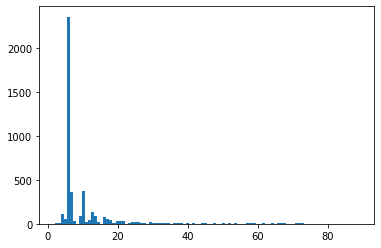

                    image  chain  hotel_id
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
28  802bd28ddce08fbd.jpg      6     25918
29  802beb5ad6256d35.jpg      3     26810
34  802f7fd0d42f2cca.jpg      6     32426
60  803e68a5979a9d97.jpg     89      3919
********** TEST 1

Images: 9038, Labels: 3687, Super_labels: 73
Avg img per class: 2.45, Min img per class: 2, max img per class: 17
Avg img per super_class: 123.81, Min img per super_class: 2, max img per super_class: 1126
Len split1: 73620
Len split2: 3713
(len split1) / (len split2): 19.82763264206841
Len split1: 70423
Len split2: 6910
(len split1) / (len split2): 10.191461649782923
Len split1: 64142
Len split2: 13191
(len split1) / (len split2): 4.862557804563718
Len split1: 63629


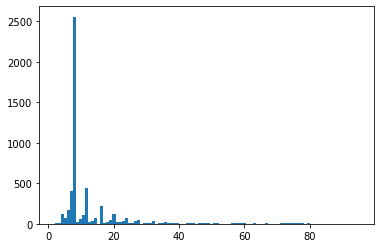

5146
second thresh =  4288
Len split1: 55437
Len split2: 10908
(len split1) / (len split2): 5.082233223322333
len(s1) / len(s2) = 5.082233223322333
Len split1: 54974
Len split2: 11371
(len split1) / (len split2): 4.834579192683141
len(s1) / len(s2) = 4.834579192683141
Len split1: 55046
Len split2: 11299
(len split1) / (len split2): 4.871758562704664
len(s1) / len(s2) = 4.871758562704664
Len split1: 55244
Len split2: 11101
(len split1) / (len split2): 4.976488604630213
len(s1) / len(s2) = 4.976488604630213

Images: 55244, Labels: 4288, Super_labels: 75
Avg img per class: 12.88, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.59, Min img per super_class: 8, max img per super_class: 6936
*********

Images: 11101, Labels: 858, Super_labels: 57
Avg img per class: 12.94, Min img per class: 2, max img per class: 95
Avg img per super_class: 194.75, Min img per super_class: 4, max img per super_class: 1221

Images: 55244, Labels: 4288, Super_labels: 75
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12059, Labels: 3624, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 162.96, Min img per super_class: 3, max img per super_class: 1587
*****

Images: 43185, Labels: 4288, Super_labels: 75
Avg img per class: 10.07, Min img per class: 2, max img per class: 84
Avg img per super_class: 575.8, Min img per super_class: 5, max img per super_class: 5349


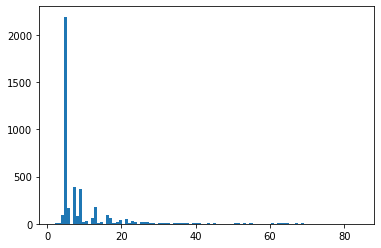

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
13  8020ee1f3f7781da.jpg     52      2498
21  802a75e51eda5c67.jpg      9      5388
24  802aef94c02bbfd5.jpg      6     62831
26  802b5ed622fd3587.jpg     90     35252
27  802b7e9095d5fe2a.jpg      5     21723
********** TEST 1

Images: 12059, Labels: 3624, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 162.96, Min img per super_class: 3, max img per super_class: 1587
Len split1: 67335
Len split2: 9998
(len split1) / (len split2): 6.734846969393879
Len split1: 54366
Len split2: 22967
(len split1) / (len split2): 2.3671354552183566
Len split1: 64497
Len split2: 12836
(len split1) / (len split2): 5.0246961670302275
Len split1: 694

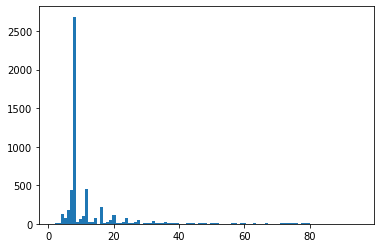

5268
second thresh =  4390
Len split1: 54661
Len split2: 11589
(len split1) / (len split2): 4.716627836741738
len(s1) / len(s2) = 4.716627836741738
Len split1: 55436
Len split2: 10814
(len split1) / (len split2): 5.126317736267801
len(s1) / len(s2) = 5.126317736267801
Len split1: 55245
Len split2: 11005
(len split1) / (len split2): 5.019990913221263
len(s1) / len(s2) = 5.019990913221263

Images: 55245, Labels: 4390, Super_labels: 75
Avg img per class: 12.58, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.6, Min img per super_class: 8, max img per super_class: 6746
*********

Images: 11005, Labels: 878, Super_labels: 63
Avg img per class: 12.53, Min img per class: 2, max img per class: 84
Avg img per super_class: 174.68, Min img per super_class: 7, max img per super_class: 1411

Images: 55245, Labels: 4390, Super_labels: 75
Avg img per class: 12.58, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.6, Min img per super_class: 8, max img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12246, Labels: 3700, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 165.49, Min img per super_class: 3, max img per super_class: 1554
*****

Images: 42999, Labels: 4390, Super_labels: 75
Avg img per class: 9.79, Min img per class: 2, max img per class: 87
Avg img per super_class: 573.32, Min img per super_class: 5, max img per super_class: 5192


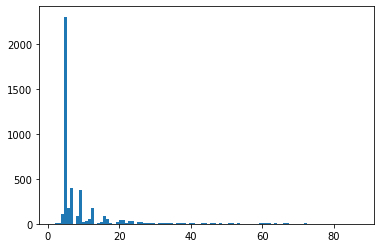

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
21  802a75e51eda5c67.jpg      9      5388
23  802aab95d62b7daa.jpg      6     33712
30  802beb95d5aac0d7.jpg     78     50595
34  802f7fd0d42f2cca.jpg      6     32426
35  802f7ff490819fc9.jpg     87      5697
********** TEST 1

Images: 12246, Labels: 3700, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 165.49, Min img per super_class: 3, max img per super_class: 1554
Len split1: 71711
Len split2: 5622
(len split1) / (len split2): 12.755425115617218
Len split1: 69121
Len split2: 8212
(len split1) / (len split2): 8.417072576716999
Len split1: 61032
Len split2: 16301
(len split1) / (len split2): 3.7440647813017605
Len split1: 6678

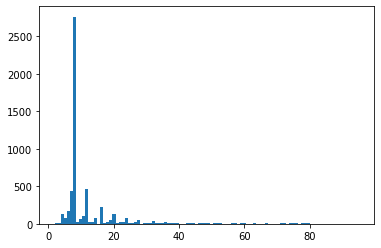

5398
second thresh =  4498
Len split1: 55305
Len split2: 10945
(len split1) / (len split2): 5.052992233896757
len(s1) / len(s2) = 5.052992233896757
Len split1: 54777
Len split2: 11473
(len split1) / (len split2): 4.774426915366512
len(s1) / len(s2) = 4.774426915366512
Len split1: 55528
Len split2: 10722
(len split1) / (len split2): 5.178884536467077
len(s1) / len(s2) = 5.178884536467077
Len split1: 55225
Len split2: 11025
(len split1) / (len split2): 5.00907029478458
len(s1) / len(s2) = 5.00907029478458

Images: 55225, Labels: 4498, Super_labels: 74
Avg img per class: 12.28, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.28, Min img per super_class: 8, max img per super_class: 6732
*********

Images: 11025, Labels: 900, Super_labels: 61
Avg img per class: 12.25, Min img per class: 2, max img per class: 81
Avg img per super_class: 180.74, Min img per super_class: 4, max img per super_class: 1425

Images: 55225, Labels: 4498, Super_labels: 74
Avg img per class: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12447, Labels: 3794, Super_labels: 72
Avg img per class: 3.28, Min img per class: 3, max img per class: 17
Avg img per super_class: 172.88, Min img per super_class: 3, max img per super_class: 1580
*****

Images: 42778, Labels: 4498, Super_labels: 74
Avg img per class: 9.51, Min img per class: 2, max img per class: 91
Avg img per super_class: 578.08, Min img per super_class: 5, max img per super_class: 5152


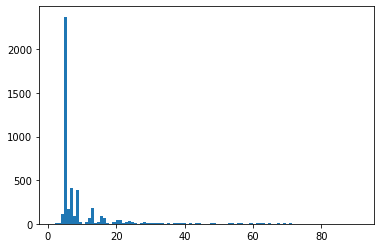

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
6   800bafacb4555b2f.jpg     82      6261
7   800e7dd55ffa4056.jpg      2     60181
12  801f7ce821c7dfd0.jpg     89     27809
27  802b7e9095d5fe2a.jpg      5     21723
28  802bd28ddce08fbd.jpg      6     25918
********** TEST 1

Images: 12447, Labels: 3794, Super_labels: 72
Avg img per class: 3.28, Min img per class: 3, max img per class: 17
Avg img per super_class: 172.88, Min img per super_class: 3, max img per super_class: 1580
Len split1: 62068
Len split2: 15265
(len split1) / (len split2): 4.066033409760891
Len split1: 73218
Len split2: 4115
(len split1) / (len split2): 17.79295261239368
Len split1: 65893
Len split2: 11440
(len split1) / (len split2): 5.759877622377623
Len split1: 67892
Len s

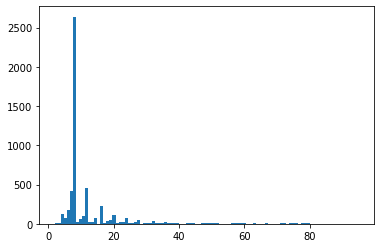

5250
second thresh =  4375
Len split1: 55829
Len split2: 10531
(len split1) / (len split2): 5.301395878833919
len(s1) / len(s2) = 5.301395878833919
Len split1: 55402
Len split2: 10958
(len split1) / (len split2): 5.055849607592626
len(s1) / len(s2) = 5.055849607592626
Len split1: 55036
Len split2: 11324
(len split1) / (len split2): 4.86012009890498
len(s1) / len(s2) = 4.86012009890498
Len split1: 55145
Len split2: 11215
(len split1) / (len split2): 4.917075345519394
len(s1) / len(s2) = 4.917075345519394
Len split1: 55168
Len split2: 11192
(len split1) / (len split2): 4.929235167977127
len(s1) / len(s2) = 4.929235167977127
Len split1: 55347
Len split2: 11013
(len split1) / (len split2): 5.025606101879597
len(s1) / len(s2) = 5.025606101879597

Images: 55347, Labels: 4375, Super_labels: 74
Avg img per class: 12.65, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.93, Min img per super_class: 8, max img per super_class: 6947
*********

Images: 11013, Labels: 875, Su

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12214, Labels: 3697, Super_labels: 73
Avg img per class: 3.3, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.32, Min img per super_class: 3, max img per super_class: 1640
*****

Images: 43133, Labels: 4375, Super_labels: 74
Avg img per class: 9.86, Min img per class: 2, max img per class: 82
Avg img per super_class: 582.88, Min img per super_class: 5, max img per super_class: 5307


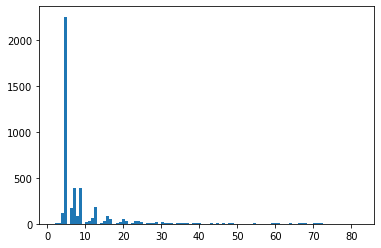

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
11  801aff45ebd0bcd0.jpg     78     26666
13  8020ee1f3f7781da.jpg     52      2498
19  802a2be985975e5f.jpg     83     21874
********** TEST 1

Images: 12214, Labels: 3697, Super_labels: 73
Avg img per class: 3.3, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.32, Min img per super_class: 3, max img per super_class: 1640
Len split1: 67777
Len split2: 9556
(len split1) / (len split2): 7.092611971536208
Len split1: 64780
Len split2: 12553
(len split1) / (len split2): 5.160519397753525
Len split1: 69917
Len split2: 7416
(len split1) / (len split2): 9.427858683926646
Len split1: 69461
L

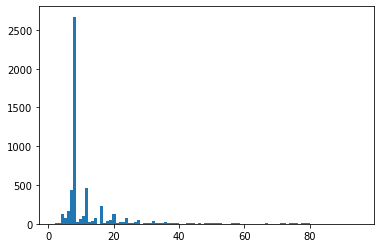

5297
second thresh =  4414
Len split1: 55313
Len split2: 11010
(len split1) / (len split2): 5.023887375113533
len(s1) / len(s2) = 5.023887375113533

Images: 55313, Labels: 4414, Super_labels: 73
Avg img per class: 12.53, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.71, Min img per super_class: 8, max img per super_class: 6996
*********

Images: 11010, Labels: 883, Super_labels: 65
Avg img per class: 12.47, Min img per class: 2, max img per class: 83
Avg img per super_class: 169.38, Min img per super_class: 4, max img per super_class: 1161

Images: 55313, Labels: 4414, Super_labels: 73
Avg img per class: 12.53, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.71, Min img per super_class: 8, max img per super_class: 6996
********** TEST 2

Images: 11010, Labels: 883, Super_labels: 65
Avg img per class: 12.47, Min img per class: 2, max img per class: 83
Avg img per super_class: 169.38, Min img per super_class: 4, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12314, Labels: 3717, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 171.03, Min img per super_class: 3, max img per super_class: 1627
*****

Images: 42999, Labels: 4414, Super_labels: 73
Avg img per class: 9.74, Min img per class: 2, max img per class: 92
Avg img per super_class: 589.03, Min img per super_class: 5, max img per super_class: 5369


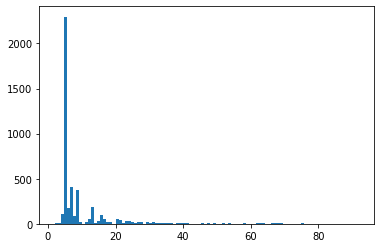

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
9   80196e6999ce63cf.jpg     90     55532
11  801aff45ebd0bcd0.jpg     78     26666
19  802a2be985975e5f.jpg     83     21874
22  802a7af055d739e9.jpg     50     45049
23  802aab95d62b7daa.jpg      6     33712
********** TEST 1

Images: 12314, Labels: 3717, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 171.03, Min img per super_class: 3, max img per super_class: 1627
Len split1: 57159
Len split2: 20174
(len split1) / (len split2): 2.8333002874987607
Len split1: 66864
Len split2: 10469
(len split1) / (len split2): 6.386856433279205
Len split1: 63758
Len split2: 13575
(len split1) / (len split2): 4.696721915285451
Len split1: 72115
Len

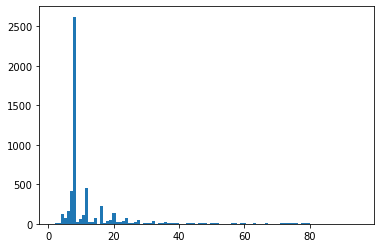

5219
second thresh =  4349
Len split1: 54587
Len split2: 11713
(len split1) / (len split2): 4.660377358490566
len(s1) / len(s2) = 4.660377358490566
Len split1: 55512
Len split2: 10788
(len split1) / (len split2): 5.145717463848721
len(s1) / len(s2) = 5.145717463848721
Len split1: 55015
Len split2: 11285
(len split1) / (len split2): 4.875055383252104
len(s1) / len(s2) = 4.875055383252104
Len split1: 55107
Len split2: 11193
(len split1) / (len split2): 4.923344947735192
len(s1) / len(s2) = 4.923344947735192
Len split1: 54797
Len split2: 11503
(len split1) / (len split2): 4.7637138137877075
len(s1) / len(s2) = 4.7637138137877075
Len split1: 54852
Len split2: 11448
(len split1) / (len split2): 4.7914046121593294
len(s1) / len(s2) = 4.7914046121593294
Len split1: 55297
Len split2: 11003
(len split1) / (len split2): 5.025629373807144
len(s1) / len(s2) = 5.025629373807144

Images: 55297, Labels: 4349, Super_labels: 73
Avg img per class: 12.71, Min img per class: 2, max img per class: 95
Avg i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12236, Labels: 3693, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 169.94, Min img per super_class: 3, max img per super_class: 1604
*****

Images: 43061, Labels: 4349, Super_labels: 73
Avg img per class: 9.9, Min img per class: 2, max img per class: 92
Avg img per super_class: 589.88, Min img per super_class: 5, max img per super_class: 5221


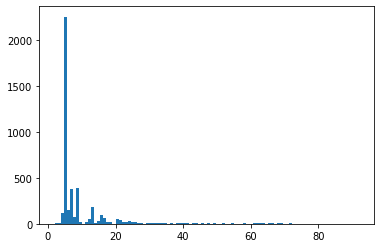

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
5   800a7ffa85c57a3a.jpg      3     25583
17  80296afd55d516ea.jpg      5     44677
21  802a75e51eda5c67.jpg      9      5388
22  802a7af055d739e9.jpg     50     45049
********** TEST 1

Images: 12236, Labels: 3693, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 169.94, Min img per super_class: 3, max img per super_class: 1604
Len split1: 70688
Len split2: 6645
(len split1) / (len split2): 10.637772761474793
Len split1: 66373
Len split2: 10960
(len split1) / (len split2): 6.055930656934307
Len split1: 65916
Len split2: 11417
(len split1) / (len split2): 5.773495664360165
Len split1: 6888

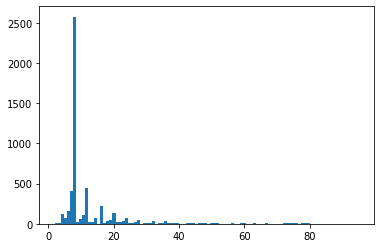

5175
second thresh =  4312
Len split1: 55656
Len split2: 10631
(len split1) / (len split2): 5.235255385194243
len(s1) / len(s2) = 5.235255385194243
Len split1: 55361
Len split2: 10926
(len split1) / (len split2): 5.066904631155043
len(s1) / len(s2) = 5.066904631155043
Len split1: 55163
Len split2: 11124
(len split1) / (len split2): 4.958917655519597
len(s1) / len(s2) = 4.958917655519597

Images: 55163, Labels: 4312, Super_labels: 75
Avg img per class: 12.79, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.51, Min img per super_class: 7, max img per super_class: 6759
*********

Images: 11124, Labels: 863, Super_labels: 58
Avg img per class: 12.89, Min img per class: 2, max img per class: 82
Avg img per super_class: 191.79, Min img per super_class: 5, max img per super_class: 1398

Images: 55163, Labels: 4312, Super_labels: 75
Avg img per class: 12.79, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.51, Min img per super_class: 7, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12142, Labels: 3666, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 19
Avg img per super_class: 164.08, Min img per super_class: 3, max img per super_class: 1606
*****

Images: 43021, Labels: 4312, Super_labels: 75
Avg img per class: 9.98, Min img per class: 2, max img per class: 90
Avg img per super_class: 573.61, Min img per super_class: 5, max img per super_class: 5153


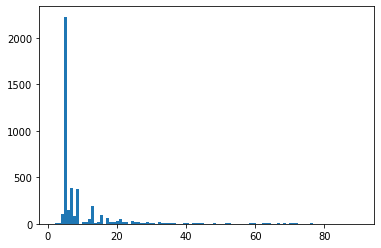

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
5   800a7ffa85c57a3a.jpg      3     25583
9   80196e6999ce63cf.jpg     90     55532
17  80296afd55d516ea.jpg      5     44677
22  802a7af055d739e9.jpg     50     45049
********** TEST 1

Images: 12142, Labels: 3666, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 19
Avg img per super_class: 164.08, Min img per super_class: 3, max img per super_class: 1606
Len split1: 67237
Len split2: 10096
(len split1) / (len split2): 6.659766244057052
Len split1: 57460
Len split2: 19873
(len split1) / (len split2): 2.891360136869119
Len split1: 71000
Len split2: 6333
(len split1) / (len split2): 11.211116374546028
Len split1: 6020

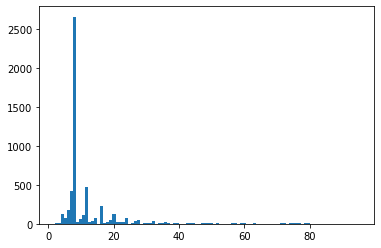

5279
second thresh =  4399
Len split1: 55004
Len split2: 11204
(len split1) / (len split2): 4.9093181006783295
len(s1) / len(s2) = 4.9093181006783295
Len split1: 54574
Len split2: 11634
(len split1) / (len split2): 4.6909059652741965
len(s1) / len(s2) = 4.6909059652741965
Len split1: 54868
Len split2: 11340
(len split1) / (len split2): 4.838447971781305
len(s1) / len(s2) = 4.838447971781305
Len split1: 54690
Len split2: 11518
(len split1) / (len split2): 4.748220177114082
len(s1) / len(s2) = 4.748220177114082
Len split1: 55466
Len split2: 10742
(len split1) / (len split2): 5.163470489666729
len(s1) / len(s2) = 5.163470489666729
Len split1: 55283
Len split2: 10925
(len split1) / (len split2): 5.060228832951945
len(s1) / len(s2) = 5.060228832951945
Len split1: 54762
Len split2: 11446
(len split1) / (len split2): 4.784378822295999
len(s1) / len(s2) = 4.784378822295999
Len split1: 54567
Len split2: 11641
(len split1) / (len split2): 4.687483893136329
len(s1) / len(s2) = 4.687483893136329
L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12189, Labels: 3712, Super_labels: 72
Avg img per class: 3.28, Min img per class: 3, max img per class: 15
Avg img per super_class: 169.29, Min img per super_class: 3, max img per super_class: 1575
*****

Images: 42983, Labels: 4399, Super_labels: 73
Avg img per class: 9.77, Min img per class: 2, max img per class: 92
Avg img per super_class: 588.81, Min img per super_class: 5, max img per super_class: 5179


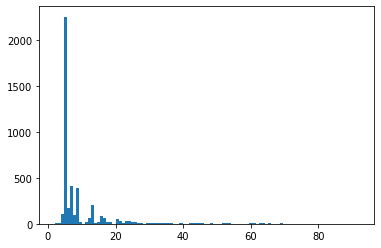

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
22  802a7af055d739e9.jpg     50     45049
26  802b5ed622fd3587.jpg     90     35252
********** TEST 1

Images: 12189, Labels: 3712, Super_labels: 72
Avg img per class: 3.28, Min img per class: 3, max img per class: 15
Avg img per super_class: 169.29, Min img per super_class: 3, max img per super_class: 1575
Len split1: 68444
Len split2: 8889
(len split1) / (len split2): 7.699853751828102
Len split1: 66975
Len split2: 10358
(len split1) / (len split2): 6.466016605522301
Len split1: 57196
Len split2: 20137
(len split1) / (len split2): 2.8403436460247304
Len split1: 6291

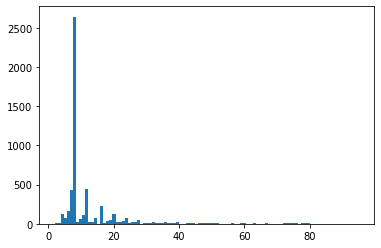

5254
second thresh =  4378
Len split1: 54958
Len split2: 11274
(len split1) / (len split2): 4.8747560759269115
len(s1) / len(s2) = 4.8747560759269115
Len split1: 55106
Len split2: 11126
(len split1) / (len split2): 4.952903109832824
len(s1) / len(s2) = 4.952903109832824

Images: 55106, Labels: 4378, Super_labels: 75
Avg img per class: 12.59, Min img per class: 2, max img per class: 95
Avg img per super_class: 734.75, Min img per super_class: 8, max img per super_class: 6859
*********

Images: 11126, Labels: 876, Super_labels: 63
Avg img per class: 12.7, Min img per class: 3, max img per class: 82
Avg img per super_class: 176.6, Min img per super_class: 8, max img per super_class: 1298

Images: 55106, Labels: 4378, Super_labels: 75
Avg img per class: 12.59, Min img per class: 2, max img per class: 95
Avg img per super_class: 734.75, Min img per super_class: 8, max img per super_class: 6859
********** TEST 2

Images: 11126, Labels: 876, Super_labels: 63
Avg img per class: 12.7, Min img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12315, Labels: 3691, Super_labels: 74
Avg img per class: 3.34, Min img per class: 3, max img per class: 16
Avg img per super_class: 166.42, Min img per super_class: 3, max img per super_class: 1577
*****

Images: 42791, Labels: 4378, Super_labels: 75
Avg img per class: 9.77, Min img per class: 2, max img per class: 80
Avg img per super_class: 570.55, Min img per super_class: 5, max img per super_class: 5282


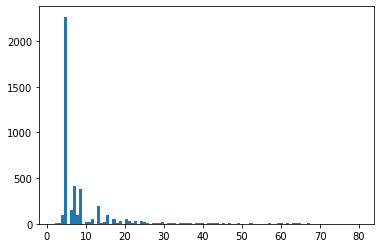

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
6   800bafacb4555b2f.jpg     82      6261
9   80196e6999ce63cf.jpg     90     55532
21  802a75e51eda5c67.jpg      9      5388
73  803f70955e2a6d75.jpg     89     54473
********** TEST 1

Images: 12315, Labels: 3691, Super_labels: 74
Avg img per class: 3.34, Min img per class: 3, max img per class: 16
Avg img per super_class: 166.42, Min img per super_class: 3, max img per super_class: 1577
Len split1: 65630
Len split2: 11703
(len split1) / (len split2): 5.607963769973511
Len split1: 68601
Len split2: 8732
(len split1) / (len split2): 7.856275767292717
Len split1: 59799
Len split2: 17534
(len split1) / (len split2): 3.4104596783392265
Len split1: 6779

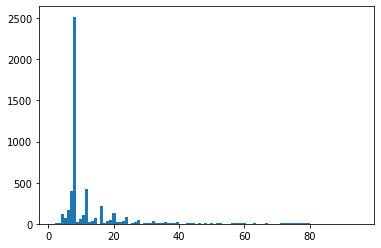

5077
second thresh =  4230
Len split1: 54745
Len split2: 11545
(len split1) / (len split2): 4.741879601559116
len(s1) / len(s2) = 4.741879601559116
Len split1: 55418
Len split2: 10872
(len split1) / (len split2): 5.097314201618837
len(s1) / len(s2) = 5.097314201618837
Len split1: 55201
Len split2: 11089
(len split1) / (len split2): 4.977996212462801
len(s1) / len(s2) = 4.977996212462801

Images: 55201, Labels: 4230, Super_labels: 75
Avg img per class: 13.05, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.01, Min img per super_class: 8, max img per super_class: 6831
*********

Images: 11089, Labels: 847, Super_labels: 62
Avg img per class: 13.09, Min img per class: 2, max img per class: 80
Avg img per super_class: 178.85, Min img per super_class: 2, max img per super_class: 1326

Images: 55201, Labels: 4230, Super_labels: 75
Avg img per class: 13.05, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.01, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11991, Labels: 3583, Super_labels: 74
Avg img per class: 3.35, Min img per class: 3, max img per class: 18
Avg img per super_class: 162.04, Min img per super_class: 3, max img per super_class: 1598
*****

Images: 43210, Labels: 4230, Super_labels: 75
Avg img per class: 10.22, Min img per class: 2, max img per class: 89
Avg img per super_class: 576.13, Min img per super_class: 5, max img per super_class: 5233


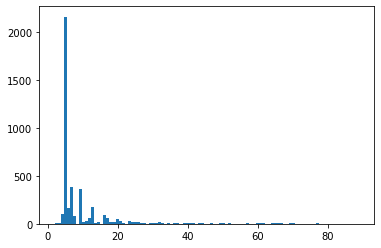

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
6   800bafacb4555b2f.jpg     82      6261
38  80333fc0783e27f9.jpg     42     24915
39  803570c58f9ba1f7.jpg     87     37779
55  803d7a43427ff585.jpg     71     17105
********** TEST 1

Images: 11991, Labels: 3583, Super_labels: 74
Avg img per class: 3.35, Min img per class: 3, max img per class: 18
Avg img per super_class: 162.04, Min img per super_class: 3, max img per super_class: 1598
Len split1: 72188
Len split2: 5145
(len split1) / (len split2): 14.030709426627794
Len split1: 67234
Len split2: 10099
(len split1) / (len split2): 6.657490840677295
Len split1: 70455
Len split2: 6878
(len split1) / (len split2): 10.243530095958127
Len split1: 7167

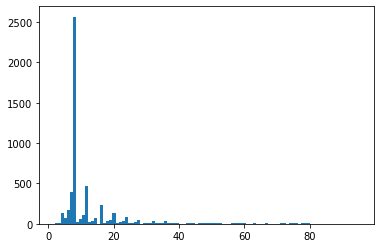

5173
second thresh =  4310
Len split1: 55530
Len split2: 10710
(len split1) / (len split2): 5.184873949579832
len(s1) / len(s2) = 5.184873949579832
Len split1: 55110
Len split2: 11130
(len split1) / (len split2): 4.951482479784366
len(s1) / len(s2) = 4.951482479784366

Images: 55110, Labels: 4310, Super_labels: 73
Avg img per class: 12.79, Min img per class: 2, max img per class: 87
Avg img per super_class: 754.93, Min img per super_class: 7, max img per super_class: 6628
*********

Images: 11130, Labels: 863, Super_labels: 63
Avg img per class: 12.9, Min img per class: 2, max img per class: 95
Avg img per super_class: 176.67, Min img per super_class: 5, max img per super_class: 1529

Images: 55110, Labels: 4310, Super_labels: 73
Avg img per class: 12.79, Min img per class: 2, max img per class: 87
Avg img per super_class: 754.93, Min img per super_class: 7, max img per super_class: 6628
********** TEST 2

Images: 11130, Labels: 863, Super_labels: 63
Avg img per class: 12.9, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12144, Labels: 3666, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 168.67, Min img per super_class: 3, max img per super_class: 1557
*****

Images: 42966, Labels: 4310, Super_labels: 73
Avg img per class: 9.97, Min img per class: 2, max img per class: 83
Avg img per super_class: 588.58, Min img per super_class: 5, max img per super_class: 5071


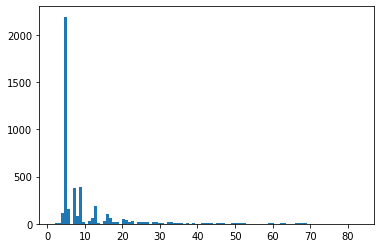

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
9   80196e6999ce63cf.jpg     90     55532
23  802aab95d62b7daa.jpg      6     33712
24  802aef94c02bbfd5.jpg      6     62831
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 12144, Labels: 3666, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 168.67, Min img per super_class: 3, max img per super_class: 1557
Len split1: 69912
Len split2: 7421
(len split1) / (len split2): 9.42083277186363
Len split1: 66870
Len split2: 10463
(len split1) / (len split2): 6.391092420911784
Len split1: 73963
Len split2: 3370
(len split1) / (len split2): 21.94747774480712
Len split1: 69608
L

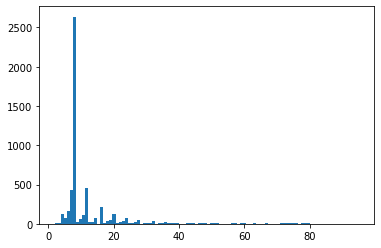

5233
second thresh =  4360
Len split1: 54789
Len split2: 11449
(len split1) / (len split2): 4.785483448336099
len(s1) / len(s2) = 4.785483448336099
Len split1: 55935
Len split2: 10303
(len split1) / (len split2): 5.429001261768417
len(s1) / len(s2) = 5.429001261768417
Len split1: 55286
Len split2: 10952
(len split1) / (len split2): 5.048027757487217
len(s1) / len(s2) = 5.048027757487217

Images: 55286, Labels: 4360, Super_labels: 73
Avg img per class: 12.68, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.34, Min img per super_class: 8, max img per super_class: 6815
*********

Images: 10952, Labels: 873, Super_labels: 65
Avg img per class: 12.55, Min img per class: 2, max img per class: 84
Avg img per super_class: 168.49, Min img per super_class: 2, max img per super_class: 1342

Images: 55286, Labels: 4360, Super_labels: 73
Avg img per class: 12.68, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.34, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12153, Labels: 3674, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 18
Avg img per super_class: 166.48, Min img per super_class: 3, max img per super_class: 1578
*****

Images: 43133, Labels: 4360, Super_labels: 73
Avg img per class: 9.89, Min img per class: 2, max img per class: 81
Avg img per super_class: 590.86, Min img per super_class: 5, max img per super_class: 5237


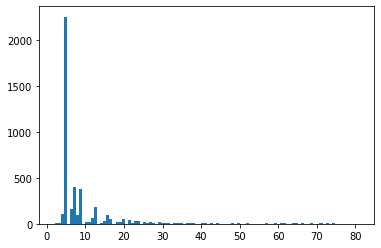

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
12  801f7ce821c7dfd0.jpg     89     27809
21  802a75e51eda5c67.jpg      9      5388
44  803733bb5bc92c17.jpg      8     53692
********** TEST 1

Images: 12153, Labels: 3674, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 18
Avg img per super_class: 166.48, Min img per super_class: 3, max img per super_class: 1578
Len split1: 68044
Len split2: 9289
(len split1) / (len split2): 7.325223382495425
Len split1: 62071
Len split2: 15262
(len split1) / (len split2): 4.067029222906565
Len split1: 73766
Len split2: 3567
(len split1) / (len split2): 20.68012335295767
Len split1: 65216
Len sp

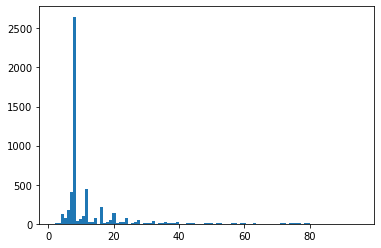

5248
second thresh =  4373
Len split1: 55317
Len split2: 11020
(len split1) / (len split2): 5.019691470054447
len(s1) / len(s2) = 5.019691470054447

Images: 55317, Labels: 4373, Super_labels: 73
Avg img per class: 12.65, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.77, Min img per super_class: 7, max img per super_class: 6956
*********

Images: 11020, Labels: 875, Super_labels: 65
Avg img per class: 12.59, Min img per class: 2, max img per class: 95
Avg img per super_class: 169.54, Min img per super_class: 5, max img per super_class: 1201

Images: 55317, Labels: 4373, Super_labels: 73
Avg img per class: 12.65, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.77, Min img per super_class: 7, max img per super_class: 6956
********** TEST 2

Images: 11020, Labels: 875, Super_labels: 65
Avg img per class: 12.59, Min img per class: 2, max img per class: 95
Avg img per super_class: 169.54, Min img per super_class: 5, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12243, Labels: 3701, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.04, Min img per super_class: 3, max img per super_class: 1615
*****

Images: 43074, Labels: 4373, Super_labels: 73
Avg img per class: 9.85, Min img per class: 2, max img per class: 79
Avg img per super_class: 590.05, Min img per super_class: 5, max img per super_class: 5341


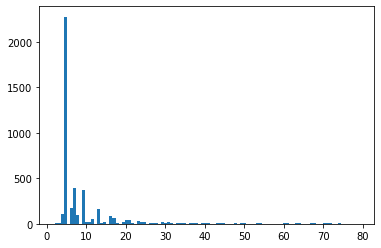

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
1   8000febe81817f7f.jpg      6     25389
5   800a7ffa85c57a3a.jpg      3     25583
20  802a5f42fdf0ab95.jpg     89     43666
21  802a75e51eda5c67.jpg      9      5388
********** TEST 1

Images: 12243, Labels: 3701, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.04, Min img per super_class: 3, max img per super_class: 1615
Len split1: 71976
Len split2: 5357
(len split1) / (len split2): 13.435878290087736
Len split1: 64453
Len split2: 12880
(len split1) / (len split2): 5.0041149068322985
Len split1: 66134
Len split2: 11199
(len split1) / (len split2): 5.905348691847486
Len split1: 694

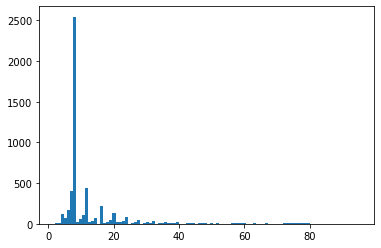

5134
second thresh =  4278
Len split1: 55408
Len split2: 10910
(len split1) / (len split2): 5.078643446379468
len(s1) / len(s2) = 5.078643446379468
Len split1: 54434
Len split2: 11884
(len split1) / (len split2): 4.580444294850219
len(s1) / len(s2) = 4.580444294850219
Len split1: 55349
Len split2: 10969
(len split1) / (len split2): 5.04594767070836
len(s1) / len(s2) = 5.04594767070836

Images: 55349, Labels: 4278, Super_labels: 74
Avg img per class: 12.94, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.96, Min img per super_class: 8, max img per super_class: 6917
*********

Images: 10969, Labels: 856, Super_labels: 60
Avg img per class: 12.81, Min img per class: 2, max img per class: 95
Avg img per super_class: 182.82, Min img per super_class: 5, max img per super_class: 1240

Images: 55349, Labels: 4278, Super_labels: 74
Avg img per class: 12.94, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.96, Min img per super_class: 8, max img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12161, Labels: 3630, Super_labels: 73
Avg img per class: 3.35, Min img per class: 3, max img per class: 15
Avg img per super_class: 166.59, Min img per super_class: 3, max img per super_class: 1585
*****

Images: 43188, Labels: 4278, Super_labels: 74
Avg img per class: 10.1, Min img per class: 2, max img per class: 90
Avg img per super_class: 583.62, Min img per super_class: 5, max img per super_class: 5332


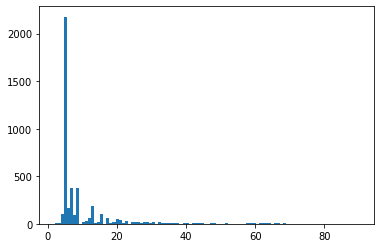

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
2   80053befc2d42fba.jpg      3       672
8   8011ffce8971daa3.jpg     87     19657
12  801f7ce821c7dfd0.jpg     89     27809
13  8020ee1f3f7781da.jpg     52      2498
********** TEST 1

Images: 12161, Labels: 3630, Super_labels: 73
Avg img per class: 3.35, Min img per class: 3, max img per class: 15
Avg img per super_class: 166.59, Min img per super_class: 3, max img per super_class: 1585
Len split1: 69757
Len split2: 7576
(len split1) / (len split2): 9.207629355860613
Len split1: 59137
Len split2: 18196
(len split1) / (len split2): 3.25
Len split1: 56630
Len split2: 20703
(len split1) / (len split2): 2.735352364391634
Len split1: 61923
Len split2: 

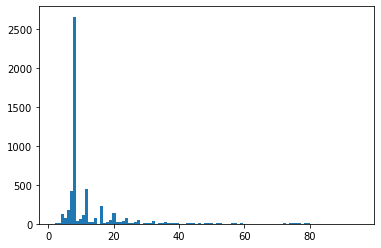

5288
second thresh =  4406
Len split1: 54812
Len split2: 11423
(len split1) / (len split2): 4.798389214742187
len(s1) / len(s2) = 4.798389214742187
Len split1: 55382
Len split2: 10853
(len split1) / (len split2): 5.102920851377499
len(s1) / len(s2) = 5.102920851377499
Len split1: 55152
Len split2: 11083
(len split1) / (len split2): 4.9762699630064064
len(s1) / len(s2) = 4.9762699630064064

Images: 55152, Labels: 4406, Super_labels: 74
Avg img per class: 12.52, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.3, Min img per super_class: 8, max img per super_class: 6750
*********

Images: 11083, Labels: 882, Super_labels: 64
Avg img per class: 12.57, Min img per class: 2, max img per class: 95
Avg img per super_class: 173.17, Min img per super_class: 7, max img per super_class: 1407

Images: 55152, Labels: 4406, Super_labels: 74
Avg img per class: 12.52, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.3, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12264, Labels: 3718, Super_labels: 73
Avg img per class: 3.3, Min img per class: 3, max img per class: 16
Avg img per super_class: 168.0, Min img per super_class: 3, max img per super_class: 1538
*****

Images: 42888, Labels: 4406, Super_labels: 74
Avg img per class: 9.73, Min img per class: 2, max img per class: 86
Avg img per super_class: 579.57, Min img per super_class: 5, max img per super_class: 5212


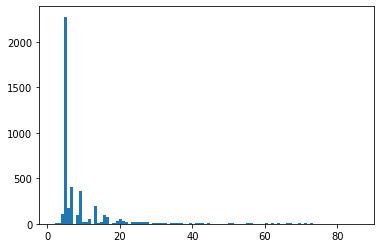

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
3   8007fa0a8fe89f9d.jpg      5     63866
8   8011ffce8971daa3.jpg     87     19657
30  802beb95d5aac0d7.jpg     78     50595
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 12264, Labels: 3718, Super_labels: 73
Avg img per class: 3.3, Min img per class: 3, max img per class: 16
Avg img per super_class: 168.0, Min img per super_class: 3, max img per super_class: 1538
Len split1: 57006
Len split2: 20327
(len split1) / (len split2): 2.804447286859842
Len split1: 63361
Len split2: 13972
(len split1) / (len split2): 4.534855425135986
Len split1: 69033
Len split2: 8300
(len split1) / (len split2): 8.31722891566265
Len split1: 61535
Len spli

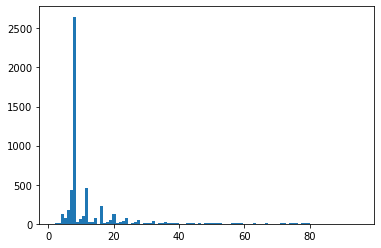

5285
second thresh =  4404
Len split1: 55619
Len split2: 10635
(len split1) / (len split2): 5.229807240244476
len(s1) / len(s2) = 5.229807240244476
Len split1: 55263
Len split2: 10991
(len split1) / (len split2): 5.028022927850059
len(s1) / len(s2) = 5.028022927850059

Images: 55263, Labels: 4404, Super_labels: 74
Avg img per class: 12.55, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.8, Min img per super_class: 7, max img per super_class: 6833
*********

Images: 10991, Labels: 881, Super_labels: 61
Avg img per class: 12.48, Min img per class: 2, max img per class: 86
Avg img per super_class: 180.18, Min img per super_class: 6, max img per super_class: 1324

Images: 55263, Labels: 4404, Super_labels: 74
Avg img per class: 12.55, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.8, Min img per super_class: 7, max img per super_class: 6833
********** TEST 2

Images: 10991, Labels: 881, Super_labels: 61
Avg img per class: 12.48, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12240, Labels: 3697, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 167.67, Min img per super_class: 3, max img per super_class: 1604
*****

Images: 43023, Labels: 4404, Super_labels: 74
Avg img per class: 9.77, Min img per class: 2, max img per class: 86
Avg img per super_class: 581.39, Min img per super_class: 5, max img per super_class: 5229


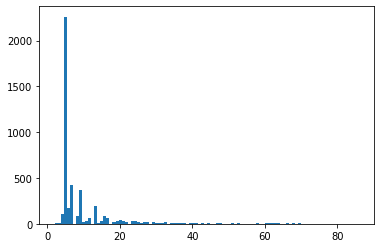

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
35  802f7ff490819fc9.jpg     87      5697
39  803570c58f9ba1f7.jpg     87     37779
49  803abbf5482e3b93.jpg     87      5210
52  803b5ed0d6037b3e.jpg      5     16791
60  803e68a5979a9d97.jpg     89      3919
********** TEST 1

Images: 12240, Labels: 3697, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 167.67, Min img per super_class: 3, max img per super_class: 1604
Len split1: 69898
Len split2: 7435
(len split1) / (len split2): 9.401210490921319
Len split1: 71216
Len split2: 6117
(len split1) / (len split2): 11.642308321072422
Len split1: 58177
Len split2: 19156
(len split1) / (len split2): 3.037011902276049
Len split1: 73472
Len s

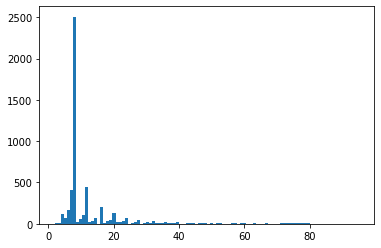

5095
second thresh =  4245
Len split1: 55329
Len split2: 10910
(len split1) / (len split2): 5.071402383134739
len(s1) / len(s2) = 5.071402383134739
Len split1: 54919
Len split2: 11320
(len split1) / (len split2): 4.851501766784453
len(s1) / len(s2) = 4.851501766784453
Len split1: 55237
Len split2: 11002
(len split1) / (len split2): 5.020632612252318
len(s1) / len(s2) = 5.020632612252318

Images: 55237, Labels: 4245, Super_labels: 74
Avg img per class: 13.01, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.45, Min img per super_class: 8, max img per super_class: 5157
*********

Images: 11002, Labels: 850, Super_labels: 66
Avg img per class: 12.94, Min img per class: 2, max img per class: 81
Avg img per super_class: 166.7, Min img per super_class: 4, max img per super_class: 1171

Images: 55237, Labels: 4245, Super_labels: 74
Avg img per class: 13.01, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.45, Min img per super_class: 8, max img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12046, Labels: 3582, Super_labels: 73
Avg img per class: 3.36, Min img per class: 3, max img per class: 16
Avg img per super_class: 165.01, Min img per super_class: 3, max img per super_class: 1289
*****

Images: 43191, Labels: 4245, Super_labels: 74
Avg img per class: 10.17, Min img per class: 2, max img per class: 88
Avg img per super_class: 583.66, Min img per super_class: 5, max img per super_class: 3868


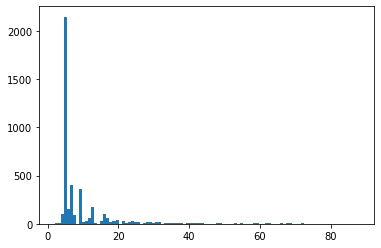

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
94   803ff087ea61de8a.jpg     82     47145
128  805f27a3bb4896a7.jpg      9     14532
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
21  802a75e51eda5c67.jpg      9      5388
22  802a7af055d739e9.jpg     50     45049
27  802b7e9095d5fe2a.jpg      5     21723
********** TEST 1

Images: 12046, Labels: 3582, Super_labels: 73
Avg img per class: 3.36, Min img per class: 3, max img per class: 16
Avg img per super_class: 165.01, Min img per super_class: 3, max img per super_class: 1289
Len split1: 58675
Len split2: 18658
(len split1) / (len split2): 3.14476364026155
Len split1: 73564
Len split2: 3769
(len split1) / (len split2): 19.518174582117272
Len split1: 69544
Len split2: 7789
(len split1) / (len split2): 8.928488894594942
Len split1: 72568


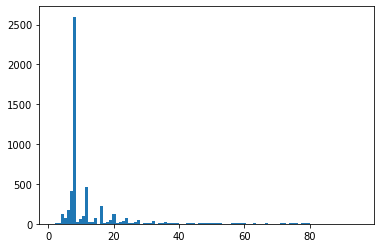

5203
second thresh =  4335
Len split1: 55400
Len split2: 10809
(len split1) / (len split2): 5.12535849754834
len(s1) / len(s2) = 5.12535849754834
Len split1: 54862
Len split2: 11347
(len split1) / (len split2): 4.834934343879439
len(s1) / len(s2) = 4.834934343879439
Len split1: 54850
Len split2: 11359
(len split1) / (len split2): 4.828770138216393
len(s1) / len(s2) = 4.828770138216393
Len split1: 55087
Len split2: 11122
(len split1) / (len split2): 4.95297608343823
len(s1) / len(s2) = 4.95297608343823

Images: 55087, Labels: 4335, Super_labels: 74
Avg img per class: 12.71, Min img per class: 2, max img per class: 95
Avg img per super_class: 744.42, Min img per super_class: 7, max img per super_class: 6774
*********

Images: 11122, Labels: 868, Super_labels: 63
Avg img per class: 12.81, Min img per class: 2, max img per class: 83
Avg img per super_class: 176.54, Min img per super_class: 8, max img per super_class: 1383

Images: 55087, Labels: 4335, Super_labels: 74
Avg img per class: 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12164, Labels: 3656, Super_labels: 72
Avg img per class: 3.33, Min img per class: 3, max img per class: 15
Avg img per super_class: 168.94, Min img per super_class: 3, max img per super_class: 1573
*****

Images: 42923, Labels: 4335, Super_labels: 74
Avg img per class: 9.9, Min img per class: 2, max img per class: 83
Avg img per super_class: 580.04, Min img per super_class: 5, max img per super_class: 5201


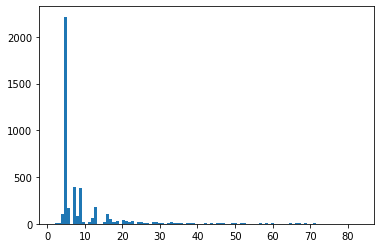

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
12  801f7ce821c7dfd0.jpg     89     27809
23  802aab95d62b7daa.jpg      6     33712
24  802aef94c02bbfd5.jpg      6     62831
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 12164, Labels: 3656, Super_labels: 72
Avg img per class: 3.33, Min img per class: 3, max img per class: 15
Avg img per super_class: 168.94, Min img per super_class: 3, max img per super_class: 1573
Len split1: 55078
Len split2: 22255
(len split1) / (len split2): 2.474859582116378
Len split1: 66035
Len split2: 11298
(len split1) / (len split2): 5.844839794653921
Len split1: 72441
Len split2: 4892
(len split1) / (len split2): 14.808053965658218
Len split1: 64964
Len 

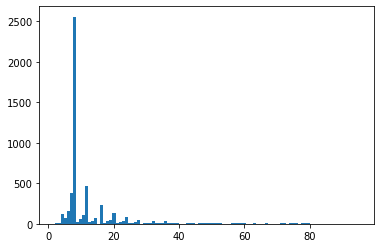

5150
second thresh =  4291
Len split1: 55731
Len split2: 10602
(len split1) / (len split2): 5.256649688737974
len(s1) / len(s2) = 5.256649688737974
Len split1: 55547
Len split2: 10786
(len split1) / (len split2): 5.149916558501761
len(s1) / len(s2) = 5.149916558501761
Len split1: 55606
Len split2: 10727
(len split1) / (len split2): 5.1837419595413445
len(s1) / len(s2) = 5.1837419595413445
Len split1: 55533
Len split2: 10800
(len split1) / (len split2): 5.141944444444444
len(s1) / len(s2) = 5.141944444444444
Len split1: 55414
Len split2: 10919
(len split1) / (len split2): 5.075006868760876
len(s1) / len(s2) = 5.075006868760876
Len split1: 55313
Len split2: 11020
(len split1) / (len split2): 5.019328493647913
len(s1) / len(s2) = 5.019328493647913

Images: 55313, Labels: 4291, Super_labels: 75
Avg img per class: 12.89, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.51, Min img per super_class: 8, max img per super_class: 6950
*********

Images: 11020, Labels: 859

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12209, Labels: 3670, Super_labels: 75
Avg img per class: 3.33, Min img per class: 3, max img per class: 17
Avg img per super_class: 162.79, Min img per super_class: 3, max img per super_class: 1615
*****

Images: 43104, Labels: 4291, Super_labels: 75
Avg img per class: 10.05, Min img per class: 2, max img per class: 87
Avg img per super_class: 574.72, Min img per super_class: 5, max img per super_class: 5335


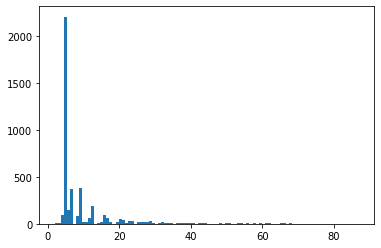

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
13  8020ee1f3f7781da.jpg     52      2498
23  802aab95d62b7daa.jpg      6     33712
31  802ddd0a3f70a9f5.jpg     87     18450
38  80333fc0783e27f9.jpg     42     24915
48  803a7f95384ebc63.jpg     89      1779
********** TEST 1

Images: 12209, Labels: 3670, Super_labels: 75
Avg img per class: 3.33, Min img per class: 3, max img per class: 17
Avg img per super_class: 162.79, Min img per super_class: 3, max img per super_class: 1615
Len split1: 68682
Len split2: 8651
(len split1) / (len split2): 7.939197780603399
Len split1: 64810
Len split2: 12523
(len split1) / (len split2): 5.175277489419468
Len split1: 67336
Len split2: 9997
(len split1) / (len split2): 6.735620686205862
Len split1: 73570
Len sp

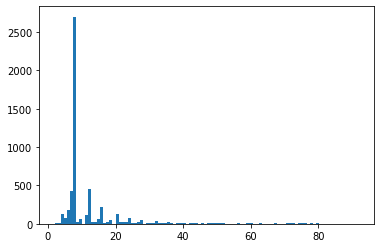

5314
second thresh =  4428
Len split1: 55499
Len split2: 10842
(len split1) / (len split2): 5.11888950378159
len(s1) / len(s2) = 5.11888950378159
Len split1: 55277
Len split2: 11064
(len split1) / (len split2): 4.996113521330441
len(s1) / len(s2) = 4.996113521330441

Images: 55277, Labels: 4428, Super_labels: 73
Avg img per class: 12.48, Min img per class: 2, max img per class: 92
Avg img per super_class: 757.22, Min img per super_class: 6, max img per super_class: 6577
*********

Images: 11064, Labels: 886, Super_labels: 63
Avg img per class: 12.49, Min img per class: 2, max img per class: 81
Avg img per super_class: 175.62, Min img per super_class: 6, max img per super_class: 1580

Images: 55277, Labels: 4428, Super_labels: 73
Avg img per class: 12.48, Min img per class: 2, max img per class: 92
Avg img per super_class: 757.22, Min img per super_class: 6, max img per super_class: 6577
********** TEST 2

Images: 11064, Labels: 886, Super_labels: 63
Avg img per class: 12.49, Min img pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12292, Labels: 3720, Super_labels: 72
Avg img per class: 3.3, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.72, Min img per super_class: 3, max img per super_class: 1544
*****

Images: 42985, Labels: 4428, Super_labels: 73
Avg img per class: 9.71, Min img per class: 2, max img per class: 81
Avg img per super_class: 588.84, Min img per super_class: 5, max img per super_class: 5033


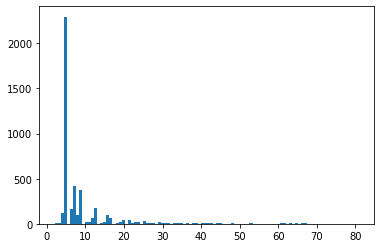

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
27  802b7e9095d5fe2a.jpg      5     21723
38  80333fc0783e27f9.jpg     42     24915
54  803c53933678ed97.jpg      8     58850
55  803d7a43427ff585.jpg     71     17105
********** TEST 1

Images: 12292, Labels: 3720, Super_labels: 72
Avg img per class: 3.3, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.72, Min img per super_class: 3, max img per super_class: 1544
Len split1: 73664
Len split2: 3669
(len split1) / (len split2): 20.07740528754429
Len split1: 58517
Len split2: 18816
(len split1) / (len split2): 3.1099596088435373
Len split1: 72424
Len split2: 4909
(len split1) / (len split2): 14.753310246486047
Len split1: 72975

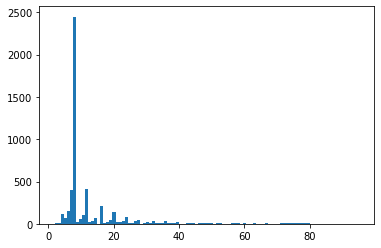

4996
second thresh =  4163
Len split1: 55042
Len split2: 11285
(len split1) / (len split2): 4.877447939743022
len(s1) / len(s2) = 4.877447939743022
Len split1: 55341
Len split2: 10986
(len split1) / (len split2): 5.037411250682687
len(s1) / len(s2) = 5.037411250682687

Images: 55341, Labels: 4163, Super_labels: 75
Avg img per class: 13.29, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.88, Min img per super_class: 7, max img per super_class: 6774
*********

Images: 10986, Labels: 833, Super_labels: 63
Avg img per class: 13.19, Min img per class: 2, max img per class: 87
Avg img per super_class: 174.38, Min img per super_class: 4, max img per super_class: 1383

Images: 55341, Labels: 4163, Super_labels: 75
Avg img per class: 13.29, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.88, Min img per super_class: 7, max img per super_class: 6774
********** TEST 2

Images: 10986, Labels: 833, Super_labels: 63
Avg img per class: 13.19, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11887, Labels: 3552, Super_labels: 74
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 160.64, Min img per super_class: 3, max img per super_class: 1564
*****

Images: 43454, Labels: 4163, Super_labels: 75
Avg img per class: 10.44, Min img per class: 2, max img per class: 86
Avg img per super_class: 579.39, Min img per super_class: 5, max img per super_class: 5210


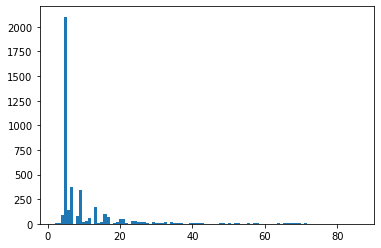

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
8   8011ffce8971daa3.jpg     87     19657
22  802a7af055d739e9.jpg     50     45049
24  802aef94c02bbfd5.jpg      6     62831
26  802b5ed622fd3587.jpg     90     35252
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 11887, Labels: 3552, Super_labels: 74
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 160.64, Min img per super_class: 3, max img per super_class: 1564
Len split1: 62320
Len split2: 15013
(len split1) / (len split2): 4.151069073469659
Len split1: 67367
Len split2: 9966
(len split1) / (len split2): 6.759682921934577
Len split1: 64109
Len split2: 13224
(len split1) / (len split2): 4.847928009679371
Len split1: 69528

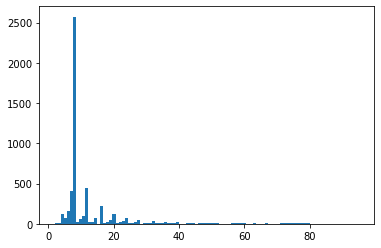

5124
second thresh =  4270
Len split1: 55516
Len split2: 10762
(len split1) / (len split2): 5.158520721055566
len(s1) / len(s2) = 5.158520721055566
Len split1: 55687
Len split2: 10591
(len split1) / (len split2): 5.257954867340194
len(s1) / len(s2) = 5.257954867340194
Len split1: 55489
Len split2: 10789
(len split1) / (len split2): 5.143108721846325
len(s1) / len(s2) = 5.143108721846325
Len split1: 54666
Len split2: 11612
(len split1) / (len split2): 4.707716155700999
len(s1) / len(s2) = 4.707716155700999
Len split1: 55429
Len split2: 10849
(len split1) / (len split2): 5.109134482440778
len(s1) / len(s2) = 5.109134482440778
Len split1: 55272
Len split2: 11006
(len split1) / (len split2): 5.0219880065418865
len(s1) / len(s2) = 5.0219880065418865

Images: 55272, Labels: 4270, Super_labels: 75
Avg img per class: 12.94, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.96, Min img per super_class: 6, max img per super_class: 6715
*********

Images: 11006, Labels: 854

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11996, Labels: 3609, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 19
Avg img per super_class: 162.11, Min img per super_class: 3, max img per super_class: 1559
*****

Images: 43276, Labels: 4270, Super_labels: 75
Avg img per class: 10.13, Min img per class: 2, max img per class: 83
Avg img per super_class: 577.01, Min img per super_class: 5, max img per super_class: 5156


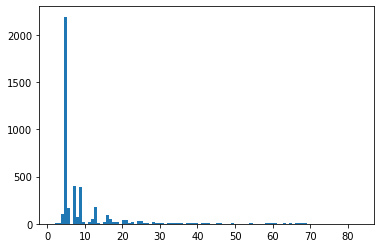

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
21  802a75e51eda5c67.jpg      9      5388
24  802aef94c02bbfd5.jpg      6     62831
30  802beb95d5aac0d7.jpg     78     50595
********** TEST 1

Images: 11996, Labels: 3609, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 19
Avg img per super_class: 162.11, Min img per super_class: 3, max img per super_class: 1559
Len split1: 67852
Len split2: 9481
(len split1) / (len split2): 7.1566290475688215
Len split1: 58090
Len split2: 19243
(len split1) / (len split2): 3.018760068596373
Len split1: 67897
Len split2: 9436
(len split1) / (len split2): 7.195527766002543
Len split1: 72353

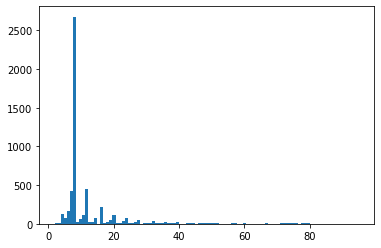

5271
second thresh =  4392
Len split1: 55868
Len split2: 10417
(len split1) / (len split2): 5.363156378995872
len(s1) / len(s2) = 5.363156378995872
Len split1: 54867
Len split2: 11418
(len split1) / (len split2): 4.805307409353652
len(s1) / len(s2) = 4.805307409353652
Len split1: 55162
Len split2: 11123
(len split1) / (len split2): 4.959273577272318
len(s1) / len(s2) = 4.959273577272318

Images: 55162, Labels: 4392, Super_labels: 73
Avg img per class: 12.56, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.64, Min img per super_class: 8, max img per super_class: 6951
*********

Images: 11123, Labels: 879, Super_labels: 63
Avg img per class: 12.65, Min img per class: 2, max img per class: 92
Avg img per super_class: 176.56, Min img per super_class: 4, max img per super_class: 1206

Images: 55162, Labels: 4392, Super_labels: 73
Avg img per class: 12.56, Min img per class: 2, max img per class: 95
Avg img per super_class: 755.64, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12308, Labels: 3717, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 17
Avg img per super_class: 168.6, Min img per super_class: 3, max img per super_class: 1614
*****

Images: 42854, Labels: 4392, Super_labels: 73
Avg img per class: 9.76, Min img per class: 2, max img per class: 81
Avg img per super_class: 587.04, Min img per super_class: 5, max img per super_class: 5337


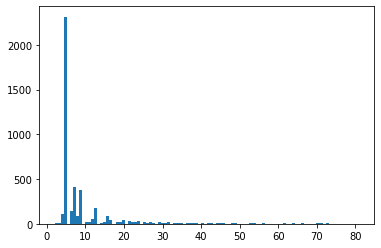

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
2   80053befc2d42fba.jpg      3       672
5   800a7ffa85c57a3a.jpg      3     25583
21  802a75e51eda5c67.jpg      9      5388
22  802a7af055d739e9.jpg     50     45049
********** TEST 1

Images: 12308, Labels: 3717, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 17
Avg img per super_class: 168.6, Min img per super_class: 3, max img per super_class: 1614
Len split1: 61242
Len split2: 16091
(len split1) / (len split2): 3.8059784972966253
Len split1: 68460
Len split2: 8873
(len split1) / (len split2): 7.715541530485743
Len split1: 71840
Len split2: 5493
(len split1) / (len split2): 13.078463498998726
Len split1: 60347

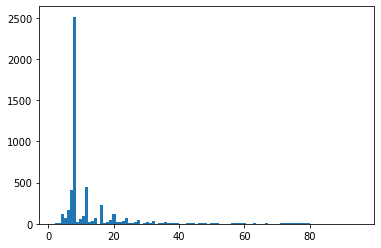

5092
second thresh =  4243
Len split1: 55314
Len split2: 10975
(len split1) / (len split2): 5.04
len(s1) / len(s2) = 5.04

Images: 55314, Labels: 4243, Super_labels: 74
Avg img per class: 13.04, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.49, Min img per super_class: 8, max img per super_class: 6730
*********

Images: 10975, Labels: 849, Super_labels: 64
Avg img per class: 12.93, Min img per class: 2, max img per class: 86
Avg img per super_class: 171.48, Min img per super_class: 2, max img per super_class: 1427

Images: 55314, Labels: 4243, Super_labels: 74
Avg img per class: 13.04, Min img per class: 2, max img per class: 95
Avg img per super_class: 747.49, Min img per super_class: 8, max img per super_class: 6730
********** TEST 2

Images: 10975, Labels: 849, Super_labels: 64
Avg img per class: 12.93, Min img per class: 2, max img per class: 86
Avg img per super_class: 171.48, Min img per super_class: 2, max img per super_class: 1427
Under thresh:
Under 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12042, Labels: 3577, Super_labels: 72
Avg img per class: 3.37, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.25, Min img per super_class: 3, max img per super_class: 1565
*****

Images: 43272, Labels: 4243, Super_labels: 74
Avg img per class: 10.2, Min img per class: 2, max img per class: 88
Avg img per super_class: 584.76, Min img per super_class: 5, max img per super_class: 5165


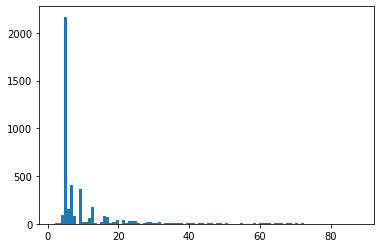

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
12  801f7ce821c7dfd0.jpg     89     27809
24  802aef94c02bbfd5.jpg      6     62831
38  80333fc0783e27f9.jpg     42     24915
73  803f70955e2a6d75.jpg     89     54473
********** TEST 1

Images: 12042, Labels: 3577, Super_labels: 72
Avg img per class: 3.37, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.25, Min img per super_class: 3, max img per super_class: 1565
Len split1: 68378
Len split2: 8955
(len split1) / (len split2): 7.635734226689
Len split1: 56226
Len split2: 21107
(len split1) / (len split2): 2.663855592931255
Len split1: 60672
Len split2: 16661
(len split1) / (len split2): 3.6415581297641197
Len split1: 63393
L

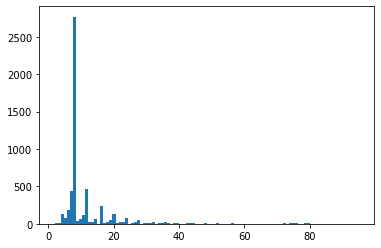

5408
second thresh =  4506
Len split1: 54587
Len split2: 11740
(len split1) / (len split2): 4.649659284497445
len(s1) / len(s2) = 4.649659284497445
Len split1: 55402
Len split2: 10925
(len split1) / (len split2): 5.071121281464531
len(s1) / len(s2) = 5.071121281464531
Len split1: 55361
Len split2: 10966
(len split1) / (len split2): 5.0484223964982675
len(s1) / len(s2) = 5.0484223964982675

Images: 55361, Labels: 4506, Super_labels: 75
Avg img per class: 12.29, Min img per class: 2, max img per class: 95
Avg img per super_class: 738.15, Min img per super_class: 8, max img per super_class: 6812
*********

Images: 10966, Labels: 902, Super_labels: 58
Avg img per class: 12.16, Min img per class: 3, max img per class: 92
Avg img per super_class: 189.07, Min img per super_class: 8, max img per super_class: 1345

Images: 55361, Labels: 4506, Super_labels: 75
Avg img per class: 12.29, Min img per class: 2, max img per class: 95
Avg img per super_class: 738.15, Min img per super_class: 8, max i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12449, Labels: 3786, Super_labels: 74
Avg img per class: 3.29, Min img per class: 3, max img per class: 15
Avg img per super_class: 168.23, Min img per super_class: 3, max img per super_class: 1599
*****

Images: 42912, Labels: 4506, Super_labels: 75
Avg img per class: 9.52, Min img per class: 2, max img per class: 83
Avg img per super_class: 572.16, Min img per super_class: 5, max img per super_class: 5213


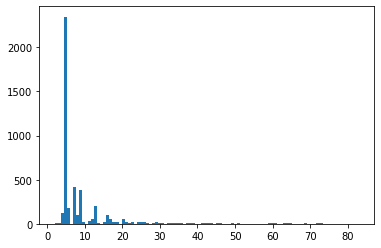

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
9   80196e6999ce63cf.jpg     90     55532
13  8020ee1f3f7781da.jpg     52      2498
19  802a2be985975e5f.jpg     83     21874
20  802a5f42fdf0ab95.jpg     89     43666
********** TEST 1

Images: 12449, Labels: 3786, Super_labels: 74
Avg img per class: 3.29, Min img per class: 3, max img per class: 15
Avg img per super_class: 168.23, Min img per super_class: 3, max img per super_class: 1599
Len split1: 73540
Len split2: 3793
(len split1) / (len split2): 19.38834695491695
Len split1: 69451
Len split2: 7882
(len split1) / (len split2): 8.811342298908906
Len split1: 51736
Len split2: 25597
(len split1) / (len split2): 2.021174356369887
Len split1: 61329


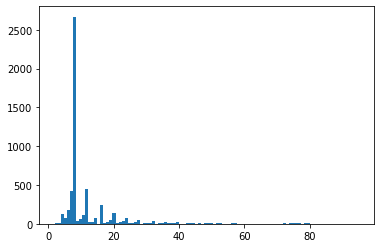

5302
second thresh =  4418
Len split1: 55286
Len split2: 11008
(len split1) / (len split2): 5.0223473837209305
len(s1) / len(s2) = 5.0223473837209305

Images: 55286, Labels: 4418, Super_labels: 73
Avg img per class: 12.51, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.34, Min img per super_class: 6, max img per super_class: 6723
*********

Images: 11008, Labels: 884, Super_labels: 61
Avg img per class: 12.45, Min img per class: 3, max img per class: 95
Avg img per super_class: 180.46, Min img per super_class: 5, max img per super_class: 1434

Images: 55286, Labels: 4418, Super_labels: 73
Avg img per class: 12.51, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.34, Min img per super_class: 6, max img per super_class: 6723
********** TEST 2

Images: 11008, Labels: 884, Super_labels: 61
Avg img per class: 12.45, Min img per class: 3, max img per class: 95
Avg img per super_class: 180.46, Min img per super_class: 5, max img per super_clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12316, Labels: 3734, Super_labels: 72
Avg img per class: 3.3, Min img per class: 3, max img per class: 18
Avg img per super_class: 171.06, Min img per super_class: 3, max img per super_class: 1576
*****

Images: 42970, Labels: 4418, Super_labels: 73
Avg img per class: 9.73, Min img per class: 2, max img per class: 79
Avg img per super_class: 588.63, Min img per super_class: 5, max img per super_class: 5147


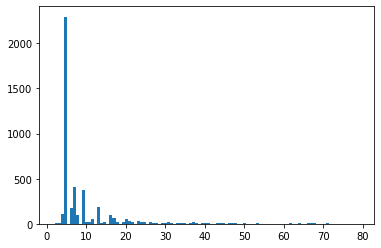

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
13  8020ee1f3f7781da.jpg     52      2498
31  802ddd0a3f70a9f5.jpg     87     18450
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 12316, Labels: 3734, Super_labels: 72
Avg img per class: 3.3, Min img per class: 3, max img per class: 18
Avg img per super_class: 171.06, Min img per super_class: 3, max img per super_class: 1576
Len split1: 70716
Len split2: 6617
(len split1) / (len split2): 10.687018286232432
Len split1: 69248
Len split2: 8085
(len split1) / (len split2): 8.56499690785405
Len split1: 66415
Len split2: 10918
(len split1) / (len split2): 6.083073823044514
Len split1: 69427
L

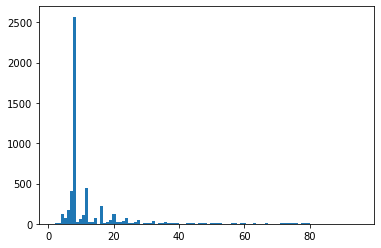

5155
second thresh =  4295
Len split1: 55087
Len split2: 11248
(len split1) / (len split2): 4.897492887624467
len(s1) / len(s2) = 4.897492887624467
Len split1: 55079
Len split2: 11256
(len split1) / (len split2): 4.893301350390902
len(s1) / len(s2) = 4.893301350390902
Len split1: 55576
Len split2: 10759
(len split1) / (len split2): 5.165535830467515
len(s1) / len(s2) = 5.165535830467515
Len split1: 54744
Len split2: 11591
(len split1) / (len split2): 4.722974721766888
len(s1) / len(s2) = 4.722974721766888
Len split1: 55230
Len split2: 11105
(len split1) / (len split2): 4.973435389464205
len(s1) / len(s2) = 4.973435389464205

Images: 55230, Labels: 4295, Super_labels: 73
Avg img per class: 12.86, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.58, Min img per super_class: 8, max img per super_class: 6977
*********

Images: 11105, Labels: 860, Super_labels: 59
Avg img per class: 12.91, Min img per class: 2, max img per class: 86
Avg img per super_class: 188.22, M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12009, Labels: 3631, Super_labels: 71
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 169.14, Min img per super_class: 3, max img per super_class: 1597
*****

Images: 43221, Labels: 4295, Super_labels: 73
Avg img per class: 10.06, Min img per class: 2, max img per class: 91
Avg img per super_class: 592.07, Min img per super_class: 5, max img per super_class: 5380


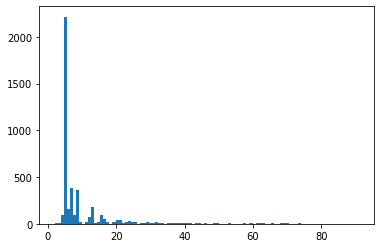

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
51  803b5bf6a65459c9.jpg     89      8766
65  803eec8557fb2895.jpg      4     17623
67  803f07609d6fd25d.jpg     80     21881
81  803f7fa8d0d6d2a8.jpg      5     20382
********** TEST 1

Images: 12009, Labels: 3631, Super_labels: 71
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 169.14, Min img per super_class: 3, max img per super_class: 1597
Len split1: 62956
Len split2: 14377
(len split1) / (len split2): 4.378938582458093
Len split1: 72507
Len split2: 4826
(len split1) / (len split2): 15.024243680066308
Len split1: 62420
Len split2: 14913
(len split1) / (len split2): 4.185609870582713
Len split1: 7106

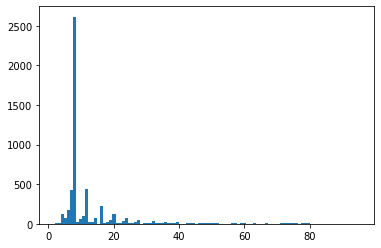

5197
second thresh =  4330
Len split1: 55269
Len split2: 11044
(len split1) / (len split2): 5.0044367982615
len(s1) / len(s2) = 5.0044367982615

Images: 55269, Labels: 4330, Super_labels: 74
Avg img per class: 12.76, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.88, Min img per super_class: 8, max img per super_class: 6917
*********

Images: 11044, Labels: 867, Super_labels: 60
Avg img per class: 12.74, Min img per class: 2, max img per class: 83
Avg img per super_class: 184.07, Min img per super_class: 4, max img per super_class: 1240

Images: 55269, Labels: 4330, Super_labels: 74
Avg img per class: 12.76, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.88, Min img per super_class: 8, max img per super_class: 6917
********** TEST 2

Images: 11044, Labels: 867, Super_labels: 60
Avg img per class: 12.74, Min img per class: 2, max img per class: 83
Avg img per super_class: 184.07, Min img per super_class: 4, max img per super_class: 124

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12123, Labels: 3666, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 17
Avg img per super_class: 166.07, Min img per super_class: 3, max img per super_class: 1598
*****

Images: 43146, Labels: 4330, Super_labels: 74
Avg img per class: 9.96, Min img per class: 2, max img per class: 88
Avg img per super_class: 583.05, Min img per super_class: 5, max img per super_class: 5319


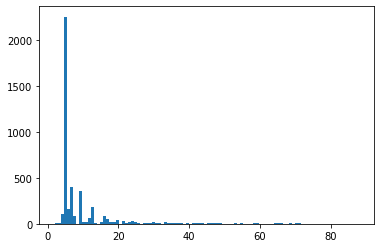

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
21  802a75e51eda5c67.jpg      9      5388
24  802aef94c02bbfd5.jpg      6     62831
31  802ddd0a3f70a9f5.jpg     87     18450
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 12123, Labels: 3666, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 17
Avg img per super_class: 166.07, Min img per super_class: 3, max img per super_class: 1598
Len split1: 70760
Len split2: 6573
(len split1) / (len split2): 10.765251787616005
Len split1: 68829
Len split2: 8504
(len split1) / (len split2): 8.093720602069615
Len split1: 69296
Len split2: 8037
(len split1) / (len split2): 8.622122682593007
Len split1: 62945


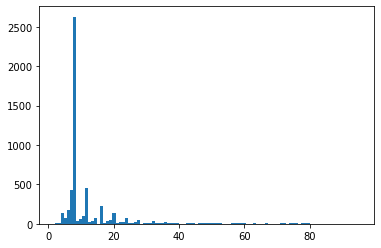

5254
second thresh =  4378
Len split1: 54627
Len split2: 11713
(len split1) / (len split2): 4.663792367454964
len(s1) / len(s2) = 4.663792367454964
Len split1: 55163
Len split2: 11177
(len split1) / (len split2): 4.93540305985506
len(s1) / len(s2) = 4.93540305985506
Len split1: 54808
Len split2: 11532
(len split1) / (len split2): 4.752688172043011
len(s1) / len(s2) = 4.752688172043011
Len split1: 55042
Len split2: 11298
(len split1) / (len split2): 4.871835723136838
len(s1) / len(s2) = 4.871835723136838
Len split1: 55297
Len split2: 11043
(len split1) / (len split2): 5.007425518427963
len(s1) / len(s2) = 5.007425518427963

Images: 55297, Labels: 4378, Super_labels: 75
Avg img per class: 12.63, Min img per class: 2, max img per class: 87
Avg img per super_class: 737.29, Min img per super_class: 7, max img per super_class: 6849
*********

Images: 11043, Labels: 876, Super_labels: 65
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 169.89, Min

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12218, Labels: 3692, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 165.11, Min img per super_class: 3, max img per super_class: 1612
*****

Images: 43079, Labels: 4378, Super_labels: 75
Avg img per class: 9.84, Min img per class: 2, max img per class: 83
Avg img per super_class: 574.39, Min img per super_class: 5, max img per super_class: 5237


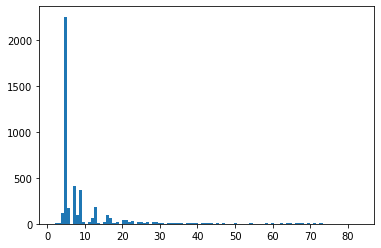

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
17  80296afd55d516ea.jpg      5     44677
19  802a2be985975e5f.jpg     83     21874
23  802aab95d62b7daa.jpg      6     33712
28  802bd28ddce08fbd.jpg      6     25918
********** TEST 1

Images: 12218, Labels: 3692, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 165.11, Min img per super_class: 3, max img per super_class: 1612
Len split1: 62210
Len split2: 15123
(len split1) / (len split2): 4.113601798584937
Len split1: 55864
Len split2: 21469
(len split1) / (len split2): 2.6020774139456893
Len split1: 71091
Len split2: 6242
(len split1) / (len split2): 11.389138096763858
Len split1: 733

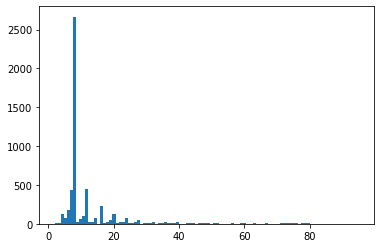

5279
second thresh =  4399
Len split1: 55665
Len split2: 10680
(len split1) / (len split2): 5.212078651685394
len(s1) / len(s2) = 5.212078651685394
Len split1: 55361
Len split2: 10984
(len split1) / (len split2): 5.040149308084486
len(s1) / len(s2) = 5.040149308084486

Images: 55361, Labels: 4399, Super_labels: 74
Avg img per class: 12.58, Min img per class: 2, max img per class: 95
Avg img per super_class: 748.12, Min img per super_class: 8, max img per super_class: 6933
*********

Images: 10984, Labels: 880, Super_labels: 61
Avg img per class: 12.48, Min img per class: 2, max img per class: 95
Avg img per super_class: 180.07, Min img per super_class: 4, max img per super_class: 1224

Images: 55361, Labels: 4399, Super_labels: 74
Avg img per class: 12.58, Min img per class: 2, max img per class: 95
Avg img per super_class: 748.12, Min img per super_class: 8, max img per super_class: 6933
********** TEST 2

Images: 10984, Labels: 880, Super_labels: 61
Avg img per class: 12.48, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12270, Labels: 3710, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.42, Min img per super_class: 3, max img per super_class: 1604
*****

Images: 43091, Labels: 4399, Super_labels: 74
Avg img per class: 9.8, Min img per class: 2, max img per class: 88
Avg img per super_class: 582.31, Min img per super_class: 5, max img per super_class: 5329


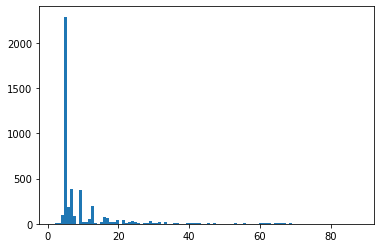

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
128  805f27a3bb4896a7.jpg      9     14532
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
20  802a5f42fdf0ab95.jpg     89     43666
28  802bd28ddce08fbd.jpg      6     25918
61  803e7b9595fa2a25.jpg      6     15263
********** TEST 1

Images: 12270, Labels: 3710, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.42, Min img per super_class: 3, max img per super_class: 1604
Len split1: 73874
Len split2: 3459
(len split1) / (len split2): 21.35703960682278
Len split1: 70880
Len split2: 6453
(len split1) / (len split2): 10.984038431737176
Len split1: 67970
Len split2: 9363
(len split1) / (len split2): 7.259425397842572
Len split1: 63577


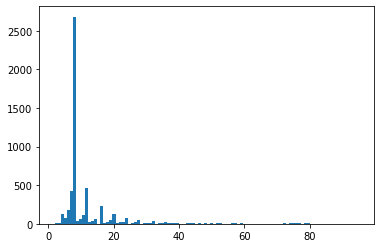

5315
second thresh =  4429
Len split1: 55274
Len split2: 11058
(len split1) / (len split2): 4.998553083740279
len(s1) / len(s2) = 4.998553083740279

Images: 55274, Labels: 4429, Super_labels: 74
Avg img per class: 12.48, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.95, Min img per super_class: 7, max img per super_class: 6931
*********

Images: 11058, Labels: 886, Super_labels: 62
Avg img per class: 12.48, Min img per class: 2, max img per class: 95
Avg img per super_class: 178.35, Min img per super_class: 6, max img per super_class: 1226

Images: 55274, Labels: 4429, Super_labels: 74
Avg img per class: 12.48, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.95, Min img per super_class: 7, max img per super_class: 6931
********** TEST 2

Images: 11058, Labels: 886, Super_labels: 62
Avg img per class: 12.48, Min img per class: 2, max img per class: 95
Avg img per super_class: 178.35, Min img per super_class: 6, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12275, Labels: 3743, Super_labels: 72
Avg img per class: 3.28, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.49, Min img per super_class: 3, max img per super_class: 1603
*****

Images: 42999, Labels: 4429, Super_labels: 74
Avg img per class: 9.71, Min img per class: 2, max img per class: 86
Avg img per super_class: 581.07, Min img per super_class: 5, max img per super_class: 5328


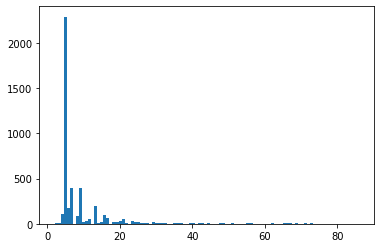

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
31  802ddd0a3f70a9f5.jpg     87     18450
39  803570c58f9ba1f7.jpg     87     37779
51  803b5bf6a65459c9.jpg     89      8766
55  803d7a43427ff585.jpg     71     17105
********** TEST 1

Images: 12275, Labels: 3743, Super_labels: 72
Avg img per class: 3.28, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.49, Min img per super_class: 3, max img per super_class: 1603
Len split1: 69654
Len split2: 7679
(len split1) / (len split2): 9.070712332334939
Len split1: 69722
Len split2: 7611
(len split1) / (len split2): 9.160688477204047
Len split1: 71398
Len split2: 5935
(len split1) / (len split2): 12.02999157540017
Len split1: 58154
L

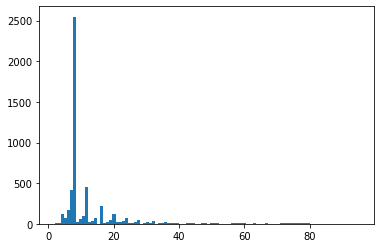

5145
second thresh =  4287
Len split1: 55406
Len split2: 10899
(len split1) / (len split2): 5.083585650059638
len(s1) / len(s2) = 5.083585650059638
Len split1: 55260
Len split2: 11045
(len split1) / (len split2): 5.003168854685378
len(s1) / len(s2) = 5.003168854685378

Images: 55260, Labels: 4287, Super_labels: 73
Avg img per class: 12.89, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.99, Min img per super_class: 8, max img per super_class: 6740
*********

Images: 11045, Labels: 858, Super_labels: 65
Avg img per class: 12.87, Min img per class: 2, max img per class: 82
Avg img per super_class: 169.92, Min img per super_class: 2, max img per super_class: 1417

Images: 55260, Labels: 4287, Super_labels: 73
Avg img per class: 12.89, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.99, Min img per super_class: 8, max img per super_class: 6740
********** TEST 2

Images: 11045, Labels: 858, Super_labels: 65
Avg img per class: 12.87, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12138, Labels: 3618, Super_labels: 71
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.96, Min img per super_class: 3, max img per super_class: 1575
*****

Images: 43122, Labels: 4287, Super_labels: 73
Avg img per class: 10.06, Min img per class: 2, max img per class: 84
Avg img per super_class: 590.71, Min img per super_class: 5, max img per super_class: 5165


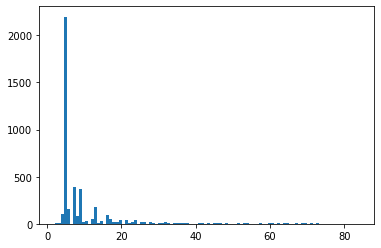

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
21  802a75e51eda5c67.jpg      9      5388
22  802a7af055d739e9.jpg     50     45049
23  802aab95d62b7daa.jpg      6     33712
********** TEST 1

Images: 12138, Labels: 3618, Super_labels: 71
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.96, Min img per super_class: 3, max img per super_class: 1575
Len split1: 73261
Len split2: 4072
(len split1) / (len split2): 17.9914047151277
Len split1: 71561
Len split2: 5772
(len split1) / (len split2): 12.397955647955648
Len split1: 67674
Len split2: 9659
(len split1) / (len split2): 7.0063153535562686
Len split1: 73720
Len sp

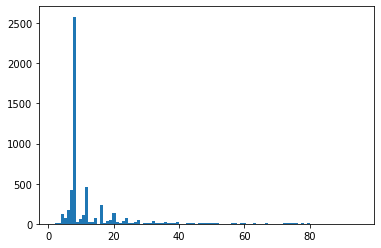

5201
second thresh =  4334
Len split1: 54591
Len split2: 11710
(len split1) / (len split2): 4.661912894961572
len(s1) / len(s2) = 4.661912894961572
Len split1: 54560
Len split2: 11741
(len split1) / (len split2): 4.646963631717911
len(s1) / len(s2) = 4.646963631717911
Len split1: 54726
Len split2: 11575
(len split1) / (len split2): 4.727948164146868
len(s1) / len(s2) = 4.727948164146868
Len split1: 55200
Len split2: 11101
(len split1) / (len split2): 4.972524997747951
len(s1) / len(s2) = 4.972524997747951

Images: 55200, Labels: 4334, Super_labels: 75
Avg img per class: 12.74, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.0, Min img per super_class: 8, max img per super_class: 6895
*********

Images: 11101, Labels: 867, Super_labels: 58
Avg img per class: 12.8, Min img per class: 3, max img per class: 84
Avg img per super_class: 191.4, Min img per super_class: 7, max img per super_class: 1262

Images: 55200, Labels: 4334, Super_labels: 75
Avg img per class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12193, Labels: 3674, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 15
Avg img per super_class: 164.77, Min img per super_class: 3, max img per super_class: 1609
*****

Images: 43007, Labels: 4334, Super_labels: 75
Avg img per class: 9.92, Min img per class: 2, max img per class: 92
Avg img per super_class: 573.43, Min img per super_class: 5, max img per super_class: 5286


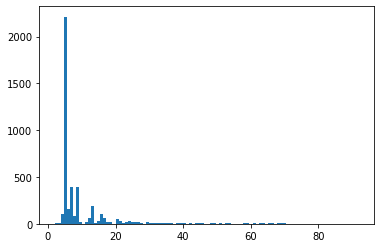

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
6   800bafacb4555b2f.jpg     82      6261
11  801aff45ebd0bcd0.jpg     78     26666
23  802aab95d62b7daa.jpg      6     33712
********** TEST 1

Images: 12193, Labels: 3674, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 15
Avg img per super_class: 164.77, Min img per super_class: 3, max img per super_class: 1609
Len split1: 69434
Len split2: 7899
(len split1) / (len split2): 8.790226610963414
Len split1: 71201
Len split2: 6132
(len split1) / (len split2): 11.611382909328114
Len split1: 68755
Len split2: 8578
(len split1) / (len split2): 8.015271625087433
Len split1: 60379


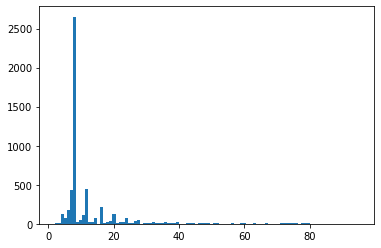

5244
second thresh =  4370
Len split1: 55375
Len split2: 10980
(len split1) / (len split2): 5.043260473588343
len(s1) / len(s2) = 5.043260473588343

Images: 55375, Labels: 4370, Super_labels: 73
Avg img per class: 12.67, Min img per class: 2, max img per class: 95
Avg img per super_class: 758.56, Min img per super_class: 8, max img per super_class: 6590
*********

Images: 10980, Labels: 874, Super_labels: 64
Avg img per class: 12.56, Min img per class: 2, max img per class: 80
Avg img per super_class: 171.56, Min img per super_class: 2, max img per super_class: 1567

Images: 55375, Labels: 4370, Super_labels: 73
Avg img per class: 12.67, Min img per class: 2, max img per class: 95
Avg img per super_class: 758.56, Min img per super_class: 8, max img per super_class: 6590
********** TEST 2

Images: 10980, Labels: 874, Super_labels: 64
Avg img per class: 12.56, Min img per class: 2, max img per class: 80
Avg img per super_class: 171.56, Min img per super_class: 2, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12191, Labels: 3672, Super_labels: 72
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 169.32, Min img per super_class: 3, max img per super_class: 1568
*****

Images: 43184, Labels: 4370, Super_labels: 73
Avg img per class: 9.88, Min img per class: 2, max img per class: 88
Avg img per super_class: 591.56, Min img per super_class: 5, max img per super_class: 5022


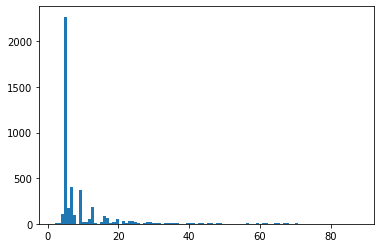

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
22  802a7af055d739e9.jpg     50     45049
35  802f7ff490819fc9.jpg     87      5697
51  803b5bf6a65459c9.jpg     89      8766
********** TEST 1

Images: 12191, Labels: 3672, Super_labels: 72
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 169.32, Min img per super_class: 3, max img per super_class: 1568
Len split1: 68562
Len split2: 8771
(len split1) / (len split2): 7.81689659103865
Len split1: 65243
Len split2: 12090
(len split1) / (len split2): 5.396443341604632
Len split1: 71343
Len split2: 5990
(len split1) / (len split2): 11.910350584307178
Len split1: 73165


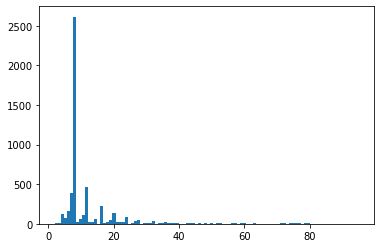

5207
second thresh =  4339
Len split1: 55459
Len split2: 10863
(len split1) / (len split2): 5.10531160821136
len(s1) / len(s2) = 5.10531160821136
Len split1: 55765
Len split2: 10557
(len split1) / (len split2): 5.282277162072559
len(s1) / len(s2) = 5.282277162072559
Len split1: 55104
Len split2: 11218
(len split1) / (len split2): 4.912105544660367
len(s1) / len(s2) = 4.912105544660367
Len split1: 55512
Len split2: 10810
(len split1) / (len split2): 5.135245143385754
len(s1) / len(s2) = 5.135245143385754
Len split1: 54923
Len split2: 11399
(len split1) / (len split2): 4.818229669269234
len(s1) / len(s2) = 4.818229669269234
Len split1: 55147
Len split2: 11175
(len split1) / (len split2): 4.934854586129754
len(s1) / len(s2) = 4.934854586129754
Len split1: 55188
Len split2: 11134
(len split1) / (len split2): 4.956709179091073
len(s1) / len(s2) = 4.956709179091073

Images: 55188, Labels: 4339, Super_labels: 74
Avg img per class: 12.72, Min img per class: 2, max img per class: 95
Avg img per

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12208, Labels: 3693, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 19
Avg img per super_class: 167.23, Min img per super_class: 3, max img per super_class: 1617
*****

Images: 42980, Labels: 4339, Super_labels: 74
Avg img per class: 9.91, Min img per class: 2, max img per class: 87
Avg img per super_class: 580.81, Min img per super_class: 5, max img per super_class: 5315


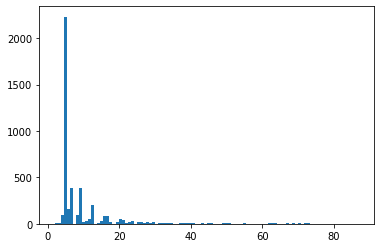

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
13  8020ee1f3f7781da.jpg     52      2498
23  802aab95d62b7daa.jpg      6     33712
34  802f7fd0d42f2cca.jpg      6     32426
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 12208, Labels: 3693, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 19
Avg img per super_class: 167.23, Min img per super_class: 3, max img per super_class: 1617
Len split1: 65505
Len split2: 11828
(len split1) / (len split2): 5.538129861345959
Len split1: 69842
Len split2: 7491
(len split1) / (len split2): 9.323454812441597
Len split1: 67017
Len split2: 10316
(len split1) / (len split2): 6.496413338503296
Len split1: 65732

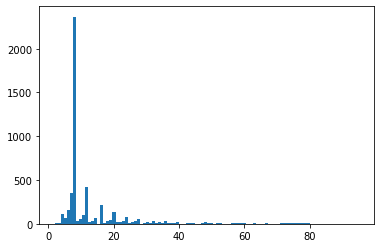

4887
second thresh =  4072
Len split1: 55120
Len split2: 11095
(len split1) / (len split2): 4.9680036052275796
len(s1) / len(s2) = 4.9680036052275796

Images: 55120, Labels: 4072, Super_labels: 75
Avg img per class: 13.54, Min img per class: 2, max img per class: 95
Avg img per super_class: 734.93, Min img per super_class: 8, max img per super_class: 6638
*********

Images: 11095, Labels: 815, Super_labels: 58
Avg img per class: 13.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 191.29, Min img per super_class: 8, max img per super_class: 1519

Images: 55120, Labels: 4072, Super_labels: 75
Avg img per class: 13.54, Min img per class: 2, max img per class: 95
Avg img per super_class: 734.93, Min img per super_class: 8, max img per super_class: 6638
********** TEST 2

Images: 11095, Labels: 815, Super_labels: 58
Avg img per class: 13.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 191.29, Min img per super_class: 8, max img per super_clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11764, Labels: 3489, Super_labels: 74
Avg img per class: 3.37, Min img per class: 3, max img per class: 18
Avg img per super_class: 158.97, Min img per super_class: 3, max img per super_class: 1548
*****

Images: 43356, Labels: 4072, Super_labels: 75
Avg img per class: 10.65, Min img per class: 2, max img per class: 92
Avg img per super_class: 578.08, Min img per super_class: 5, max img per super_class: 5090


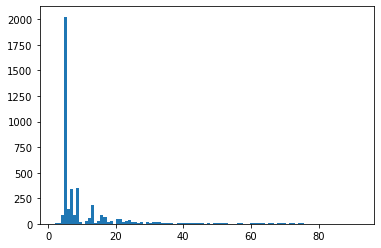

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
19  802a2be985975e5f.jpg     83     21874
23  802aab95d62b7daa.jpg      6     33712
30  802beb95d5aac0d7.jpg     78     50595
44  803733bb5bc92c17.jpg      8     53692
51  803b5bf6a65459c9.jpg     89      8766
********** TEST 1

Images: 11764, Labels: 3489, Super_labels: 74
Avg img per class: 3.37, Min img per class: 3, max img per class: 18
Avg img per super_class: 158.97, Min img per super_class: 3, max img per super_class: 1548
Len split1: 65113
Len split2: 12220
(len split1) / (len split2): 5.328396072013093
Len split1: 68678
Len split2: 8655
(len split1) / (len split2): 7.935066435586366
Len split1: 66765
Len split2: 10568
(len split1) / (len split2): 6.3176570779712335
Len split1: 6789

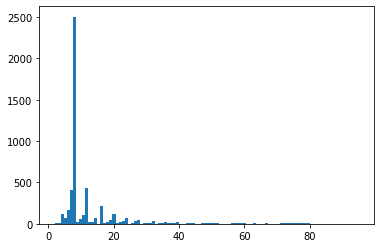

5059
second thresh =  4215
Len split1: 55509
Len split2: 10819
(len split1) / (len split2): 5.130695997781681
len(s1) / len(s2) = 5.130695997781681
Len split1: 54719
Len split2: 11609
(len split1) / (len split2): 4.71349814798863
len(s1) / len(s2) = 4.71349814798863
Len split1: 55558
Len split2: 10770
(len split1) / (len split2): 5.1585886722376975
len(s1) / len(s2) = 5.1585886722376975
Len split1: 54910
Len split2: 11418
(len split1) / (len split2): 4.809073392888422
len(s1) / len(s2) = 4.809073392888422
Len split1: 55367
Len split2: 10961
(len split1) / (len split2): 5.051272694097254
len(s1) / len(s2) = 5.051272694097254
Len split1: 54986
Len split2: 11342
(len split1) / (len split2): 4.847998589314054
len(s1) / len(s2) = 4.847998589314054
Len split1: 55190
Len split2: 11138
(len split1) / (len split2): 4.955108637098222
len(s1) / len(s2) = 4.955108637098222

Images: 55190, Labels: 4215, Super_labels: 75
Avg img per class: 13.09, Min img per class: 2, max img per class: 95
Avg img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12011, Labels: 3573, Super_labels: 74
Avg img per class: 3.36, Min img per class: 3, max img per class: 16
Avg img per super_class: 162.31, Min img per super_class: 3, max img per super_class: 1647
*****

Images: 43179, Labels: 4215, Super_labels: 75
Avg img per class: 10.24, Min img per class: 2, max img per class: 92
Avg img per super_class: 575.72, Min img per super_class: 5, max img per super_class: 5424


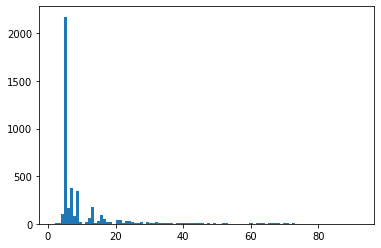

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
286  8084fead05cb5d7a.jpg      6     43451
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
2   80053befc2d42fba.jpg      3       672
13  8020ee1f3f7781da.jpg     52      2498
20  802a5f42fdf0ab95.jpg     89     43666
24  802aef94c02bbfd5.jpg      6     62831
********** TEST 1

Images: 12011, Labels: 3573, Super_labels: 74
Avg img per class: 3.36, Min img per class: 3, max img per class: 16
Avg img per super_class: 162.31, Min img per super_class: 3, max img per super_class: 1647
Len split1: 65288
Len split2: 12045
(len split1) / (len split2): 5.420340390203404
Len split1: 71515
Len split2: 5818
(len split1) / (len split2): 12.29202475077346
Len split1: 71327
Len split2: 6006
(len split1) / (len split2): 11.875957375957375
Len split1: 61489

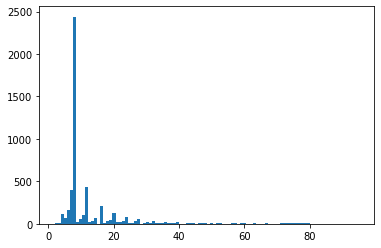

5018
second thresh =  4181
Len split1: 55634
Len split2: 10678
(len split1) / (len split2): 5.210151713804083
len(s1) / len(s2) = 5.210151713804083
Len split1: 55464
Len split2: 10848
(len split1) / (len split2): 5.1128318584070795
len(s1) / len(s2) = 5.1128318584070795
Len split1: 55368
Len split2: 10944
(len split1) / (len split2): 5.059210526315789
len(s1) / len(s2) = 5.059210526315789
Len split1: 55197
Len split2: 11115
(len split1) / (len split2): 4.965991902834008
len(s1) / len(s2) = 4.965991902834008

Images: 55197, Labels: 4181, Super_labels: 75
Avg img per class: 13.2, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.96, Min img per super_class: 8, max img per super_class: 5329
*********

Images: 11115, Labels: 837, Super_labels: 62
Avg img per class: 13.28, Min img per class: 2, max img per class: 92
Avg img per super_class: 179.27, Min img per super_class: 2, max img per super_class: 1233

Images: 55197, Labels: 4181, Super_labels: 75
Avg img per clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11982, Labels: 3545, Super_labels: 73
Avg img per class: 3.38, Min img per class: 3, max img per class: 16
Avg img per super_class: 164.14, Min img per super_class: 3, max img per super_class: 1303
*****

Images: 43215, Labels: 4181, Super_labels: 75
Avg img per class: 10.34, Min img per class: 2, max img per class: 85
Avg img per super_class: 576.2, Min img per super_class: 5, max img per super_class: 4026


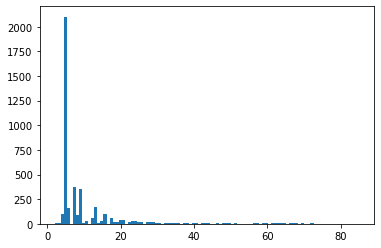

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
5   800a7ffa85c57a3a.jpg      3     25583
11  801aff45ebd0bcd0.jpg     78     26666
22  802a7af055d739e9.jpg     50     45049
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 11982, Labels: 3545, Super_labels: 73
Avg img per class: 3.38, Min img per class: 3, max img per class: 16
Avg img per super_class: 164.14, Min img per super_class: 3, max img per super_class: 1303
Len split1: 70682
Len split2: 6651
(len split1) / (len split2): 10.627274094121185
Len split1: 66434
Len split2: 10899
(len split1) / (len split2): 6.095421598311772
Len split1: 64277
Len split2: 13056
(len split1) / (len split2): 4.923177083333333
Len split1: 70805
Len 

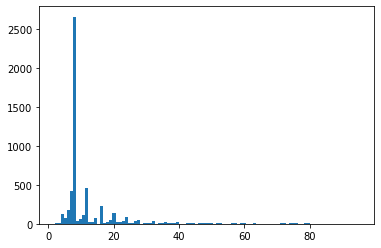

5288
second thresh =  4406
Len split1: 55062
Len split2: 11295
(len split1) / (len split2): 4.874900398406375
len(s1) / len(s2) = 4.874900398406375
Len split1: 55509
Len split2: 10848
(len split1) / (len split2): 5.116980088495575
len(s1) / len(s2) = 5.116980088495575
Len split1: 54891
Len split2: 11466
(len split1) / (len split2): 4.787284144427002
len(s1) / len(s2) = 4.787284144427002
Len split1: 55459
Len split2: 10898
(len split1) / (len split2): 5.088915397320609
len(s1) / len(s2) = 5.088915397320609
Len split1: 55380
Len split2: 10977
(len split1) / (len split2): 5.045094288056847
len(s1) / len(s2) = 5.045094288056847

Images: 55380, Labels: 4406, Super_labels: 75
Avg img per class: 12.57, Min img per class: 2, max img per class: 95
Avg img per super_class: 738.4, Min img per super_class: 8, max img per super_class: 6841
*********

Images: 10977, Labels: 882, Super_labels: 63
Avg img per class: 12.45, Min img per class: 2, max img per class: 87
Avg img per super_class: 174.24, Mi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12399, Labels: 3733, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 15
Avg img per super_class: 167.55, Min img per super_class: 3, max img per super_class: 1598
*****

Images: 42981, Labels: 4406, Super_labels: 75
Avg img per class: 9.76, Min img per class: 2, max img per class: 89
Avg img per super_class: 573.08, Min img per super_class: 5, max img per super_class: 5243


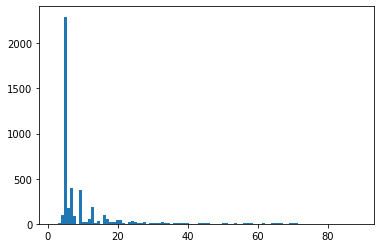

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
12  801f7ce821c7dfd0.jpg     89     27809
26  802b5ed622fd3587.jpg     90     35252
32  802f65855fd85b87.jpg      5     34702
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 12399, Labels: 3733, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 15
Avg img per super_class: 167.55, Min img per super_class: 3, max img per super_class: 1598
Len split1: 74896
Len split2: 2437
(len split1) / (len split2): 30.73286828067296
Len split1: 74149
Len split2: 3184
(len split1) / (len split2): 23.288002512562816
Len split1: 72040
Len split2: 5293
(len split1) / (len split2): 13.610428868316644
Len split1: 67824

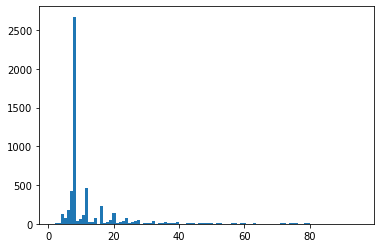

5306
second thresh =  4421
Len split1: 55585
Len split2: 10669
(len split1) / (len split2): 5.209954072546631
len(s1) / len(s2) = 5.209954072546631
Len split1: 55650
Len split2: 10604
(len split1) / (len split2): 5.248019615239532
len(s1) / len(s2) = 5.248019615239532
Len split1: 55036
Len split2: 11218
(len split1) / (len split2): 4.90604385808522
len(s1) / len(s2) = 4.90604385808522
Len split1: 54546
Len split2: 11708
(len split1) / (len split2): 4.658865732832251
len(s1) / len(s2) = 4.658865732832251
Len split1: 55309
Len split2: 10945
(len split1) / (len split2): 5.053357697578803
len(s1) / len(s2) = 5.053357697578803
Len split1: 55072
Len split2: 11182
(len split1) / (len split2): 4.9250581291361115
len(s1) / len(s2) = 4.9250581291361115
Len split1: 55535
Len split2: 10719
(len split1) / (len split2): 5.180987032372423
len(s1) / len(s2) = 5.180987032372423
Len split1: 55239
Len split2: 11015
(len split1) / (len split2): 5.014888788016341
len(s1) / len(s2) = 5.014888788016341

Imag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12312, Labels: 3728, Super_labels: 74
Avg img per class: 3.3, Min img per class: 3, max img per class: 17
Avg img per super_class: 166.38, Min img per super_class: 3, max img per super_class: 1647
*****

Images: 42927, Labels: 4421, Super_labels: 75
Avg img per class: 9.71, Min img per class: 2, max img per class: 88
Avg img per super_class: 572.36, Min img per super_class: 5, max img per super_class: 5265


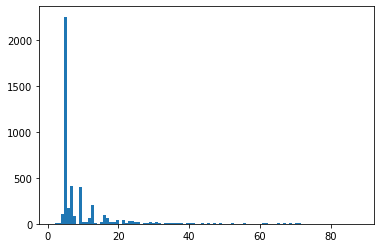

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
26  802b5ed622fd3587.jpg     90     35252
31  802ddd0a3f70a9f5.jpg     87     18450
34  802f7fd0d42f2cca.jpg      6     32426
48  803a7f95384ebc63.jpg     89      1779
********** TEST 1

Images: 12312, Labels: 3728, Super_labels: 74
Avg img per class: 3.3, Min img per class: 3, max img per class: 17
Avg img per super_class: 166.38, Min img per super_class: 3, max img per super_class: 1647
Len split1: 75095
Len split2: 2238
(len split1) / (len split2): 33.55451295799821
Len split1: 67640
Len split2: 9693
(len split1) / (len split2): 6.978231713607758
Len split1: 70643
Len split2: 6690
(len split1) / (len split2): 10.55949177877429
Len split1: 65990
Le

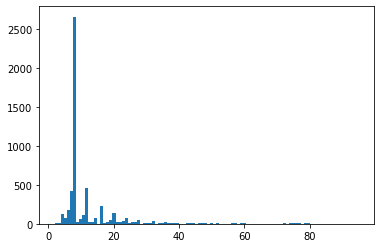

5293
second thresh =  4410
Len split1: 55139
Len split2: 11207
(len split1) / (len split2): 4.920049968769519
len(s1) / len(s2) = 4.920049968769519
Len split1: 55303
Len split2: 11043
(len split1) / (len split2): 5.0079688490446435
len(s1) / len(s2) = 5.0079688490446435

Images: 55303, Labels: 4410, Super_labels: 75
Avg img per class: 12.54, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.37, Min img per super_class: 6, max img per super_class: 6870
*********

Images: 11043, Labels: 883, Super_labels: 62
Avg img per class: 12.51, Min img per class: 4, max img per class: 82
Avg img per super_class: 178.11, Min img per super_class: 4, max img per super_class: 1287

Images: 55303, Labels: 4410, Super_labels: 75
Avg img per class: 12.54, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.37, Min img per super_class: 6, max img per super_class: 6870
********** TEST 2

Images: 11043, Labels: 883, Super_labels: 62
Avg img per class: 12.51, Min im

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12386, Labels: 3734, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 17
Avg img per super_class: 169.67, Min img per super_class: 3, max img per super_class: 1610
*****

Images: 42917, Labels: 4410, Super_labels: 75
Avg img per class: 9.73, Min img per class: 2, max img per class: 84
Avg img per super_class: 572.23, Min img per super_class: 5, max img per super_class: 5260


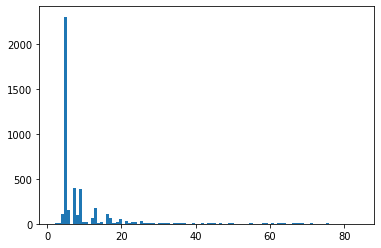

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
223  807f1ac0973d3de2.jpg     76     60569
                  image  chain  hotel_id
0  8000d59f6a3d765f.jpg     85     24607
1  8000febe81817f7f.jpg      6     25389
5  800a7ffa85c57a3a.jpg      3     25583
6  800bafacb4555b2f.jpg     82      6261
9  80196e6999ce63cf.jpg     90     55532
********** TEST 1

Images: 12386, Labels: 3734, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 17
Avg img per super_class: 169.67, Min img per super_class: 3, max img per super_class: 1610
Len split1: 58575
Len split2: 18758
(len split1) / (len split2): 3.122667661797633
Len split1: 55911
Len split2: 21422
(len split1) / (len split2): 2.6099803939874895
Len split1: 70092
Len split2: 7241
(len split1) / (len split2): 9.67987846982461
Len split1: 71671
Len s

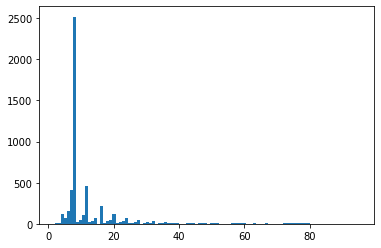

5091
second thresh =  4242
Len split1: 55452
Len split2: 10889
(len split1) / (len split2): 5.092478648177059
len(s1) / len(s2) = 5.092478648177059
Len split1: 55763
Len split2: 10578
(len split1) / (len split2): 5.271601436944602
len(s1) / len(s2) = 5.271601436944602
Len split1: 55650
Len split2: 10691
(len split1) / (len split2): 5.205312879992517
len(s1) / len(s2) = 5.205312879992517
Len split1: 55147
Len split2: 11194
(len split1) / (len split2): 4.926478470609255
len(s1) / len(s2) = 4.926478470609255
Len split1: 55434
Len split2: 10907
(len split1) / (len split2): 5.082424131291831
len(s1) / len(s2) = 5.082424131291831
Len split1: 55795
Len split2: 10546
(len split1) / (len split2): 5.290631519059359
len(s1) / len(s2) = 5.290631519059359
Len split1: 55422
Len split2: 10919
(len split1) / (len split2): 5.0757395365876
len(s1) / len(s2) = 5.0757395365876
Len split1: 55191
Len split2: 11150
(len split1) / (len split2): 4.949865470852018
len(s1) / len(s2) = 4.949865470852018
Len split

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12053, Labels: 3595, Super_labels: 71
Avg img per class: 3.35, Min img per class: 3, max img per class: 17
Avg img per super_class: 169.76, Min img per super_class: 3, max img per super_class: 1590
*****

Images: 43299, Labels: 4242, Super_labels: 73
Avg img per class: 10.21, Min img per class: 2, max img per class: 87
Avg img per super_class: 593.14, Min img per super_class: 5, max img per super_class: 5233


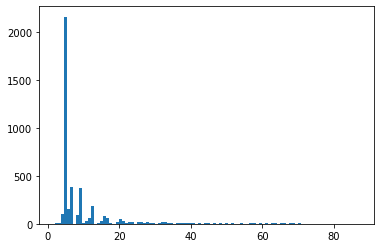

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
3   8007fa0a8fe89f9d.jpg      5     63866
20  802a5f42fdf0ab95.jpg     89     43666
31  802ddd0a3f70a9f5.jpg     87     18450
40  8035ee81817f7f68.jpg      3     22338
********** TEST 1

Images: 12053, Labels: 3595, Super_labels: 71
Avg img per class: 3.35, Min img per class: 3, max img per class: 17
Avg img per super_class: 169.76, Min img per super_class: 3, max img per super_class: 1590
Len split1: 65217
Len split2: 12116
(len split1) / (len split2): 5.382717068339386
Len split1: 66657
Len split2: 10676
(len split1) / (len split2): 6.243630573248407
Len split1: 71199
Len split2: 6134
(len split1) / (len split2): 11.607270948809912
Len split1: 6842

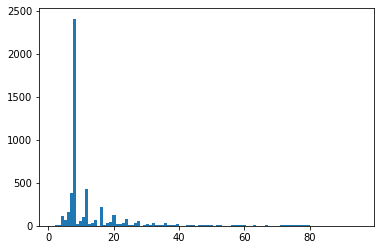

4947
second thresh =  4122
Len split1: 55622
Len split2: 10635
(len split1) / (len split2): 5.2300893276915845
len(s1) / len(s2) = 5.2300893276915845
Len split1: 55171
Len split2: 11086
(len split1) / (len split2): 4.9766372000721635
len(s1) / len(s2) = 4.9766372000721635

Images: 55171, Labels: 4122, Super_labels: 74
Avg img per class: 13.38, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.55, Min img per super_class: 6, max img per super_class: 6487
*********

Images: 11086, Labels: 825, Super_labels: 61
Avg img per class: 13.44, Min img per class: 2, max img per class: 82
Avg img per super_class: 181.74, Min img per super_class: 2, max img per super_class: 1670

Images: 55171, Labels: 4122, Super_labels: 74
Avg img per class: 13.38, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.55, Min img per super_class: 6, max img per super_class: 6487
********** TEST 2

Images: 11086, Labels: 825, Super_labels: 61
Avg img per class: 13.44, Min 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11803, Labels: 3507, Super_labels: 73
Avg img per class: 3.37, Min img per class: 3, max img per class: 16
Avg img per super_class: 161.68, Min img per super_class: 3, max img per super_class: 1515
*****

Images: 43368, Labels: 4122, Super_labels: 74
Avg img per class: 10.52, Min img per class: 2, max img per class: 89
Avg img per super_class: 586.05, Min img per super_class: 5, max img per super_class: 4972


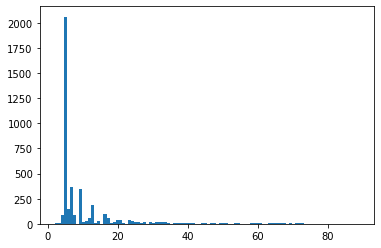

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
9   80196e6999ce63cf.jpg     90     55532
19  802a2be985975e5f.jpg     83     21874
24  802aef94c02bbfd5.jpg      6     62831
38  80333fc0783e27f9.jpg     42     24915
48  803a7f95384ebc63.jpg     89      1779
********** TEST 1

Images: 11803, Labels: 3507, Super_labels: 73
Avg img per class: 3.37, Min img per class: 3, max img per class: 16
Avg img per super_class: 161.68, Min img per super_class: 3, max img per super_class: 1515
Len split1: 71006
Len split2: 6327
(len split1) / (len split2): 11.222696380591117
Len split1: 62766
Len split2: 14567
(len split1) / (len split2): 4.308780119448068
Len split1: 59257
Len split2: 18076
(len split1) / (len split2): 3.2782142066828945
Len split1: 716

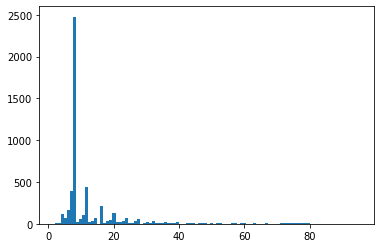

5058
second thresh =  4215
Len split1: 55669
Len split2: 10659
(len split1) / (len split2): 5.222722581855709
len(s1) / len(s2) = 5.222722581855709
Len split1: 55226
Len split2: 11102
(len split1) / (len split2): 4.974419023599351
len(s1) / len(s2) = 4.974419023599351

Images: 55226, Labels: 4215, Super_labels: 74
Avg img per class: 13.1, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.3, Min img per super_class: 6, max img per super_class: 5229
*********

Images: 11102, Labels: 843, Super_labels: 63
Avg img per class: 13.17, Min img per class: 2, max img per class: 81
Avg img per super_class: 176.22, Min img per super_class: 6, max img per super_class: 1099

Images: 55226, Labels: 4215, Super_labels: 74
Avg img per class: 13.1, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.3, Min img per super_class: 6, max img per super_class: 5229
********** TEST 2

Images: 11102, Labels: 843, Super_labels: 63
Avg img per class: 13.17, Min img per 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11929, Labels: 3576, Super_labels: 73
Avg img per class: 3.34, Min img per class: 3, max img per class: 16
Avg img per super_class: 163.41, Min img per super_class: 3, max img per super_class: 1332
*****

Images: 43297, Labels: 4215, Super_labels: 74
Avg img per class: 10.27, Min img per class: 2, max img per class: 87
Avg img per super_class: 585.09, Min img per super_class: 5, max img per super_class: 3897


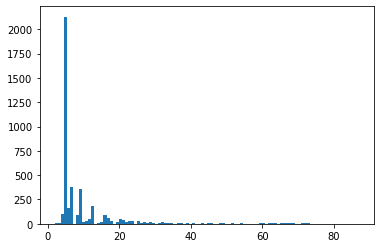

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
12  801f7ce821c7dfd0.jpg     89     27809
13  8020ee1f3f7781da.jpg     52      2498
17  80296afd55d516ea.jpg      5     44677
19  802a2be985975e5f.jpg     83     21874
********** TEST 1

Images: 11929, Labels: 3576, Super_labels: 73
Avg img per class: 3.34, Min img per class: 3, max img per class: 16
Avg img per super_class: 163.41, Min img per super_class: 3, max img per super_class: 1332
Len split1: 60765
Len split2: 16568
(len split1) / (len split2): 3.66761226460647
Len split1: 72431
Len split2: 4902
(len split1) / (len split2): 14.775805793553651
Len split1: 71663
Len split2: 5670
(len split1) / (len split2): 12.638977072310405
Len split1: 62534
Len s

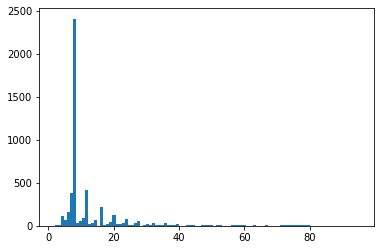

4963
second thresh =  4135
Len split1: 55180
Len split2: 11157
(len split1) / (len split2): 4.945773953571749
len(s1) / len(s2) = 4.945773953571749
Len split1: 55529
Len split2: 10808
(len split1) / (len split2): 5.137768319763138
len(s1) / len(s2) = 5.137768319763138
Len split1: 55081
Len split2: 11256
(len split1) / (len split2): 4.8934790334044065
len(s1) / len(s2) = 4.8934790334044065
Len split1: 55303
Len split2: 11034
(len split1) / (len split2): 5.01205365234729
len(s1) / len(s2) = 5.01205365234729

Images: 55303, Labels: 4135, Super_labels: 72
Avg img per class: 13.37, Min img per class: 2, max img per class: 95
Avg img per super_class: 768.1, Min img per super_class: 8, max img per super_class: 6801
*********

Images: 11034, Labels: 828, Super_labels: 64
Avg img per class: 13.33, Min img per class: 2, max img per class: 84
Avg img per super_class: 172.41, Min img per super_class: 8, max img per super_class: 1356

Images: 55303, Labels: 4135, Super_labels: 72
Avg img per class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11831, Labels: 3510, Super_labels: 72
Avg img per class: 3.37, Min img per class: 3, max img per class: 16
Avg img per super_class: 164.32, Min img per super_class: 3, max img per super_class: 1593
*****

Images: 43472, Labels: 4135, Super_labels: 72
Avg img per class: 10.51, Min img per class: 2, max img per class: 84
Avg img per super_class: 603.78, Min img per super_class: 5, max img per super_class: 5208


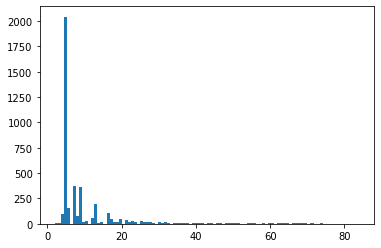

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
5   800a7ffa85c57a3a.jpg      3     25583
11  801aff45ebd0bcd0.jpg     78     26666
34  802f7fd0d42f2cca.jpg      6     32426
49  803abbf5482e3b93.jpg     87      5210
********** TEST 1

Images: 11831, Labels: 3510, Super_labels: 72
Avg img per class: 3.37, Min img per class: 3, max img per class: 16
Avg img per super_class: 164.32, Min img per super_class: 3, max img per super_class: 1593
Len split1: 70544
Len split2: 6789
(len split1) / (len split2): 10.390926498747975
Len split1: 59425
Len split2: 17908
(len split1) / (len split2): 3.3183493410766136
Len split1: 70406
Len split2: 6927
(len split1) / (len split2): 10.16399595784611
Len split1: 56711
Len 

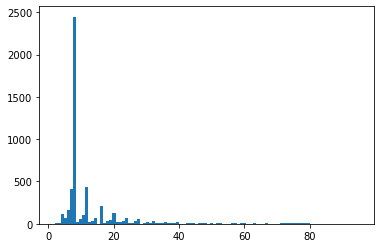

5032
second thresh =  4193
Len split1: 55176
Len split2: 11187
(len split1) / (len split2): 4.932153392330384
len(s1) / len(s2) = 4.932153392330384
Len split1: 54788
Len split2: 11575
(len split1) / (len split2): 4.733304535637149
len(s1) / len(s2) = 4.733304535637149
Len split1: 55014
Len split2: 11349
(len split1) / (len split2): 4.847475548506476
len(s1) / len(s2) = 4.847475548506476
Len split1: 55162
Len split2: 11201
(len split1) / (len split2): 4.924738862601553
len(s1) / len(s2) = 4.924738862601553
Len split1: 54980
Len split2: 11383
(len split1) / (len split2): 4.830009663533339
len(s1) / len(s2) = 4.830009663533339
Len split1: 55465
Len split2: 10898
(len split1) / (len split2): 5.0894659570563405
len(s1) / len(s2) = 5.0894659570563405
Len split1: 55546
Len split2: 10817
(len split1) / (len split2): 5.135065175187205
len(s1) / len(s2) = 5.135065175187205
Len split1: 55556
Len split2: 10807
(len split1) / (len split2): 5.140742111594337
len(s1) / len(s2) = 5.140742111594337
Len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11995, Labels: 3556, Super_labels: 74
Avg img per class: 3.37, Min img per class: 3, max img per class: 19
Avg img per super_class: 162.09, Min img per super_class: 3, max img per super_class: 1325
*****

Images: 43356, Labels: 4193, Super_labels: 75
Avg img per class: 10.34, Min img per class: 2, max img per class: 89
Avg img per super_class: 578.08, Min img per super_class: 5, max img per super_class: 3988


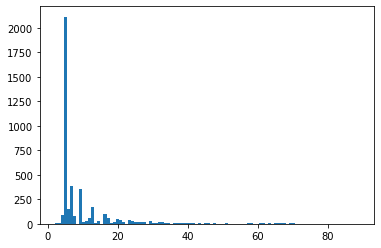

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
128  805f27a3bb4896a7.jpg      9     14532
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
13  8020ee1f3f7781da.jpg     52      2498
21  802a75e51eda5c67.jpg      9      5388
29  802beb5ad6256d35.jpg      3     26810
30  802beb95d5aac0d7.jpg     78     50595
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 11995, Labels: 3556, Super_labels: 74
Avg img per class: 3.37, Min img per class: 3, max img per class: 19
Avg img per super_class: 162.09, Min img per super_class: 3, max img per super_class: 1325
Len split1: 66469
Len split2: 10864
(len split1) / (len split2): 6.118280559646539
Len split1: 63841
Len split2: 13492
(len split1) / (len split2): 4.73176697302105
Len split1: 62733
Len split2: 14600
(len split1) / (len split2): 4.2967808219178085
Len split1: 7049

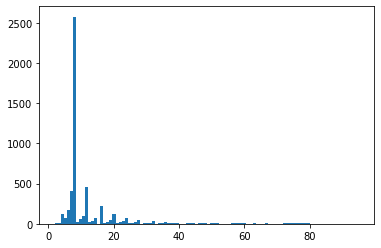

5165
second thresh =  4304
Len split1: 54977
Len split2: 11250
(len split1) / (len split2): 4.886844444444445
len(s1) / len(s2) = 4.886844444444445
Len split1: 54618
Len split2: 11609
(len split1) / (len split2): 4.704798001550521
len(s1) / len(s2) = 4.704798001550521
Len split1: 54737
Len split2: 11490
(len split1) / (len split2): 4.763881636205396
len(s1) / len(s2) = 4.763881636205396
Len split1: 54835
Len split2: 11392
(len split1) / (len split2): 4.813465589887641
len(s1) / len(s2) = 4.813465589887641
Len split1: 55345
Len split2: 10882
(len split1) / (len split2): 5.085921705568829
len(s1) / len(s2) = 5.085921705568829
Len split1: 55856
Len split2: 10371
(len split1) / (len split2): 5.385787291485874
len(s1) / len(s2) = 5.385787291485874
Len split1: 54690
Len split2: 11537
(len split1) / (len split2): 4.740400450723758
len(s1) / len(s2) = 4.740400450723758
Len split1: 55488
Len split2: 10739
(len split1) / (len split2): 5.166961542043021
len(s1) / len(s2) = 5.166961542043021
Len s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12062, Labels: 3644, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 165.23, Min img per super_class: 3, max img per super_class: 1615
*****

Images: 43161, Labels: 4304, Super_labels: 74
Avg img per class: 10.03, Min img per class: 2, max img per class: 87
Avg img per super_class: 583.26, Min img per super_class: 5, max img per super_class: 5165


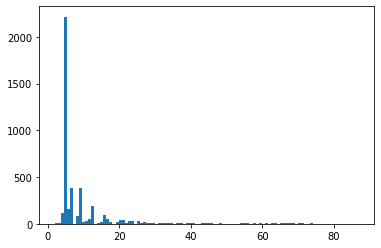

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
12  801f7ce821c7dfd0.jpg     89     27809
22  802a7af055d739e9.jpg     50     45049
34  802f7fd0d42f2cca.jpg      6     32426
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 12062, Labels: 3644, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 165.23, Min img per super_class: 3, max img per super_class: 1615
Len split1: 66434
Len split2: 10899
(len split1) / (len split2): 6.095421598311772
Len split1: 70886
Len split2: 6447
(len split1) / (len split2): 10.995191561966806
Len split1: 72611
Len split2: 4722
(len split1) / (len split2): 15.37717069038543
Len split1: 64123

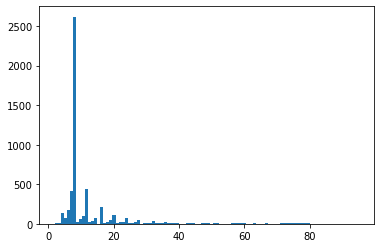

5189
second thresh =  4324
Len split1: 55254
Len split2: 11084
(len split1) / (len split2): 4.985023457235655
len(s1) / len(s2) = 4.985023457235655

Images: 55254, Labels: 4324, Super_labels: 75
Avg img per class: 12.78, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.72, Min img per super_class: 7, max img per super_class: 6530
*********

Images: 11084, Labels: 865, Super_labels: 65
Avg img per class: 12.81, Min img per class: 2, max img per class: 87
Avg img per super_class: 170.52, Min img per super_class: 7, max img per super_class: 1627

Images: 55254, Labels: 4324, Super_labels: 75
Avg img per class: 12.78, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.72, Min img per super_class: 7, max img per super_class: 6530
********** TEST 2

Images: 11084, Labels: 865, Super_labels: 65
Avg img per class: 12.81, Min img per class: 2, max img per class: 87
Avg img per super_class: 170.52, Min img per super_class: 7, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12212, Labels: 3645, Super_labels: 73
Avg img per class: 3.35, Min img per class: 3, max img per class: 18
Avg img per super_class: 167.29, Min img per super_class: 3, max img per super_class: 1506
*****

Images: 43042, Labels: 4324, Super_labels: 75
Avg img per class: 9.95, Min img per class: 2, max img per class: 91
Avg img per super_class: 573.89, Min img per super_class: 5, max img per super_class: 5024


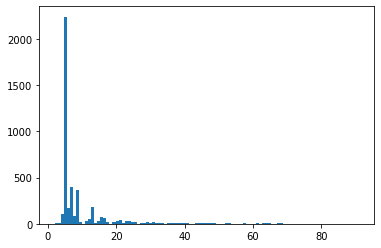

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
2   80053befc2d42fba.jpg      3       672
13  8020ee1f3f7781da.jpg     52      2498
21  802a75e51eda5c67.jpg      9      5388
24  802aef94c02bbfd5.jpg      6     62831
********** TEST 1

Images: 12212, Labels: 3645, Super_labels: 73
Avg img per class: 3.35, Min img per class: 3, max img per class: 18
Avg img per super_class: 167.29, Min img per super_class: 3, max img per super_class: 1506
Len split1: 72866
Len split2: 4467
(len split1) / (len split2): 16.312066263711664
Len split1: 61156
Len split2: 16177
(len split1) / (len split2): 3.780429004141683
Len split1: 59899
Len split2: 17434
(len split1) / (len split2): 3.435757714810141
Len split1: 6544

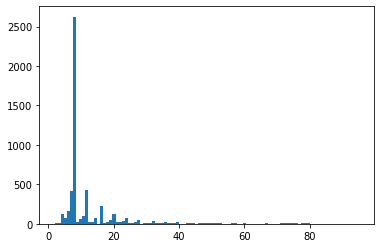

5228
second thresh =  4356
Len split1: 55477
Len split2: 10876
(len split1) / (len split2): 5.100864288341302
len(s1) / len(s2) = 5.100864288341302
Len split1: 55906
Len split2: 10447
(len split1) / (len split2): 5.351392744328515
len(s1) / len(s2) = 5.351392744328515
Len split1: 55034
Len split2: 11319
(len split1) / (len split2): 4.862090290661719
len(s1) / len(s2) = 4.862090290661719
Len split1: 54613
Len split2: 11740
(len split1) / (len split2): 4.651873935264055
len(s1) / len(s2) = 4.651873935264055
Len split1: 55155
Len split2: 11198
(len split1) / (len split2): 4.925433113055903
len(s1) / len(s2) = 4.925433113055903
Len split1: 55541
Len split2: 10812
(len split1) / (len split2): 5.136977432482427
len(s1) / len(s2) = 5.136977432482427
Len split1: 55383
Len split2: 10970
(len split1) / (len split2): 5.048587055606199
len(s1) / len(s2) = 5.048587055606199

Images: 55383, Labels: 4356, Super_labels: 74
Avg img per class: 12.71, Min img per class: 2, max img per class: 95
Avg img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12096, Labels: 3652, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 18
Avg img per super_class: 165.7, Min img per super_class: 3, max img per super_class: 1562
*****

Images: 43287, Labels: 4356, Super_labels: 74
Avg img per class: 9.94, Min img per class: 2, max img per class: 91
Avg img per super_class: 584.96, Min img per super_class: 5, max img per super_class: 5158


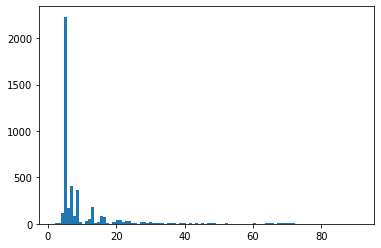

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
19  802a2be985975e5f.jpg     83     21874
39  803570c58f9ba1f7.jpg     87     37779
53  803be117a845fe9d.jpg     90     61942
55  803d7a43427ff585.jpg     71     17105
65  803eec8557fb2895.jpg      4     17623
********** TEST 1

Images: 12096, Labels: 3652, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 18
Avg img per super_class: 165.7, Min img per super_class: 3, max img per super_class: 1562
Len split1: 72250
Len split2: 5083
(len split1) / (len split2): 14.214046822742475
Len split1: 70976
Len split2: 6357
(len split1) / (len split2): 11.165014944156049
Len split1: 71570
Len split2: 5763
(len split1) / (len split2): 12.418879056047198
Len split1: 65025

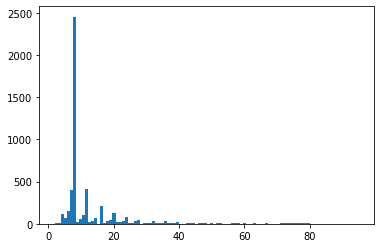

5002
second thresh =  4168
Len split1: 54984
Len split2: 11223
(len split1) / (len split2): 4.89922480620155
len(s1) / len(s2) = 4.89922480620155
Len split1: 55367
Len split2: 10840
(len split1) / (len split2): 5.107656826568266
len(s1) / len(s2) = 5.107656826568266
Len split1: 55540
Len split2: 10667
(len split1) / (len split2): 5.20671229024093
len(s1) / len(s2) = 5.20671229024093
Len split1: 55233
Len split2: 10974
(len split1) / (len split2): 5.033078184800438
len(s1) / len(s2) = 5.033078184800438

Images: 55233, Labels: 4168, Super_labels: 75
Avg img per class: 13.25, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.44, Min img per super_class: 8, max img per super_class: 6781
*********

Images: 10974, Labels: 834, Super_labels: 63
Avg img per class: 13.16, Min img per class: 2, max img per class: 81
Avg img per super_class: 174.19, Min img per super_class: 7, max img per super_class: 1376

Images: 55233, Labels: 4168, Super_labels: 75
Avg img per class: 13

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11878, Labels: 3525, Super_labels: 74
Avg img per class: 3.37, Min img per class: 3, max img per class: 16
Avg img per super_class: 160.51, Min img per super_class: 3, max img per super_class: 1583
*****

Images: 43355, Labels: 4168, Super_labels: 75
Avg img per class: 10.4, Min img per class: 2, max img per class: 87
Avg img per super_class: 578.07, Min img per super_class: 5, max img per super_class: 5198


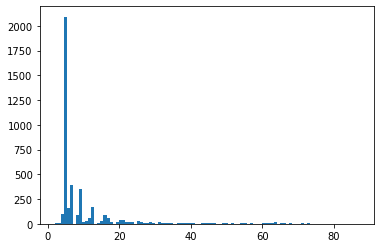

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
5   800a7ffa85c57a3a.jpg      3     25583
34  802f7fd0d42f2cca.jpg      6     32426
60  803e68a5979a9d97.jpg     89      3919
75  803f74815baa37bc.jpg     78     44936
********** TEST 1

Images: 11878, Labels: 3525, Super_labels: 74
Avg img per class: 3.37, Min img per class: 3, max img per class: 16
Avg img per super_class: 160.51, Min img per super_class: 3, max img per super_class: 1583
Len split1: 70809
Len split2: 6524
(len split1) / (len split2): 10.853617412630289
Len split1: 71501
Len split2: 5832
(len split1) / (len split2): 12.260116598079561
Len split1: 66607
Len split2: 10726
(len split1) / (len split2): 6.20986388215551
Len split1: 65079

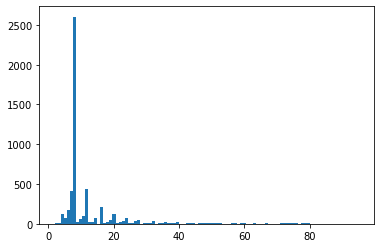

5164
second thresh =  4303
Len split1: 55609
Len split2: 10648
(len split1) / (len split2): 5.22248309541698
len(s1) / len(s2) = 5.22248309541698
Len split1: 54745
Len split2: 11512
(len split1) / (len split2): 4.75547255038221
len(s1) / len(s2) = 4.75547255038221
Len split1: 55176
Len split2: 11081
(len split1) / (len split2): 4.979333995126794
len(s1) / len(s2) = 4.979333995126794

Images: 55176, Labels: 4303, Super_labels: 74
Avg img per class: 12.82, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.62, Min img per super_class: 8, max img per super_class: 6723
*********

Images: 11081, Labels: 861, Super_labels: 63
Avg img per class: 12.87, Min img per class: 2, max img per class: 86
Avg img per super_class: 175.89, Min img per super_class: 7, max img per super_class: 1434

Images: 55176, Labels: 4303, Super_labels: 74
Avg img per class: 12.82, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.62, Min img per super_class: 8, max img per

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12209, Labels: 3663, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 164.99, Min img per super_class: 3, max img per super_class: 1600
*****

Images: 42967, Labels: 4303, Super_labels: 74
Avg img per class: 9.99, Min img per class: 2, max img per class: 92
Avg img per super_class: 580.64, Min img per super_class: 5, max img per super_class: 5123


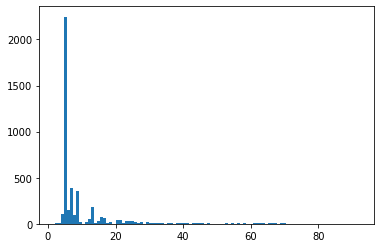

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
5   800a7ffa85c57a3a.jpg      3     25583
17  80296afd55d516ea.jpg      5     44677
38  80333fc0783e27f9.jpg     42     24915
44  803733bb5bc92c17.jpg      8     53692
********** TEST 1

Images: 12209, Labels: 3663, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 164.99, Min img per super_class: 3, max img per super_class: 1600
Len split1: 63654
Len split2: 13679
(len split1) / (len split2): 4.653410337012939
Len split1: 71123
Len split2: 6210
(len split1) / (len split2): 11.452979066022545
Len split1: 63788
Len split2: 13545
(len split1) / (len split2): 4.709339239571798
Len split1: 7002

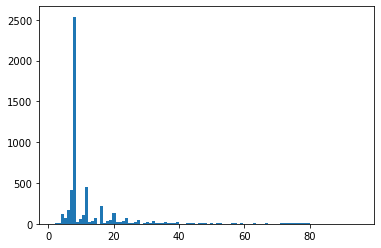

5132
second thresh =  4276
Len split1: 55250
Len split2: 11073
(len split1) / (len split2): 4.989614377314187
len(s1) / len(s2) = 4.989614377314187

Images: 55250, Labels: 4276, Super_labels: 73
Avg img per class: 12.92, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.85, Min img per super_class: 8, max img per super_class: 5212
*********

Images: 11073, Labels: 856, Super_labels: 62
Avg img per class: 12.94, Min img per class: 2, max img per class: 84
Avg img per super_class: 178.6, Min img per super_class: 8, max img per super_class: 1116

Images: 55250, Labels: 4276, Super_labels: 73
Avg img per class: 12.92, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.85, Min img per super_class: 8, max img per super_class: 5212
********** TEST 2

Images: 11073, Labels: 856, Super_labels: 62
Avg img per class: 12.94, Min img per class: 2, max img per class: 84
Avg img per super_class: 178.6, Min img per super_class: 8, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12078, Labels: 3619, Super_labels: 72
Avg img per class: 3.34, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.75, Min img per super_class: 3, max img per super_class: 1329
*****

Images: 43172, Labels: 4276, Super_labels: 73
Avg img per class: 10.1, Min img per class: 2, max img per class: 90
Avg img per super_class: 591.4, Min img per super_class: 5, max img per super_class: 3883


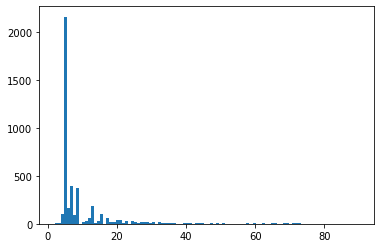

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
19  802a2be985975e5f.jpg     83     21874
35  802f7ff490819fc9.jpg     87      5697
44  803733bb5bc92c17.jpg      8     53692
62  803e97593d9ec1e1.jpg      3     28721
67  803f07609d6fd25d.jpg     80     21881
********** TEST 1

Images: 12078, Labels: 3619, Super_labels: 72
Avg img per class: 3.34, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.75, Min img per super_class: 3, max img per super_class: 1329
Len split1: 72913
Len split2: 4420
(len split1) / (len split2): 16.496153846153845
Len split1: 69356
Len split2: 7977
(len split1) / (len split2): 8.694496677949104
Len split1: 73797
Len split2: 3536
(len split1) / (len split2): 20.870192307692307
Len split1: 67376

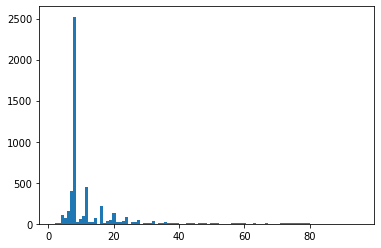

5074
second thresh =  4228
Len split1: 55223
Len split2: 11073
(len split1) / (len split2): 4.987176013727084
len(s1) / len(s2) = 4.987176013727084

Images: 55223, Labels: 4228, Super_labels: 75
Avg img per class: 13.06, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.31, Min img per super_class: 8, max img per super_class: 6492
*********

Images: 11073, Labels: 846, Super_labels: 62
Avg img per class: 13.09, Min img per class: 2, max img per class: 84
Avg img per super_class: 178.6, Min img per super_class: 8, max img per super_class: 1665

Images: 55223, Labels: 4228, Super_labels: 75
Avg img per class: 13.06, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.31, Min img per super_class: 8, max img per super_class: 6492
********** TEST 2

Images: 11073, Labels: 846, Super_labels: 62
Avg img per class: 13.09, Min img per class: 2, max img per class: 84
Avg img per super_class: 178.6, Min img per super_class: 8, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12035, Labels: 3608, Super_labels: 75
Avg img per class: 3.34, Min img per class: 3, max img per class: 16
Avg img per super_class: 160.47, Min img per super_class: 3, max img per super_class: 1536
*****

Images: 43188, Labels: 4228, Super_labels: 75
Avg img per class: 10.21, Min img per class: 2, max img per class: 87
Avg img per super_class: 575.84, Min img per super_class: 5, max img per super_class: 4956


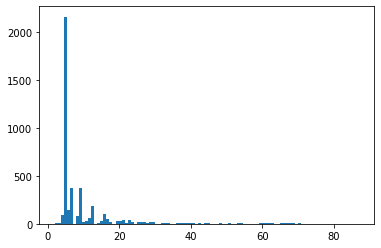

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
9   80196e6999ce63cf.jpg     90     55532
12  801f7ce821c7dfd0.jpg     89     27809
21  802a75e51eda5c67.jpg      9      5388
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 12035, Labels: 3608, Super_labels: 75
Avg img per class: 3.34, Min img per class: 3, max img per class: 16
Avg img per super_class: 160.47, Min img per super_class: 3, max img per super_class: 1536
Len split1: 60346
Len split2: 16987
(len split1) / (len split2): 3.552481309236475
Len split1: 67469
Len split2: 9864
(len split1) / (len split2): 6.839922952149229
Len split1: 57648
Len split2: 19685
(len split1) / (len split2): 2.928524257048514
Len split1: 70911

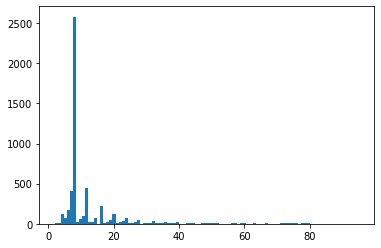

5164
second thresh =  4303
Len split1: 55291
Len split2: 11062
(len split1) / (len split2): 4.998282408244441
len(s1) / len(s2) = 4.998282408244441

Images: 55291, Labels: 4303, Super_labels: 73
Avg img per class: 12.85, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.41, Min img per super_class: 8, max img per super_class: 7055
*********

Images: 11062, Labels: 861, Super_labels: 62
Avg img per class: 12.85, Min img per class: 2, max img per class: 81
Avg img per super_class: 178.42, Min img per super_class: 7, max img per super_class: 1102

Images: 55291, Labels: 4303, Super_labels: 73
Avg img per class: 12.85, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.41, Min img per super_class: 8, max img per super_class: 7055
********** TEST 2

Images: 11062, Labels: 861, Super_labels: 62
Avg img per class: 12.85, Min img per class: 2, max img per class: 81
Avg img per super_class: 178.42, Min img per super_class: 7, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12168, Labels: 3636, Super_labels: 72
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 169.0, Min img per super_class: 3, max img per super_class: 1627
*****

Images: 43123, Labels: 4303, Super_labels: 73
Avg img per class: 10.02, Min img per class: 2, max img per class: 89
Avg img per super_class: 590.73, Min img per super_class: 5, max img per super_class: 5428


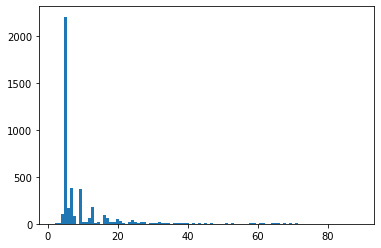

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
21  802a75e51eda5c67.jpg      9      5388
22  802a7af055d739e9.jpg     50     45049
27  802b7e9095d5fe2a.jpg      5     21723
28  802bd28ddce08fbd.jpg      6     25918
********** TEST 1

Images: 12168, Labels: 3636, Super_labels: 72
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 169.0, Min img per super_class: 3, max img per super_class: 1627
Len split1: 72938
Len split2: 4395
(len split1) / (len split2): 16.595676905574518
Len split1: 62966
Len split2: 14367
(len split1) / (len split2): 4.3826825363680655
Len split1: 62769
Len split2: 14564
(len split1) / (len split2): 4.30987366108212
Len split1: 63851
Len s

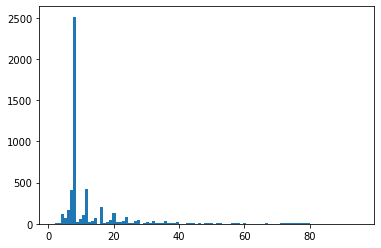

5090
second thresh =  4241
Len split1: 55570
Len split2: 10704
(len split1) / (len split2): 5.191517189835576
len(s1) / len(s2) = 5.191517189835576
Len split1: 55157
Len split2: 11117
(len split1) / (len split2): 4.961500404785464
len(s1) / len(s2) = 4.961500404785464

Images: 55157, Labels: 4241, Super_labels: 75
Avg img per class: 13.01, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.43, Min img per super_class: 6, max img per super_class: 6829
*********

Images: 11117, Labels: 849, Super_labels: 65
Avg img per class: 13.09, Min img per class: 2, max img per class: 95
Avg img per super_class: 171.03, Min img per super_class: 6, max img per super_class: 1328

Images: 55157, Labels: 4241, Super_labels: 75
Avg img per class: 13.01, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.43, Min img per super_class: 6, max img per super_class: 6829
********** TEST 2

Images: 11117, Labels: 849, Super_labels: 65
Avg img per class: 13.09, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12017, Labels: 3583, Super_labels: 74
Avg img per class: 3.35, Min img per class: 3, max img per class: 15
Avg img per super_class: 162.39, Min img per super_class: 3, max img per super_class: 1628
*****

Images: 43140, Labels: 4241, Super_labels: 75
Avg img per class: 10.17, Min img per class: 2, max img per class: 92
Avg img per super_class: 575.2, Min img per super_class: 5, max img per super_class: 5201


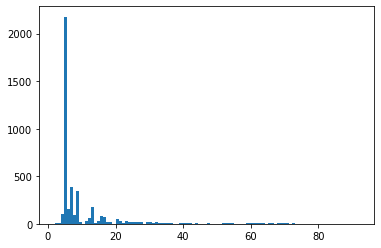

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
6   800bafacb4555b2f.jpg     82      6261
9   80196e6999ce63cf.jpg     90     55532
23  802aab95d62b7daa.jpg      6     33712
26  802b5ed622fd3587.jpg     90     35252
********** TEST 1

Images: 12017, Labels: 3583, Super_labels: 74
Avg img per class: 3.35, Min img per class: 3, max img per class: 15
Avg img per super_class: 162.39, Min img per super_class: 3, max img per super_class: 1628
Len split1: 66460
Len split2: 10873
(len split1) / (len split2): 6.1123884852386645
Len split1: 67369
Len split2: 9964
(len split1) / (len split2): 6.761240465676435
Len split1: 68903
Len split2: 8430
(len split1) / (len split2): 8.173546856465006
Len split1: 68089

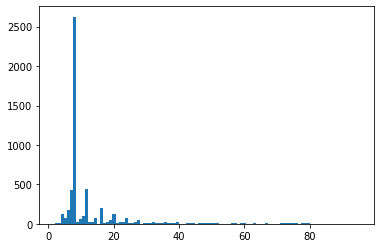

5197
second thresh =  4330
Len split1: 55227
Len split2: 11006
(len split1) / (len split2): 5.017899327639469
len(s1) / len(s2) = 5.017899327639469

Images: 55227, Labels: 4330, Super_labels: 73
Avg img per class: 12.75, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.53, Min img per super_class: 8, max img per super_class: 6717
*********

Images: 11006, Labels: 867, Super_labels: 64
Avg img per class: 12.69, Min img per class: 3, max img per class: 95
Avg img per super_class: 171.97, Min img per super_class: 6, max img per super_class: 1440

Images: 55227, Labels: 4330, Super_labels: 73
Avg img per class: 12.75, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.53, Min img per super_class: 8, max img per super_class: 6717
********** TEST 2

Images: 11006, Labels: 867, Super_labels: 64
Avg img per class: 12.69, Min img per class: 3, max img per class: 95
Avg img per super_class: 171.97, Min img per super_class: 6, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12052, Labels: 3638, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.39, Min img per super_class: 3, max img per super_class: 1556
*****

Images: 43175, Labels: 4330, Super_labels: 73
Avg img per class: 9.97, Min img per class: 2, max img per class: 92
Avg img per super_class: 591.44, Min img per super_class: 5, max img per super_class: 5161


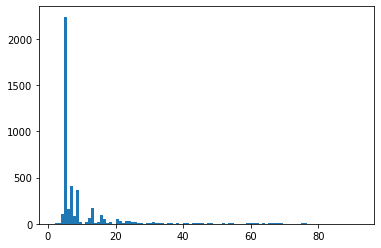

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
17  80296afd55d516ea.jpg      5     44677
21  802a75e51eda5c67.jpg      9      5388
27  802b7e9095d5fe2a.jpg      5     21723
********** TEST 1

Images: 12052, Labels: 3638, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.39, Min img per super_class: 3, max img per super_class: 1556
Len split1: 69914
Len split2: 7419
(len split1) / (len split2): 9.423642000269577
Len split1: 63679
Len split2: 13654
(len split1) / (len split2): 4.663761535081295
Len split1: 66465
Len split2: 10868
(len split1) / (len split2): 6.11566065513434
Len split1: 57263


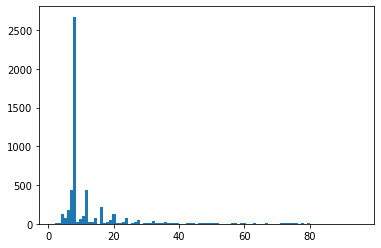

5255
second thresh =  4379
Len split1: 55717
Len split2: 10645
(len split1) / (len split2): 5.234100516674495
len(s1) / len(s2) = 5.234100516674495
Len split1: 55270
Len split2: 11092
(len split1) / (len split2): 4.982870537324198
len(s1) / len(s2) = 4.982870537324198

Images: 55270, Labels: 4379, Super_labels: 73
Avg img per class: 12.62, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.12, Min img per super_class: 8, max img per super_class: 6779
*********

Images: 11092, Labels: 876, Super_labels: 65
Avg img per class: 12.66, Min img per class: 2, max img per class: 83
Avg img per super_class: 170.65, Min img per super_class: 2, max img per super_class: 1378

Images: 55270, Labels: 4379, Super_labels: 73
Avg img per class: 12.62, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.12, Min img per super_class: 8, max img per super_class: 6779
********** TEST 2

Images: 11092, Labels: 876, Super_labels: 65
Avg img per class: 12.66, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12152, Labels: 3683, Super_labels: 72
Avg img per class: 3.3, Min img per class: 3, max img per class: 17
Avg img per super_class: 168.78, Min img per super_class: 3, max img per super_class: 1582
*****

Images: 43118, Labels: 4379, Super_labels: 73
Avg img per class: 9.85, Min img per class: 2, max img per class: 84
Avg img per super_class: 590.66, Min img per super_class: 5, max img per super_class: 5197


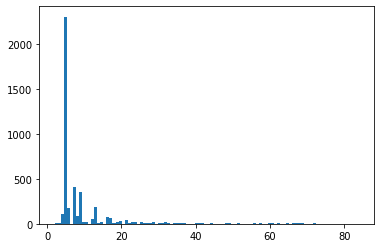

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
12  801f7ce821c7dfd0.jpg     89     27809
24  802aef94c02bbfd5.jpg      6     62831
********** TEST 1

Images: 12152, Labels: 3683, Super_labels: 72
Avg img per class: 3.3, Min img per class: 3, max img per class: 17
Avg img per super_class: 168.78, Min img per super_class: 3, max img per super_class: 1582
Len split1: 71306
Len split2: 6027
(len split1) / (len split2): 11.831093412974946
Len split1: 63097
Len split2: 14236
(len split1) / (len split2): 4.4322141050856985
Len split1: 67671
Len split2: 9662
(len split1) / (len split2): 7.003829434899607
Len split1: 69520
Len s

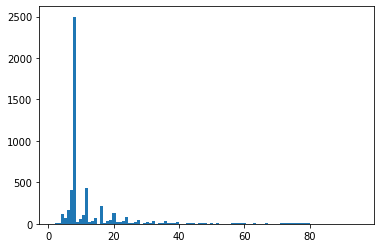

5076
second thresh =  4230
Len split1: 55021
Len split2: 11233
(len split1) / (len split2): 4.898157215347636
len(s1) / len(s2) = 4.898157215347636
Len split1: 55303
Len split2: 10951
(len split1) / (len split2): 5.050041092137704
len(s1) / len(s2) = 5.050041092137704
Len split1: 54918
Len split2: 11336
(len split1) / (len split2): 4.844565984474241
len(s1) / len(s2) = 4.844565984474241
Len split1: 55397
Len split2: 10857
(len split1) / (len split2): 5.102422400294741
len(s1) / len(s2) = 5.102422400294741
Len split1: 55486
Len split2: 10768
(len split1) / (len split2): 5.152860326894502
len(s1) / len(s2) = 5.152860326894502
Len split1: 55130
Len split2: 11124
(len split1) / (len split2): 4.955951096727795
len(s1) / len(s2) = 4.955951096727795

Images: 55130, Labels: 4230, Super_labels: 75
Avg img per class: 13.03, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.07, Min img per super_class: 8, max img per super_class: 6788
*********

Images: 11124, Labels: 846, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11969, Labels: 3562, Super_labels: 75
Avg img per class: 3.36, Min img per class: 3, max img per class: 16
Avg img per super_class: 159.59, Min img per super_class: 3, max img per super_class: 1570
*****

Images: 43161, Labels: 4230, Super_labels: 75
Avg img per class: 10.2, Min img per class: 2, max img per class: 79
Avg img per super_class: 575.48, Min img per super_class: 5, max img per super_class: 5218


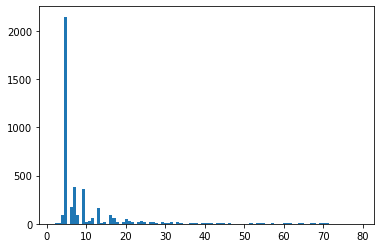

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                  image  chain  hotel_id
0  8000d59f6a3d765f.jpg     85     24607
1  8000febe81817f7f.jpg      6     25389
5  800a7ffa85c57a3a.jpg      3     25583
7  800e7dd55ffa4056.jpg      2     60181
8  8011ffce8971daa3.jpg     87     19657
********** TEST 1

Images: 11969, Labels: 3562, Super_labels: 75
Avg img per class: 3.36, Min img per class: 3, max img per class: 16
Avg img per super_class: 159.59, Min img per super_class: 3, max img per super_class: 1570
Len split1: 58670
Len split2: 18663
(len split1) / (len split2): 3.1436532175963134
Len split1: 63951
Len split2: 13382
(len split1) / (len split2): 4.778882080406516
Len split1: 64110
Len split2: 13223
(len split1) / (len split2): 4.848370263934054
Len split1: 61211
Len

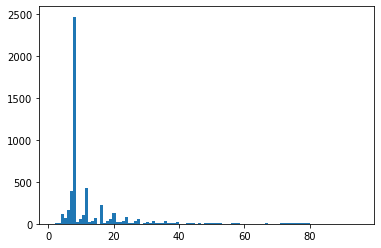

5057
second thresh =  4214
Len split1: 55036
Len split2: 11195
(len split1) / (len split2): 4.916123269316659
len(s1) / len(s2) = 4.916123269316659
Len split1: 55070
Len split2: 11161
(len split1) / (len split2): 4.934145685870441
len(s1) / len(s2) = 4.934145685870441
Len split1: 55450
Len split2: 10781
(len split1) / (len split2): 5.143307670902514
len(s1) / len(s2) = 5.143307670902514
Len split1: 55413
Len split2: 10818
(len split1) / (len split2): 5.1222961730449255
len(s1) / len(s2) = 5.1222961730449255
Len split1: 55275
Len split2: 10956
(len split1) / (len split2): 5.045180722891566
len(s1) / len(s2) = 5.045180722891566

Images: 55275, Labels: 4214, Super_labels: 74
Avg img per class: 13.12, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.96, Min img per super_class: 8, max img per super_class: 6640
*********

Images: 10956, Labels: 843, Super_labels: 62
Avg img per class: 13.0, Min img per class: 2, max img per class: 95
Avg img per super_class: 176.71, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11929, Labels: 3580, Super_labels: 73
Avg img per class: 3.33, Min img per class: 3, max img per class: 15
Avg img per super_class: 163.41, Min img per super_class: 3, max img per super_class: 1578
*****

Images: 43346, Labels: 4214, Super_labels: 74
Avg img per class: 10.29, Min img per class: 2, max img per class: 86
Avg img per super_class: 585.76, Min img per super_class: 5, max img per super_class: 5062


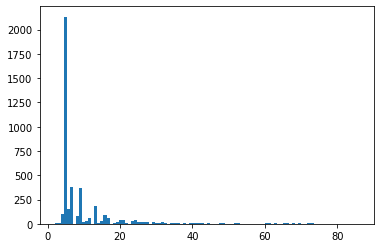

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
17  80296afd55d516ea.jpg      5     44677
29  802beb5ad6256d35.jpg      3     26810
31  802ddd0a3f70a9f5.jpg     87     18450
34  802f7fd0d42f2cca.jpg      6     32426
40  8035ee81817f7f68.jpg      3     22338
********** TEST 1

Images: 11929, Labels: 3580, Super_labels: 73
Avg img per class: 3.33, Min img per class: 3, max img per class: 15
Avg img per super_class: 163.41, Min img per super_class: 3, max img per super_class: 1578
Len split1: 67655
Len split2: 9678
(len split1) / (len split2): 6.990597230832817
Len split1: 61427
Len split2: 15906
(len split1) / (len split2): 3.861876021627059
Len split1: 71244
Len split2: 6089
(len split1) / (len split2): 11.700443422565282
Len split1: 69510

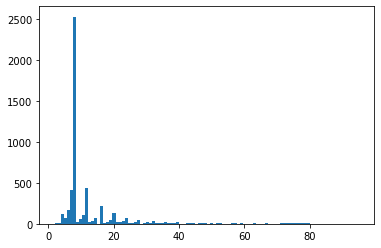

5114
second thresh =  4261
Len split1: 55025
Len split2: 11271
(len split1) / (len split2): 4.881998048088014
len(s1) / len(s2) = 4.881998048088014
Len split1: 55696
Len split2: 10600
(len split1) / (len split2): 5.25433962264151
len(s1) / len(s2) = 5.25433962264151
Len split1: 54983
Len split2: 11313
(len split1) / (len split2): 4.860160876867321
len(s1) / len(s2) = 4.860160876867321
Len split1: 55206
Len split2: 11090
(len split1) / (len split2): 4.977998196573489
len(s1) / len(s2) = 4.977998196573489

Images: 55206, Labels: 4261, Super_labels: 74
Avg img per class: 12.96, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.03, Min img per super_class: 8, max img per super_class: 5240
*********

Images: 11090, Labels: 853, Super_labels: 63
Avg img per class: 13.0, Min img per class: 3, max img per class: 78
Avg img per super_class: 176.03, Min img per super_class: 7, max img per super_class: 1088

Images: 55206, Labels: 4261, Super_labels: 74
Avg img per class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11970, Labels: 3612, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 19
Avg img per super_class: 161.76, Min img per super_class: 3, max img per super_class: 1323
*****

Images: 43236, Labels: 4261, Super_labels: 74
Avg img per class: 10.15, Min img per class: 2, max img per class: 92
Avg img per super_class: 584.27, Min img per super_class: 5, max img per super_class: 3917


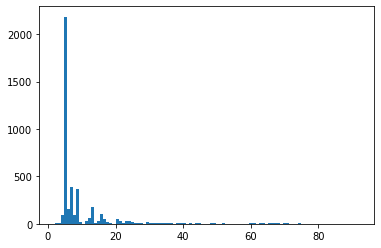

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                  image  chain  hotel_id
0  8000d59f6a3d765f.jpg     85     24607
3  8007fa0a8fe89f9d.jpg      5     63866
5  800a7ffa85c57a3a.jpg      3     25583
6  800bafacb4555b2f.jpg     82      6261
8  8011ffce8971daa3.jpg     87     19657
********** TEST 1

Images: 11970, Labels: 3612, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 19
Avg img per super_class: 161.76, Min img per super_class: 3, max img per super_class: 1323
Len split1: 71413
Len split2: 5920
(len split1) / (len split2): 12.063006756756756
Len split1: 65694
Len split2: 11639
(len split1) / (len split2): 5.644299338431137
Len split1: 67406
Len split2: 9927
(len split1) / (len split2): 6.790168228064873
Len split1: 60208
Len s

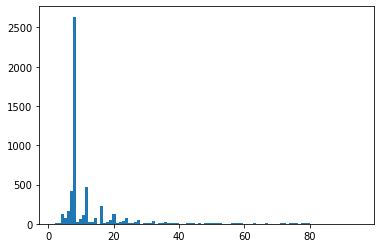

5260
second thresh =  4383
Len split1: 55455
Len split2: 10859
(len split1) / (len split2): 5.106823832765448
len(s1) / len(s2) = 5.106823832765448
Len split1: 55480
Len split2: 10834
(len split1) / (len split2): 5.120915635960864
len(s1) / len(s2) = 5.120915635960864
Len split1: 55528
Len split2: 10786
(len split1) / (len split2): 5.148155015761172
len(s1) / len(s2) = 5.148155015761172
Len split1: 55723
Len split2: 10591
(len split1) / (len split2): 5.261353979794165
len(s1) / len(s2) = 5.261353979794165
Len split1: 55420
Len split2: 10894
(len split1) / (len split2): 5.087203965485588
len(s1) / len(s2) = 5.087203965485588
Len split1: 55152
Len split2: 11162
(len split1) / (len split2): 4.941049991041032
len(s1) / len(s2) = 4.941049991041032
Len split1: 55090
Len split2: 11224
(len split1) / (len split2): 4.908232359230221
len(s1) / len(s2) = 4.908232359230221
Len split1: 55300
Len split2: 11014
(len split1) / (len split2): 5.020882513165063
len(s1) / len(s2) = 5.020882513165063

Imag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12195, Labels: 3701, Super_labels: 73
Avg img per class: 3.3, Min img per class: 3, max img per class: 17
Avg img per super_class: 167.05, Min img per super_class: 3, max img per super_class: 1613
*****

Images: 43105, Labels: 4383, Super_labels: 74
Avg img per class: 9.83, Min img per class: 2, max img per class: 92
Avg img per super_class: 582.5, Min img per super_class: 5, max img per super_class: 5397


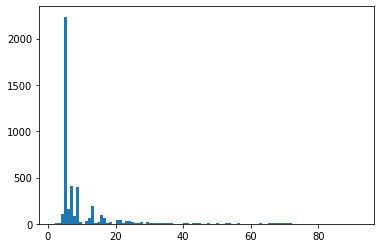

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
11  801aff45ebd0bcd0.jpg     78     26666
26  802b5ed622fd3587.jpg     90     35252
28  802bd28ddce08fbd.jpg      6     25918
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 12195, Labels: 3701, Super_labels: 73
Avg img per class: 3.3, Min img per class: 3, max img per class: 17
Avg img per super_class: 167.05, Min img per super_class: 3, max img per super_class: 1613
Len split1: 74466
Len split2: 2867
(len split1) / (len split2): 25.973491454482037
Len split1: 66901
Len split2: 10432
(len split1) / (len split2): 6.413055981595092
Len split1: 63055
Len split2: 14278
(len split1) / (len split2): 4.416234766774058
Len split1: 63493

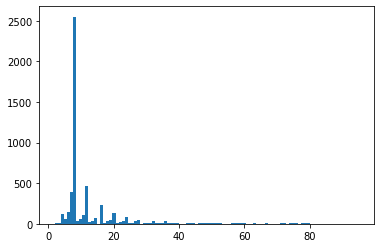

5134
second thresh =  4278
Len split1: 54673
Len split2: 11583
(len split1) / (len split2): 4.720107053440387
len(s1) / len(s2) = 4.720107053440387
Len split1: 54840
Len split2: 11416
(len split1) / (len split2): 4.803784162578837
len(s1) / len(s2) = 4.803784162578837
Len split1: 55874
Len split2: 10382
(len split1) / (len split2): 5.381814679252552
len(s1) / len(s2) = 5.381814679252552
Len split1: 54817
Len split2: 11439
(len split1) / (len split2): 4.792114695340501
len(s1) / len(s2) = 4.792114695340501
Len split1: 55420
Len split2: 10836
(len split1) / (len split2): 5.1144333702473235
len(s1) / len(s2) = 5.1144333702473235
Len split1: 55258
Len split2: 10998
(len split1) / (len split2): 5.024368066921259
len(s1) / len(s2) = 5.024368066921259

Images: 55258, Labels: 4278, Super_labels: 72
Avg img per class: 12.92, Min img per class: 2, max img per class: 87
Avg img per super_class: 767.47, Min img per super_class: 8, max img per super_class: 6639
*********

Images: 10998, Labels: 856

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12100, Labels: 3648, Super_labels: 71
Avg img per class: 3.32, Min img per class: 3, max img per class: 15
Avg img per super_class: 170.42, Min img per super_class: 3, max img per super_class: 1554
*****

Images: 43158, Labels: 4278, Super_labels: 72
Avg img per class: 10.09, Min img per class: 2, max img per class: 80
Avg img per super_class: 599.42, Min img per super_class: 5, max img per super_class: 5085


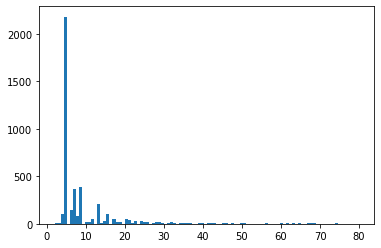

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
6   800bafacb4555b2f.jpg     82      6261
8   8011ffce8971daa3.jpg     87     19657
11  801aff45ebd0bcd0.jpg     78     26666
20  802a5f42fdf0ab95.jpg     89     43666
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 12100, Labels: 3648, Super_labels: 71
Avg img per class: 3.32, Min img per class: 3, max img per class: 15
Avg img per super_class: 170.42, Min img per super_class: 3, max img per super_class: 1554
Len split1: 61979
Len split2: 15354
(len split1) / (len split2): 4.036667969258825
Len split1: 66660
Len split2: 10673
(len split1) / (len split2): 6.24566663543521
Len split1: 67940
Len split2: 9393
(len split1) / (len split2): 7.233045885233684
Len split1: 73782


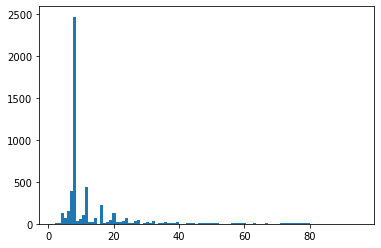

5022
second thresh =  4185
Len split1: 55820
Len split2: 10480
(len split1) / (len split2): 5.326335877862595
len(s1) / len(s2) = 5.326335877862595
Len split1: 55321
Len split2: 10979
(len split1) / (len split2): 5.038801348028054
len(s1) / len(s2) = 5.038801348028054

Images: 55321, Labels: 4185, Super_labels: 75
Avg img per class: 13.22, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.61, Min img per super_class: 7, max img per super_class: 6853
*********

Images: 10979, Labels: 837, Super_labels: 66
Avg img per class: 13.12, Min img per class: 2, max img per class: 80
Avg img per super_class: 166.35, Min img per super_class: 6, max img per super_class: 1304

Images: 55321, Labels: 4185, Super_labels: 75
Avg img per class: 13.22, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.61, Min img per super_class: 7, max img per super_class: 6853
********** TEST 2

Images: 10979, Labels: 837, Super_labels: 66
Avg img per class: 13.12, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11907, Labels: 3546, Super_labels: 74
Avg img per class: 3.36, Min img per class: 3, max img per class: 15
Avg img per super_class: 160.91, Min img per super_class: 3, max img per super_class: 1597
*****

Images: 43414, Labels: 4185, Super_labels: 75
Avg img per class: 10.37, Min img per class: 2, max img per class: 90
Avg img per super_class: 578.85, Min img per super_class: 5, max img per super_class: 5256


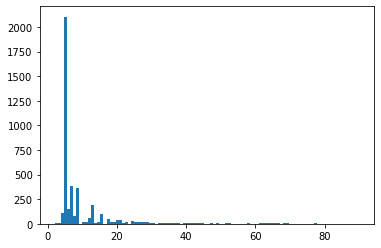

                    image  chain  hotel_id
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
13  8020ee1f3f7781da.jpg     52      2498
31  802ddd0a3f70a9f5.jpg     87     18450
32  802f65855fd85b87.jpg      5     34702
34  802f7fd0d42f2cca.jpg      6     32426
49  803abbf5482e3b93.jpg     87      5210
********** TEST 1

Images: 11907, Labels: 3546, Super_labels: 74
Avg img per class: 3.36, Min img per class: 3, max img per class: 15
Avg img per super_class: 160.91, Min img per super_class: 3, max img per super_class: 1597
Len split1: 62412
Len split2: 14921
(len split1) / (len split2): 4.182829569063736
Len split1: 60728
Len split2: 16605
(len split1) / (len split2): 3.6572116832279433
Len split1: 70485
Len split2: 6848
(len split1) / (len split2): 10.29278621495327
Len split1: 5311

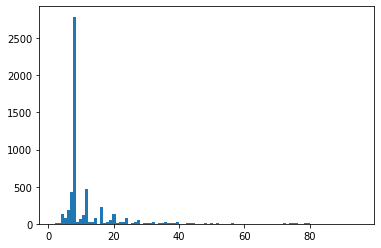

5442
second thresh =  4535
Len split1: 55191
Len split2: 11133
(len split1) / (len split2): 4.957423874966317
len(s1) / len(s2) = 4.957423874966317

Images: 55191, Labels: 4535, Super_labels: 75
Avg img per class: 12.17, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.88, Min img per super_class: 8, max img per super_class: 6494
*********

Images: 11133, Labels: 907, Super_labels: 56
Avg img per class: 12.27, Min img per class: 2, max img per class: 86
Avg img per super_class: 198.8, Min img per super_class: 6, max img per super_class: 1663

Images: 55191, Labels: 4535, Super_labels: 75
Avg img per class: 12.17, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.88, Min img per super_class: 8, max img per super_class: 6494
********** TEST 2

Images: 11133, Labels: 907, Super_labels: 56
Avg img per class: 12.27, Min img per class: 2, max img per class: 86
Avg img per super_class: 198.8, Min img per super_class: 6, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12523, Labels: 3843, Super_labels: 74
Avg img per class: 3.26, Min img per class: 3, max img per class: 17
Avg img per super_class: 169.23, Min img per super_class: 3, max img per super_class: 1521
*****

Images: 42668, Labels: 4535, Super_labels: 75
Avg img per class: 9.41, Min img per class: 2, max img per class: 86
Avg img per super_class: 568.91, Min img per super_class: 5, max img per super_class: 4973


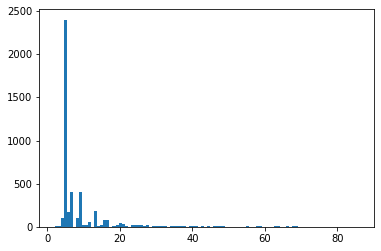

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
21  802a75e51eda5c67.jpg      9      5388
23  802aab95d62b7daa.jpg      6     33712
24  802aef94c02bbfd5.jpg      6     62831
47  8039c6e66bb6e329.jpg      6      9828
52  803b5ed0d6037b3e.jpg      5     16791
********** TEST 1

Images: 12523, Labels: 3843, Super_labels: 74
Avg img per class: 3.26, Min img per class: 3, max img per class: 17
Avg img per super_class: 169.23, Min img per super_class: 3, max img per super_class: 1521
Len split1: 72731
Len split2: 4602
(len split1) / (len split2): 15.804215558452846
Len split1: 65487
Len split2: 11846
(len split1) / (len split2): 5.528195171365862
Len split1: 71579
Len split2: 5754
(len split1) / (len split2): 12.439867917970108
Len split1: 5776

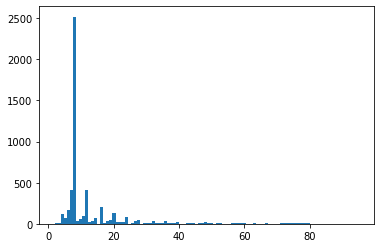

5059
second thresh =  4215
Len split1: 55220
Len split2: 11038
(len split1) / (len split2): 5.0027178836745785
len(s1) / len(s2) = 5.0027178836745785

Images: 55220, Labels: 4215, Super_labels: 73
Avg img per class: 13.1, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.44, Min img per super_class: 8, max img per super_class: 6790
*********

Images: 11038, Labels: 844, Super_labels: 66
Avg img per class: 13.08, Min img per class: 3, max img per class: 82
Avg img per super_class: 167.24, Min img per super_class: 4, max img per super_class: 1367

Images: 55220, Labels: 4215, Super_labels: 73
Avg img per class: 13.1, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.44, Min img per super_class: 8, max img per super_class: 6790
********** TEST 2

Images: 11038, Labels: 844, Super_labels: 66
Avg img per class: 13.08, Min img per class: 3, max img per class: 82
Avg img per super_class: 167.24, Min img per super_class: 4, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11920, Labels: 3564, Super_labels: 72
Avg img per class: 3.34, Min img per class: 3, max img per class: 15
Avg img per super_class: 165.56, Min img per super_class: 3, max img per super_class: 1586
*****

Images: 43300, Labels: 4215, Super_labels: 73
Avg img per class: 10.27, Min img per class: 2, max img per class: 91
Avg img per super_class: 593.15, Min img per super_class: 5, max img per super_class: 5204


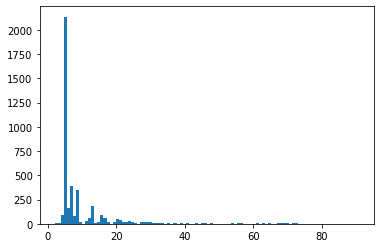

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
6   800bafacb4555b2f.jpg     82      6261
26  802b5ed622fd3587.jpg     90     35252
28  802bd28ddce08fbd.jpg      6     25918
47  8039c6e66bb6e329.jpg      6      9828
********** TEST 1

Images: 11920, Labels: 3564, Super_labels: 72
Avg img per class: 3.34, Min img per class: 3, max img per class: 15
Avg img per super_class: 165.56, Min img per super_class: 3, max img per super_class: 1586
Len split1: 67949
Len split2: 9384
(len split1) / (len split2): 7.240942028985507
Len split1: 65564
Len split2: 11769
(len split1) / (len split2): 5.570906619084035
Len split1: 62704
Len split2: 14629
(len split1) / (len split2): 4.286280675370839
Len split1: 70033

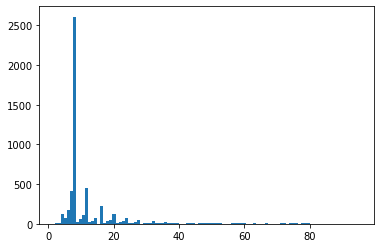

5222
second thresh =  4351
Len split1: 55230
Len split2: 11015
(len split1) / (len split2): 5.014071720381298
len(s1) / len(s2) = 5.014071720381298

Images: 55230, Labels: 4351, Super_labels: 74
Avg img per class: 12.69, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.35, Min img per super_class: 8, max img per super_class: 6838
*********

Images: 11015, Labels: 871, Super_labels: 64
Avg img per class: 12.65, Min img per class: 3, max img per class: 95
Avg img per super_class: 172.11, Min img per super_class: 5, max img per super_class: 1319

Images: 55230, Labels: 4351, Super_labels: 74
Avg img per class: 12.69, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.35, Min img per super_class: 8, max img per super_class: 6838
********** TEST 2

Images: 11015, Labels: 871, Super_labels: 64
Avg img per class: 12.65, Min img per class: 3, max img per class: 95
Avg img per super_class: 172.11, Min img per super_class: 5, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12209, Labels: 3682, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 17
Avg img per super_class: 167.25, Min img per super_class: 3, max img per super_class: 1613
*****

Images: 43021, Labels: 4351, Super_labels: 74
Avg img per class: 9.89, Min img per class: 2, max img per class: 79
Avg img per super_class: 581.36, Min img per super_class: 5, max img per super_class: 5225


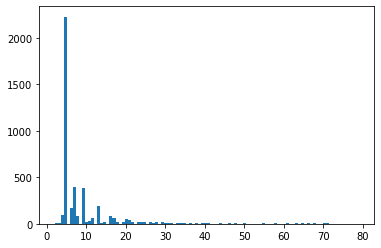

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
12  801f7ce821c7dfd0.jpg     89     27809
17  80296afd55d516ea.jpg      5     44677
26  802b5ed622fd3587.jpg     90     35252
********** TEST 1

Images: 12209, Labels: 3682, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 17
Avg img per super_class: 167.25, Min img per super_class: 3, max img per super_class: 1613
Len split1: 69923
Len split2: 7410
(len split1) / (len split2): 9.43630229419703
Len split1: 62629
Len split2: 14704
(len split1) / (len split2): 4.259317192600653
Len split1: 67241
Len split2: 10092
(len split1) / (len split2): 6.6628022195798655
Len split1: 73473

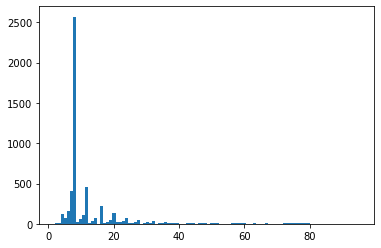

5148
second thresh =  4290
Len split1: 55185
Len split2: 11104
(len split1) / (len split2): 4.969830691642652
len(s1) / len(s2) = 4.969830691642652

Images: 55185, Labels: 4290, Super_labels: 74
Avg img per class: 12.86, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.74, Min img per super_class: 8, max img per super_class: 6718
*********

Images: 11104, Labels: 858, Super_labels: 60
Avg img per class: 12.94, Min img per class: 2, max img per class: 92
Avg img per super_class: 185.07, Min img per super_class: 7, max img per super_class: 1439

Images: 55185, Labels: 4290, Super_labels: 74
Avg img per class: 12.86, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.74, Min img per super_class: 8, max img per super_class: 6718
********** TEST 2

Images: 11104, Labels: 858, Super_labels: 60
Avg img per class: 12.94, Min img per class: 2, max img per class: 92
Avg img per super_class: 185.07, Min img per super_class: 7, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12156, Labels: 3642, Super_labels: 73
Avg img per class: 3.34, Min img per class: 3, max img per class: 19
Avg img per super_class: 166.52, Min img per super_class: 3, max img per super_class: 1530
*****

Images: 43029, Labels: 4290, Super_labels: 74
Avg img per class: 10.03, Min img per class: 2, max img per class: 80
Avg img per super_class: 581.47, Min img per super_class: 5, max img per super_class: 5188


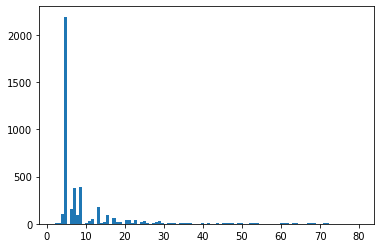

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
20  802a5f42fdf0ab95.jpg     89     43666
21  802a75e51eda5c67.jpg      9      5388
24  802aef94c02bbfd5.jpg      6     62831
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 12156, Labels: 3642, Super_labels: 73
Avg img per class: 3.34, Min img per class: 3, max img per class: 19
Avg img per super_class: 166.52, Min img per super_class: 3, max img per super_class: 1530
Len split1: 61347
Len split2: 15986
(len split1) / (len split2): 3.8375453521831604
Len split1: 58855
Len split2: 18478
(len split1) / (len split2): 3.1851390843164844
Len split1: 65145
Len split2: 12188
(len split1) / (len split2): 5.345011486708238
Len split1: 56

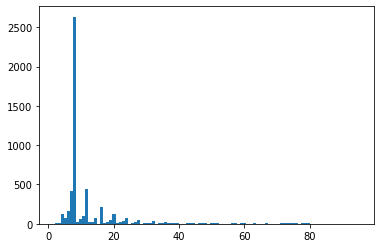

5207
second thresh =  4339
Len split1: 55019
Len split2: 11196
(len split1) / (len split2): 4.914165773490533
len(s1) / len(s2) = 4.914165773490533
Len split1: 55031
Len split2: 11184
(len split1) / (len split2): 4.920511444921316
len(s1) / len(s2) = 4.920511444921316
Len split1: 54922
Len split2: 11293
(len split1) / (len split2): 4.863366687328433
len(s1) / len(s2) = 4.863366687328433
Len split1: 55072
Len split2: 11143
(len split1) / (len split2): 4.942295611594723
len(s1) / len(s2) = 4.942295611594723
Len split1: 54904
Len split2: 11311
(len split1) / (len split2): 4.854035894262223
len(s1) / len(s2) = 4.854035894262223
Len split1: 55488
Len split2: 10727
(len split1) / (len split2): 5.1727416798732175
len(s1) / len(s2) = 5.1727416798732175
Len split1: 54877
Len split2: 11338
(len split1) / (len split2): 4.8400952548950436
len(s1) / len(s2) = 4.8400952548950436
Len split1: 55424
Len split2: 10791
(len split1) / (len split2): 5.136131961820035
len(s1) / len(s2) = 5.136131961820035
L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12193, Labels: 3662, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 18
Avg img per super_class: 164.77, Min img per super_class: 3, max img per super_class: 1585
*****

Images: 42919, Labels: 4339, Super_labels: 75
Avg img per class: 9.89, Min img per class: 2, max img per class: 81
Avg img per super_class: 572.25, Min img per super_class: 5, max img per super_class: 5154


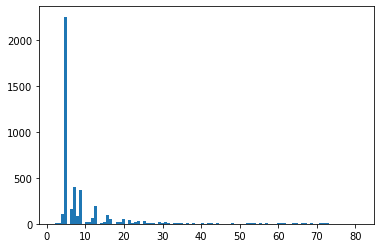

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
12  801f7ce821c7dfd0.jpg     89     27809
21  802a75e51eda5c67.jpg      9      5388
28  802bd28ddce08fbd.jpg      6     25918
34  802f7fd0d42f2cca.jpg      6     32426
60  803e68a5979a9d97.jpg     89      3919
********** TEST 1

Images: 12193, Labels: 3662, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 18
Avg img per super_class: 164.77, Min img per super_class: 3, max img per super_class: 1585
Len split1: 61664
Len split2: 15669
(len split1) / (len split2): 3.9354138745293255
Len split1: 71138
Len split2: 6195
(len split1) / (len split2): 11.483131557707829
Len split1: 71600
Len split2: 5733
(len split1) / (len split2): 12.489098203383918
Len split1: 621

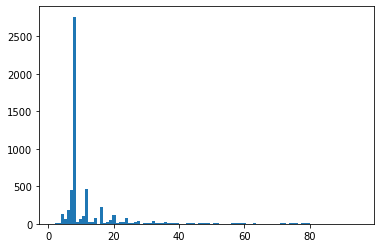

5387
second thresh =  4489
Len split1: 55484
Len split2: 10734
(len split1) / (len split2): 5.168995714551891
len(s1) / len(s2) = 5.168995714551891
Len split1: 55696
Len split2: 10522
(len split1) / (len split2): 5.293290249002091
len(s1) / len(s2) = 5.293290249002091
Len split1: 55358
Len split2: 10860
(len split1) / (len split2): 5.097421731123388
len(s1) / len(s2) = 5.097421731123388
Len split1: 54834
Len split2: 11384
(len split1) / (len split2): 4.816760365425158
len(s1) / len(s2) = 4.816760365425158
Len split1: 54974
Len split2: 11244
(len split1) / (len split2): 4.889185343294201
len(s1) / len(s2) = 4.889185343294201
Len split1: 55128
Len split2: 11090
(len split1) / (len split2): 4.970964833183047
len(s1) / len(s2) = 4.970964833183047

Images: 55128, Labels: 4489, Super_labels: 72
Avg img per class: 12.28, Min img per class: 2, max img per class: 95
Avg img per super_class: 765.67, Min img per super_class: 8, max img per super_class: 6806
*********

Images: 11090, Labels: 898, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12446, Labels: 3788, Super_labels: 71
Avg img per class: 3.29, Min img per class: 3, max img per class: 16
Avg img per super_class: 175.3, Min img per super_class: 3, max img per super_class: 1587
*****

Images: 42682, Labels: 4489, Super_labels: 72
Avg img per class: 9.51, Min img per class: 2, max img per class: 88
Avg img per super_class: 592.81, Min img per super_class: 5, max img per super_class: 5219


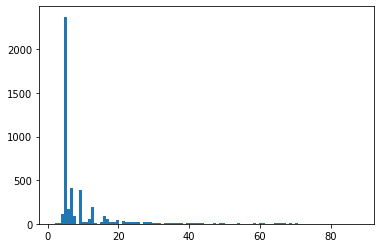

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
9   80196e6999ce63cf.jpg     90     55532
13  8020ee1f3f7781da.jpg     52      2498
28  802bd28ddce08fbd.jpg      6     25918
35  802f7ff490819fc9.jpg     87      5697
********** TEST 1

Images: 12446, Labels: 3788, Super_labels: 71
Avg img per class: 3.29, Min img per class: 3, max img per class: 16
Avg img per super_class: 175.3, Min img per super_class: 3, max img per super_class: 1587
Len split1: 68008
Len split2: 9325
(len split1) / (len split2): 7.293083109919571
Len split1: 64207
Len split2: 13126
(len split1) / (len split2): 4.891589212250495
Len split1: 69778
Len split2: 7555
(len split1) / (len split2): 9.236002647253475
Len split1: 72341
L

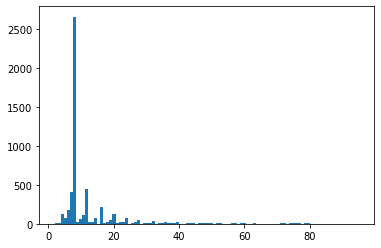

5245
second thresh =  4370
Len split1: 55568
Len split2: 10658
(len split1) / (len split2): 5.213736160630512
len(s1) / len(s2) = 5.213736160630512
Len split1: 55009
Len split2: 11217
(len split1) / (len split2): 4.904074173130071
len(s1) / len(s2) = 4.904074173130071
Len split1: 55130
Len split2: 11096
(len split1) / (len split2): 4.968457101658255
len(s1) / len(s2) = 4.968457101658255

Images: 55130, Labels: 4370, Super_labels: 74
Avg img per class: 12.62, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.0, Min img per super_class: 7, max img per super_class: 6784
*********

Images: 11096, Labels: 875, Super_labels: 69
Avg img per class: 12.68, Min img per class: 2, max img per class: 86
Avg img per super_class: 160.81, Min img per super_class: 4, max img per super_class: 1373

Images: 55130, Labels: 4370, Super_labels: 74
Avg img per class: 12.62, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.0, Min img per super_class: 7, max img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12286, Labels: 3711, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 170.64, Min img per super_class: 3, max img per super_class: 1587
*****

Images: 42844, Labels: 4370, Super_labels: 74
Avg img per class: 9.8, Min img per class: 2, max img per class: 83
Avg img per super_class: 578.97, Min img per super_class: 5, max img per super_class: 5197


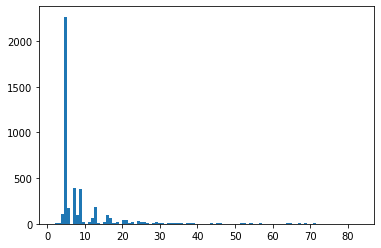

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
1   8000febe81817f7f.jpg      6     25389
12  801f7ce821c7dfd0.jpg     89     27809
20  802a5f42fdf0ab95.jpg     89     43666
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 12286, Labels: 3711, Super_labels: 72
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 170.64, Min img per super_class: 3, max img per super_class: 1587
Len split1: 70659
Len split2: 6674
(len split1) / (len split2): 10.587204075516931
Len split1: 60839
Len split2: 16494
(len split1) / (len split2): 3.6885534133624347
Len split1: 58699
Len split2: 18634
(len split1) / (len split2): 3.150101964151551
Len split1: 668

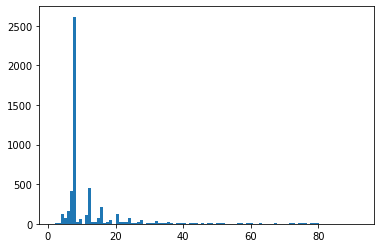

5200
second thresh =  4333
Len split1: 55538
Len split2: 10696
(len split1) / (len split2): 5.192408376963351
len(s1) / len(s2) = 5.192408376963351
Len split1: 55584
Len split2: 10650
(len split1) / (len split2): 5.219154929577464
len(s1) / len(s2) = 5.219154929577464
Len split1: 55615
Len split2: 10619
(len split1) / (len split2): 5.23731048121292
len(s1) / len(s2) = 5.23731048121292
Len split1: 55449
Len split2: 10785
(len split1) / (len split2): 5.141307371349096
len(s1) / len(s2) = 5.141307371349096
Len split1: 54997
Len split2: 11237
(len split1) / (len split2): 4.894277832161609
len(s1) / len(s2) = 4.894277832161609
Len split1: 55096
Len split2: 11138
(len split1) / (len split2): 4.946669060872688
len(s1) / len(s2) = 4.946669060872688
Len split1: 55285
Len split2: 10949
(len split1) / (len split2): 5.049319572563705
len(s1) / len(s2) = 5.049319572563705

Images: 55285, Labels: 4333, Super_labels: 74
Avg img per class: 12.76, Min img per class: 2, max img per class: 87
Avg img per

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12239, Labels: 3673, Super_labels: 73
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.66, Min img per super_class: 3, max img per super_class: 1555
*****

Images: 43046, Labels: 4333, Super_labels: 74
Avg img per class: 9.93, Min img per class: 2, max img per class: 80
Avg img per super_class: 581.7, Min img per super_class: 5, max img per super_class: 5011


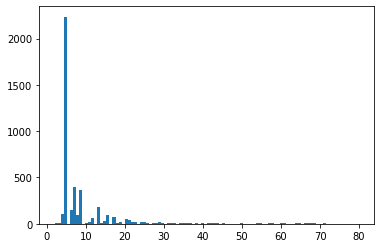

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
19  802a2be985975e5f.jpg     83     21874
21  802a75e51eda5c67.jpg      9      5388
29  802beb5ad6256d35.jpg      3     26810
30  802beb95d5aac0d7.jpg     78     50595
********** TEST 1

Images: 12239, Labels: 3673, Super_labels: 73
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.66, Min img per super_class: 3, max img per super_class: 1555
Len split1: 67954
Len split2: 9379
(len split1) / (len split2): 7.245335323595266
Len split1: 66562
Len split2: 10771
(len split1) / (len split2): 6.179741899545075
Len split1: 69655
Len split2: 7678
(len split1) / (len split2): 9.072023964574107
Len split1: 61735


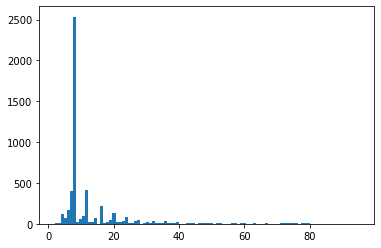

5098
second thresh =  4248
Len split1: 54723
Len split2: 11571
(len split1) / (len split2): 4.7293233082706765
len(s1) / len(s2) = 4.7293233082706765
Len split1: 55466
Len split2: 10828
(len split1) / (len split2): 5.122460288141855
len(s1) / len(s2) = 5.122460288141855
Len split1: 55511
Len split2: 10783
(len split1) / (len split2): 5.1480107576741165
len(s1) / len(s2) = 5.1480107576741165
Len split1: 55380
Len split2: 10914
(len split1) / (len split2): 5.074216602528862
len(s1) / len(s2) = 5.074216602528862
Len split1: 54813
Len split2: 11481
(len split1) / (len split2): 4.7742356937549
len(s1) / len(s2) = 4.7742356937549
Len split1: 54935
Len split2: 11359
(len split1) / (len split2): 4.836253191302052
len(s1) / len(s2) = 4.836253191302052
Len split1: 55536
Len split2: 10758
(len split1) / (len split2): 5.162297824874512
len(s1) / len(s2) = 5.162297824874512
Len split1: 55080
Len split2: 11214
(len split1) / (len split2): 4.911717495987159
len(s1) / len(s2) = 4.911717495987159
Len s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12057, Labels: 3597, Super_labels: 73
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 165.16, Min img per super_class: 3, max img per super_class: 1640
*****

Images: 43151, Labels: 4248, Super_labels: 74
Avg img per class: 10.16, Min img per class: 2, max img per class: 87
Avg img per super_class: 583.12, Min img per super_class: 5, max img per super_class: 5408


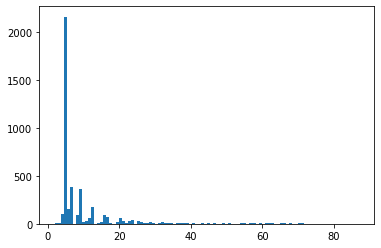

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
6   800bafacb4555b2f.jpg     82      6261
19  802a2be985975e5f.jpg     83     21874
20  802a5f42fdf0ab95.jpg     89     43666
31  802ddd0a3f70a9f5.jpg     87     18450
44  803733bb5bc92c17.jpg      8     53692
********** TEST 1

Images: 12057, Labels: 3597, Super_labels: 73
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 165.16, Min img per super_class: 3, max img per super_class: 1640
Len split1: 70219
Len split2: 7114
(len split1) / (len split2): 9.870536969356198
Len split1: 70919
Len split2: 6414
(len split1) / (len split2): 11.056906766448394
Len split1: 65681
Len split2: 11652
(len split1) / (len split2): 5.63688637143838
Len split1: 66139
Len sp

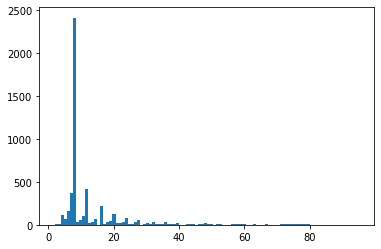

4958
second thresh =  4131
Len split1: 55658
Len split2: 10583
(len split1) / (len split2): 5.259189265803648
len(s1) / len(s2) = 5.259189265803648
Len split1: 55097
Len split2: 11144
(len split1) / (len split2): 4.944095477386934
len(s1) / len(s2) = 4.944095477386934
Len split1: 55826
Len split2: 10415
(len split1) / (len split2): 5.360153624579933
len(s1) / len(s2) = 5.360153624579933
Len split1: 55555
Len split2: 10686
(len split1) / (len split2): 5.198858319296275
len(s1) / len(s2) = 5.198858319296275
Len split1: 55641
Len split2: 10600
(len split1) / (len split2): 5.249150943396226
len(s1) / len(s2) = 5.249150943396226
Len split1: 55033
Len split2: 11208
(len split1) / (len split2): 4.910153461812991
len(s1) / len(s2) = 4.910153461812991
Len split1: 54848
Len split2: 11393
(len split1) / (len split2): 4.814184148161152
len(s1) / len(s2) = 4.814184148161152
Len split1: 54736
Len split2: 11505
(len split1) / (len split2): 4.757583659278574
len(s1) / len(s2) = 4.757583659278574
Len s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11776, Labels: 3512, Super_labels: 72
Avg img per class: 3.35, Min img per class: 3, max img per class: 15
Avg img per super_class: 163.56, Min img per super_class: 3, max img per super_class: 1543
*****

Images: 43512, Labels: 4131, Super_labels: 74
Avg img per class: 10.53, Min img per class: 2, max img per class: 91
Avg img per super_class: 588.0, Min img per super_class: 5, max img per super_class: 5193


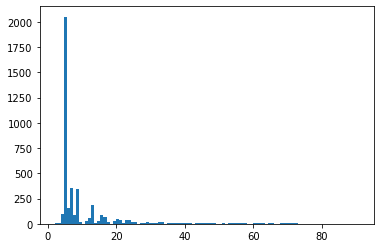

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
21  802a75e51eda5c67.jpg      9      5388
29  802beb5ad6256d35.jpg      3     26810
31  802ddd0a3f70a9f5.jpg     87     18450
38  80333fc0783e27f9.jpg     42     24915
********** TEST 1

Images: 11776, Labels: 3512, Super_labels: 72
Avg img per class: 3.35, Min img per class: 3, max img per class: 15
Avg img per super_class: 163.56, Min img per super_class: 3, max img per super_class: 1543
Len split1: 70524
Len split2: 6809
(len split1) / (len split2): 10.357468056983404
Len split1: 64127
Len split2: 13206
(len split1) / (len split2): 4.855898833863395
Len split1: 70937
Len split2: 6396
(len split1) / (len split2): 11.090838023764853
Len split1: 6925

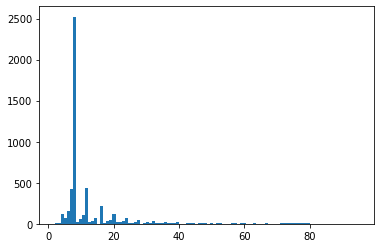

5110
second thresh =  4258
Len split1: 55179
Len split2: 11174
(len split1) / (len split2): 4.938160014318955
len(s1) / len(s2) = 4.938160014318955
Len split1: 55193
Len split2: 11160
(len split1) / (len split2): 4.945609318996416
len(s1) / len(s2) = 4.945609318996416
Len split1: 55252
Len split2: 11101
(len split1) / (len split2): 4.977209260426989
len(s1) / len(s2) = 4.977209260426989

Images: 55252, Labels: 4258, Super_labels: 75
Avg img per class: 12.98, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.69, Min img per super_class: 8, max img per super_class: 5247
*********

Images: 11101, Labels: 852, Super_labels: 62
Avg img per class: 13.03, Min img per class: 2, max img per class: 82
Avg img per super_class: 179.05, Min img per super_class: 6, max img per super_class: 1081

Images: 55252, Labels: 4258, Super_labels: 75
Avg img per class: 12.98, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.69, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11976, Labels: 3600, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 161.84, Min img per super_class: 3, max img per super_class: 1322
*****

Images: 43276, Labels: 4258, Super_labels: 75
Avg img per class: 10.16, Min img per class: 2, max img per class: 89
Avg img per super_class: 577.01, Min img per super_class: 5, max img per super_class: 3925


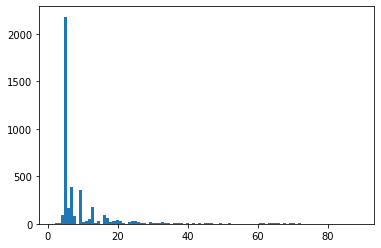

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
12  801f7ce821c7dfd0.jpg     89     27809
26  802b5ed622fd3587.jpg     90     35252
32  802f65855fd85b87.jpg      5     34702
35  802f7ff490819fc9.jpg     87      5697
********** TEST 1

Images: 11976, Labels: 3600, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 161.84, Min img per super_class: 3, max img per super_class: 1322
Len split1: 73570
Len split2: 3763
(len split1) / (len split2): 19.550890247143236
Len split1: 57685
Len split2: 19648
(len split1) / (len split2): 2.935922231270358
Len split1: 68280
Len split2: 9053
(len split1) / (len split2): 7.542251187451673
Len split1: 61185

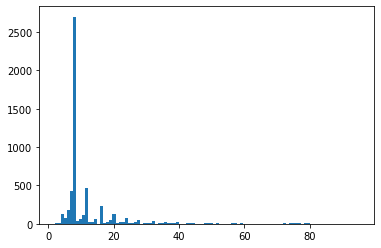

5324
second thresh =  4436
Len split1: 55692
Len split2: 10562
(len split1) / (len split2): 5.272864987691725
len(s1) / len(s2) = 5.272864987691725
Len split1: 55103
Len split2: 11151
(len split1) / (len split2): 4.941529907631603
len(s1) / len(s2) = 4.941529907631603
Len split1: 55683
Len split2: 10571
(len split1) / (len split2): 5.267524359095639
len(s1) / len(s2) = 5.267524359095639
Len split1: 55430
Len split2: 10824
(len split1) / (len split2): 5.121027346637103
len(s1) / len(s2) = 5.121027346637103
Len split1: 55128
Len split2: 11126
(len split1) / (len split2): 4.954880460183355
len(s1) / len(s2) = 4.954880460183355

Images: 55128, Labels: 4436, Super_labels: 74
Avg img per class: 12.43, Min img per class: 2, max img per class: 95
Avg img per super_class: 744.97, Min img per super_class: 8, max img per super_class: 7053
*********

Images: 11126, Labels: 888, Super_labels: 62
Avg img per class: 12.53, Min img per class: 2, max img per class: 87
Avg img per super_class: 179.45, M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12312, Labels: 3755, Super_labels: 72
Avg img per class: 3.28, Min img per class: 3, max img per class: 17
Avg img per super_class: 171.0, Min img per super_class: 3, max img per super_class: 1647
*****

Images: 42816, Labels: 4436, Super_labels: 74
Avg img per class: 9.65, Min img per class: 2, max img per class: 90
Avg img per super_class: 578.59, Min img per super_class: 5, max img per super_class: 5406


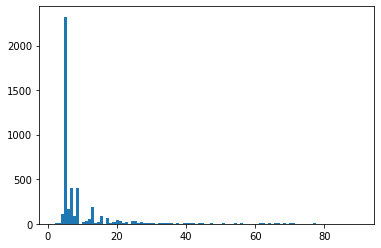

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
19  802a2be985975e5f.jpg     83     21874
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 12312, Labels: 3755, Super_labels: 72
Avg img per class: 3.28, Min img per class: 3, max img per class: 17
Avg img per super_class: 171.0, Min img per super_class: 3, max img per super_class: 1647
Len split1: 73263
Len split2: 4070
(len split1) / (len split2): 18.0007371007371
Len split1: 69477
Len split2: 7856
(len split1) / (len split2): 8.84381364562118
Len split1: 72182
Len split2: 5151
(len split1) / (len split2): 14.013201320132014
Len split1: 64375
Len

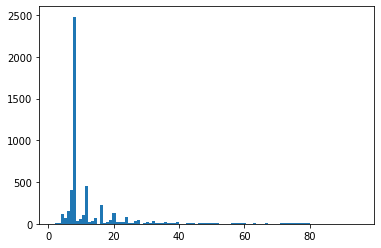

5065
second thresh =  4220
Len split1: 54842
Len split2: 11496
(len split1) / (len split2): 4.770528879610299
len(s1) / len(s2) = 4.770528879610299
Len split1: 55199
Len split2: 11139
(len split1) / (len split2): 4.955471765867673
len(s1) / len(s2) = 4.955471765867673

Images: 55199, Labels: 4220, Super_labels: 75
Avg img per class: 13.08, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.99, Min img per super_class: 7, max img per super_class: 6774
*********

Images: 11139, Labels: 845, Super_labels: 60
Avg img per class: 13.18, Min img per class: 2, max img per class: 87
Avg img per super_class: 185.65, Min img per super_class: 3, max img per super_class: 1383

Images: 55199, Labels: 4220, Super_labels: 75
Avg img per class: 13.08, Min img per class: 2, max img per class: 95
Avg img per super_class: 735.99, Min img per super_class: 7, max img per super_class: 6774
********** TEST 2

Images: 11139, Labels: 845, Super_labels: 60
Avg img per class: 13.18, Min img 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12020, Labels: 3588, Super_labels: 74
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 162.43, Min img per super_class: 3, max img per super_class: 1572
*****

Images: 43179, Labels: 4220, Super_labels: 75
Avg img per class: 10.23, Min img per class: 2, max img per class: 92
Avg img per super_class: 575.72, Min img per super_class: 5, max img per super_class: 5202


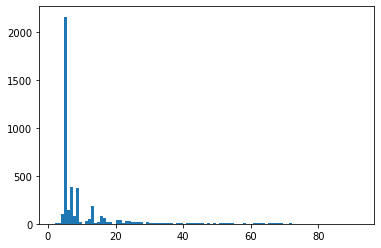

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
5   800a7ffa85c57a3a.jpg      3     25583
26  802b5ed622fd3587.jpg     90     35252
28  802bd28ddce08fbd.jpg      6     25918
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 12020, Labels: 3588, Super_labels: 74
Avg img per class: 3.35, Min img per class: 3, max img per class: 16
Avg img per super_class: 162.43, Min img per super_class: 3, max img per super_class: 1572
Len split1: 54778
Len split2: 22555
(len split1) / (len split2): 2.428641099534471
Len split1: 63378
Len split2: 13955
(len split1) / (len split2): 4.541597993550699
Len split1: 59075
Len split2: 18258
(len split1) / (len split2): 3.235567970204842
Len split1: 6358

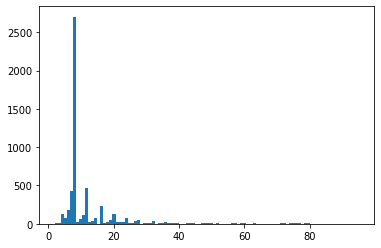

5341
second thresh =  4450
Len split1: 55157
Len split2: 11111
(len split1) / (len split2): 4.964179641796418
len(s1) / len(s2) = 4.964179641796418

Images: 55157, Labels: 4450, Super_labels: 74
Avg img per class: 12.39, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.36, Min img per super_class: 6, max img per super_class: 6792
*********

Images: 11111, Labels: 891, Super_labels: 65
Avg img per class: 12.47, Min img per class: 2, max img per class: 86
Avg img per super_class: 170.94, Min img per super_class: 7, max img per super_class: 1365

Images: 55157, Labels: 4450, Super_labels: 74
Avg img per class: 12.39, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.36, Min img per super_class: 6, max img per super_class: 6792
********** TEST 2

Images: 11111, Labels: 891, Super_labels: 65
Avg img per class: 12.47, Min img per class: 2, max img per class: 86
Avg img per super_class: 170.94, Min img per super_class: 7, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12344, Labels: 3752, Super_labels: 72
Avg img per class: 3.29, Min img per class: 3, max img per class: 17
Avg img per super_class: 171.44, Min img per super_class: 3, max img per super_class: 1592
*****

Images: 42813, Labels: 4450, Super_labels: 74
Avg img per class: 9.62, Min img per class: 2, max img per class: 87
Avg img per super_class: 578.55, Min img per super_class: 5, max img per super_class: 5200


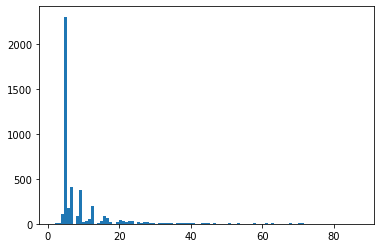

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
11  801aff45ebd0bcd0.jpg     78     26666
30  802beb95d5aac0d7.jpg     78     50595
31  802ddd0a3f70a9f5.jpg     87     18450
34  802f7fd0d42f2cca.jpg      6     32426
********** TEST 1

Images: 12344, Labels: 3752, Super_labels: 72
Avg img per class: 3.29, Min img per class: 3, max img per class: 17
Avg img per super_class: 171.44, Min img per super_class: 3, max img per super_class: 1592
Len split1: 71739
Len split2: 5594
(len split1) / (len split2): 12.824276010010726
Len split1: 59181
Len split2: 18152
(len split1) / (len split2): 3.260301895107977
Len split1: 64380
Len split2: 12953
(len split1) / (len split2): 4.970277155871226
Len split1: 6450

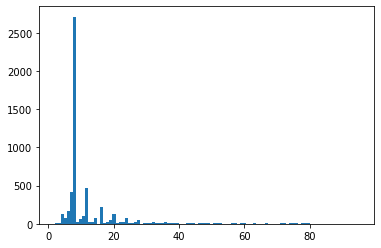

5327
second thresh =  4439
Len split1: 55534
Len split2: 10747
(len split1) / (len split2): 5.167395552247139
len(s1) / len(s2) = 5.167395552247139
Len split1: 55332
Len split2: 10949
(len split1) / (len split2): 5.053612202027582
len(s1) / len(s2) = 5.053612202027582
Len split1: 54801
Len split2: 11480
(len split1) / (len split2): 4.773606271777004
len(s1) / len(s2) = 4.773606271777004
Len split1: 55000
Len split2: 11281
(len split1) / (len split2): 4.875454303696481
len(s1) / len(s2) = 4.875454303696481
Len split1: 54969
Len split2: 11312
(len split1) / (len split2): 4.859352899575672
len(s1) / len(s2) = 4.859352899575672
Len split1: 54933
Len split2: 11348
(len split1) / (len split2): 4.840764892492069
len(s1) / len(s2) = 4.840764892492069
Len split1: 54958
Len split2: 11323
(len split1) / (len split2): 4.853660690629692
len(s1) / len(s2) = 4.853660690629692
Len split1: 55721
Len split2: 10560
(len split1) / (len split2): 5.276609848484848
len(s1) / len(s2) = 5.276609848484848
Len s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12381, Labels: 3762, Super_labels: 74
Avg img per class: 3.29, Min img per class: 3, max img per class: 19
Avg img per super_class: 167.31, Min img per super_class: 3, max img per super_class: 1561
*****

Images: 42820, Labels: 4439, Super_labels: 74
Avg img per class: 9.65, Min img per class: 2, max img per class: 80
Avg img per super_class: 578.65, Min img per super_class: 5, max img per super_class: 5101


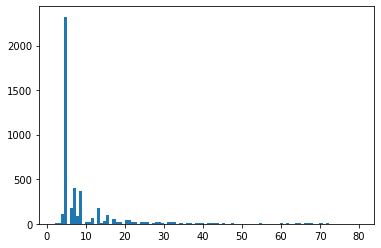

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
3   8007fa0a8fe89f9d.jpg      5     63866
19  802a2be985975e5f.jpg     83     21874
28  802bd28ddce08fbd.jpg      6     25918
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 12381, Labels: 3762, Super_labels: 74
Avg img per class: 3.29, Min img per class: 3, max img per class: 19
Avg img per super_class: 167.31, Min img per super_class: 3, max img per super_class: 1561
Len split1: 71948
Len split2: 5385
(len split1) / (len split2): 13.360817084493965
Len split1: 67324
Len split2: 10009
(len split1) / (len split2): 6.726346288340493
Len split1: 70133
Len split2: 7200
(len split1) / (len split2): 9.740694444444445
Len split1: 60979

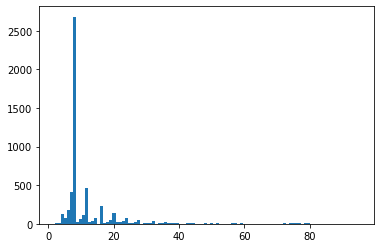

5326
second thresh =  4438
Len split1: 54781
Len split2: 11500
(len split1) / (len split2): 4.763565217391305
len(s1) / len(s2) = 4.763565217391305
Len split1: 55347
Len split2: 10934
(len split1) / (len split2): 5.061916956283153
len(s1) / len(s2) = 5.061916956283153
Len split1: 55201
Len split2: 11080
(len split1) / (len split2): 4.9820397111913355
len(s1) / len(s2) = 4.9820397111913355

Images: 55201, Labels: 4438, Super_labels: 73
Avg img per class: 12.44, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.18, Min img per super_class: 8, max img per super_class: 6809
*********

Images: 11080, Labels: 888, Super_labels: 67
Avg img per class: 12.48, Min img per class: 2, max img per class: 92
Avg img per super_class: 165.37, Min img per super_class: 8, max img per super_class: 1348

Images: 55201, Labels: 4438, Super_labels: 73
Avg img per class: 12.44, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.18, Min img per super_class: 8, max i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12274, Labels: 3733, Super_labels: 72
Avg img per class: 3.29, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.47, Min img per super_class: 3, max img per super_class: 1591
*****

Images: 42927, Labels: 4438, Super_labels: 73
Avg img per class: 9.67, Min img per class: 2, max img per class: 90
Avg img per super_class: 588.04, Min img per super_class: 5, max img per super_class: 5218


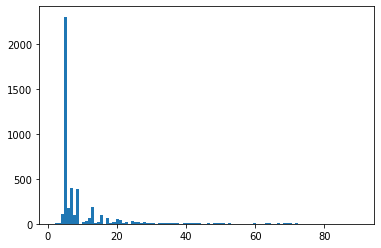

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
19  802a2be985975e5f.jpg     83     21874
21  802a75e51eda5c67.jpg      9      5388
27  802b7e9095d5fe2a.jpg      5     21723
30  802beb95d5aac0d7.jpg     78     50595
********** TEST 1

Images: 12274, Labels: 3733, Super_labels: 72
Avg img per class: 3.29, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.47, Min img per super_class: 3, max img per super_class: 1591
Len split1: 68750
Len split2: 8583
(len split1) / (len split2): 8.01001980659443
Len split1: 58870
Len split2: 18463
(len split1) / (len split2): 3.188539240643449
Len split1: 69351
Len split2: 7982
(len split1) / (len split2): 8.688423953896267
Len split1: 67417
L

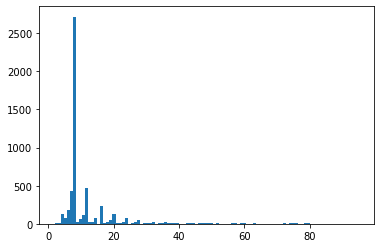

5370
second thresh =  4475
Len split1: 55517
Len split2: 10830
(len split1) / (len split2): 5.126223453370268
len(s1) / len(s2) = 5.126223453370268
Len split1: 55018
Len split2: 11329
(len split1) / (len split2): 4.856386265336746
len(s1) / len(s2) = 4.856386265336746
Len split1: 54820
Len split2: 11527
(len split1) / (len split2): 4.755790752147133
len(s1) / len(s2) = 4.755790752147133
Len split1: 55344
Len split2: 11003
(len split1) / (len split2): 5.029900936108334
len(s1) / len(s2) = 5.029900936108334

Images: 55344, Labels: 4475, Super_labels: 75
Avg img per class: 12.37, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.92, Min img per super_class: 8, max img per super_class: 6584
*********

Images: 11003, Labels: 895, Super_labels: 62
Avg img per class: 12.29, Min img per class: 2, max img per class: 80
Avg img per super_class: 177.47, Min img per super_class: 8, max img per super_class: 1573

Images: 55344, Labels: 4475, Super_labels: 75
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12351, Labels: 3750, Super_labels: 74
Avg img per class: 3.29, Min img per class: 3, max img per class: 16
Avg img per super_class: 166.91, Min img per super_class: 3, max img per super_class: 1524
*****

Images: 42993, Labels: 4475, Super_labels: 75
Avg img per class: 9.61, Min img per class: 2, max img per class: 91
Avg img per super_class: 573.24, Min img per super_class: 5, max img per super_class: 5060


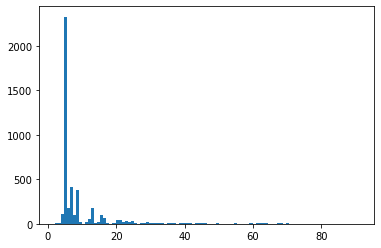

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
19  802a2be985975e5f.jpg     83     21874
20  802a5f42fdf0ab95.jpg     89     43666
22  802a7af055d739e9.jpg     50     45049
29  802beb5ad6256d35.jpg      3     26810
********** TEST 1

Images: 12351, Labels: 3750, Super_labels: 74
Avg img per class: 3.29, Min img per class: 3, max img per class: 16
Avg img per super_class: 166.91, Min img per super_class: 3, max img per super_class: 1524
Len split1: 63958
Len split2: 13375
(len split1) / (len split2): 4.781906542056075
Len split1: 66102
Len split2: 11231
(len split1) / (len split2): 5.885673582049684
Len split1: 62139
Len split2: 15194
(len split1) / (len split2): 4.089706463077531
Len split1: 57830
Len 

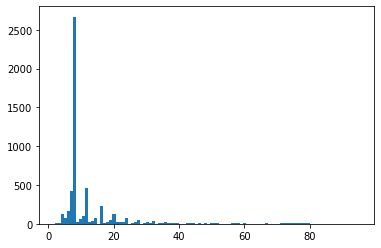

5273
second thresh =  4394
Len split1: 55206
Len split2: 11128
(len split1) / (len split2): 4.9609992810927395
len(s1) / len(s2) = 4.9609992810927395

Images: 55206, Labels: 4394, Super_labels: 74
Avg img per class: 12.56, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.03, Min img per super_class: 8, max img per super_class: 6678
*********

Images: 11128, Labels: 879, Super_labels: 61
Avg img per class: 12.66, Min img per class: 2, max img per class: 95
Avg img per super_class: 182.43, Min img per super_class: 7, max img per super_class: 1479

Images: 55206, Labels: 4394, Super_labels: 74
Avg img per class: 12.56, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.03, Min img per super_class: 8, max img per super_class: 6678
********** TEST 2

Images: 11128, Labels: 879, Super_labels: 61
Avg img per class: 12.66, Min img per class: 2, max img per class: 95
Avg img per super_class: 182.43, Min img per super_class: 7, max img per super_clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12320, Labels: 3713, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 19
Avg img per super_class: 168.77, Min img per super_class: 3, max img per super_class: 1580
*****

Images: 42886, Labels: 4394, Super_labels: 74
Avg img per class: 9.76, Min img per class: 2, max img per class: 83
Avg img per super_class: 579.54, Min img per super_class: 5, max img per super_class: 5098


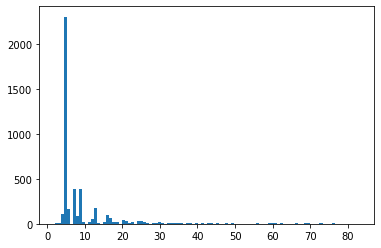

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
2   80053befc2d42fba.jpg      3       672
5   800a7ffa85c57a3a.jpg      3     25583
13  8020ee1f3f7781da.jpg     52      2498
19  802a2be985975e5f.jpg     83     21874
21  802a75e51eda5c67.jpg      9      5388
********** TEST 1

Images: 12320, Labels: 3713, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 19
Avg img per super_class: 168.77, Min img per super_class: 3, max img per super_class: 1580
Len split1: 66564
Len split2: 10769
(len split1) / (len split2): 6.181075308756617
Len split1: 70205
Len split2: 7128
(len split1) / (len split2): 9.849186307519641
Len split1: 71159
Len split2: 6174
(len split1) / (len split2): 11.525591188856495
Len split1: 67920

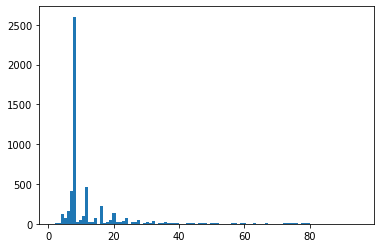

5197
second thresh =  4330
Len split1: 55021
Len split2: 11239
(len split1) / (len split2): 4.895542308034523
len(s1) / len(s2) = 4.895542308034523
Len split1: 55720
Len split2: 10540
(len split1) / (len split2): 5.286527514231499
len(s1) / len(s2) = 5.286527514231499
Len split1: 55927
Len split2: 10333
(len split1) / (len split2): 5.4124649182231686
len(s1) / len(s2) = 5.4124649182231686
Len split1: 55351
Len split2: 10909
(len split1) / (len split2): 5.073883949032909
len(s1) / len(s2) = 5.073883949032909
Len split1: 55273
Len split2: 10987
(len split1) / (len split2): 5.030763629744243
len(s1) / len(s2) = 5.030763629744243

Images: 55273, Labels: 4330, Super_labels: 73
Avg img per class: 12.77, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.16, Min img per super_class: 8, max img per super_class: 6910
*********

Images: 10987, Labels: 867, Super_labels: 60
Avg img per class: 12.67, Min img per class: 2, max img per class: 84
Avg img per super_class: 183.12,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12217, Labels: 3685, Super_labels: 72
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 169.68, Min img per super_class: 3, max img per super_class: 1634
*****

Images: 43056, Labels: 4330, Super_labels: 73
Avg img per class: 9.94, Min img per class: 2, max img per class: 87
Avg img per super_class: 589.81, Min img per super_class: 5, max img per super_class: 5276


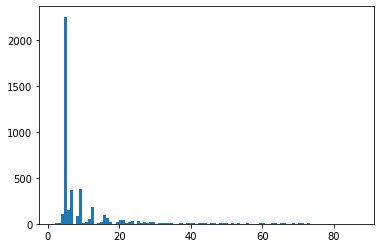

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
12  801f7ce821c7dfd0.jpg     89     27809
19  802a2be985975e5f.jpg     83     21874
********** TEST 1

Images: 12217, Labels: 3685, Super_labels: 72
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 169.68, Min img per super_class: 3, max img per super_class: 1634
Len split1: 73913
Len split2: 3420
(len split1) / (len split2): 21.61198830409357
Len split1: 74361
Len split2: 2972
(len split1) / (len split2): 25.020524899057875
Len split1: 64725
Len split2: 12608
(len split1) / (len split2): 5.133645304568528
Len split1: 70057

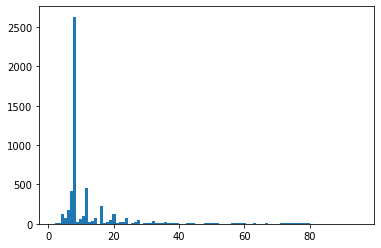

5219
second thresh =  4349
Len split1: 54907
Len split2: 11426
(len split1) / (len split2): 4.805443724838089
len(s1) / len(s2) = 4.805443724838089
Len split1: 55823
Len split2: 10510
(len split1) / (len split2): 5.311417697431018
len(s1) / len(s2) = 5.311417697431018
Len split1: 55195
Len split2: 11138
(len split1) / (len split2): 4.9555575507272405
len(s1) / len(s2) = 4.9555575507272405

Images: 55195, Labels: 4349, Super_labels: 74
Avg img per class: 12.69, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.88, Min img per super_class: 8, max img per super_class: 6754
*********

Images: 11138, Labels: 870, Super_labels: 60
Avg img per class: 12.8, Min img per class: 2, max img per class: 80
Avg img per super_class: 185.63, Min img per super_class: 8, max img per super_class: 1403

Images: 55195, Labels: 4349, Super_labels: 74
Avg img per class: 12.69, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.88, Min img per super_class: 8, max im

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12206, Labels: 3677, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 164.95, Min img per super_class: 3, max img per super_class: 1599
*****

Images: 42989, Labels: 4349, Super_labels: 74
Avg img per class: 9.88, Min img per class: 2, max img per class: 91
Avg img per super_class: 580.93, Min img per super_class: 5, max img per super_class: 5155


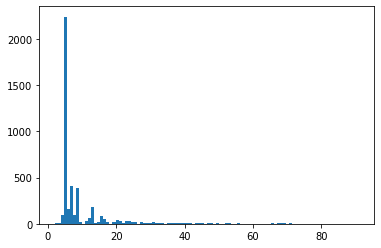

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
5   800a7ffa85c57a3a.jpg      3     25583
31  802ddd0a3f70a9f5.jpg     87     18450
49  803abbf5482e3b93.jpg     87      5210
51  803b5bf6a65459c9.jpg     89      8766
56  803dce35ca659b47.jpg      2     43373
********** TEST 1

Images: 12206, Labels: 3677, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 164.95, Min img per super_class: 3, max img per super_class: 1599
Len split1: 70531
Len split2: 6802
(len split1) / (len split2): 10.369156130549838
Len split1: 68394
Len split2: 8939
(len split1) / (len split2): 7.651191408434948
Len split1: 66676
Len split2: 10657
(len split1) / (len split2): 6.2565449939007225
Len split1: 5558

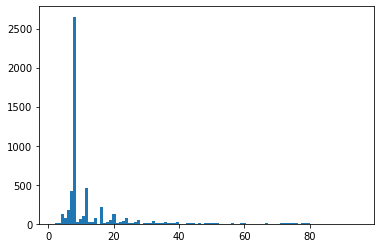

5242
second thresh =  4368
Len split1: 55111
Len split2: 11136
(len split1) / (len split2): 4.948904454022989
len(s1) / len(s2) = 4.948904454022989
Len split1: 55563
Len split2: 10684
(len split1) / (len split2): 5.200580307001124
len(s1) / len(s2) = 5.200580307001124
Len split1: 55097
Len split2: 11150
(len split1) / (len split2): 4.941434977578475
len(s1) / len(s2) = 4.941434977578475
Len split1: 55037
Len split2: 11210
(len split1) / (len split2): 4.909634255129348
len(s1) / len(s2) = 4.909634255129348
Len split1: 55287
Len split2: 10960
(len split1) / (len split2): 5.044434306569343
len(s1) / len(s2) = 5.044434306569343

Images: 55287, Labels: 4368, Super_labels: 73
Avg img per class: 12.66, Min img per class: 2, max img per class: 95
Avg img per super_class: 757.36, Min img per super_class: 7, max img per super_class: 6989
*********

Images: 10960, Labels: 874, Super_labels: 64
Avg img per class: 12.54, Min img per class: 2, max img per class: 95
Avg img per super_class: 171.25, M

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12260, Labels: 3686, Super_labels: 72
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.28, Min img per super_class: 3, max img per super_class: 1627
*****

Images: 43027, Labels: 4368, Super_labels: 73
Avg img per class: 9.85, Min img per class: 2, max img per class: 88
Avg img per super_class: 589.41, Min img per super_class: 5, max img per super_class: 5362


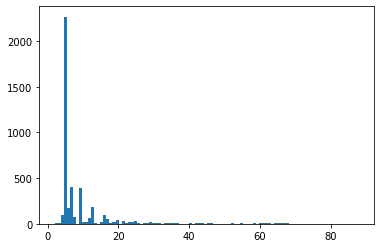

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
13  8020ee1f3f7781da.jpg     52      2498
23  802aab95d62b7daa.jpg      6     33712
34  802f7fd0d42f2cca.jpg      6     32426
39  803570c58f9ba1f7.jpg     87     37779
47  8039c6e66bb6e329.jpg      6      9828
********** TEST 1

Images: 12260, Labels: 3686, Super_labels: 72
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 170.28, Min img per super_class: 3, max img per super_class: 1627
Len split1: 67690
Len split2: 9643
(len split1) / (len split2): 7.0195997096339315
Len split1: 60228
Len split2: 17105
(len split1) / (len split2): 3.5210757088570594
Len split1: 71223
Len split2: 6110
(len split1) / (len split2): 11.656792144026186
Len split1: 70456
Len

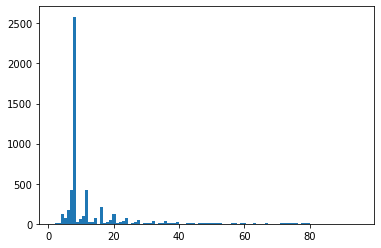

5152
second thresh =  4293
Len split1: 54987
Len split2: 11302
(len split1) / (len split2): 4.865245089364715
len(s1) / len(s2) = 4.865245089364715
Len split1: 55631
Len split2: 10658
(len split1) / (len split2): 5.219647213360855
len(s1) / len(s2) = 5.219647213360855
Len split1: 55442
Len split2: 10847
(len split1) / (len split2): 5.111275006914354
len(s1) / len(s2) = 5.111275006914354
Len split1: 55225
Len split2: 11064
(len split1) / (len split2): 4.991413593637021
len(s1) / len(s2) = 4.991413593637021

Images: 55225, Labels: 4293, Super_labels: 74
Avg img per class: 12.86, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.28, Min img per super_class: 7, max img per super_class: 6717
*********

Images: 11064, Labels: 859, Super_labels: 66
Avg img per class: 12.88, Min img per class: 2, max img per class: 92
Avg img per super_class: 167.64, Min img per super_class: 4, max img per super_class: 1440

Images: 55225, Labels: 4293, Super_labels: 74
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12111, Labels: 3613, Super_labels: 71
Avg img per class: 3.35, Min img per class: 3, max img per class: 19
Avg img per super_class: 170.58, Min img per super_class: 3, max img per super_class: 1569
*****

Images: 43114, Labels: 4293, Super_labels: 74
Avg img per class: 10.04, Min img per class: 2, max img per class: 86
Avg img per super_class: 582.62, Min img per super_class: 5, max img per super_class: 5148


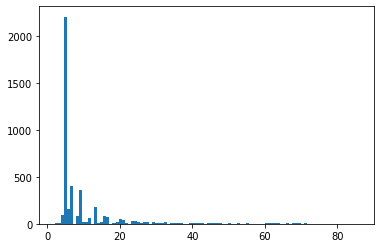

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
5   800a7ffa85c57a3a.jpg      3     25583
6   800bafacb4555b2f.jpg     82      6261
17  80296afd55d516ea.jpg      5     44677
21  802a75e51eda5c67.jpg      9      5388
********** TEST 1

Images: 12111, Labels: 3613, Super_labels: 71
Avg img per class: 3.35, Min img per class: 3, max img per class: 19
Avg img per super_class: 170.58, Min img per super_class: 3, max img per super_class: 1569
Len split1: 73656
Len split2: 3677
(len split1) / (len split2): 20.03154745716617
Len split1: 63368
Len split2: 13965
(len split1) / (len split2): 4.5376297887576085
Len split1: 62579
Len split2: 14754
(len split1) / (len split2): 4.241493832181104
Len split1: 6256

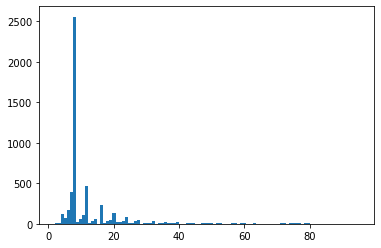

5165
second thresh =  4304
Len split1: 55467
Len split2: 10803
(len split1) / (len split2): 5.134407109136351
len(s1) / len(s2) = 5.134407109136351
Len split1: 55107
Len split2: 11163
(len split1) / (len split2): 4.936576189196453
len(s1) / len(s2) = 4.936576189196453
Len split1: 54775
Len split2: 11495
(len split1) / (len split2): 4.765115267507612
len(s1) / len(s2) = 4.765115267507612
Len split1: 55315
Len split2: 10955
(len split1) / (len split2): 5.049292560474669
len(s1) / len(s2) = 5.049292560474669

Images: 55315, Labels: 4304, Super_labels: 72
Avg img per class: 12.85, Min img per class: 2, max img per class: 95
Avg img per super_class: 768.26, Min img per super_class: 8, max img per super_class: 6825
*********

Images: 10955, Labels: 861, Super_labels: 62
Avg img per class: 12.72, Min img per class: 2, max img per class: 92
Avg img per super_class: 176.69, Min img per super_class: 7, max img per super_class: 1332

Images: 55315, Labels: 4304, Super_labels: 72
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12166, Labels: 3661, Super_labels: 72
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 168.97, Min img per super_class: 3, max img per super_class: 1571
*****

Images: 43149, Labels: 4304, Super_labels: 72
Avg img per class: 10.03, Min img per class: 2, max img per class: 88
Avg img per super_class: 599.29, Min img per super_class: 5, max img per super_class: 5254


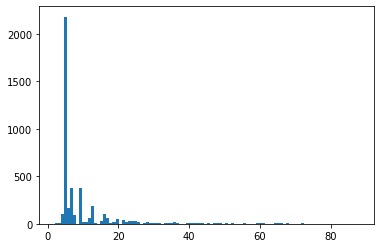

                    image  chain  hotel_id
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
223  807f1ac0973d3de2.jpg     76     60569
224  807f2da4363a8fc5.jpg     44      5002
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
1   8000febe81817f7f.jpg      6     25389
5   800a7ffa85c57a3a.jpg      3     25583
9   80196e6999ce63cf.jpg     90     55532
11  801aff45ebd0bcd0.jpg     78     26666
********** TEST 1

Images: 12166, Labels: 3661, Super_labels: 72
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 168.97, Min img per super_class: 3, max img per super_class: 1571
Len split1: 66051
Len split2: 11282
(len split1) / (len split2): 5.854547066123028
Len split1: 67188
Len split2: 10145
(len split1) / (len split2): 6.622769837358304
Len split1: 72868
Len split2: 4465
(len split1) / (len split2): 16.319820828667414
Len split1: 6666

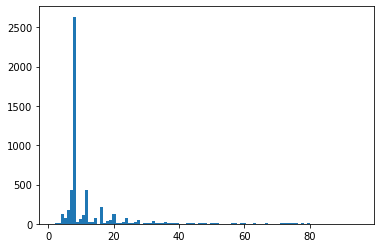

5223
second thresh =  4352
Len split1: 54905
Len split2: 11341
(len split1) / (len split2): 4.841283837404109
len(s1) / len(s2) = 4.841283837404109
Len split1: 55098
Len split2: 11148
(len split1) / (len split2): 4.942411194833154
len(s1) / len(s2) = 4.942411194833154
Len split1: 55376
Len split2: 10870
(len split1) / (len split2): 5.094388224471021
len(s1) / len(s2) = 5.094388224471021
Len split1: 55407
Len split2: 10839
(len split1) / (len split2): 5.111818433434819
len(s1) / len(s2) = 5.111818433434819
Len split1: 54993
Len split2: 11253
(len split1) / (len split2): 4.886963476406292
len(s1) / len(s2) = 4.886963476406292
Len split1: 55754
Len split2: 10492
(len split1) / (len split2): 5.313953488372093
len(s1) / len(s2) = 5.313953488372093
Len split1: 55112
Len split2: 11134
(len split1) / (len split2): 4.949883240524519
len(s1) / len(s2) = 4.949883240524519
Len split1: 54691
Len split2: 11555
(len split1) / (len split2): 4.733102553007356
len(s1) / len(s2) = 4.733102553007356
Len s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12146, Labels: 3647, Super_labels: 75
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 161.95, Min img per super_class: 3, max img per super_class: 1590
*****

Images: 43027, Labels: 4352, Super_labels: 75
Avg img per class: 9.89, Min img per class: 2, max img per class: 89
Avg img per super_class: 573.69, Min img per super_class: 5, max img per super_class: 5296


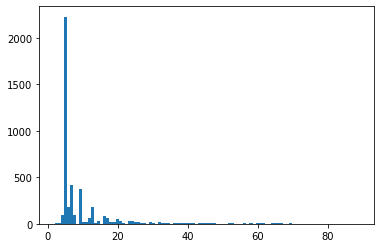

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
1   8000febe81817f7f.jpg      6     25389
5   800a7ffa85c57a3a.jpg      3     25583
21  802a75e51eda5c67.jpg      9      5388
26  802b5ed622fd3587.jpg     90     35252
********** TEST 1

Images: 12146, Labels: 3647, Super_labels: 75
Avg img per class: 3.33, Min img per class: 3, max img per class: 16
Avg img per super_class: 161.95, Min img per super_class: 3, max img per super_class: 1590
Len split1: 71472
Len split2: 5861
(len split1) / (len split2): 12.194506056986862
Len split1: 67194
Len split2: 10139
(len split1) / (len split2): 6.627280796922774
Len split1: 61071
Len split2: 16262
(len split1) / (len split2): 3.7554421350387406
Len split1: 68551
Len

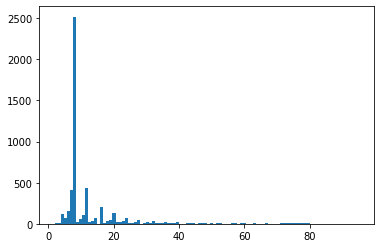

5100
second thresh =  4250
Len split1: 55249
Len split2: 11076
(len split1) / (len split2): 4.988172625496569
len(s1) / len(s2) = 4.988172625496569

Images: 55249, Labels: 4250, Super_labels: 75
Avg img per class: 13.0, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.65, Min img per super_class: 8, max img per super_class: 5325
*********

Images: 11076, Labels: 850, Super_labels: 58
Avg img per class: 13.03, Min img per class: 2, max img per class: 92
Avg img per super_class: 190.97, Min img per super_class: 2, max img per super_class: 1045

Images: 55249, Labels: 4250, Super_labels: 75
Avg img per class: 13.0, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.65, Min img per super_class: 8, max img per super_class: 5325
********** TEST 2

Images: 11076, Labels: 850, Super_labels: 58
Avg img per class: 13.03, Min img per class: 2, max img per class: 92
Avg img per super_class: 190.97, Min img per super_class: 2, max img per super_class: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12109, Labels: 3599, Super_labels: 74
Avg img per class: 3.36, Min img per class: 3, max img per class: 16
Avg img per super_class: 163.64, Min img per super_class: 3, max img per super_class: 1324
*****

Images: 43140, Labels: 4250, Super_labels: 75
Avg img per class: 10.15, Min img per class: 2, max img per class: 82
Avg img per super_class: 575.2, Min img per super_class: 5, max img per super_class: 4001


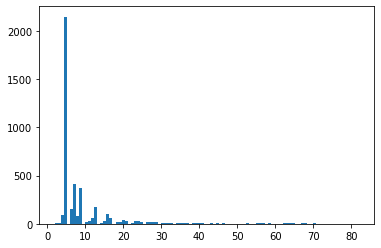

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
                   image  chain  hotel_id
9   80196e6999ce63cf.jpg     90     55532
12  801f7ce821c7dfd0.jpg     89     27809
13  8020ee1f3f7781da.jpg     52      2498
20  802a5f42fdf0ab95.jpg     89     43666
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 12109, Labels: 3599, Super_labels: 74
Avg img per class: 3.36, Min img per class: 3, max img per class: 16
Avg img per super_class: 163.64, Min img per super_class: 3, max img per super_class: 1324
Len split1: 70271
Len split2: 7062
(len split1) / (len split2): 9.9505805720759
Len split1: 62170
Len split2: 15163
(len split1) / (len split2): 4.100112115016818
Len split1: 72815
Len split2: 4518
(len split1) / (len split2): 16.116644532979194
Len split1: 70615
L

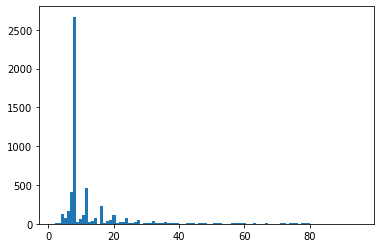

5266
second thresh =  4388
Len split1: 55246
Len split2: 11046
(len split1) / (len split2): 5.001448488140503
len(s1) / len(s2) = 5.001448488140503

Images: 55246, Labels: 4388, Super_labels: 73
Avg img per class: 12.59, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.79, Min img per super_class: 8, max img per super_class: 7075
*********

Images: 11046, Labels: 878, Super_labels: 64
Avg img per class: 12.58, Min img per class: 2, max img per class: 86
Avg img per super_class: 172.59, Min img per super_class: 4, max img per super_class: 1082

Images: 55246, Labels: 4388, Super_labels: 73
Avg img per class: 12.59, Min img per class: 2, max img per class: 95
Avg img per super_class: 756.79, Min img per super_class: 8, max img per super_class: 7075
********** TEST 2

Images: 11046, Labels: 878, Super_labels: 64
Avg img per class: 12.58, Min img per class: 2, max img per class: 86
Avg img per super_class: 172.59, Min img per super_class: 4, max img per super_class:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12269, Labels: 3720, Super_labels: 72
Avg img per class: 3.3, Min img per class: 3, max img per class: 19
Avg img per super_class: 170.4, Min img per super_class: 3, max img per super_class: 1634
*****

Images: 42977, Labels: 4388, Super_labels: 73
Avg img per class: 9.79, Min img per class: 2, max img per class: 84
Avg img per super_class: 588.73, Min img per super_class: 5, max img per super_class: 5441


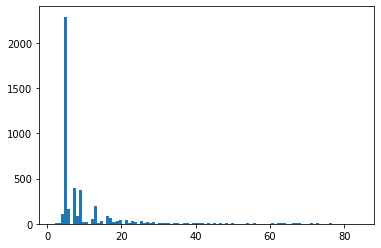

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
224  807f2da4363a8fc5.jpg     44      5002
                   image  chain  hotel_id
19  802a2be985975e5f.jpg     83     21874
23  802aab95d62b7daa.jpg      6     33712
34  802f7fd0d42f2cca.jpg      6     32426
52  803b5ed0d6037b3e.jpg      5     16791
59  803e5f0fe8e00f75.jpg     90     20762
********** TEST 1

Images: 12269, Labels: 3720, Super_labels: 72
Avg img per class: 3.3, Min img per class: 3, max img per class: 19
Avg img per super_class: 170.4, Min img per super_class: 3, max img per super_class: 1634
Len split1: 65631
Len split2: 11702
(len split1) / (len split2): 5.6085284566740725
Len split1: 67920
Len split2: 9413
(len split1) / (len split2): 7.2155529586741745
Len split1: 69043
Len split2: 8290
(len split1) / (len split2): 8.328468033775634
Len split1: 63276


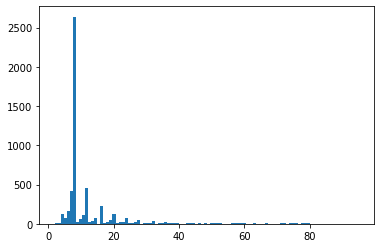

5248
second thresh =  4373
Len split1: 55756
Len split2: 10493
(len split1) / (len split2): 5.313637663204041
len(s1) / len(s2) = 5.313637663204041
Len split1: 55147
Len split2: 11102
(len split1) / (len split2): 4.967303188614664
len(s1) / len(s2) = 4.967303188614664

Images: 55147, Labels: 4373, Super_labels: 74
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.23, Min img per super_class: 4, max img per super_class: 6580
*********

Images: 11102, Labels: 875, Super_labels: 61
Avg img per class: 12.69, Min img per class: 2, max img per class: 95
Avg img per super_class: 182.0, Min img per super_class: 5, max img per super_class: 1577

Images: 55147, Labels: 4373, Super_labels: 74
Avg img per class: 12.61, Min img per class: 2, max img per class: 95
Avg img per super_class: 745.23, Min img per super_class: 4, max img per super_class: 6580
********** TEST 2

Images: 11102, Labels: 875, Super_labels: 61
Avg img per class: 12.69, Min img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12241, Labels: 3682, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.68, Min img per super_class: 3, max img per super_class: 1568
*****

Images: 42906, Labels: 4373, Super_labels: 74
Avg img per class: 9.81, Min img per class: 2, max img per class: 88
Avg img per super_class: 579.81, Min img per super_class: 4, max img per super_class: 5012


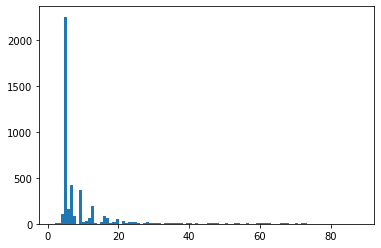

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
94   803ff087ea61de8a.jpg     82     47145
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
3   8007fa0a8fe89f9d.jpg      5     63866
31  802ddd0a3f70a9f5.jpg     87     18450
34  802f7fd0d42f2cca.jpg      6     32426
50  803aff8f12e0519f.jpg     68     63331
********** TEST 1

Images: 12241, Labels: 3682, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.68, Min img per super_class: 3, max img per super_class: 1568
Len split1: 70363
Len split2: 6970
(len split1) / (len split2): 10.095121951219513
Len split1: 74187
Len split2: 3146
(len split1) / (len split2): 23.581373172282262
Len split1: 58984
Len split2: 18349
(len split1) / (len split2): 3.2145621014769197
Len split1: 624

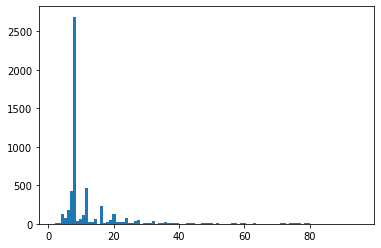

5315
second thresh =  4429
Len split1: 55438
Len split2: 10890
(len split1) / (len split2): 5.090725436179982
len(s1) / len(s2) = 5.090725436179982
Len split1: 55747
Len split2: 10581
(len split1) / (len split2): 5.268594650789151
len(s1) / len(s2) = 5.268594650789151
Len split1: 55126
Len split2: 11202
(len split1) / (len split2): 4.921085520442778
len(s1) / len(s2) = 4.921085520442778
Len split1: 54933
Len split2: 11395
(len split1) / (len split2): 4.820798595875384
len(s1) / len(s2) = 4.820798595875384
Len split1: 56182
Len split2: 10146
(len split1) / (len split2): 5.537354622511335
len(s1) / len(s2) = 5.537354622511335
Len split1: 55507
Len split2: 10821
(len split1) / (len split2): 5.129562886979023
len(s1) / len(s2) = 5.129562886979023
Len split1: 55245
Len split2: 11083
(len split1) / (len split2): 4.984661192817829
len(s1) / len(s2) = 4.984661192817829

Images: 55245, Labels: 4429, Super_labels: 74
Avg img per class: 12.47, Min img per class: 2, max img per class: 95
Avg img p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12304, Labels: 3736, Super_labels: 73
Avg img per class: 3.29, Min img per class: 3, max img per class: 16
Avg img per super_class: 168.55, Min img per super_class: 3, max img per super_class: 1558
*****

Images: 42941, Labels: 4429, Super_labels: 74
Avg img per class: 9.7, Min img per class: 2, max img per class: 88
Avg img per super_class: 580.28, Min img per super_class: 5, max img per super_class: 5301


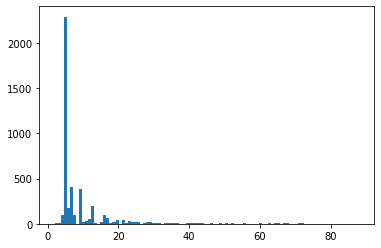

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
206  807e68855eeaa1d7.jpg      5     52125
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
13  8020ee1f3f7781da.jpg     52      2498
23  802aab95d62b7daa.jpg      6     33712
24  802aef94c02bbfd5.jpg      6     62831
26  802b5ed622fd3587.jpg     90     35252
********** TEST 1

Images: 12304, Labels: 3736, Super_labels: 73
Avg img per class: 3.29, Min img per class: 3, max img per class: 16
Avg img per super_class: 168.55, Min img per super_class: 3, max img per super_class: 1558
Len split1: 66763
Len split2: 10570
(len split1) / (len split2): 6.316272469252602
Len split1: 61577
Len split2: 15756
(len split1) / (len split2): 3.908161970043158
Len split1: 57929
Len split2: 19404
(len split1) / (len split2): 2.985415378272521
Len split1: 6905

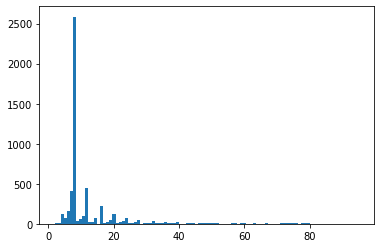

5159
second thresh =  4299
Len split1: 55331
Len split2: 10877
(len split1) / (len split2): 5.086972510802611
len(s1) / len(s2) = 5.086972510802611
Len split1: 55365
Len split2: 10843
(len split1) / (len split2): 5.106059208706077
len(s1) / len(s2) = 5.106059208706077
Len split1: 55218
Len split2: 10990
(len split1) / (len split2): 5.024385805277525
len(s1) / len(s2) = 5.024385805277525

Images: 55218, Labels: 4299, Super_labels: 74
Avg img per class: 12.84, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.19, Min img per super_class: 8, max img per super_class: 6842
*********

Images: 10990, Labels: 860, Super_labels: 60
Avg img per class: 12.78, Min img per class: 2, max img per class: 84
Avg img per super_class: 183.17, Min img per super_class: 5, max img per super_class: 1315

Images: 55218, Labels: 4299, Super_labels: 74
Avg img per class: 12.84, Min img per class: 2, max img per class: 95
Avg img per super_class: 746.19, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12082, Labels: 3643, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 17
Avg img per super_class: 165.51, Min img per super_class: 3, max img per super_class: 1612
*****

Images: 43136, Labels: 4299, Super_labels: 74
Avg img per class: 10.03, Min img per class: 2, max img per class: 87
Avg img per super_class: 582.92, Min img per super_class: 5, max img per super_class: 5230


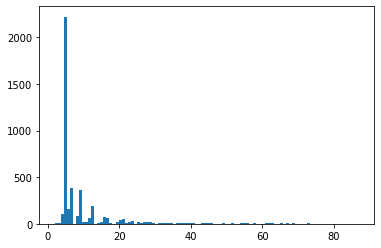

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
1   8000febe81817f7f.jpg      6     25389
3   8007fa0a8fe89f9d.jpg      5     63866
5   800a7ffa85c57a3a.jpg      3     25583
12  801f7ce821c7dfd0.jpg     89     27809
13  8020ee1f3f7781da.jpg     52      2498
********** TEST 1

Images: 12082, Labels: 3643, Super_labels: 73
Avg img per class: 3.32, Min img per class: 3, max img per class: 17
Avg img per super_class: 165.51, Min img per super_class: 3, max img per super_class: 1612
Len split1: 69694
Len split2: 7639
(len split1) / (len split2): 9.123445477156697
Len split1: 67333
Len split2: 10000
(len split1) / (len split2): 6.7333
Len split1: 67481
Len split2: 9852
(len split1) / (len split2): 6.849472188388145
Len split1: 70262
Len split2:

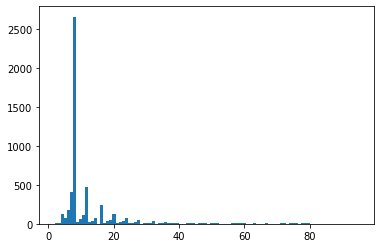

5285
second thresh =  4404
Len split1: 55644
Len split2: 10706
(len split1) / (len split2): 5.197459368578367
len(s1) / len(s2) = 5.197459368578367
Len split1: 55462
Len split2: 10888
(len split1) / (len split2): 5.093864805290227
len(s1) / len(s2) = 5.093864805290227
Len split1: 55968
Len split2: 10382
(len split1) / (len split2): 5.390868811404354
len(s1) / len(s2) = 5.390868811404354
Len split1: 55269
Len split2: 11081
(len split1) / (len split2): 4.987726739463947
len(s1) / len(s2) = 4.987726739463947

Images: 55269, Labels: 4404, Super_labels: 75
Avg img per class: 12.55, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.92, Min img per super_class: 8, max img per super_class: 6912
*********

Images: 11081, Labels: 881, Super_labels: 60
Avg img per class: 12.58, Min img per class: 2, max img per class: 80
Avg img per super_class: 184.68, Min img per super_class: 6, max img per super_class: 1245

Images: 55269, Labels: 4404, Super_labels: 75
Avg img per class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12311, Labels: 3734, Super_labels: 74
Avg img per class: 3.3, Min img per class: 3, max img per class: 19
Avg img per super_class: 166.36, Min img per super_class: 3, max img per super_class: 1575
*****

Images: 42958, Labels: 4404, Super_labels: 75
Avg img per class: 9.75, Min img per class: 2, max img per class: 88
Avg img per super_class: 572.77, Min img per super_class: 5, max img per super_class: 5337


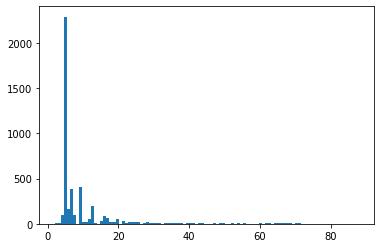

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
94   803ff087ea61de8a.jpg     82     47145
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
17  80296afd55d516ea.jpg      5     44677
48  803a7f95384ebc63.jpg     89      1779
49  803abbf5482e3b93.jpg     87      5210
52  803b5ed0d6037b3e.jpg      5     16791
87  803fd0d41f68c6d7.jpg      1     16966
********** TEST 1

Images: 12311, Labels: 3734, Super_labels: 74
Avg img per class: 3.3, Min img per class: 3, max img per class: 19
Avg img per super_class: 166.36, Min img per super_class: 3, max img per super_class: 1575
Len split1: 63807
Len split2: 13526
(len split1) / (len split2): 4.717359160136034
Len split1: 65551
Len split2: 11782
(len split1) / (len split2): 5.563656425055169
Len split1: 65988
Len split2: 11345
(len split1) / (len split2): 5.816483032172763
Len split1: 69751

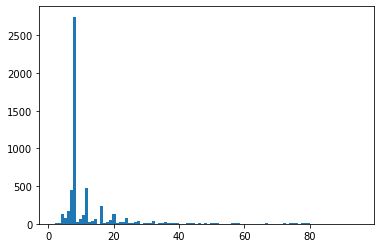

5396
second thresh =  4496
Len split1: 54728
Len split2: 11492
(len split1) / (len split2): 4.762269404803342
len(s1) / len(s2) = 4.762269404803342
Len split1: 54527
Len split2: 11693
(len split1) / (len split2): 4.663217309501411
len(s1) / len(s2) = 4.663217309501411
Len split1: 55253
Len split2: 10967
(len split1) / (len split2): 5.038114343029087
len(s1) / len(s2) = 5.038114343029087

Images: 55253, Labels: 4496, Super_labels: 75
Avg img per class: 12.29, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.71, Min img per super_class: 8, max img per super_class: 7105
*********

Images: 10967, Labels: 900, Super_labels: 61
Avg img per class: 12.19, Min img per class: 2, max img per class: 95
Avg img per super_class: 179.79, Min img per super_class: 8, max img per super_class: 1052

Images: 55253, Labels: 4496, Super_labels: 75
Avg img per class: 12.29, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.71, Min img per super_class: 8, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12411, Labels: 3780, Super_labels: 74
Avg img per class: 3.28, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.72, Min img per super_class: 3, max img per super_class: 1651
*****

Images: 42842, Labels: 4496, Super_labels: 75
Avg img per class: 9.53, Min img per class: 2, max img per class: 86
Avg img per super_class: 571.23, Min img per super_class: 5, max img per super_class: 5454


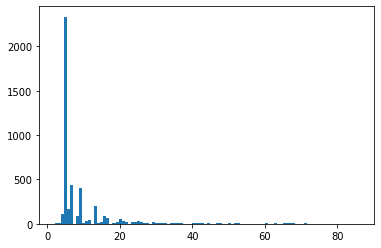

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
8   8011ffce8971daa3.jpg     87     19657
19  802a2be985975e5f.jpg     83     21874
21  802a75e51eda5c67.jpg      9      5388
26  802b5ed622fd3587.jpg     90     35252
********** TEST 1

Images: 12411, Labels: 3780, Super_labels: 74
Avg img per class: 3.28, Min img per class: 3, max img per class: 16
Avg img per super_class: 167.72, Min img per super_class: 3, max img per super_class: 1651
Len split1: 58307
Len split2: 19026
(len split1) / (len split2): 3.0645958162514453
Len split1: 62061
Len split2: 15272
(len split1) / (len split2): 4.063711367207962
Len split1: 65733
Len split2: 11600
(len split1) / (len split2): 5.666637931034483
Len split1: 701

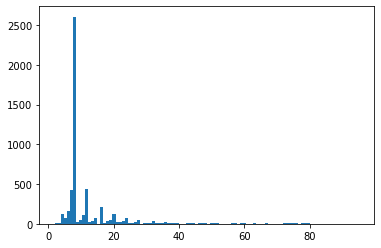

5195
second thresh =  4329
Len split1: 55131
Len split2: 11185
(len split1) / (len split2): 4.929012069736254
len(s1) / len(s2) = 4.929012069736254
Len split1: 54907
Len split2: 11409
(len split1) / (len split2): 4.812604084494697
len(s1) / len(s2) = 4.812604084494697
Len split1: 55105
Len split2: 11211
(len split1) / (len split2): 4.915261796449915
len(s1) / len(s2) = 4.915261796449915
Len split1: 55460
Len split2: 10856
(len split1) / (len split2): 5.108695652173913
len(s1) / len(s2) = 5.108695652173913
Len split1: 54511
Len split2: 11805
(len split1) / (len split2): 4.617619652689538
len(s1) / len(s2) = 4.617619652689538
Len split1: 55572
Len split2: 10744
(len split1) / (len split2): 5.172375279225614
len(s1) / len(s2) = 5.172375279225614
Len split1: 55154
Len split2: 11162
(len split1) / (len split2): 4.94122917039957
len(s1) / len(s2) = 4.94122917039957
Len split1: 55712
Len split2: 10604
(len split1) / (len split2): 5.253866465484723
len(s1) / len(s2) = 5.253866465484723
Len spl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12123, Labels: 3647, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 163.82, Min img per super_class: 3, max img per super_class: 1600
*****

Images: 43157, Labels: 4329, Super_labels: 75
Avg img per class: 9.97, Min img per class: 2, max img per class: 87
Avg img per super_class: 575.43, Min img per super_class: 5, max img per super_class: 5143


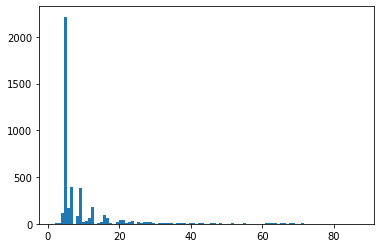

                    image  chain  hotel_id
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
206  807e68855eeaa1d7.jpg      5     52125
224  807f2da4363a8fc5.jpg     44      5002
286  8084fead05cb5d7a.jpg      6     43451
                   image  chain  hotel_id
3   8007fa0a8fe89f9d.jpg      5     63866
11  801aff45ebd0bcd0.jpg     78     26666
12  801f7ce821c7dfd0.jpg     89     27809
26  802b5ed622fd3587.jpg     90     35252
29  802beb5ad6256d35.jpg      3     26810
********** TEST 1

Images: 12123, Labels: 3647, Super_labels: 74
Avg img per class: 3.32, Min img per class: 3, max img per class: 16
Avg img per super_class: 163.82, Min img per super_class: 3, max img per super_class: 1600
Len split1: 65581
Len split2: 11752
(len split1) / (len split2): 5.580411844792375
Len split1: 65431
Len split2: 11902
(len split1) / (len split2): 5.4974794152243325
Len split1: 73361
Len split2: 3972
(len split1) / (len split2): 18.469536757301107
Len split1: 605

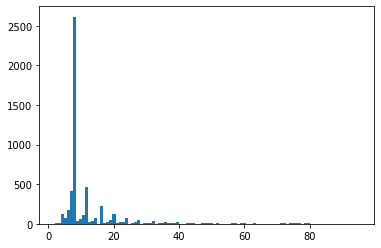

5217
second thresh =  4347
Len split1: 55335
Len split2: 10908
(len split1) / (len split2): 5.072882288228823
len(s1) / len(s2) = 5.072882288228823
Len split1: 54562
Len split2: 11681
(len split1) / (len split2): 4.671004194846332
len(s1) / len(s2) = 4.671004194846332
Len split1: 55329
Len split2: 10914
(len split1) / (len split2): 5.069543705332601
len(s1) / len(s2) = 5.069543705332601
Len split1: 55207
Len split2: 11036
(len split1) / (len split2): 5.0024465386009425
len(s1) / len(s2) = 5.0024465386009425

Images: 55207, Labels: 4347, Super_labels: 75
Avg img per class: 12.7, Min img per class: 2, max img per class: 92
Avg img per super_class: 736.09, Min img per super_class: 8, max img per super_class: 6859
*********

Images: 11036, Labels: 870, Super_labels: 59
Avg img per class: 12.69, Min img per class: 2, max img per class: 95
Avg img per super_class: 187.05, Min img per super_class: 5, max img per super_class: 1298

Images: 55207, Labels: 4347, Super_labels: 75
Avg img per clas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12194, Labels: 3679, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 17
Avg img per super_class: 164.78, Min img per super_class: 3, max img per super_class: 1586
*****

Images: 43013, Labels: 4347, Super_labels: 75
Avg img per class: 9.89, Min img per class: 2, max img per class: 80
Avg img per super_class: 573.51, Min img per super_class: 5, max img per super_class: 5273


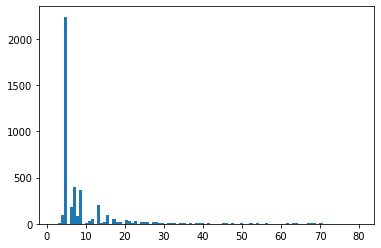

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
105  804a7ebd15c5c3ce.jpg      2     17257
119  8056bfc10b5f85a7.jpg      6     62668
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
6   800bafacb4555b2f.jpg     82      6261
12  801f7ce821c7dfd0.jpg     89     27809
17  80296afd55d516ea.jpg      5     44677
19  802a2be985975e5f.jpg     83     21874
21  802a75e51eda5c67.jpg      9      5388
********** TEST 1

Images: 12194, Labels: 3679, Super_labels: 74
Avg img per class: 3.31, Min img per class: 3, max img per class: 17
Avg img per super_class: 164.78, Min img per super_class: 3, max img per super_class: 1586
Len split1: 67287
Len split2: 10046
(len split1) / (len split2): 6.697889707346207
Len split1: 68714
Len split2: 8619
(len split1) / (len split2): 7.9723865877712035
Len split1: 67430
Len split2: 9903
(len split1) / (len split2): 6.809047763304049
Len split1: 68401

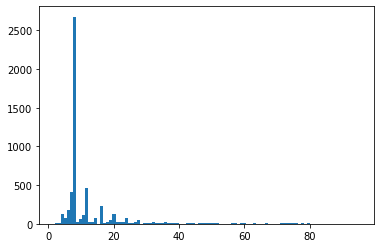

5276
second thresh =  4396
Len split1: 54689
Len split2: 11591
(len split1) / (len split2): 4.718229660943836
len(s1) / len(s2) = 4.718229660943836
Len split1: 55064
Len split2: 11216
(len split1) / (len split2): 4.90941512125535
len(s1) / len(s2) = 4.90941512125535
Len split1: 55690
Len split2: 10590
(len split1) / (len split2): 5.258734655335222
len(s1) / len(s2) = 5.258734655335222
Len split1: 54980
Len split2: 11300
(len split1) / (len split2): 4.865486725663716
len(s1) / len(s2) = 4.865486725663716
Len split1: 54971
Len split2: 11309
(len split1) / (len split2): 4.860818816871518
len(s1) / len(s2) = 4.860818816871518
Len split1: 55039
Len split2: 11241
(len split1) / (len split2): 4.896272573614447
len(s1) / len(s2) = 4.896272573614447
Len split1: 54851
Len split2: 11429
(len split1) / (len split2): 4.799282526905241
len(s1) / len(s2) = 4.799282526905241
Len split1: 55215
Len split2: 11065
(len split1) / (len split2): 4.990058743786715
len(s1) / len(s2) = 4.990058743786715

Images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12241, Labels: 3695, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 167.68, Min img per super_class: 3, max img per super_class: 1571
*****

Images: 42974, Labels: 4396, Super_labels: 74
Avg img per class: 9.78, Min img per class: 2, max img per class: 79
Avg img per super_class: 580.73, Min img per super_class: 5, max img per super_class: 5119


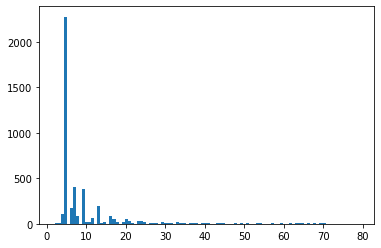

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
80   803f7f846ec53568.jpg      9     49512
86   803fbf423e3c692a.jpg     54     54879
119  8056bfc10b5f85a7.jpg      6     62668
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
8   8011ffce8971daa3.jpg     87     19657
12  801f7ce821c7dfd0.jpg     89     27809
21  802a75e51eda5c67.jpg      9      5388
30  802beb95d5aac0d7.jpg     78     50595
********** TEST 1

Images: 12241, Labels: 3695, Super_labels: 73
Avg img per class: 3.31, Min img per class: 3, max img per class: 15
Avg img per super_class: 167.68, Min img per super_class: 3, max img per super_class: 1571
Len split1: 61791
Len split2: 15542
(len split1) / (len split2): 3.9757431476000513
Len split1: 65582
Len split2: 11751
(len split1) / (len split2): 5.5809718321844946
Len split1: 55932
Len split2: 21401
(len split1) / (len split2): 2.6135227325825894
Len split1: 6

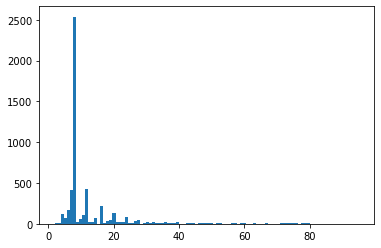

5118
second thresh =  4265
Len split1: 55815
Len split2: 10545
(len split1) / (len split2): 5.29302987197724
len(s1) / len(s2) = 5.29302987197724
Len split1: 55861
Len split2: 10499
(len split1) / (len split2): 5.320601962091628
len(s1) / len(s2) = 5.320601962091628
Len split1: 55156
Len split2: 11204
(len split1) / (len split2): 4.9228846840414135
len(s1) / len(s2) = 4.9228846840414135
Len split1: 55645
Len split2: 10715
(len split1) / (len split2): 5.193187120858609
len(s1) / len(s2) = 5.193187120858609
Len split1: 55267
Len split2: 11093
(len split1) / (len split2): 4.982150905976742
len(s1) / len(s2) = 4.982150905976742

Images: 55267, Labels: 4265, Super_labels: 75
Avg img per class: 12.96, Min img per class: 2, max img per class: 95
Avg img per super_class: 736.89, Min img per super_class: 8, max img per super_class: 6735
*********

Images: 11093, Labels: 853, Super_labels: 62
Avg img per class: 13.0, Min img per class: 2, max img per class: 80
Avg img per super_class: 178.92, Mi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 11951, Labels: 3592, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 17
Avg img per super_class: 161.5, Min img per super_class: 3, max img per super_class: 1562
*****

Images: 43316, Labels: 4265, Super_labels: 75
Avg img per class: 10.16, Min img per class: 2, max img per class: 85
Avg img per super_class: 577.55, Min img per super_class: 5, max img per super_class: 5173


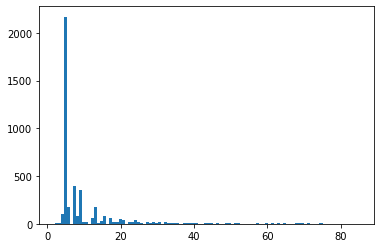

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
6   800bafacb4555b2f.jpg     82      6261
19  802a2be985975e5f.jpg     83     21874
31  802ddd0a3f70a9f5.jpg     87     18450
51  803b5bf6a65459c9.jpg     89      8766
********** TEST 1

Images: 11951, Labels: 3592, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 17
Avg img per super_class: 161.5, Min img per super_class: 3, max img per super_class: 1562
Len split1: 65707
Len split2: 11626
(len split1) / (len split2): 5.6517288835369
Len split1: 68711
Len split2: 8622
(len split1) / (len split2): 7.969264671769891
Len split1: 64026
Len split2: 13307
(len split1) / (len split2): 4.811452618922372
Len split1: 62094
Len spli

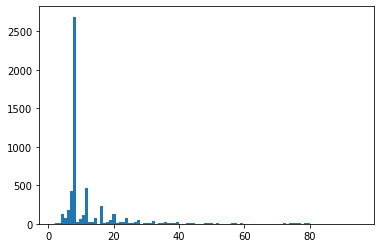

5309
second thresh =  4424
Len split1: 55754
Len split2: 10505
(len split1) / (len split2): 5.307377439314612
len(s1) / len(s2) = 5.307377439314612
Len split1: 54540
Len split2: 11719
(len split1) / (len split2): 4.653980715078078
len(s1) / len(s2) = 4.653980715078078
Len split1: 55233
Len split2: 11026
(len split1) / (len split2): 5.009341556321422
len(s1) / len(s2) = 5.009341556321422

Images: 55233, Labels: 4424, Super_labels: 72
Avg img per class: 12.48, Min img per class: 2, max img per class: 95
Avg img per super_class: 767.12, Min img per super_class: 7, max img per super_class: 6898
*********

Images: 11026, Labels: 885, Super_labels: 66
Avg img per class: 12.46, Min img per class: 2, max img per class: 87
Avg img per super_class: 167.06, Min img per super_class: 6, max img per super_class: 1259

Images: 55233, Labels: 4424, Super_labels: 72
Avg img per class: 12.48, Min img per class: 2, max img per class: 95
Avg img per super_class: 767.12, Min img per super_class: 7, max img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12310, Labels: 3720, Super_labels: 71
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 173.38, Min img per super_class: 3, max img per super_class: 1602
*****

Images: 42923, Labels: 4424, Super_labels: 72
Avg img per class: 9.7, Min img per class: 2, max img per class: 81
Avg img per super_class: 596.15, Min img per super_class: 5, max img per super_class: 5296


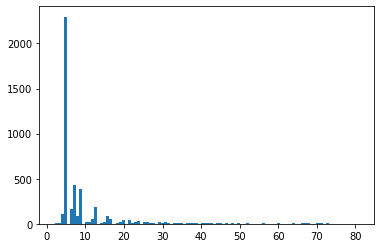

                   image  chain  hotel_id
10  8019eb8e1474ebcf.jpg     28      5168
18  8029d51f7861779e.jpg     50     49164
80  803f7f846ec53568.jpg      9     49512
86  803fbf423e3c692a.jpg     54     54879
94  803ff087ea61de8a.jpg     82     47145
                   image  chain  hotel_id
0   8000d59f6a3d765f.jpg     85     24607
3   8007fa0a8fe89f9d.jpg      5     63866
6   800bafacb4555b2f.jpg     82      6261
7   800e7dd55ffa4056.jpg      2     60181
31  802ddd0a3f70a9f5.jpg     87     18450
********** TEST 1

Images: 12310, Labels: 3720, Super_labels: 71
Avg img per class: 3.31, Min img per class: 3, max img per class: 16
Avg img per super_class: 173.38, Min img per super_class: 3, max img per super_class: 1602
Len split1: 67690
Len split2: 9643
(len split1) / (len split2): 7.0195997096339315
Len split1: 49618
Len split2: 27715
(len split1) / (len split2): 1.7902940645859642
Len split1: 72530
Len split2: 4803
(len split1) / (len split2): 15.100978555069748
Len split1: 66115
Len

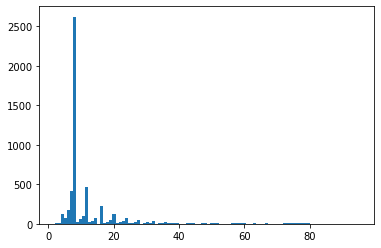

5226
second thresh =  4355
Len split1: 54723
Len split2: 11591
(len split1) / (len split2): 4.721162971270814
len(s1) / len(s2) = 4.721162971270814
Len split1: 55412
Len split2: 10902
(len split1) / (len split2): 5.08273711245643
len(s1) / len(s2) = 5.08273711245643
Len split1: 55743
Len split2: 10571
(len split1) / (len split2): 5.273200264875603
len(s1) / len(s2) = 5.273200264875603
Len split1: 55321
Len split2: 10993
(len split1) / (len split2): 5.03238424451924
len(s1) / len(s2) = 5.03238424451924

Images: 55321, Labels: 4355, Super_labels: 75
Avg img per class: 12.7, Min img per class: 2, max img per class: 95
Avg img per super_class: 737.61, Min img per super_class: 8, max img per super_class: 6622
*********

Images: 10993, Labels: 871, Super_labels: 62
Avg img per class: 12.62, Min img per class: 2, max img per class: 95
Avg img per super_class: 177.31, Min img per super_class: 7, max img per super_class: 1535

Images: 55321, Labels: 4355, Super_labels: 75
Avg img per class: 12.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Images: 12309, Labels: 3697, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 18
Avg img per super_class: 166.34, Min img per super_class: 3, max img per super_class: 1543
*****

Images: 43012, Labels: 4355, Super_labels: 75
Avg img per class: 9.88, Min img per class: 2, max img per class: 88
Avg img per super_class: 573.49, Min img per super_class: 5, max img per super_class: 5079


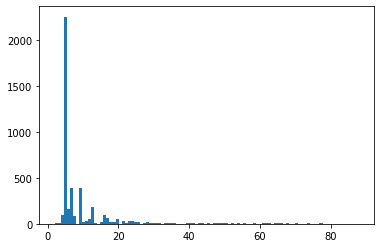

                    image  chain  hotel_id
10   8019eb8e1474ebcf.jpg     28      5168
18   8029d51f7861779e.jpg     50     49164
86   803fbf423e3c692a.jpg     54     54879
105  804a7ebd15c5c3ce.jpg      2     17257
128  805f27a3bb4896a7.jpg      9     14532
                   image  chain  hotel_id
8   8011ffce8971daa3.jpg     87     19657
22  802a7af055d739e9.jpg     50     45049
27  802b7e9095d5fe2a.jpg      5     21723
28  802bd28ddce08fbd.jpg      6     25918
32  802f65855fd85b87.jpg      5     34702
********** TEST 1

Images: 12309, Labels: 3697, Super_labels: 74
Avg img per class: 3.33, Min img per class: 3, max img per class: 18
Avg img per super_class: 166.34, Min img per super_class: 3, max img per super_class: 1543


In [ ]:
import os 

val_thresh = 65
test_thresh = 75

#  trainval (or) train size = 4x
#  test3 (or) val3 size = x
#  test2 (or) val2 size = x
#  test1 (or) val1 size = x

number_of_split_sets = 100

train_to_each_eval_ratio = 4.0 
trainval1val2_to_val3_ratio = train_to_each_eval_ratio + 2
trainval1_to_val2_ratio = train_to_each_eval_ratio + 1
train_to_val1_ratio = train_to_each_eval_ratio

test1_thresholds = [2, 3]

error_margin = 0.05

# test1_threshold = 2

root_path = './drive/MyDrive/ht-image/hotelid-2021-split/'

for test1_threshold in test1_thresholds:
  # base_path = os.path.join(root_path, f'splits_{test1_threshold}')
  file_path = os.path.join(root_path, f'splits_{test1_threshold}')
  # base_path = f'./drive/MyDrive/ht-image/hotelid-2021-split/splits_3'
  os.mkdir(file_path)

  for file_id in range(number_of_split_sets):
    to_write_in_file = ''
    # print('File ID:', file_id)
    dir_path = f'{file_path}/{file_id}'
    os.mkdir(dir_path)
    while True:
        random_split = np.random.choice(all_known_chains.chain.unique(), test_thresh, replace=False)
        s1, s2, splits = get_label_split_stats(all_known_chains, random_split, 'chain')

        if len(s1) / len(s2) > (trainval1val2_to_val3_ratio - error_margin) and len(s1) / len(s2) < (trainval1val2_to_val3_ratio + error_margin):
          get_stats(s1)
          print('********* TEST 3')
          get_stats(s2)
          # input()

          trainval_split = s1
          test3_split = s2

          trainval_split_labels, trainval_split_labels_count = np.unique(trainval_split.hotel_id, return_counts=True)

          plt.hist(trainval_split_labels_count, bins=100)
          plt.show()
          break

    to_write_in_file += get_stats(test3_split, title='Test 3', p=False)
    trainval_split.to_csv(f'{dir_path}/train_test12_hotels.csv', header=True, index=False)
    test3_split.to_csv(f'{dir_path}/test3_hotels.csv', header=True, index=False)

    print(len(trainval_split_labels))
    second_thresh = int(((len(trainval_split_labels)) / 6) * 5)
    print('second thresh = ', second_thresh)
    
    while True:
        random_ssplit = np.random.choice(trainval_split_labels, second_thresh, replace=False)
        # random_ssplit = np.random.choice(trainval_split_labels, 4406, replace=False)
        # # random_ssplit = np.random.choice(trainval_split_labels, 3150, replace=False)
        s1, s2, splits = get_label_split_stats(trainval_split, random_ssplit, 'hotel_id')
        print(f'len(s1) / len(s2) = {len(s1) / len(s2)}')
        if len(s1) / len(s2) > (trainval1_to_val2_ratio - error_margin) and len(s1) / len(s2) < (trainval1_to_val2_ratio + error_margin):
          get_stats(s1)
          print('*********')
          get_stats(s2)
          

          trainval1_split = s1
          test2_split = s2
          get_stats(trainval1_split)
          print('********** TEST 2')
          get_stats(test2_split)
          break

    to_write_in_file += get_stats(test2_split, title='Test 2', p=False)
    trainval1_split.to_csv(f'{dir_path}/train_test1_hotels.csv', header=True, index=False)
    test2_split.to_csv(f'{dir_path}/test2_hotels.csv', header=True, index=False)

    
    # EVAL_ENTERING_THRESHOLD is 8 in this example
    train_split, test1_split = get_final_split(trainval1_split, EVAL_ENTERING_THRESHOLD, test1_threshold)

    print('********** TEST 1')
    get_stats(test1_split)

    to_write_in_file += get_stats(test1_split, title='Test 1', p=False)
    to_write_in_file += get_stats(train_split, title='Trainval', p=False)
    train_split.to_csv(f'{dir_path}/trainval_hotels.csv', header=True, index=False)
    test1_split.to_csv(f'{dir_path}/test1_hotels.csv', header=True, index=False)

    with open(os.path.join(dir_path, 'class_info.txt'), 'w') as f:
      f.write(to_write_in_file)

In [ ]:
import os
import shutil

for test1_threshold in [2, 3]:
  old_base_path = f'./drive/MyDrive/ht-image/hotelid-2021-split/old_splits_{test1_threshold}'
  base_path = f'./drive/MyDrive/ht-image/hotelid-2021-split/splits_{test1_threshold}'

  # os.mkdir(base_path)

  for file_id in range(100):
    old_path = os.path.join(old_base_path, str(file_id))
    path = os.path.join(base_path, str(file_id))
    # os.mkdir(path)
    # print(test1_threshold, file_id)
    # for f in ['trainval_hotels', 'test1_hotels', 'test2_hotels', 'test3_hotels']:
    for f in ['class_info.txt', 'train_test1_hotels.csv', 'train_test12_hotels.csv']:
      
      fpath = os.path.join(old_path, f)
      save_path = os.path.join(path, f)

      shutil.copyfile(fpath, save_path)

      # df = pd.read_csv(fpath)

      # df = df[['image', 'hotel_id', 'chain']]
      # print(df.columns)
      # df = df[['image', 'label', 'super_label']]سه 
      # print(df.columns)
      # df.image = df.apply(lambda row: f'images/{row.super_label}/{row.image}', axis=1)
      # df.to_csv(save_path, index=False, header=True)
